In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.compat import v1 as tf1
from tensorflow.keras import layers as tfkl
import pandas as pd
import sklearn

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn import metrics


from dctm import correlated_topic_model as ctmd
from dctm import dynamic_correlated_topic_model as dctm
from sklearn import metrics, preprocessing

from imp import reload

from dctm import correlated_topic_model as ctmd
from dctm import dynamic_correlated_topic_model as dctm

from dctm import datasets

import seaborn as sb
from matplotlib.transforms import Bbox
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.stattools import durbin_watson

/home/2064240P/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [4]:
data = pd.read_csv("malaria/pb10xIDC_counts.csv",header=0,index_col=0)

In [5]:
data

AAACCTGAGCACCGTC  AAACCTGAGCGCTTAT  AAACGGGAGGGTCGAT  \
PBANKA_0000301                 0                 0                 0   
PBANKA_0000600                 0                 0                 0   
PBANKA_0001001                 0                 0                 0   
PBANKA_0001101                 0                 0                 0   
PBANKA_0001201                 0                 0                 0   
...                          ...               ...               ...   
PBANKA_MIT0270                 0                 0                 0   
PBANKA_MIT0280                 0                 0                 0   
PBANKA_MIT0310                 0                 0                 0   
PBANKA_MIT0350                 5                 2                 5   
PBANKA_MIT0360                 1                 0                 0   

                AAAGATGAGTCACGCC  AAAGCAAAGTTAAGTG  AAAGCAATCGTAGGAG  \
PBANKA_0000301                 0                 0                 0   
PBANKA_0000600                 0                 0                 0   
PBANKA_0001001                 0                 0                 0   
PBANKA_0001101                 0                 0                 0   
PBANKA_0001201                 0                 0                 0   
...                          ...               ...               ...   
PBANKA_MIT0270                 0                 0                 0   
PBANKA_MIT0280                 0                 0                 0   
PBANKA_MIT0310                 0                 0                 0   
PBANKA_MIT0350                 2                 2                 2   
PBANKA_MIT0360                 0                 0                 0   

                AAATGCCCATGGGACA  AACACGTGTAAACCTC  AACCATGTCTAGAGTC  \
PBANKA_0000301                 0                 0                 0   
PBANKA_0000600                 0                 0                 0   
PBANKA_0001001                 0                 0                 0   
PBANKA_0001101                 0                 0                 0   
PBANKA_0001201                 0                 0                 0   
...                          ...               ...               ...   
PBANKA_MIT0270                 0                 0                 0   
PBANKA_MIT0280                 0                 0                 0   
PBANKA_MIT0310                 0                 0                 0   
PBANKA_MIT0350                 1                 0                 0   
PBANKA_MIT0360                 0                 0                 0   

                AACCGCGAGATCCGAG  ...  TGGCGCAGTCTAAACC  TGTATTCAGCGTGAAC  \
PBANKA_0000301                 0  ...                 0                 0   
PBANKA_0000600                 0  ...                 0                 0   
PBANKA_0001001                 0  ...                 0                 0   
PBANKA_0001101                 0  ...                 0                 0   
PBANKA_0001201                 0  ...                 0                 0   
...                          ...  ...               ...               ...   
PBANKA_MIT0270                 0  ...                 0                 0   
PBANKA_MIT0280                 0  ...                 1                 0   
PBANKA_MIT0310                 0  ...                 0                 0   
PBANKA_MIT0350                 0  ...                 1                 1   
PBANKA_MIT0360                 0  ...                 0                 0   

                TGTCCCAAGAAGGACA  TGTCCCATCCGCAAGC  TGTTCCGGTAGTGAAT  \
PBANKA_0000301                 0                 0                 0   
PBANKA_0000600                 0                 0                 0   
PBANKA_0001001                 0                 0                 0   
PBANKA_0001101                 0                 0                 0   
PBANKA_0001201                 0                 0                 0   
...                          ...               ...              

In [6]:
metadata = pd.read_csv("malaria/pb10xIDC_pheno.csv",header=0,index_col=0)

In [7]:
metadata = metadata.sort_values(['clock_pseudotime'],ascending=True)

In [9]:
data = data.T

In [10]:
data = data.reindex(index=metadata.index)

In [11]:
data.columns

Index(['PBANKA_0000301', 'PBANKA_0000600', 'PBANKA_0001001', 'PBANKA_0001101',
       'PBANKA_0001201', 'PBANKA_0006300', 'PBANKA_0007801', 'PBANKA_0008101',
       'PBANKA_0100021', 'PBANKA_0100041',
       ...
       'PBANKA_MIT0170', 'PBANKA_MIT0180', 'PBANKA_MIT0190', 'PBANKA_MIT0210',
       'PBANKA_MIT0220', 'PBANKA_MIT0270', 'PBANKA_MIT0280', 'PBANKA_MIT0310',
       'PBANKA_MIT0350', 'PBANKA_MIT0360'],
      dtype='object', length=4890)

In [12]:
vocabulary = np.array(data.columns)

In [14]:
timestamps = metadata['clock_pseudotime']

In [16]:
scaler = sklearn.preprocessing.MinMaxScaler([-1, 1])
index_points = scaler.fit_transform(np.array(timestamps).reshape(-1,1))

In [17]:
scaler.transform(np.array([0,1,1.5,2,4,5,6]).reshape(-1,1))

array([[-1.        ],
       [-0.68112971],
       [-0.52169457],
       [-0.36225942],
       [ 0.27548116],
       [ 0.59435145],
       [ 0.91322174]])

In [18]:
X = np.expand_dims(data.values.astype(np.float64),-2)

In [19]:
np.random.seed(42)
(X_tr, X_ts, index_tr, index_ts, X_tr_sorted, X_ts_sorted,
 index_tr_sorted, index_ts_sorted
) = datasets.train_test_split(X, index_points)

In [20]:
batch_size = 10
n_train_samples = X_tr.shape[0]

dataset = tf.data.Dataset.zip(
    tuple(map(tf.data.Dataset.from_tensor_slices,
        (X_tr, index_tr))))
dataset = dataset.shuffle(n_train_samples, reshuffle_each_iteration=True)
data_tr = dataset.batch(batch_size)

In [21]:
X_tr.shape

(3572, 1, 4890)

In [22]:
X_ts.shape

(1191, 1, 4890)

In [23]:
inducing_index_points_beta = np.linspace(-1, 1, 6)[:, None]
inducing_index_points_mu = np.linspace(-1, 1, 6)[:, None]
inducing_index_points_ell = np.linspace(-1, 1, 6)[:, None]

dtype = np.float64
amplitude_beta = tfp.util.TransformedVariable(
    1., bijector=tfb.Softplus(), dtype=dtype, name='amplitude_beta')
length_scale_beta = tfp.util.TransformedVariable(
    7.5, bijector=tfb.Softplus(), dtype=dtype,
    name='length_scale_beta')
kernel_beta = tfk.MaternOneHalf(amplitude=amplitude_beta, length_scale=length_scale_beta)

amplitude_mu = tfp.util.TransformedVariable(
    1., bijector=tfb.Softplus(), dtype=dtype, name="amplitude_mu")
length_scale_mu = tfp.util.TransformedVariable(
    0.5, bijector=tfb.Softplus(), dtype=dtype,
    name="length_scale_mu")
kernel_mu = tfk.ExponentiatedQuadratic(amplitude=amplitude_mu, length_scale=length_scale_mu)

amplitude_ell = tfp.util.TransformedVariable(
    1., bijector=tfb.Softplus(), dtype=dtype, name='amplitude_ell')
length_scale_ell = tfp.util.TransformedVariable(
    0.5, bijector=tfb.Softplus(), dtype=dtype,
    name='length_scale_ell')
kernel_ell = tfk.ExponentiatedQuadratic(amplitude=amplitude_ell, length_scale=length_scale_ell)

reload(ctmd)
reload(dctm);

losses = []
perplexities = []

mdl = dctm.DCTM(
    n_topics=20, n_words=vocabulary.size,
    kernel_beta=kernel_beta,
    index_points_beta=np.unique(index_tr)[:, None],
    inducing_index_points_beta=inducing_index_points_beta,
    kernel_ell=kernel_ell,
    kernel_mu=kernel_mu,
    index_points_mu=np.unique(index_tr)[:, None],
    index_points_ell=np.unique(index_tr)[:, None],
    inducing_index_points_mu=inducing_index_points_mu,
    inducing_index_points_ell=inducing_index_points_ell,
    layer_sizes=(500, 300, 200),
    jitter_beta=1e-6,
    jitter_mu=1e-5, 
    jitter_ell=1e-6,
    encoder_jitter=1e-8,dtype=dtype)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [24]:
n_iter = 500 # 1000
pbar = tqdm(range(n_iter), disable=False)
with tf.device('gpu:0'): 
    for epoch in pbar:
        loss_value = 0
        perplexity_value = 0

        for x_batch, index_points_batch in data_tr:
            loss, perpl = mdl.batch_optimize(
                x_batch,
                optimizer=optimizer,
                observation_index_points=index_points_batch,
                trainable_variables=None,
                kl_weight=float(x_batch.shape[0]) / float(n_train_samples))
            loss = tf.reduce_mean(loss, 0)
            loss_value += loss
            perplexity_value += perpl
        pbar.set_description(
        'loss {:.3e}, perpl {:.3e}'.format(loss_value, perplexity_value))

        losses.append(loss_value)
        perplexities.append(perplexity_value)

  0%|          | 0/500 [00:00<?, ?it/s]

loss 3.817e+06, perpl 4.442e+05: 100%|██████████| 500/500 [1:51:13<00:00, 13.33s/it]


In [28]:
with tf.device('cpu'):
    elbo = mdl.elbo(X_ts, index_ts, kl_weight=0.)
    perpl = mdl.perplexity(X_ts, elbo)
    print(perpl)

tf.Tensor(1167.554818010524, shape=(), dtype=float64)


In [29]:
mdl.n_topics = mdl.surrogate_posterior_beta.batch_shape[1]

In [30]:
with tf.device("cpu"):
    inverse_transform_fn = lambda x: sklearn.preprocessing.MinMaxScaler([0, 6]).fit_transform(np.array(x).reshape(-1,1))[:,0]
    tops = dctm.print_topics(
        mdl, index_points=index_points, vocabulary=vocabulary, top_n_topic=200, top_n_time=2)
    topics = np.array(tops)

Topic 0: PBANKA_1223200 PBANKA_1006200 PBANKA_1343100 PBANKA_1208900 PBANKA_1400900 PBANKA_1137500 PBANKA_1100500 PBANKA_1325700 PBANKA_1133600 PBANKA_1002200 PBANKA_0941000 PBANKA_1300100 PBANKA_1040400 PBANKA_1226450 PBANKA_1040541 PBANKA_1307900 PBANKA_API0290 PBANKA_1109900 PBANKA_1359700 PBANKA_1410950 PBANKA_0517900 PBANKA_1435000 PBANKA_0700061 PBANKA_1349300 PBANKA_1018200 PBANKA_1031400 PBANKA_1244051 PBANKA_1431200 PBANKA_0823200 PBANKA_1146261 PBANKA_1200091 PBANKA_API0038 PBANKA_1011900 PBANKA_1434900 PBANKA_1456700 PBANKA_0518500 PBANKA_MIT0210 PBANKA_1328200 PBANKA_1119941 PBANKA_0609600 PBANKA_1132800 PBANKA_API0015 PBANKA_1017000 PBANKA_1421400 PBANKA_0602900 PBANKA_1100400 PBANKA_1204000 PBANKA_API0020 PBANKA_0600100 PBANKA_1203600 PBANKA_0213900 PBANKA_0706900 PBANKA_0008101 PBANKA_API0041 PBANKA_0700500 PBANKA_1100781 PBANKA_0714300 PBANKA_1354351 PBANKA_0600200 PBANKA_1317000 PBANKA_0700200 PBANKA_0001201 PBANKA_1318600 PBANKA_1209400 PBANKA_API0016 PBANKA_0500781 P

- at t=-0.7133551478312485: PBANKA_1223200 PBANKA_1006200
- at t=-0.7118287699631083: PBANKA_1223200 PBANKA_1006200
- at t=-0.7108959975184264: PBANKA_1223200 PBANKA_1006200
- at t=-0.7061599092612117: PBANKA_1223200 PBANKA_1006200
- at t=-0.7018331439531063: PBANKA_1223200 PBANKA_1006200
- at t=-0.7005215245872394: PBANKA_1223200 PBANKA_1006200
- at t=-0.6972613459596968: PBANKA_1223200 PBANKA_1006200
- at t=-0.6966591715349473: PBANKA_1223200 PBANKA_1006200
- at t=-0.6953713370228483: PBANKA_1223200 PBANKA_1006200
- at t=-0.6941879478363517: PBANKA_1223200 PBANKA_1006200
- at t=-0.6935115608158928: PBANKA_1223200 PBANKA_1006200
- at t=-0.693072878841484: PBANKA_1223200 PBANKA_1006200
- at t=-0.6917957944034568: PBANKA_1223200 PBANKA_1006200
- at t=-0.6915453638818914: PBANKA_1223200 PBANKA_1006200
- at t=-0.6899032335476811: PBANKA_1223200 PBANKA_1006200
- at t=-0.6899016066714638: PBANKA_1223200 PBANKA_1006200
- at t=-0.6894963183881284: PBANKA_1223200 PBANKA_1006200
- at t=-0.68895

- at t=-0.6027773789715782: PBANKA_1223200 PBANKA_1006200
- at t=-0.6025937677191886: PBANKA_1223200 PBANKA_1006200
- at t=-0.6021373033053422: PBANKA_1223200 PBANKA_1006200
- at t=-0.6019667890123552: PBANKA_1223200 PBANKA_1006200
- at t=-0.6017221019824451: PBANKA_1223200 PBANKA_1006200
- at t=-0.6016167861409523: PBANKA_1223200 PBANKA_1006200
- at t=-0.6014985040768752: PBANKA_1223200 PBANKA_1006200
- at t=-0.6014748617581267: PBANKA_1223200 PBANKA_1006200
- at t=-0.6013765980519574: PBANKA_1223200 PBANKA_1006200
- at t=-0.6010299917868787: PBANKA_1223200 PBANKA_1006200
- at t=-0.6009663911944056: PBANKA_1223200 PBANKA_1006200
- at t=-0.6007913683943947: PBANKA_1223200 PBANKA_1006200
- at t=-0.6001823822625199: PBANKA_1223200 PBANKA_1006200
- at t=-0.6000912398865272: PBANKA_1223200 PBANKA_1006200
- at t=-0.5996338912453678: PBANKA_1223200 PBANKA_1006200
- at t=-0.5994276437099931: PBANKA_1223200 PBANKA_1006200
- at t=-0.5993047772477632: PBANKA_1223200 PBANKA_1006200
- at t=-0.5988

- at t=-0.5410703093859663: PBANKA_1223200 PBANKA_1006200
- at t=-0.5408882774981207: PBANKA_1223200 PBANKA_1006200
- at t=-0.5404798021062412: PBANKA_1223200 PBANKA_1006200
- at t=-0.5399701552300222: PBANKA_1223200 PBANKA_1006200
- at t=-0.5396203057352283: PBANKA_1223200 PBANKA_1006200
- at t=-0.5395917770481626: PBANKA_1223200 PBANKA_1006200
- at t=-0.5392607581194482: PBANKA_1223200 PBANKA_1006200
- at t=-0.5388113920771176: PBANKA_1223200 PBANKA_1006200
- at t=-0.5387754317990835: PBANKA_1223200 PBANKA_1006200
- at t=-0.5383335525122813: PBANKA_1223200 PBANKA_1006200
- at t=-0.5382684057177742: PBANKA_1223200 PBANKA_1006200
- at t=-0.5380587587062424: PBANKA_1223200 PBANKA_1006200
- at t=-0.5380084837031698: PBANKA_1223200 PBANKA_1006200
- at t=-0.5378719731001202: PBANKA_1223200 PBANKA_1006200
- at t=-0.5375000708549713: PBANKA_1223200 PBANKA_1006200
- at t=-0.5374631039034332: PBANKA_1223200 PBANKA_1006200
- at t=-0.5373927387966375: PBANKA_1223200 PBANKA_1006200
- at t=-0.5372

- at t=-0.49225473226225214: PBANKA_1223200 PBANKA_1006200
- at t=-0.49218141664866744: PBANKA_1223200 PBANKA_1006200
- at t=-0.4921141774273202: PBANKA_1223200 PBANKA_1006200
- at t=-0.4919703819136355: PBANKA_1223200 PBANKA_1006200
- at t=-0.491954951780324: PBANKA_1223200 PBANKA_1006200
- at t=-0.49192613196468393: PBANKA_1223200 PBANKA_1006200
- at t=-0.49192527165264277: PBANKA_1223200 PBANKA_1006200
- at t=-0.4917709562892354: PBANKA_1223200 PBANKA_1006200
- at t=-0.4913478042545386: PBANKA_1223200 PBANKA_1006200
- at t=-0.49109371405865987: PBANKA_1223200 PBANKA_1006200
- at t=-0.49096890376314484: PBANKA_1223200 PBANKA_1006200
- at t=-0.49072966271891005: PBANKA_1223200 PBANKA_1006200
- at t=-0.4905977451235112: PBANKA_1223200 PBANKA_1006200
- at t=-0.4904959932952445: PBANKA_1223200 PBANKA_1006200
- at t=-0.4902283734329801: PBANKA_1223200 PBANKA_1006200
- at t=-0.4899531832711713: PBANKA_1223200 PBANKA_1006200
- at t=-0.4898481161485043: PBANKA_1223200 PBANKA_1006200
- at t=-

- at t=-0.46734478230422327: PBANKA_1223200 PBANKA_1006200
- at t=-0.4672193505305139: PBANKA_1223200 PBANKA_1006200
- at t=-0.46713126930930104: PBANKA_1223200 PBANKA_1006200
- at t=-0.46712754426657843: PBANKA_1223200 PBANKA_1006200
- at t=-0.4671110784425666: PBANKA_1223200 PBANKA_1006200
- at t=-0.4670385246101034: PBANKA_1223200 PBANKA_1006200
- at t=-0.466994987336249: PBANKA_1223200 PBANKA_1006200
- at t=-0.46683042029303257: PBANKA_1223200 PBANKA_1006200
- at t=-0.4666462727008158: PBANKA_1223200 PBANKA_1006200
- at t=-0.4666184375566298: PBANKA_1223200 PBANKA_1006200
- at t=-0.4664694887801957: PBANKA_1223200 PBANKA_1006200
- at t=-0.46644077578610255: PBANKA_1223200 PBANKA_1006200
- at t=-0.46630860787752637: PBANKA_1223200 PBANKA_1006200
- at t=-0.4656846813971047: PBANKA_1223200 PBANKA_1006200
- at t=-0.4655468608749057: PBANKA_1223200 PBANKA_1006200
- at t=-0.46554385902999984: PBANKA_1223200 PBANKA_1006200
- at t=-0.46552185921211275: PBANKA_1223200 PBANKA_1006200
- at t=

- at t=-0.4435875985055633: PBANKA_1223200 PBANKA_1006200
- at t=-0.4434192850553149: PBANKA_1223200 PBANKA_1006200
- at t=-0.44340965931788423: PBANKA_1223200 PBANKA_1006200
- at t=-0.44336294609594584: PBANKA_1223200 PBANKA_1006200
- at t=-0.4433544676538169: PBANKA_1223200 PBANKA_1006200
- at t=-0.4433497394451634: PBANKA_1223200 PBANKA_1006200
- at t=-0.4432603502180228: PBANKA_1223200 PBANKA_1006200
- at t=-0.44324379989338414: PBANKA_1223200 PBANKA_1006200
- at t=-0.44301741856905674: PBANKA_1223200 PBANKA_1006200
- at t=-0.44294280866096647: PBANKA_1223200 PBANKA_1006200
- at t=-0.44292749045112667: PBANKA_1223200 PBANKA_1006200
- at t=-0.4428914565140558: PBANKA_1223200 PBANKA_1006200
- at t=-0.44287977470099793: PBANKA_1223200 PBANKA_1006200
- at t=-0.44282225783477935: PBANKA_1223200 PBANKA_1006200
- at t=-0.4426546659879962: PBANKA_1223200 PBANKA_1006200
- at t=-0.44254484100173863: PBANKA_1223200 PBANKA_1006200
- at t=-0.4424896381772113: PBANKA_1223200 PBANKA_1006200
- at 

- at t=-0.42539472007294754: PBANKA_1223200 PBANKA_1006200
- at t=-0.42538738733176895: PBANKA_1223200 PBANKA_1006200
- at t=-0.42533302345497337: PBANKA_1223200 PBANKA_1006200
- at t=-0.4252565236026771: PBANKA_1223200 PBANKA_1006200
- at t=-0.4252540156878497: PBANKA_1223200 PBANKA_1006200
- at t=-0.425235290348966: PBANKA_1223200 PBANKA_1006200
- at t=-0.4251756858389617: PBANKA_1223200 PBANKA_1006200
- at t=-0.4251486998463567: PBANKA_1223200 PBANKA_1006200
- at t=-0.42511547483766654: PBANKA_1223200 PBANKA_1006200
- at t=-0.42511281386510025: PBANKA_1223200 PBANKA_1006200
- at t=-0.4250758287379556: PBANKA_1223200 PBANKA_1006200
- at t=-0.42483313305300374: PBANKA_1223200 PBANKA_1006200
- at t=-0.4248112381434419: PBANKA_1223200 PBANKA_1006200
- at t=-0.42472200803257565: PBANKA_1223200 PBANKA_1006200
- at t=-0.4247172201951781: PBANKA_1223200 PBANKA_1006200
- at t=-0.42470874398514125: PBANKA_1223200 PBANKA_1006200
- at t=-0.4245915008004675: PBANKA_1223200 PBANKA_1006200
- at t=

- at t=-0.40746862765678893: PBANKA_1223200 PBANKA_1006200
- at t=-0.4073504444425017: PBANKA_1223200 PBANKA_1006200
- at t=-0.4073252935484133: PBANKA_1223200 PBANKA_1006200
- at t=-0.407296967981722: PBANKA_1223200 PBANKA_1006200
- at t=-0.4072829360946302: PBANKA_1223200 PBANKA_1006200
- at t=-0.40727798244468205: PBANKA_1223200 PBANKA_1006200
- at t=-0.40717830391103815: PBANKA_1223200 PBANKA_1006200
- at t=-0.4071638555793482: PBANKA_1223200 PBANKA_1006200
- at t=-0.407081137118665: PBANKA_1223200 PBANKA_1006200
- at t=-0.4070358345788876: PBANKA_1223200 PBANKA_1006200
- at t=-0.4069851262310915: PBANKA_1223200 PBANKA_1006200
- at t=-0.4069809821928084: PBANKA_1223200 PBANKA_1006200
- at t=-0.40694106058916724: PBANKA_1223200 PBANKA_1006200
- at t=-0.40693637829783547: PBANKA_1223200 PBANKA_1006200
- at t=-0.40684194454271416: PBANKA_1223200 PBANKA_1006200
- at t=-0.4067597467972137: PBANKA_1223200 PBANKA_1006200
- at t=-0.4065584631156365: PBANKA_1223200 PBANKA_1006200
- at t=-0.

- at t=-0.3863737320832622: PBANKA_1223200 PBANKA_1006200
- at t=-0.38635197014261113: PBANKA_1223200 PBANKA_1006200
- at t=-0.3861629288480606: PBANKA_1223200 PBANKA_1006200
- at t=-0.3861328877592115: PBANKA_1223200 PBANKA_1006200
- at t=-0.3859234776683049: PBANKA_1223200 PBANKA_1006200
- at t=-0.3859081100335702: PBANKA_1223200 PBANKA_1006200
- at t=-0.3858547132903628: PBANKA_1223200 PBANKA_1006200
- at t=-0.3856281954895514: PBANKA_1223200 PBANKA_1006200
- at t=-0.3855728957284561: PBANKA_1223200 PBANKA_1006200
- at t=-0.3854999034493448: PBANKA_1223200 PBANKA_1006200
- at t=-0.38549784705484746: PBANKA_1223200 PBANKA_1006200
- at t=-0.38540230331224823: PBANKA_1223200 PBANKA_1006200
- at t=-0.3853690135728891: PBANKA_1223200 PBANKA_1006200
- at t=-0.3852976561417525: PBANKA_1223200 PBANKA_1006200
- at t=-0.38529145475236126: PBANKA_1223200 PBANKA_1006200
- at t=-0.3851929987674074: PBANKA_1223200 PBANKA_1006200
- at t=-0.3851720190155765: PBANKA_1223200 PBANKA_1006200
- at t=-0.

- at t=-0.36190084647066323: PBANKA_1223200 PBANKA_1006200
- at t=-0.36181859738704636: PBANKA_1223200 PBANKA_1006200
- at t=-0.36178632101746744: PBANKA_1223200 PBANKA_1006200
- at t=-0.36176506735605785: PBANKA_1223200 PBANKA_1006200
- at t=-0.361722278470773: PBANKA_1223200 PBANKA_1006200
- at t=-0.3616897862260081: PBANKA_1223200 PBANKA_1006200
- at t=-0.36167643161941154: PBANKA_1223200 PBANKA_1006200
- at t=-0.3614508605444897: PBANKA_1223200 PBANKA_1006200
- at t=-0.3613169637212036: PBANKA_1223200 PBANKA_1006200
- at t=-0.36106099442270845: PBANKA_1223200 PBANKA_1006200
- at t=-0.3609235619656519: PBANKA_1223200 PBANKA_1006200
- at t=-0.36076188611935067: PBANKA_1223200 PBANKA_1006200
- at t=-0.360647418062807: PBANKA_1223200 PBANKA_1006200
- at t=-0.36061268129007407: PBANKA_1223200 PBANKA_1006200
- at t=-0.3603210485817845: PBANKA_1223200 PBANKA_1006200
- at t=-0.36012103974362475: PBANKA_1223200 PBANKA_1006200
- at t=-0.3600595309402512: PBANKA_1223200 PBANKA_1006200
- at t=

- at t=-0.3308005473674459: PBANKA_1223200 PBANKA_1006200
- at t=-0.33075302740367485: PBANKA_1223200 PBANKA_1006200
- at t=-0.3307364432787855: PBANKA_1223200 PBANKA_1006200
- at t=-0.3304902782850835: PBANKA_1223200 PBANKA_1006200
- at t=-0.3304365196240975: PBANKA_1223200 PBANKA_1006200
- at t=-0.33042973884739013: PBANKA_1223200 PBANKA_1006200
- at t=-0.3303846518639285: PBANKA_1223200 PBANKA_1006200
- at t=-0.33018653456432634: PBANKA_1223200 PBANKA_1006200
- at t=-0.33004443894815527: PBANKA_1223200 PBANKA_1006200
- at t=-0.3290702656605591: PBANKA_1223200 PBANKA_1006200
- at t=-0.32892327761753526: PBANKA_1223200 PBANKA_1006200
- at t=-0.3288420849511876: PBANKA_1223200 PBANKA_1006200
- at t=-0.3288394836073655: PBANKA_1223200 PBANKA_1006200
- at t=-0.32872485771002835: PBANKA_1223200 PBANKA_1006200
- at t=-0.32865365716307426: PBANKA_1223200 PBANKA_1006200
- at t=-0.3284187951645259: PBANKA_1223200 PBANKA_1006200
- at t=-0.3281646880685217: PBANKA_1223200 PBANKA_1006200
- at t=

- at t=-0.2782916391714715: PBANKA_1223200 PBANKA_1006200
- at t=-0.27810838537267624: PBANKA_1223200 PBANKA_1006200
- at t=-0.277277984640104: PBANKA_1223200 PBANKA_1006200
- at t=-0.27673701258437977: PBANKA_1223200 PBANKA_1006200
- at t=-0.276711325031594: PBANKA_1223200 PBANKA_1006200
- at t=-0.2764863728839042: PBANKA_1223200 PBANKA_1006200
- at t=-0.2763872195296272: PBANKA_1223200 PBANKA_1006200
- at t=-0.27566932197487426: PBANKA_1223200 PBANKA_1006200
- at t=-0.27545798239984565: PBANKA_1223200 PBANKA_1006200
- at t=-0.27542535399746715: PBANKA_1223200 PBANKA_1006200
- at t=-0.2752369188753371: PBANKA_1223200 PBANKA_1006200
- at t=-0.27509932060572984: PBANKA_1223200 PBANKA_1006200
- at t=-0.2742600310449659: PBANKA_1223200 PBANKA_1006200
- at t=-0.2739700028919734: PBANKA_1223200 PBANKA_1006200
- at t=-0.27384004571111475: PBANKA_1223200 PBANKA_1006200
- at t=-0.2736579369755293: PBANKA_1223200 PBANKA_1006200
- at t=-0.27318110886725155: PBANKA_1223200 PBANKA_1006200
- at t=-

- at t=-0.1738767251851433: PBANKA_1223200 PBANKA_1006200
- at t=-0.17347507489294145: PBANKA_1223200 PBANKA_1006200
- at t=-0.1732896881707794: PBANKA_1223200 PBANKA_1006200
- at t=-0.17314157132693075: PBANKA_1223200 PBANKA_1006200
- at t=-0.17298560102672045: PBANKA_1223200 PBANKA_1006200
- at t=-0.17221290975802173: PBANKA_1223200 PBANKA_1006200
- at t=-0.17221126853264146: PBANKA_1223200 PBANKA_1006200
- at t=-0.17167601828539292: PBANKA_1223200 PBANKA_1006200
- at t=-0.16940954088084914: PBANKA_1223200 PBANKA_1006200
- at t=-0.16843400729259772: PBANKA_1223200 PBANKA_1006200
- at t=-0.16763274237612236: PBANKA_1223200 PBANKA_1006200
- at t=-0.1676004165816486: PBANKA_1223200 PBANKA_1006200
- at t=-0.16744417428508152: PBANKA_1223200 PBANKA_1006200
- at t=-0.16729175875085933: PBANKA_1223200 PBANKA_1006200
- at t=-0.1672168522933999: PBANKA_1223200 PBANKA_1006200
- at t=-0.16674128563598756: PBANKA_1223200 PBANKA_1006200
- at t=-0.16615066069312567: PBANKA_1223200 PBANKA_1006200
-

- at t=0.05427055223075494: PBANKA_1223200 PBANKA_1006200
- at t=0.05470721990154459: PBANKA_1223200 PBANKA_1006200
- at t=0.054793889165115406: PBANKA_1223200 PBANKA_1006200
- at t=0.05481867814142527: PBANKA_1223200 PBANKA_1006200
- at t=0.05598613050972023: PBANKA_1223200 PBANKA_1006200
- at t=0.05612610531959561: PBANKA_1223200 PBANKA_1006200
- at t=0.05631577287539469: PBANKA_1223200 PBANKA_1006200
- at t=0.05636462476036508: PBANKA_1223200 PBANKA_1006200
- at t=0.05777816782558487: PBANKA_1223200 PBANKA_1006200
- at t=0.05914295052160701: PBANKA_1223200 PBANKA_1006200
- at t=0.05972846046615432: PBANKA_1223200 PBANKA_1006200
- at t=0.06123673128490226: PBANKA_1223200 PBANKA_1006200
- at t=0.06289891505275214: PBANKA_1223200 PBANKA_1006200
- at t=0.06337129779032336: PBANKA_1223200 PBANKA_1006200
- at t=0.06380743039676706: PBANKA_1223200 PBANKA_1006200
- at t=0.06731143414782714: PBANKA_1223200 PBANKA_1006200
- at t=0.06807451530373942: PBANKA_1223200 PBANKA_1006200
- at t=0.0690

- at t=0.22782225117597044: PBANKA_1223200 PBANKA_1006200
- at t=0.22882510620837127: PBANKA_1223200 PBANKA_1006200
- at t=0.22949494171986107: PBANKA_1223200 PBANKA_1006200
- at t=0.22980848209252414: PBANKA_1223200 PBANKA_1006200
- at t=0.23023006974958027: PBANKA_1223200 PBANKA_1006200
- at t=0.23039348630879197: PBANKA_1223200 PBANKA_1006200
- at t=0.23207909715794517: PBANKA_1223200 PBANKA_1006200
- at t=0.23270783156459252: PBANKA_1223200 PBANKA_1006200
- at t=0.23345844712427533: PBANKA_1223200 PBANKA_1006200
- at t=0.23371546965133683: PBANKA_1223200 PBANKA_1006200
- at t=0.2344412433022416: PBANKA_1223200 PBANKA_1006200
- at t=0.23514780246723865: PBANKA_1223200 PBANKA_1006200
- at t=0.23568312382256162: PBANKA_1223200 PBANKA_1006200
- at t=0.23683432209671706: PBANKA_1223200 PBANKA_1006200
- at t=0.23694440154146545: PBANKA_1223200 PBANKA_1006200
- at t=0.23706804572833162: PBANKA_1223200 PBANKA_1006200
- at t=0.2373340485993578: PBANKA_1223200 PBANKA_1006200
- at t=0.2373995

- at t=0.42373197158581477: PBANKA_1223200 PBANKA_1006200
- at t=0.4239220527163794: PBANKA_1223200 PBANKA_1006200
- at t=0.42464030007184017: PBANKA_1223200 PBANKA_1006200
- at t=0.42475294259597596: PBANKA_1223200 PBANKA_1006200
- at t=0.4252765582229696: PBANKA_1223200 PBANKA_1006200
- at t=0.4252799382480388: PBANKA_1223200 PBANKA_1006200
- at t=0.425334267686843: PBANKA_1223200 PBANKA_1006200
- at t=0.4255822559808611: PBANKA_1223200 PBANKA_1006200
- at t=0.42559382746479857: PBANKA_1223200 PBANKA_1006200
- at t=0.4267384420240854: PBANKA_1223200 PBANKA_1006200
- at t=0.42705657699875066: PBANKA_1223200 PBANKA_1006200
- at t=0.42729974365512: PBANKA_1223200 PBANKA_1006200
- at t=0.42834616178986895: PBANKA_1223200 PBANKA_1006200
- at t=0.4283812397538116: PBANKA_1223200 PBANKA_1006200
- at t=0.42902754391341347: PBANKA_1223200 PBANKA_1006200
- at t=0.4293186861991978: PBANKA_1223200 PBANKA_1006200
- at t=0.4298086826938232: PBANKA_1223200 PBANKA_1006200
- at t=0.4331163831983582: 

- at t=0.5680660772784196: PBANKA_1223200 PBANKA_1006200
- at t=0.5688609861534133: PBANKA_1223200 PBANKA_1006200
- at t=0.5698729481212839: PBANKA_1223200 PBANKA_1006200
- at t=0.5699256175213607: PBANKA_1223200 PBANKA_1006200
- at t=0.5699662757153707: PBANKA_1223200 PBANKA_1006200
- at t=0.5704183135718577: PBANKA_1223200 PBANKA_1006200
- at t=0.5705300556062955: PBANKA_1223200 PBANKA_1006200
- at t=0.5713801937720508: PBANKA_1223200 PBANKA_1006200
- at t=0.5715801468079098: PBANKA_1223200 PBANKA_1006200
- at t=0.5719165747333459: PBANKA_1223200 PBANKA_1006200
- at t=0.5729546486703578: PBANKA_1223200 PBANKA_1006200
- at t=0.5730933393895772: PBANKA_1223200 PBANKA_1006200
- at t=0.573415130212112: PBANKA_1223200 PBANKA_1006200
- at t=0.5735254765512929: PBANKA_1223200 PBANKA_1006200
- at t=0.5736465618040854: PBANKA_1223200 PBANKA_1006200
- at t=0.5737468312043759: PBANKA_1223200 PBANKA_1006200
- at t=0.5742992609073443: PBANKA_1223200 PBANKA_1006200
- at t=0.5745488894701314: PBANK

- at t=0.7777038320056406: PBANKA_1223200 PBANKA_1006200
- at t=0.7814919297336045: PBANKA_1223200 PBANKA_1006200
- at t=0.7817294153968952: PBANKA_1223200 PBANKA_1006200
- at t=0.785680805005788: PBANKA_1223200 PBANKA_1006200
- at t=0.785861589791931: PBANKA_1223200 PBANKA_1006200
- at t=0.7865864846363178: PBANKA_1223200 PBANKA_1006200
- at t=0.7888028697504648: PBANKA_1223200 PBANKA_1006200
- at t=0.7896006675902818: PBANKA_1223200 PBANKA_1006200
- at t=0.7896633058322209: PBANKA_1223200 PBANKA_1006200
- at t=0.7920680842964904: PBANKA_1223200 PBANKA_1006200
- at t=0.7932104007576004: PBANKA_1223200 PBANKA_1006200
- at t=0.7943182757198655: PBANKA_1223200 PBANKA_1006200
- at t=0.7954199298416518: PBANKA_1223200 PBANKA_1006200
- at t=0.7966445626680099: PBANKA_1223200 PBANKA_1006200
- at t=0.7970738376500066: PBANKA_1223200 PBANKA_1006200
- at t=0.7974519068465555: PBANKA_1223200 PBANKA_1006200
- at t=0.8000664346797195: PBANKA_1223200 PBANKA_1006200
- at t=0.8031508258562967: PBANKA

- at t=-0.7260063472958262: PBANKA_1445700 PBANKA_1426700
- at t=-0.7257825019469115: PBANKA_1445700 PBANKA_1426700
- at t=-0.7256456992586768: PBANKA_1445700 PBANKA_1426700
- at t=-0.7247836745651379: PBANKA_1445700 PBANKA_1426700
- at t=-0.7226666749428388: PBANKA_1445700 PBANKA_1426700
- at t=-0.7209832684439974: PBANKA_1445700 PBANKA_1426700
- at t=-0.7202747520531632: PBANKA_1445700 PBANKA_1426700
- at t=-0.7186325767582421: PBANKA_1445700 PBANKA_1426700
- at t=-0.717758658202903: PBANKA_1445700 PBANKA_1426700
- at t=-0.7160086945462638: PBANKA_1445700 PBANKA_1426700
- at t=-0.7137062807789577: PBANKA_1445700 PBANKA_1426700
- at t=-0.713369502096203: PBANKA_1445700 PBANKA_1426700
- at t=-0.7133551478312485: PBANKA_1445700 PBANKA_1426700
- at t=-0.7118287699631083: PBANKA_1445700 PBANKA_1426700
- at t=-0.7108959975184264: PBANKA_1445700 PBANKA_1426700
- at t=-0.7061599092612117: PBANKA_1445700 PBANKA_1426700
- at t=-0.7018331439531063: PBANKA_1445700 PBANKA_1426700
- at t=-0.700521

- at t=-0.6010299917868787: PBANKA_1445700 PBANKA_1426700
- at t=-0.6009663911944056: PBANKA_1445700 PBANKA_1426700
- at t=-0.6007913683943947: PBANKA_1445700 PBANKA_1426700
- at t=-0.6001823822625199: PBANKA_1445700 PBANKA_1426700
- at t=-0.6000912398865272: PBANKA_1445700 PBANKA_1426700
- at t=-0.5996338912453678: PBANKA_1445700 PBANKA_1426700
- at t=-0.5994276437099931: PBANKA_1445700 PBANKA_1426700
- at t=-0.5993047772477632: PBANKA_1445700 PBANKA_1426700
- at t=-0.5988028597873629: PBANKA_1445700 PBANKA_1426700
- at t=-0.598535289031123: PBANKA_1445700 PBANKA_1426700
- at t=-0.5984830045074856: PBANKA_1445700 PBANKA_1426700
- at t=-0.5984440675752986: PBANKA_1445700 PBANKA_1426700
- at t=-0.5976929265173787: PBANKA_1445700 PBANKA_1426700
- at t=-0.5976326431325277: PBANKA_1445700 PBANKA_1426700
- at t=-0.5969144627398281: PBANKA_1445700 PBANKA_1426700
- at t=-0.5966573442328095: PBANKA_1445700 PBANKA_1426700
- at t=-0.5964347086777734: PBANKA_1445700 PBANKA_1426700
- at t=-0.59636

- at t=-0.5395917770481626: PBANKA_1445700 PBANKA_1426700
- at t=-0.5392607581194482: PBANKA_1445700 PBANKA_1426700
- at t=-0.5388113920771176: PBANKA_1445700 PBANKA_1426700
- at t=-0.5387754317990835: PBANKA_1445700 PBANKA_1426700
- at t=-0.5383335525122813: PBANKA_1445700 PBANKA_1426700
- at t=-0.5382684057177742: PBANKA_1445700 PBANKA_1426700
- at t=-0.5380587587062424: PBANKA_1445700 PBANKA_1426700
- at t=-0.5380084837031698: PBANKA_1445700 PBANKA_1426700
- at t=-0.5378719731001202: PBANKA_1445700 PBANKA_1426700
- at t=-0.5375000708549713: PBANKA_1445700 PBANKA_1426700
- at t=-0.5374631039034332: PBANKA_1445700 PBANKA_1426700
- at t=-0.5373927387966375: PBANKA_1445700 PBANKA_1426700
- at t=-0.5372544479407614: PBANKA_1445700 PBANKA_1426700
- at t=-0.5371177080699736: PBANKA_1445700 PBANKA_1426700
- at t=-0.5366338096507656: PBANKA_1445700 PBANKA_1426700
- at t=-0.5365706975675761: PBANKA_1445700 PBANKA_1426700
- at t=-0.5358854000357459: PBANKA_1445700 PBANKA_1426700
- at t=-0.5354

- at t=-0.4919703819136355: PBANKA_1445700 PBANKA_1426700
- at t=-0.491954951780324: PBANKA_1445700 PBANKA_1426700
- at t=-0.49192613196468393: PBANKA_1445700 PBANKA_1426700
- at t=-0.49192527165264277: PBANKA_1445700 PBANKA_1426700
- at t=-0.4917709562892354: PBANKA_1445700 PBANKA_1426700
- at t=-0.4913478042545386: PBANKA_1445700 PBANKA_1426700
- at t=-0.49109371405865987: PBANKA_1445700 PBANKA_1426700
- at t=-0.49096890376314484: PBANKA_1445700 PBANKA_1426700
- at t=-0.49072966271891005: PBANKA_1445700 PBANKA_1426700
- at t=-0.4905977451235112: PBANKA_1445700 PBANKA_1426700
- at t=-0.4904959932952445: PBANKA_1445700 PBANKA_1426700
- at t=-0.4902283734329801: PBANKA_1445700 PBANKA_1426700
- at t=-0.4899531832711713: PBANKA_1445700 PBANKA_1426700
- at t=-0.4898481161485043: PBANKA_1445700 PBANKA_1426700
- at t=-0.4896815504263129: PBANKA_1445700 PBANKA_1426700
- at t=-0.4894850507556897: PBANKA_1445700 PBANKA_1426700
- at t=-0.48944573659995017: PBANKA_1445700 PBANKA_1426700
- at t=-0

- at t=-0.46644077578610255: PBANKA_1445700 PBANKA_1463700
- at t=-0.46630860787752637: PBANKA_1445700 PBANKA_1463700
- at t=-0.4656846813971047: PBANKA_1445700 PBANKA_1463700
- at t=-0.4655468608749057: PBANKA_1445700 PBANKA_1463700
- at t=-0.46554385902999984: PBANKA_1445700 PBANKA_1463700
- at t=-0.46552185921211275: PBANKA_1445700 PBANKA_1463700
- at t=-0.4655091149232502: PBANKA_1445700 PBANKA_1463700
- at t=-0.465455874745355: PBANKA_1445700 PBANKA_1463700
- at t=-0.4651875524118426: PBANKA_1445700 PBANKA_1463700
- at t=-0.4651857007320711: PBANKA_1445700 PBANKA_1463700
- at t=-0.4651268726712219: PBANKA_1445700 PBANKA_1463700
- at t=-0.4650562795721692: PBANKA_1445700 PBANKA_1463700
- at t=-0.46498817812555915: PBANKA_1445700 PBANKA_1463700
- at t=-0.4649261313880071: PBANKA_1445700 PBANKA_1463700
- at t=-0.46480258573206035: PBANKA_1445700 PBANKA_1463700
- at t=-0.46459855657729: PBANKA_1445700 PBANKA_1463700
- at t=-0.4645388493910524: PBANKA_1445700 PBANKA_1463700
- at t=-0.4

- at t=-0.4434192850553149: PBANKA_1445700 PBANKA_0405200
- at t=-0.44340965931788423: PBANKA_1445700 PBANKA_0405200
- at t=-0.44336294609594584: PBANKA_1445700 PBANKA_0405200
- at t=-0.4433544676538169: PBANKA_1445700 PBANKA_0405200
- at t=-0.4433497394451634: PBANKA_1445700 PBANKA_0405200
- at t=-0.4432603502180228: PBANKA_1445700 PBANKA_0405200
- at t=-0.44324379989338414: PBANKA_1445700 PBANKA_0405200
- at t=-0.44301741856905674: PBANKA_1445700 PBANKA_0405200
- at t=-0.44294280866096647: PBANKA_1445700 PBANKA_0405200
- at t=-0.44292749045112667: PBANKA_1445700 PBANKA_0405200
- at t=-0.4428914565140558: PBANKA_1445700 PBANKA_0405200
- at t=-0.44287977470099793: PBANKA_1445700 PBANKA_0405200
- at t=-0.44282225783477935: PBANKA_1445700 PBANKA_0405200
- at t=-0.4426546659879962: PBANKA_1445700 PBANKA_0405200
- at t=-0.44254484100173863: PBANKA_1445700 PBANKA_0405200
- at t=-0.4424896381772113: PBANKA_1445700 PBANKA_0405200
- at t=-0.4424750259461925: PBANKA_1445700 PBANKA_0405200
- at 

- at t=-0.4252565236026771: PBANKA_1445700 PBANKA_0405200
- at t=-0.4252540156878497: PBANKA_1445700 PBANKA_0405200
- at t=-0.425235290348966: PBANKA_1445700 PBANKA_0405200
- at t=-0.4251756858389617: PBANKA_1445700 PBANKA_0405200
- at t=-0.4251486998463567: PBANKA_1445700 PBANKA_0405200
- at t=-0.42511547483766654: PBANKA_1445700 PBANKA_0405200
- at t=-0.42511281386510025: PBANKA_1445700 PBANKA_0405200
- at t=-0.4250758287379556: PBANKA_1445700 PBANKA_0405200
- at t=-0.42483313305300374: PBANKA_1445700 PBANKA_0405200
- at t=-0.4248112381434419: PBANKA_1445700 PBANKA_0405200
- at t=-0.42472200803257565: PBANKA_1445700 PBANKA_0405200
- at t=-0.4247172201951781: PBANKA_1445700 PBANKA_0405200
- at t=-0.42470874398514125: PBANKA_1445700 PBANKA_0405200
- at t=-0.4245915008004675: PBANKA_1445700 PBANKA_0405200
- at t=-0.4245747862576298: PBANKA_1445700 PBANKA_0405200
- at t=-0.42453290902250274: PBANKA_1445700 PBANKA_0405200
- at t=-0.424459930454814: PBANKA_1445700 PBANKA_0405200
- at t=-0.

- at t=-0.40586419097950677: PBANKA_1445700 PBANKA_0405200
- at t=-0.40558882990322287: PBANKA_1445700 PBANKA_0405200
- at t=-0.4055391020815672: PBANKA_1445700 PBANKA_0405200
- at t=-0.40547498300600326: PBANKA_1445700 PBANKA_0405200
- at t=-0.405364265182935: PBANKA_1445700 PBANKA_0405200
- at t=-0.4053577117607441: PBANKA_1445700 PBANKA_0405200
- at t=-0.40526656109412396: PBANKA_1445700 PBANKA_0405200
- at t=-0.4052544535892296: PBANKA_1445700 PBANKA_0405200
- at t=-0.4052085831414667: PBANKA_1445700 PBANKA_0405200
- at t=-0.4051070095616919: PBANKA_1445700 PBANKA_0405200
- at t=-0.40499928561177234: PBANKA_1445700 PBANKA_0405200
- at t=-0.40496331959407295: PBANKA_1445700 PBANKA_0405200
- at t=-0.40495159186369356: PBANKA_1445700 PBANKA_0405200
- at t=-0.40491255384962477: PBANKA_1445700 PBANKA_0405200
- at t=-0.4047839209370786: PBANKA_1445700 PBANKA_0405200
- at t=-0.40465317646547494: PBANKA_1445700 PBANKA_0405200
- at t=-0.40429319263513863: PBANKA_1445700 PBANKA_0405200
- at 

- at t=-0.3859081100335702: PBANKA_1445700 PBANKA_0405200
- at t=-0.3858547132903628: PBANKA_1445700 PBANKA_0405200
- at t=-0.3856281954895514: PBANKA_1445700 PBANKA_0405200
- at t=-0.3855728957284561: PBANKA_1445700 PBANKA_0405200
- at t=-0.3854999034493448: PBANKA_1445700 PBANKA_0405200
- at t=-0.38549784705484746: PBANKA_1445700 PBANKA_0405200
- at t=-0.38540230331224823: PBANKA_1445700 PBANKA_0405200
- at t=-0.3853690135728891: PBANKA_1445700 PBANKA_0405200
- at t=-0.3852976561417525: PBANKA_1445700 PBANKA_0405200
- at t=-0.38529145475236126: PBANKA_1445700 PBANKA_0405200
- at t=-0.3851929987674074: PBANKA_1445700 PBANKA_0405200
- at t=-0.3851720190155765: PBANKA_1445700 PBANKA_0405200
- at t=-0.38506495672150776: PBANKA_1445700 PBANKA_0405200
- at t=-0.3849455238545557: PBANKA_1445700 PBANKA_0405200
- at t=-0.38488138819773676: PBANKA_1445700 PBANKA_0405200
- at t=-0.3848526825376605: PBANKA_1445700 PBANKA_0405200
- at t=-0.3848348414260897: PBANKA_1445700 PBANKA_0405200
- at t=-0

- at t=-0.3614508605444897: PBANKA_1445700 PBANKA_0405200
- at t=-0.3613169637212036: PBANKA_1445700 PBANKA_0405200
- at t=-0.36106099442270845: PBANKA_1445700 PBANKA_0405200
- at t=-0.3609235619656519: PBANKA_1445700 PBANKA_0405200
- at t=-0.36076188611935067: PBANKA_1445700 PBANKA_0405200
- at t=-0.360647418062807: PBANKA_1445700 PBANKA_0405200
- at t=-0.36061268129007407: PBANKA_1445700 PBANKA_0405200
- at t=-0.3603210485817845: PBANKA_1445700 PBANKA_0405200
- at t=-0.36012103974362475: PBANKA_1445700 PBANKA_0405200
- at t=-0.3600595309402512: PBANKA_1445700 PBANKA_0405200
- at t=-0.3599815097578034: PBANKA_1445700 PBANKA_0405200
- at t=-0.3599059199613135: PBANKA_1445700 PBANKA_0405200
- at t=-0.35970870857220405: PBANKA_1445700 PBANKA_0405200
- at t=-0.35932292462786963: PBANKA_1445700 PBANKA_0405200
- at t=-0.35925939705669296: PBANKA_1445700 PBANKA_0405200
- at t=-0.3590750973633481: PBANKA_1445700 PBANKA_0405200
- at t=-0.35902369993685623: PBANKA_1445700 PBANKA_0405200
- at t=

- at t=-0.33018653456432634: PBANKA_1445700 PBANKA_0405200
- at t=-0.33004443894815527: PBANKA_1445700 PBANKA_0405200
- at t=-0.3290702656605591: PBANKA_0405200 PBANKA_1445700
- at t=-0.32892327761753526: PBANKA_0405200 PBANKA_1445700
- at t=-0.3288420849511876: PBANKA_0405200 PBANKA_1445700
- at t=-0.3288394836073655: PBANKA_0405200 PBANKA_1445700
- at t=-0.32872485771002835: PBANKA_0405200 PBANKA_1445700
- at t=-0.32865365716307426: PBANKA_0405200 PBANKA_1445700
- at t=-0.3284187951645259: PBANKA_0405200 PBANKA_1445700
- at t=-0.3281646880685217: PBANKA_0405200 PBANKA_1445700
- at t=-0.3277827452356953: PBANKA_0405200 PBANKA_1445700
- at t=-0.32747582588572455: PBANKA_0405200 PBANKA_1445700
- at t=-0.3274724445851742: PBANKA_0405200 PBANKA_1445700
- at t=-0.327429797278298: PBANKA_0405200 PBANKA_1445700
- at t=-0.3272681816984816: PBANKA_0405200 PBANKA_1445700
- at t=-0.32719542442677374: PBANKA_0405200 PBANKA_1445700
- at t=-0.3269556173877749: PBANKA_0405200 PBANKA_1445700
- at t=-

- at t=-0.28303413448941406: PBANKA_0713300 PBANKA_0405200
- at t=-0.28294693845212493: PBANKA_0713300 PBANKA_0405200
- at t=-0.2829012344546531: PBANKA_0713300 PBANKA_0405200
- at t=-0.2825284993203079: PBANKA_0713300 PBANKA_0405200
- at t=-0.2819344060253064: PBANKA_0713300 PBANKA_0405200
- at t=-0.28187314657849927: PBANKA_0713300 PBANKA_0405200
- at t=-0.2815381921526712: PBANKA_0713300 PBANKA_0405200
- at t=-0.2811614427602507: PBANKA_0713300 PBANKA_0405200
- at t=-0.2807485870472035: PBANKA_0713300 PBANKA_0405200
- at t=-0.28016890668928995: PBANKA_0713300 PBANKA_0405200
- at t=-0.2797344079742098: PBANKA_0713300 PBANKA_0405200
- at t=-0.2794549781130311: PBANKA_0713300 PBANKA_0405200
- at t=-0.2793627914368402: PBANKA_0713300 PBANKA_0405200
- at t=-0.2782916391714715: PBANKA_0713300 PBANKA_0405200
- at t=-0.27810838537267624: PBANKA_0713300 PBANKA_0405200
- at t=-0.277277984640104: PBANKA_0713300 PBANKA_0405200
- at t=-0.27673701258437977: PBANKA_0713300 PBANKA_0405200
- at t=-0

- at t=-0.17814296827455123: PBANKA_0713300 PBANKA_0405200
- at t=-0.17788003357345106: PBANKA_0713300 PBANKA_0405200
- at t=-0.1776480458716927: PBANKA_0713300 PBANKA_0405200
- at t=-0.17740823723834243: PBANKA_0713300 PBANKA_0405200
- at t=-0.1768549418025379: PBANKA_0713300 PBANKA_0405200
- at t=-0.17534788396637135: PBANKA_0713300 PBANKA_0405200
- at t=-0.1738767251851433: PBANKA_0713300 PBANKA_0405200
- at t=-0.17347507489294145: PBANKA_0713300 PBANKA_0405200
- at t=-0.1732896881707794: PBANKA_0713300 PBANKA_0405200
- at t=-0.17314157132693075: PBANKA_0713300 PBANKA_0405200
- at t=-0.17298560102672045: PBANKA_0713300 PBANKA_0405200
- at t=-0.17221290975802173: PBANKA_0713300 PBANKA_0405200
- at t=-0.17221126853264146: PBANKA_0713300 PBANKA_0405200
- at t=-0.17167601828539292: PBANKA_0713300 PBANKA_0405200
- at t=-0.16940954088084914: PBANKA_0713300 PBANKA_0405200
- at t=-0.16843400729259772: PBANKA_0713300 PBANKA_0405200
- at t=-0.16763274237612236: PBANKA_0713300 PBANKA_0405200
-

- at t=0.05481867814142527: PBANKA_0405200 PBANKA_0713300
- at t=0.05598613050972023: PBANKA_0405200 PBANKA_0713300
- at t=0.05612610531959561: PBANKA_0405200 PBANKA_0713300
- at t=0.05631577287539469: PBANKA_0405200 PBANKA_0713300
- at t=0.05636462476036508: PBANKA_0405200 PBANKA_0713300
- at t=0.05777816782558487: PBANKA_0405200 PBANKA_0713300
- at t=0.05914295052160701: PBANKA_0405200 PBANKA_0713300
- at t=0.05972846046615432: PBANKA_0405200 PBANKA_0713300
- at t=0.06123673128490226: PBANKA_0405200 PBANKA_0713300
- at t=0.06289891505275214: PBANKA_0405200 PBANKA_0713300
- at t=0.06337129779032336: PBANKA_0405200 PBANKA_0713300
- at t=0.06380743039676706: PBANKA_0405200 PBANKA_0713300
- at t=0.06731143414782714: PBANKA_0405200 PBANKA_0713300
- at t=0.06807451530373942: PBANKA_0405200 PBANKA_0713300
- at t=0.0690615709510336: PBANKA_0405200 PBANKA_0713300
- at t=0.06950200384220229: PBANKA_0405200 PBANKA_0713300
- at t=0.06966118963041223: PBANKA_0405200 PBANKA_0713300
- at t=0.069722

- at t=0.22336390531836203: PBANKA_0405200 PBANKA_0713300
- at t=0.22389254506563772: PBANKA_0405200 PBANKA_0713300
- at t=0.22391021271177114: PBANKA_0405200 PBANKA_0713300
- at t=0.22511699039626554: PBANKA_0405200 PBANKA_0713300
- at t=0.22570056862459875: PBANKA_0405200 PBANKA_0713300
- at t=0.2261464761997689: PBANKA_0405200 PBANKA_0713300
- at t=0.22710330421909464: PBANKA_0405200 PBANKA_0713300
- at t=0.2272912377582592: PBANKA_0405200 PBANKA_0713300
- at t=0.22730452348887353: PBANKA_0405200 PBANKA_0713300
- at t=0.22761113066483052: PBANKA_0405200 PBANKA_0713300
- at t=0.22782225117597044: PBANKA_0405200 PBANKA_0713300
- at t=0.22882510620837127: PBANKA_0405200 PBANKA_0713300
- at t=0.22949494171986107: PBANKA_0405200 PBANKA_0713300
- at t=0.22980848209252414: PBANKA_0405200 PBANKA_0713300
- at t=0.23023006974958027: PBANKA_0405200 PBANKA_0713300
- at t=0.23039348630879197: PBANKA_0405200 PBANKA_0713300
- at t=0.23207909715794517: PBANKA_0405200 PBANKA_0713300
- at t=0.2327078

- at t=0.4105644822202754: PBANKA_0405200 PBANKA_1463700
- at t=0.4105944649558617: PBANKA_0405200 PBANKA_1463700
- at t=0.412522130879555: PBANKA_0405200 PBANKA_1463700
- at t=0.41287216914556013: PBANKA_0405200 PBANKA_1463700
- at t=0.41290367002259476: PBANKA_0405200 PBANKA_1463700
- at t=0.4129273046884563: PBANKA_0405200 PBANKA_1463700
- at t=0.4132799981873625: PBANKA_0405200 PBANKA_1463700
- at t=0.413506504827714: PBANKA_0405200 PBANKA_1463700
- at t=0.41430212414571277: PBANKA_0405200 PBANKA_1463700
- at t=0.4154499003039205: PBANKA_0405200 PBANKA_1463700
- at t=0.4158655971512475: PBANKA_0405200 PBANKA_1463700
- at t=0.4159095833944697: PBANKA_0405200 PBANKA_1463700
- at t=0.4159449279339744: PBANKA_0405200 PBANKA_1463700
- at t=0.4159832529540757: PBANKA_0405200 PBANKA_1463700
- at t=0.4172183581184832: PBANKA_0405200 PBANKA_1463700
- at t=0.41729807537200125: PBANKA_0405200 PBANKA_1463700
- at t=0.4181788148817043: PBANKA_0405200 PBANKA_1463700
- at t=0.41867411418924494: P

- at t=0.5488500359212722: PBANKA_0405200 PBANKA_1463700
- at t=0.5493659010870078: PBANKA_0405200 PBANKA_1463700
- at t=0.5501213982319535: PBANKA_0405200 PBANKA_1463700
- at t=0.5504847885535931: PBANKA_0405200 PBANKA_1463700
- at t=0.5508715275144447: PBANKA_0405200 PBANKA_1463700
- at t=0.550930073693958: PBANKA_0405200 PBANKA_1463700
- at t=0.5513041688100879: PBANKA_0405200 PBANKA_1463700
- at t=0.5515408518768601: PBANKA_0405200 PBANKA_1463700
- at t=0.5520965662626813: PBANKA_0405200 PBANKA_1463700
- at t=0.552255165967299: PBANKA_0405200 PBANKA_1463700
- at t=0.5529948267381843: PBANKA_0405200 PBANKA_1463700
- at t=0.5530679854675866: PBANKA_0405200 PBANKA_1463700
- at t=0.553079545791064: PBANKA_0405200 PBANKA_1463700
- at t=0.553232806969294: PBANKA_0405200 PBANKA_1463700
- at t=0.5537405355218512: PBANKA_0405200 PBANKA_1463700
- at t=0.557164138680363: PBANKA_0405200 PBANKA_1463700
- at t=0.5572588855661087: PBANKA_0405200 PBANKA_1463700
- at t=0.5577298346628579: PBANKA_04

- at t=0.7508114236854537: PBANKA_0405200 PBANKA_1463700
- at t=0.7512363696843996: PBANKA_0405200 PBANKA_1463700
- at t=0.7524077546799754: PBANKA_0405200 PBANKA_1463700
- at t=0.7530088506854058: PBANKA_0405200 PBANKA_1463700
- at t=0.7530664026273561: PBANKA_0405200 PBANKA_1463700
- at t=0.753715062281787: PBANKA_0405200 PBANKA_1463700
- at t=0.7539932032692553: PBANKA_0405200 PBANKA_1463700
- at t=0.7553052355721472: PBANKA_0405200 PBANKA_1463700
- at t=0.7564143952628091: PBANKA_0405200 PBANKA_1463700
- at t=0.7581232364502966: PBANKA_0405200 PBANKA_1463700
- at t=0.7602963859418834: PBANKA_0405200 PBANKA_1463700
- at t=0.762291508556461: PBANKA_0405200 PBANKA_1463700
- at t=0.7641094139056952: PBANKA_0405200 PBANKA_1463700
- at t=0.7647050846520189: PBANKA_0405200 PBANKA_1463700
- at t=0.7657262412446888: PBANKA_0405200 PBANKA_1463700
- at t=0.7657358354139607: PBANKA_0405200 PBANKA_1463700
- at t=0.7669582664409695: PBANKA_0405200 PBANKA_1463700
- at t=0.768227762403846: PBANKA_

- at t=-0.7330092630771626: PBANKA_0203000 PBANKA_0830200
- at t=-0.7327227877769363: PBANKA_0203000 PBANKA_0830200
- at t=-0.7311376931336778: PBANKA_0203000 PBANKA_0830200
- at t=-0.730735047328432: PBANKA_0203000 PBANKA_0830200
- at t=-0.729711347745203: PBANKA_0203000 PBANKA_0830200
- at t=-0.7294916215626888: PBANKA_0203000 PBANKA_0830200
- at t=-0.7293533342143858: PBANKA_0203000 PBANKA_0830200
- at t=-0.7278663387402271: PBANKA_0203000 PBANKA_0830200
- at t=-0.7276906074104328: PBANKA_0203000 PBANKA_0830200
- at t=-0.7260063472958262: PBANKA_0203000 PBANKA_0830200
- at t=-0.7257825019469115: PBANKA_0203000 PBANKA_0830200
- at t=-0.7256456992586768: PBANKA_0203000 PBANKA_0830200
- at t=-0.7247836745651379: PBANKA_0203000 PBANKA_0830200
- at t=-0.7226666749428388: PBANKA_0203000 PBANKA_0830200
- at t=-0.7209832684439974: PBANKA_0203000 PBANKA_0830200
- at t=-0.7202747520531632: PBANKA_0203000 PBANKA_0830200
- at t=-0.7186325767582421: PBANKA_0203000 PBANKA_0830200
- at t=-0.717758

- at t=-0.5988028597873629: PBANKA_0203000 PBANKA_0941800
- at t=-0.598535289031123: PBANKA_0203000 PBANKA_0941800
- at t=-0.5984830045074856: PBANKA_0203000 PBANKA_0941800
- at t=-0.5984440675752986: PBANKA_0203000 PBANKA_0941800
- at t=-0.5976929265173787: PBANKA_0203000 PBANKA_0941800
- at t=-0.5976326431325277: PBANKA_0203000 PBANKA_0941800
- at t=-0.5969144627398281: PBANKA_0203000 PBANKA_0941800
- at t=-0.5966573442328095: PBANKA_0203000 PBANKA_0941800
- at t=-0.5964347086777734: PBANKA_0203000 PBANKA_0941800
- at t=-0.5963660517591189: PBANKA_0203000 PBANKA_0941800
- at t=-0.5961244749900131: PBANKA_0203000 PBANKA_0941800
- at t=-0.5958835601956283: PBANKA_0203000 PBANKA_0941800
- at t=-0.5951816128516292: PBANKA_0203000 PBANKA_0941800
- at t=-0.5947872991270493: PBANKA_0203000 PBANKA_0941800
- at t=-0.5946931903007531: PBANKA_0203000 PBANKA_0941800
- at t=-0.5946625714189393: PBANKA_0203000 PBANKA_0941800
- at t=-0.5943772593575292: PBANKA_0203000 PBANKA_0941800
- at t=-0.59425

- at t=-0.5349340020585811: PBANKA_0203000 PBANKA_0830200
- at t=-0.5348494991997574: PBANKA_0203000 PBANKA_0830200
- at t=-0.5343546976487388: PBANKA_0203000 PBANKA_0830200
- at t=-0.5342242223036595: PBANKA_0203000 PBANKA_0830200
- at t=-0.5333412672831849: PBANKA_0203000 PBANKA_0830200
- at t=-0.53292204883238: PBANKA_0203000 PBANKA_0830200
- at t=-0.5329099709824227: PBANKA_0203000 PBANKA_0830200
- at t=-0.5325762907622715: PBANKA_0203000 PBANKA_0830200
- at t=-0.5307246349061099: PBANKA_0203000 PBANKA_0830200
- at t=-0.530700040759547: PBANKA_0203000 PBANKA_0830200
- at t=-0.530665298566019: PBANKA_0203000 PBANKA_0830200
- at t=-0.5306308242235342: PBANKA_0203000 PBANKA_0830200
- at t=-0.5305221567364279: PBANKA_0203000 PBANKA_0830200
- at t=-0.529088205016066: PBANKA_0203000 PBANKA_0830200
- at t=-0.5290823696897672: PBANKA_0203000 PBANKA_0830200
- at t=-0.5288829734014338: PBANKA_0203000 PBANKA_0830200
- at t=-0.5283033507590424: PBANKA_0203000 PBANKA_0830200
- at t=-0.528154482

- at t=-0.4893587280583913: PBANKA_0203000 PBANKA_0830200
- at t=-0.48934666519533754: PBANKA_0203000 PBANKA_0830200
- at t=-0.4893410983578226: PBANKA_0203000 PBANKA_0830200
- at t=-0.4893184104178505: PBANKA_0203000 PBANKA_0830200
- at t=-0.4889206739395826: PBANKA_0203000 PBANKA_0830200
- at t=-0.4888881463002156: PBANKA_0203000 PBANKA_0830200
- at t=-0.4888030248330304: PBANKA_0203000 PBANKA_0830200
- at t=-0.4887674016008924: PBANKA_0203000 PBANKA_0830200
- at t=-0.48853708573606214: PBANKA_0203000 PBANKA_0830200
- at t=-0.48849792463806163: PBANKA_0203000 PBANKA_0830200
- at t=-0.48834221708697: PBANKA_0203000 PBANKA_0830200
- at t=-0.48822345607971807: PBANKA_0203000 PBANKA_0830200
- at t=-0.48821188076933697: PBANKA_0203000 PBANKA_0830200
- at t=-0.4880649517173169: PBANKA_0203000 PBANKA_0830200
- at t=-0.48800735258256356: PBANKA_0203000 PBANKA_0830200
- at t=-0.4878170552579424: PBANKA_0203000 PBANKA_0830200
- at t=-0.4877988991025256: PBANKA_0203000 PBANKA_0830200
- at t=-0.

- at t=-0.4651857007320711: PBANKA_0203000 PBANKA_0830200
- at t=-0.4651268726712219: PBANKA_0203000 PBANKA_0830200
- at t=-0.4650562795721692: PBANKA_0203000 PBANKA_0830200
- at t=-0.46498817812555915: PBANKA_0203000 PBANKA_0830200
- at t=-0.4649261313880071: PBANKA_0203000 PBANKA_0830200
- at t=-0.46480258573206035: PBANKA_0203000 PBANKA_0830200
- at t=-0.46459855657729: PBANKA_0203000 PBANKA_0830200
- at t=-0.4645388493910524: PBANKA_0203000 PBANKA_0830200
- at t=-0.4645309701061976: PBANKA_0203000 PBANKA_0830200
- at t=-0.46453055461821025: PBANKA_0203000 PBANKA_0830200
- at t=-0.4644053859124897: PBANKA_0203000 PBANKA_0830200
- at t=-0.46435920392845376: PBANKA_0203000 PBANKA_0830200
- at t=-0.4643122719614968: PBANKA_0203000 PBANKA_0830200
- at t=-0.4642059975959135: PBANKA_0203000 PBANKA_0830200
- at t=-0.4640585306097149: PBANKA_0203000 PBANKA_0830200
- at t=-0.46390675823686667: PBANKA_0203000 PBANKA_0830200
- at t=-0.4637373947467548: PBANKA_0203000 PBANKA_0830200
- at t=-0.4

- at t=-0.4418891706651217: PBANKA_0203000 PBANKA_0830200
- at t=-0.44183135406083085: PBANKA_0203000 PBANKA_0830200
- at t=-0.44182401844981967: PBANKA_0203000 PBANKA_0830200
- at t=-0.4417884934297309: PBANKA_0203000 PBANKA_0830200
- at t=-0.44176060057002253: PBANKA_0203000 PBANKA_0830200
- at t=-0.44168544411825605: PBANKA_0203000 PBANKA_0830200
- at t=-0.44165112219576985: PBANKA_0203000 PBANKA_0830200
- at t=-0.44163986288584567: PBANKA_0203000 PBANKA_0830200
- at t=-0.44156016763437766: PBANKA_0203000 PBANKA_0830200
- at t=-0.4415336730208891: PBANKA_0203000 PBANKA_0830200
- at t=-0.4414218697633552: PBANKA_0203000 PBANKA_0830200
- at t=-0.44134864949198693: PBANKA_0203000 PBANKA_0830200
- at t=-0.4412078201097356: PBANKA_0203000 PBANKA_0830200
- at t=-0.4411447459721106: PBANKA_0203000 PBANKA_0830200
- at t=-0.4411096947932721: PBANKA_0203000 PBANKA_0830200
- at t=-0.44110397808672097: PBANKA_0203000 PBANKA_0830200
- at t=-0.44110056202930903: PBANKA_0203000 PBANKA_0830200
- at

- at t=-0.4233295808768006: PBANKA_0203000 PBANKA_0830200
- at t=-0.42316573766914145: PBANKA_0203000 PBANKA_0830200
- at t=-0.4230411167825784: PBANKA_0203000 PBANKA_0830200
- at t=-0.4229877021826348: PBANKA_0203000 PBANKA_0830200
- at t=-0.4228938943698918: PBANKA_0203000 PBANKA_0830200
- at t=-0.42281140581468735: PBANKA_0203000 PBANKA_0830200
- at t=-0.422676180577775: PBANKA_0203000 PBANKA_0830200
- at t=-0.42265679709061366: PBANKA_0203000 PBANKA_0830200
- at t=-0.4226197638140553: PBANKA_0203000 PBANKA_0830200
- at t=-0.42259152721217474: PBANKA_0203000 PBANKA_0830200
- at t=-0.4225227998231863: PBANKA_0203000 PBANKA_0830200
- at t=-0.42251931138221854: PBANKA_0203000 PBANKA_0830200
- at t=-0.4225143966344457: PBANKA_0203000 PBANKA_0830200
- at t=-0.42238009994781645: PBANKA_0203000 PBANKA_0830200
- at t=-0.42237535196920506: PBANKA_0203000 PBANKA_0830200
- at t=-0.4223714719555217: PBANKA_0203000 PBANKA_0830200
- at t=-0.42234985956503646: PBANKA_0203000 PBANKA_0830200
- at t=

- at t=-0.4128712530312183: PBANKA_0203000 PBANKA_0830200
- at t=-0.4127297476439531: PBANKA_0203000 PBANKA_0830200
- at t=-0.41271831327424: PBANKA_0203000 PBANKA_0830200
- at t=-0.4125365527450109: PBANKA_0203000 PBANKA_0830200
- at t=-0.4124934044929097: PBANKA_0203000 PBANKA_0830200
- at t=-0.41240753655037665: PBANKA_0203000 PBANKA_0830200
- at t=-0.41229172573104367: PBANKA_0203000 PBANKA_0830200
- at t=-0.41225919330862226: PBANKA_0203000 PBANKA_0830200
- at t=-0.41220668430030105: PBANKA_0203000 PBANKA_0830200
- at t=-0.4121585511489634: PBANKA_0203000 PBANKA_0830200
- at t=-0.4121323323582752: PBANKA_0203000 PBANKA_0830200
- at t=-0.4121264597241525: PBANKA_0203000 PBANKA_0830200
- at t=-0.4120645430856785: PBANKA_0203000 PBANKA_0830200
- at t=-0.41202436000840004: PBANKA_0203000 PBANKA_0830200
- at t=-0.41159092823330856: PBANKA_0203000 PBANKA_0830200
- at t=-0.41155363316424254: PBANKA_0203000 PBANKA_0830200
- at t=-0.41151364364122966: PBANKA_0203000 PBANKA_0830200
- at t=-

- at t=-0.3917915532213402: PBANKA_0203000 PBANKA_0830200
- at t=-0.3917903131347841: PBANKA_0203000 PBANKA_0830200
- at t=-0.3917299914854985: PBANKA_0203000 PBANKA_0830200
- at t=-0.3917253618077644: PBANKA_0203000 PBANKA_0830200
- at t=-0.3915707004700929: PBANKA_0203000 PBANKA_0830200
- at t=-0.3914465881816417: PBANKA_0203000 PBANKA_0830200
- at t=-0.3913026380158665: PBANKA_0203000 PBANKA_0830200
- at t=-0.39118409479702243: PBANKA_0203000 PBANKA_0830200
- at t=-0.3911651073467607: PBANKA_0203000 PBANKA_0830200
- at t=-0.39089635645157916: PBANKA_0203000 PBANKA_0830200
- at t=-0.3908897478648282: PBANKA_0203000 PBANKA_0830200
- at t=-0.39087912438226147: PBANKA_0203000 PBANKA_0830200
- at t=-0.39080832019107714: PBANKA_0203000 PBANKA_0830200
- at t=-0.39075715362667496: PBANKA_0203000 PBANKA_0830200
- at t=-0.390536762599607: PBANKA_0203000 PBANKA_0830200
- at t=-0.3905340196773762: PBANKA_0203000 PBANKA_0830200
- at t=-0.3905104857745261: PBANKA_0203000 PBANKA_0830200
- at t=-0.

- at t=-0.3717282550103739: PBANKA_0203000 PBANKA_0830200
- at t=-0.3715846782417078: PBANKA_0203000 PBANKA_0830200
- at t=-0.37141622161869936: PBANKA_0203000 PBANKA_0830200
- at t=-0.37137741446672023: PBANKA_0203000 PBANKA_0830200
- at t=-0.37129440519633294: PBANKA_0203000 PBANKA_0830200
- at t=-0.3711482089082382: PBANKA_0203000 PBANKA_0830200
- at t=-0.37098792301752925: PBANKA_0203000 PBANKA_0830200
- at t=-0.37098676583724843: PBANKA_0203000 PBANKA_0830200
- at t=-0.37095721517090474: PBANKA_0203000 PBANKA_0830200
- at t=-0.3709157314217151: PBANKA_0203000 PBANKA_0830200
- at t=-0.3707737005362127: PBANKA_0203000 PBANKA_0830200
- at t=-0.3707695542658377: PBANKA_0203000 PBANKA_0830200
- at t=-0.37075086527816703: PBANKA_0203000 PBANKA_0830200
- at t=-0.3705630969138124: PBANKA_0203000 PBANKA_0830200
- at t=-0.3704774646164233: PBANKA_0203000 PBANKA_0830200
- at t=-0.370320822456513: PBANKA_0203000 PBANKA_0830200
- at t=-0.37015073226101114: PBANKA_0203000 PBANKA_0830200
- at t=

- at t=-0.34199189901770644: PBANKA_0203000 PBANKA_0830200
- at t=-0.3419255003384427: PBANKA_0203000 PBANKA_0830200
- at t=-0.3419207947695797: PBANKA_0203000 PBANKA_0830200
- at t=-0.3419054162932552: PBANKA_0203000 PBANKA_0830200
- at t=-0.34181808888140675: PBANKA_0203000 PBANKA_0830200
- at t=-0.3418092577687376: PBANKA_0203000 PBANKA_0830200
- at t=-0.34176917672995166: PBANKA_0203000 PBANKA_0830200
- at t=-0.3415964673338915: PBANKA_0203000 PBANKA_0830200
- at t=-0.34117083927139646: PBANKA_0203000 PBANKA_0830200
- at t=-0.3410237055046502: PBANKA_0203000 PBANKA_0830200
- at t=-0.34098606637454176: PBANKA_0203000 PBANKA_0830200
- at t=-0.3408770411149705: PBANKA_0203000 PBANKA_0830200
- at t=-0.3408528838207042: PBANKA_0203000 PBANKA_0830200
- at t=-0.3405424632749542: PBANKA_0203000 PBANKA_0830200
- at t=-0.3400721362941399: PBANKA_0203000 PBANKA_0830200
- at t=-0.3400290617010756: PBANKA_0203000 PBANKA_0830200
- at t=-0.3395005922305345: PBANKA_0203000 PBANKA_0830200
- at t=-0

- at t=-0.3047490918354532: PBANKA_0203000 PBANKA_0830200
- at t=-0.304353088417209: PBANKA_0203000 PBANKA_0830200
- at t=-0.30264095935816593: PBANKA_0203000 PBANKA_0830200
- at t=-0.3026225484253876: PBANKA_0203000 PBANKA_0830200
- at t=-0.30261553806207175: PBANKA_0203000 PBANKA_0830200
- at t=-0.3024608518525177: PBANKA_0203000 PBANKA_0830200
- at t=-0.30214190662844675: PBANKA_0203000 PBANKA_0830200
- at t=-0.30158697283709457: PBANKA_0203000 PBANKA_0830200
- at t=-0.30155829109228993: PBANKA_0203000 PBANKA_0830200
- at t=-0.30154886751862275: PBANKA_0203000 PBANKA_0830200
- at t=-0.30132448742423246: PBANKA_0203000 PBANKA_0830200
- at t=-0.30115484492261724: PBANKA_0203000 PBANKA_1453700
- at t=-0.30090730846779956: PBANKA_0203000 PBANKA_1453700
- at t=-0.3002725579353991: PBANKA_0203000 PBANKA_1453700
- at t=-0.2998086689457309: PBANKA_0203000 PBANKA_1453700
- at t=-0.29980597257856234: PBANKA_0203000 PBANKA_1453700
- at t=-0.2995038031204249: PBANKA_0203000 PBANKA_1453700
- at 

- at t=-0.21824525370673764: PBANKA_0203000 PBANKA_1453700
- at t=-0.2182430289487275: PBANKA_0203000 PBANKA_1453700
- at t=-0.21807488290538102: PBANKA_0203000 PBANKA_1453700
- at t=-0.21788959758397108: PBANKA_0203000 PBANKA_1453700
- at t=-0.21772207301881896: PBANKA_0203000 PBANKA_1453700
- at t=-0.21732221764747695: PBANKA_0203000 PBANKA_1453700
- at t=-0.21731601817130752: PBANKA_0203000 PBANKA_1453700
- at t=-0.2171279570840271: PBANKA_0203000 PBANKA_1453700
- at t=-0.21532308396352695: PBANKA_0203000 PBANKA_1453700
- at t=-0.21522855040200495: PBANKA_0203000 PBANKA_1453700
- at t=-0.21516963656504773: PBANKA_0203000 PBANKA_1453700
- at t=-0.21510052461849005: PBANKA_0203000 PBANKA_1453700
- at t=-0.21510035306627429: PBANKA_0203000 PBANKA_1453700
- at t=-0.21506701166992837: PBANKA_0203000 PBANKA_1453700
- at t=-0.21448038057744312: PBANKA_0203000 PBANKA_1453700
- at t=-0.21387410420528874: PBANKA_0203000 PBANKA_1453700
- at t=-0.21383800458093805: PBANKA_0203000 PBANKA_1453700

- at t=-0.006989562928526372: PBANKA_1443300 PBANKA_1453700
- at t=-0.006734894939682823: PBANKA_1443300 PBANKA_1453700
- at t=-0.005630421047926104: PBANKA_1443300 PBANKA_1453700
- at t=-0.005533749779982999: PBANKA_1443300 PBANKA_1453700
- at t=-0.005510404967214444: PBANKA_1443300 PBANKA_1453700
- at t=-0.004811782483724492: PBANKA_1443300 PBANKA_1453700
- at t=-0.0043784890983388225: PBANKA_1443300 PBANKA_1453700
- at t=-0.002572766826257622: PBANKA_1443300 PBANKA_1453700
- at t=-0.0012726296606471177: PBANKA_1443300 PBANKA_1453700
- at t=0.0010510626399511391: PBANKA_1443300 PBANKA_1453700
- at t=0.0038388371656132847: PBANKA_1443300 PBANKA_1453700
- at t=0.005490330169265256: PBANKA_1443300 PBANKA_1453700
- at t=0.005832388387404075: PBANKA_1443300 PBANKA_1453700
- at t=0.007607382405162344: PBANKA_1443300 PBANKA_1453700
- at t=0.008134099045721932: PBANKA_1443300 PBANKA_1453700
- at t=0.009099328659436523: PBANKA_1443300 PBANKA_1453700
- at t=0.00988115524306088: PBANKA_1443300 

- at t=0.1824664339129003: PBANKA_1443300 PBANKA_1453700
- at t=0.18328565919843465: PBANKA_1443300 PBANKA_1453700
- at t=0.18497590737820868: PBANKA_1443300 PBANKA_1453700
- at t=0.18534055213556733: PBANKA_1443300 PBANKA_1453700
- at t=0.18615239079084422: PBANKA_1443300 PBANKA_1453700
- at t=0.18622589007371593: PBANKA_1443300 PBANKA_1453700
- at t=0.1869648066013454: PBANKA_1443300 PBANKA_1453700
- at t=0.18703578904102147: PBANKA_1443300 PBANKA_1453700
- at t=0.18717854025450786: PBANKA_1443300 PBANKA_1453700
- at t=0.18739616731390596: PBANKA_1443300 PBANKA_1453700
- at t=0.1876080100662516: PBANKA_1443300 PBANKA_1453700
- at t=0.18776702270789425: PBANKA_1443300 PBANKA_1453700
- at t=0.18780110165122: PBANKA_1443300 PBANKA_1453700
- at t=0.18837798934313765: PBANKA_1443300 PBANKA_1453700
- at t=0.1897031386942607: PBANKA_1443300 PBANKA_1453700
- at t=0.1913539276323133: PBANKA_1443300 PBANKA_1453700
- at t=0.19442783116506734: PBANKA_1443300 PBANKA_1453700
- at t=0.1946796085947

- at t=0.34540719209760185: PBANKA_1443300 PBANKA_1343500
- at t=0.34650915105938496: PBANKA_1443300 PBANKA_1343500
- at t=0.34751521233254734: PBANKA_1443300 PBANKA_1343500
- at t=0.3479383248273282: PBANKA_1443300 PBANKA_1343500
- at t=0.3485489961886836: PBANKA_1443300 PBANKA_1343500
- at t=0.3486485621611153: PBANKA_1443300 PBANKA_1343500
- at t=0.35074258048277596: PBANKA_1443300 PBANKA_1343500
- at t=0.3510740965302719: PBANKA_1443300 PBANKA_1343500
- at t=0.3512491748137134: PBANKA_1443300 PBANKA_1343500
- at t=0.3512591985012654: PBANKA_1443300 PBANKA_1343500
- at t=0.35228708357591487: PBANKA_1443300 PBANKA_1343500
- at t=0.3541198068275049: PBANKA_1443300 PBANKA_1343500
- at t=0.3547981488417089: PBANKA_1443300 PBANKA_0720700
- at t=0.3553267761530434: PBANKA_1443300 PBANKA_0720700
- at t=0.35657630573386934: PBANKA_1443300 PBANKA_0720700
- at t=0.3568154389999463: PBANKA_1443300 PBANKA_0720700
- at t=0.3570230439661435: PBANKA_1443300 PBANKA_0720700
- at t=0.3573361261222005

- at t=0.5237005490073798: PBANKA_0915000 PBANKA_0720700
- at t=0.523727966112616: PBANKA_0915000 PBANKA_0720700
- at t=0.5245022549214655: PBANKA_0915000 PBANKA_0720700
- at t=0.5245539511294186: PBANKA_0915000 PBANKA_0720700
- at t=0.5253270633068998: PBANKA_0915000 PBANKA_0720700
- at t=0.5257976514424811: PBANKA_0915000 PBANKA_0720700
- at t=0.5258006593459223: PBANKA_0915000 PBANKA_0720700
- at t=0.5281207264101988: PBANKA_0915000 PBANKA_0720700
- at t=0.5287492564209908: PBANKA_0915000 PBANKA_0720700
- at t=0.5289340634369664: PBANKA_0915000 PBANKA_0720700
- at t=0.5290069278490914: PBANKA_0915000 PBANKA_0720700
- at t=0.5291699292391863: PBANKA_0915000 PBANKA_0720700
- at t=0.5300563146662358: PBANKA_0915000 PBANKA_0720700
- at t=0.5304806069810881: PBANKA_0915000 PBANKA_0720700
- at t=0.531489374825268: PBANKA_0915000 PBANKA_0720700
- at t=0.5316334133181138: PBANKA_0915000 PBANKA_0720700
- at t=0.5329018512693693: PBANKA_0915000 PBANKA_0720700
- at t=0.5338782544169005: PBANKA

- at t=0.6813729105849098: PBANKA_0915000 PBANKA_1240600
- at t=0.6832392532877378: PBANKA_0915000 PBANKA_1240600
- at t=0.6844003193218737: PBANKA_0915000 PBANKA_1240600
- at t=0.6845930362342518: PBANKA_0915000 PBANKA_1240600
- at t=0.6847883933926275: PBANKA_0915000 PBANKA_1240600
- at t=0.6850789400287107: PBANKA_0915000 PBANKA_1240600
- at t=0.6860981661806478: PBANKA_0915000 PBANKA_1240600
- at t=0.6864852670592778: PBANKA_0915000 PBANKA_1240600
- at t=0.6867235534058658: PBANKA_0915000 PBANKA_1240600
- at t=0.687952193794023: PBANKA_0915000 PBANKA_1240600
- at t=0.6883796247491352: PBANKA_0915000 PBANKA_1240600
- at t=0.6890826380765125: PBANKA_0915000 PBANKA_1240600
- at t=0.6902458835890772: PBANKA_0915000 PBANKA_1240600
- at t=0.6903347049082322: PBANKA_0915000 PBANKA_1240600
- at t=0.6914441110856278: PBANKA_0915000 PBANKA_1240600
- at t=0.692591788712916: PBANKA_0915000 PBANKA_1240600
- at t=0.6934282648811152: PBANKA_0915000 PBANKA_1240600
- at t=0.6958758185192466: PBANKA

- at t=-0.7865003564956285: PBANKA_0722600 PBANKA_0805700
- at t=-0.7830519037754522: PBANKA_0722600 PBANKA_0805700
- at t=-0.7822257934426258: PBANKA_0722600 PBANKA_0805700
- at t=-0.7814847149744332: PBANKA_0722600 PBANKA_0805700
- at t=-0.7803523163359392: PBANKA_0722600 PBANKA_0805700
- at t=-0.7800445845044706: PBANKA_0722600 PBANKA_0805700
- at t=-0.7754829300938422: PBANKA_0722600 PBANKA_0805700
- at t=-0.7752476704640426: PBANKA_0722600 PBANKA_0805700
- at t=-0.7739735027325539: PBANKA_0722600 PBANKA_0805700
- at t=-0.7738277911272993: PBANKA_0722600 PBANKA_0805700
- at t=-0.7737910553567211: PBANKA_0722600 PBANKA_0805700
- at t=-0.7733452195273661: PBANKA_0722600 PBANKA_0805700
- at t=-0.7728954753048721: PBANKA_0722600 PBANKA_0805700
- at t=-0.7699442395781577: PBANKA_0722600 PBANKA_0805700
- at t=-0.7691692253393996: PBANKA_0722600 PBANKA_0805700
- at t=-0.7682021163041981: PBANKA_0722600 PBANKA_0805700
- at t=-0.7677827428824325: PBANKA_0722600 PBANKA_0805700
- at t=-0.7645

- at t=-0.6095911284612106: PBANKA_0722600 PBANKA_1246600
- at t=-0.6094808902190578: PBANKA_0722600 PBANKA_1246600
- at t=-0.6093392407024218: PBANKA_0722600 PBANKA_1246600
- at t=-0.609122711832301: PBANKA_0722600 PBANKA_1246600
- at t=-0.6088280836565114: PBANKA_0722600 PBANKA_1246600
- at t=-0.6087342806268228: PBANKA_0722600 PBANKA_1246600
- at t=-0.608679141257483: PBANKA_0722600 PBANKA_1246600
- at t=-0.6084602498773869: PBANKA_0722600 PBANKA_1246600
- at t=-0.6083443201194358: PBANKA_0722600 PBANKA_1246600
- at t=-0.6079657059735621: PBANKA_0722600 PBANKA_1246600
- at t=-0.6078755772862201: PBANKA_0722600 PBANKA_1246600
- at t=-0.6077053066101343: PBANKA_0722600 PBANKA_1246600
- at t=-0.6076795536889392: PBANKA_0722600 PBANKA_1246600
- at t=-0.6062983437522099: PBANKA_0722600 PBANKA_1246600
- at t=-0.6060993259629102: PBANKA_0722600 PBANKA_1246600
- at t=-0.6060891023436865: PBANKA_0722600 PBANKA_1246600
- at t=-0.6060623650699074: PBANKA_0722600 PBANKA_1246600
- at t=-0.605779

- at t=-0.5492790440088366: PBANKA_0722600 PBANKA_0805700
- at t=-0.5492479860426343: PBANKA_0722600 PBANKA_0805700
- at t=-0.5490565407849708: PBANKA_0722600 PBANKA_0805700
- at t=-0.5486197621473202: PBANKA_0722600 PBANKA_0805700
- at t=-0.5483550768483305: PBANKA_0722600 PBANKA_0805700
- at t=-0.5481464782823109: PBANKA_0722600 PBANKA_0805700
- at t=-0.5478930242326598: PBANKA_0722600 PBANKA_0805700
- at t=-0.5478042740215794: PBANKA_0722600 PBANKA_0805700
- at t=-0.547794631065153: PBANKA_0722600 PBANKA_0805700
- at t=-0.547676711237725: PBANKA_0722600 PBANKA_0805700
- at t=-0.5476083288663898: PBANKA_0722600 PBANKA_0805700
- at t=-0.5474488729950445: PBANKA_0722600 PBANKA_0805700
- at t=-0.5470553529386153: PBANKA_0722600 PBANKA_0805700
- at t=-0.546822233247329: PBANKA_0722600 PBANKA_0805700
- at t=-0.5467697889696765: PBANKA_0722600 PBANKA_0805700
- at t=-0.5467378990708887: PBANKA_0722600 PBANKA_0805700
- at t=-0.5462946346115487: PBANKA_0722600 PBANKA_0805700
- at t=-0.5461922

- at t=-0.49423958948559843: PBANKA_0722600 PBANKA_0805700
- at t=-0.49408926669708664: PBANKA_0722600 PBANKA_0805700
- at t=-0.49408751099727233: PBANKA_0722600 PBANKA_0805700
- at t=-0.49408569088565957: PBANKA_0722600 PBANKA_0805700
- at t=-0.49406788612530184: PBANKA_0722600 PBANKA_0805700
- at t=-0.4940595272595314: PBANKA_0722600 PBANKA_0805700
- at t=-0.4939664681542283: PBANKA_0722600 PBANKA_0805700
- at t=-0.4936034630278985: PBANKA_0722600 PBANKA_0805700
- at t=-0.4934605405810666: PBANKA_0722600 PBANKA_0805700
- at t=-0.4933735795511809: PBANKA_0722600 PBANKA_0805700
- at t=-0.49294934303862936: PBANKA_0722600 PBANKA_0805700
- at t=-0.49276936435657814: PBANKA_0722600 PBANKA_0805700
- at t=-0.4926883355895594: PBANKA_0722600 PBANKA_0805700
- at t=-0.4926801772932011: PBANKA_0722600 PBANKA_0805700
- at t=-0.4925083808227799: PBANKA_0722600 PBANKA_0805700
- at t=-0.49229995572219776: PBANKA_0722600 PBANKA_0805700
- at t=-0.49225473226225214: PBANKA_0722600 PBANKA_0805700
- at 

- at t=-0.46751422296094536: PBANKA_0722600 PBANKA_0805700
- at t=-0.4674179254089815: PBANKA_0722600 PBANKA_0805700
- at t=-0.4673761530821797: PBANKA_0722600 PBANKA_0805700
- at t=-0.46734783771933774: PBANKA_0722600 PBANKA_0805700
- at t=-0.46734478230422327: PBANKA_0722600 PBANKA_0805700
- at t=-0.4672193505305139: PBANKA_0722600 PBANKA_0805700
- at t=-0.46713126930930104: PBANKA_0722600 PBANKA_0805700
- at t=-0.46712754426657843: PBANKA_0722600 PBANKA_0805700
- at t=-0.4671110784425666: PBANKA_0722600 PBANKA_0805700
- at t=-0.4670385246101034: PBANKA_0722600 PBANKA_0805700
- at t=-0.466994987336249: PBANKA_0722600 PBANKA_0805700
- at t=-0.46683042029303257: PBANKA_0722600 PBANKA_0805700
- at t=-0.4666462727008158: PBANKA_0722600 PBANKA_0805700
- at t=-0.4666184375566298: PBANKA_0722600 PBANKA_0805700
- at t=-0.4664694887801957: PBANKA_0722600 PBANKA_0805700
- at t=-0.46644077578610255: PBANKA_0722600 PBANKA_0805700
- at t=-0.46630860787752637: PBANKA_0722600 PBANKA_0805700
- at t=

- at t=-0.4433497394451634: PBANKA_0722600 PBANKA_0805700
- at t=-0.4432603502180228: PBANKA_0722600 PBANKA_0805700
- at t=-0.44324379989338414: PBANKA_0722600 PBANKA_0805700
- at t=-0.44301741856905674: PBANKA_0722600 PBANKA_0805700
- at t=-0.44294280866096647: PBANKA_0722600 PBANKA_0805700
- at t=-0.44292749045112667: PBANKA_0722600 PBANKA_0805700
- at t=-0.4428914565140558: PBANKA_0722600 PBANKA_0805700
- at t=-0.44287977470099793: PBANKA_0722600 PBANKA_0805700
- at t=-0.44282225783477935: PBANKA_0722600 PBANKA_0805700
- at t=-0.4426546659879962: PBANKA_0722600 PBANKA_0805700
- at t=-0.44254484100173863: PBANKA_0722600 PBANKA_0805700
- at t=-0.4424896381772113: PBANKA_0722600 PBANKA_0805700
- at t=-0.4424750259461925: PBANKA_0722600 PBANKA_0805700
- at t=-0.4423525956985187: PBANKA_0722600 PBANKA_0805700
- at t=-0.4423301944229371: PBANKA_0722600 PBANKA_0805700
- at t=-0.4423049960171753: PBANKA_0722600 PBANKA_0805700
- at t=-0.442298795584395: PBANKA_0722600 PBANKA_0805700
- at t=-

- at t=-0.4243674886823915: PBANKA_0805700 PBANKA_0722600
- at t=-0.42421401322332675: PBANKA_0805700 PBANKA_0722600
- at t=-0.42420690815553497: PBANKA_0805700 PBANKA_0722600
- at t=-0.42417973626155125: PBANKA_0805700 PBANKA_0722600
- at t=-0.4241065328903083: PBANKA_0805700 PBANKA_0722600
- at t=-0.4240329443237556: PBANKA_0805700 PBANKA_0722600
- at t=-0.42395287248647573: PBANKA_0805700 PBANKA_0722600
- at t=-0.42393014883303126: PBANKA_0805700 PBANKA_0722600
- at t=-0.4237906650834019: PBANKA_0805700 PBANKA_0722600
- at t=-0.4237847203845938: PBANKA_0805700 PBANKA_0722600
- at t=-0.4237798126519673: PBANKA_0805700 PBANKA_0722600
- at t=-0.42361502813921337: PBANKA_0805700 PBANKA_0722600
- at t=-0.4235533589440841: PBANKA_0805700 PBANKA_0722600
- at t=-0.4235441002263567: PBANKA_0805700 PBANKA_0722600
- at t=-0.4234661396292638: PBANKA_0805700 PBANKA_0722600
- at t=-0.42341536240548516: PBANKA_0805700 PBANKA_0722600
- at t=-0.4233668679741094: PBANKA_0805700 PBANKA_0722600
- at t=

- at t=-0.40379997172414517: PBANKA_0805700 PBANKA_0722600
- at t=-0.4037771673965176: PBANKA_0805700 PBANKA_0722600
- at t=-0.4036030530579616: PBANKA_0805700 PBANKA_0722600
- at t=-0.40355416227081586: PBANKA_0805700 PBANKA_0722600
- at t=-0.4032741491958777: PBANKA_0805700 PBANKA_0722600
- at t=-0.40314918169730996: PBANKA_0805700 PBANKA_0722600
- at t=-0.40300529594333323: PBANKA_0805700 PBANKA_0722600
- at t=-0.40295152675962764: PBANKA_0805700 PBANKA_0722600
- at t=-0.4027900648752909: PBANKA_0805700 PBANKA_0722600
- at t=-0.40277872234022116: PBANKA_0805700 PBANKA_0722600
- at t=-0.4027726386139667: PBANKA_0805700 PBANKA_0722600
- at t=-0.40271374805454074: PBANKA_0805700 PBANKA_0722600
- at t=-0.40240528728559033: PBANKA_0805700 PBANKA_0722600
- at t=-0.4023896345808168: PBANKA_0805700 PBANKA_0722600
- at t=-0.40238526892768245: PBANKA_0805700 PBANKA_0722600
- at t=-0.40236953650533647: PBANKA_0805700 PBANKA_0722600
- at t=-0.4020587843344854: PBANKA_0805700 PBANKA_0722600
- at

- at t=-0.38314560757270666: PBANKA_0805700 PBANKA_0722600
- at t=-0.3831231632496359: PBANKA_0805700 PBANKA_0722600
- at t=-0.3830109307926922: PBANKA_0805700 PBANKA_0722600
- at t=-0.38295945556184974: PBANKA_0805700 PBANKA_0722600
- at t=-0.38267365754211846: PBANKA_0805700 PBANKA_0722600
- at t=-0.3826505499688455: PBANKA_0805700 PBANKA_0722600
- at t=-0.3826375961822026: PBANKA_0805700 PBANKA_0722600
- at t=-0.382588348579203: PBANKA_0805700 PBANKA_0722600
- at t=-0.38237968910895803: PBANKA_0805700 PBANKA_0722600
- at t=-0.38219279827564023: PBANKA_0805700 PBANKA_0722600
- at t=-0.38201325006847997: PBANKA_0805700 PBANKA_0722600
- at t=-0.38200094486400604: PBANKA_0805700 PBANKA_0722600
- at t=-0.3819912888338979: PBANKA_0805700 PBANKA_0722600
- at t=-0.3819298246723648: PBANKA_0805700 PBANKA_0722600
- at t=-0.38182044004597715: PBANKA_0805700 PBANKA_0722600
- at t=-0.38161801162006037: PBANKA_0805700 PBANKA_0722600
- at t=-0.3815575636981402: PBANKA_0805700 PBANKA_0722600
- at t

- at t=-0.35509013390166855: PBANKA_0805700 PBANKA_0722600
- at t=-0.35489326816795297: PBANKA_0805700 PBANKA_0722600
- at t=-0.35484567008096124: PBANKA_0805700 PBANKA_0722600
- at t=-0.3546979231266483: PBANKA_0805700 PBANKA_0722600
- at t=-0.3546640262582579: PBANKA_0805700 PBANKA_0722600
- at t=-0.35410512890920653: PBANKA_0805700 PBANKA_0722600
- at t=-0.3538923100949045: PBANKA_0805700 PBANKA_0722600
- at t=-0.3538413565358557: PBANKA_0805700 PBANKA_0722600
- at t=-0.353838392317644: PBANKA_0805700 PBANKA_0722600
- at t=-0.35364404278938333: PBANKA_0805700 PBANKA_0722600
- at t=-0.353565410970331: PBANKA_0805700 PBANKA_0722600
- at t=-0.3535082866334389: PBANKA_0805700 PBANKA_0722600
- at t=-0.35346906686330504: PBANKA_0805700 PBANKA_0722600
- at t=-0.3534628900269261: PBANKA_0805700 PBANKA_0722600
- at t=-0.3534196285758723: PBANKA_0805700 PBANKA_0722600
- at t=-0.3533006214007567: PBANKA_0805700 PBANKA_0722600
- at t=-0.3532368664750636: PBANKA_0805700 PBANKA_0722600
- at t=-0.

- at t=-0.32120500089459936: PBANKA_0805700 PBANKA_1340100
- at t=-0.3211224112575132: PBANKA_0805700 PBANKA_1340100
- at t=-0.3211060079320781: PBANKA_0805700 PBANKA_1340100
- at t=-0.32110588612362745: PBANKA_0805700 PBANKA_1340100
- at t=-0.32108060704368246: PBANKA_0805700 PBANKA_1340100
- at t=-0.3210265601239548: PBANKA_0805700 PBANKA_1340100
- at t=-0.321021098194765: PBANKA_0805700 PBANKA_1340100
- at t=-0.32090713777972235: PBANKA_0805700 PBANKA_1340100
- at t=-0.32086513299647945: PBANKA_0805700 PBANKA_1340100
- at t=-0.3208351990480477: PBANKA_0805700 PBANKA_1340100
- at t=-0.3203420661452543: PBANKA_0805700 PBANKA_1340100
- at t=-0.32018254809420255: PBANKA_0805700 PBANKA_1340100
- at t=-0.3201712055591328: PBANKA_0805700 PBANKA_1340100
- at t=-0.3201129540157671: PBANKA_0805700 PBANKA_1340100
- at t=-0.31981556761197283: PBANKA_0805700 PBANKA_1340100
- at t=-0.31981093155683304: PBANKA_0805700 PBANKA_1340100
- at t=-0.31980915608706084: PBANKA_0805700 PBANKA_1340100
- at t

- at t=-0.25604171919918506: PBANKA_0805700 PBANKA_1340100
- at t=-0.25590411710313443: PBANKA_0805700 PBANKA_1340100
- at t=-0.25578213008516293: PBANKA_0805700 PBANKA_1340100
- at t=-0.25517563464911963: PBANKA_0805700 PBANKA_1340100
- at t=-0.25457068509624015: PBANKA_0805700 PBANKA_1340100
- at t=-0.2543619146591345: PBANKA_0805700 PBANKA_1340100
- at t=-0.2543519321058497: PBANKA_0805700 PBANKA_1340100
- at t=-0.2537649413276778: PBANKA_0805700 PBANKA_1340100
- at t=-0.25332085737169363: PBANKA_0805700 PBANKA_1340100
- at t=-0.2532674717889465: PBANKA_0805700 PBANKA_1340100
- at t=-0.2527637335791927: PBANKA_0805700 PBANKA_1340100
- at t=-0.25260234790485503: PBANKA_0805700 PBANKA_1340100
- at t=-0.2515159954116536: PBANKA_0805700 PBANKA_1340100
- at t=-0.251362879000535: PBANKA_0805700 PBANKA_1340100
- at t=-0.2509922965595146: PBANKA_0805700 PBANKA_1340100
- at t=-0.2507914408018658: PBANKA_0805700 PBANKA_1340100
- at t=-0.2507779663000401: PBANKA_0805700 PBANKA_1340100
- at t=-

- at t=-0.11501741090213935: PBANKA_0805700 PBANKA_1340100
- at t=-0.1149160844468391: PBANKA_0805700 PBANKA_1340100
- at t=-0.11227418702011194: PBANKA_0805700 PBANKA_1340100
- at t=-0.11199219535502714: PBANKA_0805700 PBANKA_1340100
- at t=-0.11042504800714581: PBANKA_0805700 PBANKA_1340100
- at t=-0.10994510804371238: PBANKA_0805700 PBANKA_1340100
- at t=-0.1088146200759933: PBANKA_0805700 PBANKA_1340100
- at t=-0.10859821556528526: PBANKA_0805700 PBANKA_1340100
- at t=-0.10791191741848649: PBANKA_0805700 PBANKA_1340100
- at t=-0.10583144821429902: PBANKA_0805700 PBANKA_1340100
- at t=-0.10576404700684472: PBANKA_0805700 PBANKA_1340100
- at t=-0.10172271524972964: PBANKA_0805700 PBANKA_1340100
- at t=-0.10117035474161395: PBANKA_0805700 PBANKA_1340100
- at t=-0.10082536451116275: PBANKA_0805700 PBANKA_1340100
- at t=-0.10027998343594491: PBANKA_0805700 PBANKA_1340100
- at t=-0.10024155286977776: PBANKA_0805700 PBANKA_1340100
- at t=-0.09993133129908838: PBANKA_0805700 PBANKA_1340100

- at t=0.11524243383903343: PBANKA_0805700 PBANKA_1340100
- at t=0.1158520816267592: PBANKA_0805700 PBANKA_1340100
- at t=0.11595547978233056: PBANKA_0805700 PBANKA_1340100
- at t=0.11720524724039239: PBANKA_0805700 PBANKA_1340100
- at t=0.11752711778049973: PBANKA_0805700 PBANKA_1340100
- at t=0.12052358525778706: PBANKA_0805700 PBANKA_1340100
- at t=0.12103601969807753: PBANKA_0805700 PBANKA_1340100
- at t=0.1212091987900743: PBANKA_0805700 PBANKA_1340100
- at t=0.12203098492290398: PBANKA_0805700 PBANKA_1340100
- at t=0.12475583486110686: PBANKA_0805700 PBANKA_1340100
- at t=0.12526415842562422: PBANKA_0805700 PBANKA_1340100
- at t=0.1253459681059823: PBANKA_0805700 PBANKA_1340100
- at t=0.12568934676599008: PBANKA_0805700 PBANKA_1340100
- at t=0.12627453241945297: PBANKA_0805700 PBANKA_1340100
- at t=0.12657028556962402: PBANKA_0805700 PBANKA_1340100
- at t=0.12777183888329469: PBANKA_0805700 PBANKA_1340100
- at t=0.12782732900995275: PBANKA_0805700 PBANKA_1340100
- at t=0.12928186

- at t=0.27119505109726516: PBANKA_0805700 PBANKA_1340100
- at t=0.2713456143139752: PBANKA_0805700 PBANKA_1340100
- at t=0.27272510139453: PBANKA_0805700 PBANKA_1340100
- at t=0.2733150873213317: PBANKA_0805700 PBANKA_1340100
- at t=0.27407342273072466: PBANKA_0805700 PBANKA_1340100
- at t=0.27452674627221874: PBANKA_0805700 PBANKA_1340100
- at t=0.27492187726135087: PBANKA_0805700 PBANKA_1340100
- at t=0.2753062202308467: PBANKA_0805700 PBANKA_1340100
- at t=0.275453649590351: PBANKA_0805700 PBANKA_1340100
- at t=0.2756472220317163: PBANKA_0805700 PBANKA_1340100
- at t=0.27641031307260744: PBANKA_0805700 PBANKA_1340100
- at t=0.27725780142625633: PBANKA_0805700 PBANKA_1340100
- at t=0.2775747282013943: PBANKA_0805700 PBANKA_1340100
- at t=0.27811698689873676: PBANKA_0805700 PBANKA_1340100
- at t=0.278758846644243: PBANKA_0805700 PBANKA_1340100
- at t=0.27909215856920966: PBANKA_0805700 PBANKA_1340100
- at t=0.27930924546233715: PBANKA_0805700 PBANKA_1340100
- at t=0.2807321081495098:

- at t=0.46441159527363807: PBANKA_0805700 PBANKA_0914400
- at t=0.4650254843550852: PBANKA_0805700 PBANKA_0914400
- at t=0.46547430449148: PBANKA_0805700 PBANKA_0914400
- at t=0.4662129059752633: PBANKA_0805700 PBANKA_0914400
- at t=0.46650311939189404: PBANKA_0805700 PBANKA_0914400
- at t=0.46675652592987205: PBANKA_0805700 PBANKA_0914400
- at t=0.4675791357046599: PBANKA_0805700 PBANKA_0914400
- at t=0.46768043505598533: PBANKA_0805700 PBANKA_0914400
- at t=0.4695843741603034: PBANKA_0805700 PBANKA_0914400
- at t=0.4696765630685862: PBANKA_0805700 PBANKA_0914400
- at t=0.46996090098126153: PBANKA_0805700 PBANKA_0914400
- at t=0.4701395113909004: PBANKA_0805700 PBANKA_0914400
- at t=0.471075547791866: PBANKA_0805700 PBANKA_0914400
- at t=0.4712315907945024: PBANKA_0805700 PBANKA_0914400
- at t=0.4735172504790546: PBANKA_0805700 PBANKA_0914400
- at t=0.4736329283294769: PBANKA_0805700 PBANKA_0914400
- at t=0.473757161469768: PBANKA_0805700 PBANKA_0914400
- at t=0.4739586699548992: PBA

- at t=0.6027784934232401: PBANKA_0805700 PBANKA_0914400
- at t=0.6028675287043592: PBANKA_0805700 PBANKA_0914400
- at t=0.6028782430649586: PBANKA_0805700 PBANKA_0914400
- at t=0.6040862939985194: PBANKA_0805700 PBANKA_0914400
- at t=0.6042047986340584: PBANKA_0805700 PBANKA_0914400
- at t=0.6045028820883058: PBANKA_0805700 PBANKA_0914400
- at t=0.6045399676595915: PBANKA_0805700 PBANKA_0914400
- at t=0.6048498033972305: PBANKA_0805700 PBANKA_0914400
- at t=0.604947101564163: PBANKA_0805700 PBANKA_0914400
- at t=0.6049921971571224: PBANKA_0805700 PBANKA_0914400
- at t=0.6059231769130362: PBANKA_0805700 PBANKA_0914400
- at t=0.6065932298940637: PBANKA_0805700 PBANKA_0914400
- at t=0.6074756565464685: PBANKA_0805700 PBANKA_0914400
- at t=0.6075811044002615: PBANKA_0805700 PBANKA_0914400
- at t=0.607624408579934: PBANKA_0805700 PBANKA_0914400
- at t=0.6076362804396842: PBANKA_0805700 PBANKA_0914400
- at t=0.6082638251412815: PBANKA_0805700 PBANKA_0914400
- at t=0.6083186341610014: PBANKA

- at t=0.9653493177809773: PBANKA_0805700 PBANKA_1340100
- at t=0.9660837675735907: PBANKA_0805700 PBANKA_1340100
- at t=0.9660856033098477: PBANKA_0805700 PBANKA_1340100
- at t=0.9726483904022714: PBANKA_0805700 PBANKA_1340100
- at t=0.9759395501482766: PBANKA_0805700 PBANKA_1340100
- at t=0.9804743843788508: PBANKA_0805700 PBANKA_1340100
- at t=0.9816711610155839: PBANKA_0805700 PBANKA_1340100
- at t=0.9832330237261566: PBANKA_0805700 PBANKA_1340100
- at t=0.9845858947036423: PBANKA_0805700 PBANKA_1340100
- at t=0.9856411477775038: PBANKA_0805700 PBANKA_1340100
- at t=0.9862623058260716: PBANKA_0805700 PBANKA_1340100
- at t=0.9908974898122491: PBANKA_0805700 PBANKA_1340100
- at t=0.9931265783998617: PBANKA_0805700 PBANKA_1340100
- at t=0.9952326675563337: PBANKA_0805700 PBANKA_1340100
- at t=0.9964366921147483: PBANKA_0805700 PBANKA_1340100
- at t=0.9999999999999998: PBANKA_0805700 PBANKA_1340100
Topic 4: PBANKA_0941900 PBANKA_1117000 PBANKA_0112300 PBANKA_0110500 PBANKA_0941800 PBAN

- at t=-0.7457762622006132: PBANKA_0941900 PBANKA_1117000
- at t=-0.743432234266169: PBANKA_0941900 PBANKA_1117000
- at t=-0.7420509803253398: PBANKA_0941900 PBANKA_1117000
- at t=-0.7390893660084411: PBANKA_0941900 PBANKA_1117000
- at t=-0.7374177749293087: PBANKA_0941900 PBANKA_1117000
- at t=-0.7372421988893455: PBANKA_0941900 PBANKA_1117000
- at t=-0.7368236054243082: PBANKA_0941900 PBANKA_1117000
- at t=-0.736295048902178: PBANKA_0941900 PBANKA_1117000
- at t=-0.7354760334332942: PBANKA_0941900 PBANKA_1117000
- at t=-0.7337491559856186: PBANKA_0941900 PBANKA_1117000
- at t=-0.7330092630771626: PBANKA_0941900 PBANKA_1117000
- at t=-0.7327227877769363: PBANKA_0941900 PBANKA_1117000
- at t=-0.7311376931336778: PBANKA_0941900 PBANKA_1117000
- at t=-0.730735047328432: PBANKA_0941900 PBANKA_1117000
- at t=-0.729711347745203: PBANKA_0941900 PBANKA_1117000
- at t=-0.7294916215626888: PBANKA_0941900 PBANKA_1117000
- at t=-0.7293533342143858: PBANKA_0941900 PBANKA_1117000
- at t=-0.72786633

- at t=-0.6028295656020368: PBANKA_0941900 PBANKA_1117000
- at t=-0.6027773789715782: PBANKA_0941900 PBANKA_1117000
- at t=-0.6025937677191886: PBANKA_0941900 PBANKA_1117000
- at t=-0.6021373033053422: PBANKA_0941900 PBANKA_1117000
- at t=-0.6019667890123552: PBANKA_0941900 PBANKA_1117000
- at t=-0.6017221019824451: PBANKA_0941900 PBANKA_1117000
- at t=-0.6016167861409523: PBANKA_0941900 PBANKA_1117000
- at t=-0.6014985040768752: PBANKA_0941900 PBANKA_1117000
- at t=-0.6014748617581267: PBANKA_0941900 PBANKA_1117000
- at t=-0.6013765980519574: PBANKA_0941900 PBANKA_1117000
- at t=-0.6010299917868787: PBANKA_0941900 PBANKA_1117000
- at t=-0.6009663911944056: PBANKA_0941900 PBANKA_1117000
- at t=-0.6007913683943947: PBANKA_0941900 PBANKA_1117000
- at t=-0.6001823822625199: PBANKA_0941900 PBANKA_1117000
- at t=-0.6000912398865272: PBANKA_0941900 PBANKA_1117000
- at t=-0.5996338912453678: PBANKA_0941900 PBANKA_1117000
- at t=-0.5994276437099931: PBANKA_0941900 PBANKA_1117000
- at t=-0.5993

- at t=-0.5387754317990835: PBANKA_0941900 PBANKA_1117000
- at t=-0.5383335525122813: PBANKA_0941900 PBANKA_1117000
- at t=-0.5382684057177742: PBANKA_0941900 PBANKA_1117000
- at t=-0.5380587587062424: PBANKA_0941900 PBANKA_1117000
- at t=-0.5380084837031698: PBANKA_0941900 PBANKA_1117000
- at t=-0.5378719731001202: PBANKA_0941900 PBANKA_1117000
- at t=-0.5375000708549713: PBANKA_0941900 PBANKA_1117000
- at t=-0.5374631039034332: PBANKA_0941900 PBANKA_1117000
- at t=-0.5373927387966375: PBANKA_0941900 PBANKA_1117000
- at t=-0.5372544479407614: PBANKA_0941900 PBANKA_1117000
- at t=-0.5371177080699736: PBANKA_0941900 PBANKA_1117000
- at t=-0.5366338096507656: PBANKA_0941900 PBANKA_1117000
- at t=-0.5365706975675761: PBANKA_0941900 PBANKA_1117000
- at t=-0.5358854000357459: PBANKA_0941900 PBANKA_1117000
- at t=-0.5354371969133613: PBANKA_0941900 PBANKA_1117000
- at t=-0.5349340020585811: PBANKA_0941900 PBANKA_1117000
- at t=-0.5348494991997574: PBANKA_0941900 PBANKA_1117000
- at t=-0.5343

- at t=-0.4888881463002156: PBANKA_0941900 PBANKA_1117000
- at t=-0.4888030248330304: PBANKA_0941900 PBANKA_1117000
- at t=-0.4887674016008924: PBANKA_0941900 PBANKA_1117000
- at t=-0.48853708573606214: PBANKA_0941900 PBANKA_1117000
- at t=-0.48849792463806163: PBANKA_0941900 PBANKA_1117000
- at t=-0.48834221708697: PBANKA_0941900 PBANKA_1117000
- at t=-0.48822345607971807: PBANKA_0941900 PBANKA_1117000
- at t=-0.48821188076933697: PBANKA_0941900 PBANKA_1117000
- at t=-0.4880649517173169: PBANKA_0941900 PBANKA_1117000
- at t=-0.48800735258256356: PBANKA_0941900 PBANKA_1117000
- at t=-0.4878170552579424: PBANKA_0941900 PBANKA_1117000
- at t=-0.4877988991025256: PBANKA_0941900 PBANKA_1117000
- at t=-0.48779326370789833: PBANKA_0941900 PBANKA_1117000
- at t=-0.4877229269805584: PBANKA_0941900 PBANKA_1117000
- at t=-0.4876227781132374: PBANKA_0941900 PBANKA_1117000
- at t=-0.4876008988283197: PBANKA_0941900 PBANKA_1117000
- at t=-0.48750397692832903: PBANKA_0941900 PBANKA_1117000
- at t=-0

- at t=-0.4634775578705177: PBANKA_0941900 PBANKA_1117000
- at t=-0.4633603724013664: PBANKA_0941900 PBANKA_1117000
- at t=-0.4629015783211846: PBANKA_0941900 PBANKA_1117000
- at t=-0.4628865155264468: PBANKA_0941900 PBANKA_1117000
- at t=-0.4627883647003601: PBANKA_0941900 PBANKA_1117000
- at t=-0.46269891265577245: PBANKA_0941900 PBANKA_1117000
- at t=-0.4625896389962455: PBANKA_0941900 PBANKA_1117000
- at t=-0.4624359891151325: PBANKA_0941900 PBANKA_1117000
- at t=-0.4623621486410511: PBANKA_0941900 PBANKA_1117000
- at t=-0.46235746953842205: PBANKA_0941900 PBANKA_1117000
- at t=-0.46214485575771636: PBANKA_0941900 PBANKA_1117000
- at t=-0.461980618107509: PBANKA_0941900 PBANKA_1117000
- at t=-0.46190645621217563: PBANKA_0941900 PBANKA_1117000
- at t=-0.46184037480885: PBANKA_0941900 PBANKA_1117000
- at t=-0.4616167708447445: PBANKA_0941900 PBANKA_1117000
- at t=-0.46134512620168533: PBANKA_0941900 PBANKA_1117000
- at t=-0.46130971342393845: PBANKA_0941900 PBANKA_1117000
- at t=-0.4

- at t=-0.4404929349226081: PBANKA_0941900 PBANKA_1117000
- at t=-0.4404787620948484: PBANKA_0941900 PBANKA_1117000
- at t=-0.44046644094686005: PBANKA_0941900 PBANKA_1117000
- at t=-0.4404187271099531: PBANKA_0941900 PBANKA_1117000
- at t=-0.4404170756807235: PBANKA_0941900 PBANKA_1117000
- at t=-0.44023170394546507: PBANKA_0941900 PBANKA_1117000
- at t=-0.4402249008478375: PBANKA_0941900 PBANKA_1117000
- at t=-0.4402104266876542: PBANKA_0941900 PBANKA_1117000
- at t=-0.4401949672182761: PBANKA_0941900 PBANKA_1117000
- at t=-0.43999051173392856: PBANKA_0941900 PBANKA_1117000
- at t=-0.43988256170497364: PBANKA_0941900 PBANKA_1117000
- at t=-0.43983446905016266: PBANKA_0941900 PBANKA_1117000
- at t=-0.4397877433922831: PBANKA_0941900 PBANKA_1117000
- at t=-0.4397413493595045: PBANKA_0941900 PBANKA_1117000
- at t=-0.4397203527075484: PBANKA_0941900 PBANKA_1117000
- at t=-0.43971487228388184: PBANKA_0941900 PBANKA_1117000
- at t=-0.43966426725005947: PBANKA_0941900 PBANKA_1117000
- at t=

- at t=-0.42199219870475946: PBANKA_0941900 PBANKA_1117000
- at t=-0.4218791980892883: PBANKA_0941900 PBANKA_1117000
- at t=-0.4218386945473688: PBANKA_0941900 PBANKA_1117000
- at t=-0.42181382521574595: PBANKA_0941900 PBANKA_1117000
- at t=-0.4217311580931794: PBANKA_0941900 PBANKA_1117000
- at t=-0.42160335775095914: PBANKA_0941900 PBANKA_1117000
- at t=-0.42148539965909637: PBANKA_0941900 PBANKA_1117000
- at t=-0.4214599353155133: PBANKA_0941900 PBANKA_1117000
- at t=-0.42144181359808763: PBANKA_0941900 PBANKA_1117000
- at t=-0.4213795962649307: PBANKA_0941900 PBANKA_1117000
- at t=-0.42116639576289217: PBANKA_0941900 PBANKA_1117000
- at t=-0.42113365639365297: PBANKA_0941900 PBANKA_1117000
- at t=-0.4210942433881236: PBANKA_0941900 PBANKA_1117000
- at t=-0.42090532645298606: PBANKA_0941900 PBANKA_1117000
- at t=-0.4208080244596101: PBANKA_0941900 PBANKA_1117000
- at t=-0.42078536936327804: PBANKA_0941900 PBANKA_1117000
- at t=-0.42066232114498303: PBANKA_0941900 PBANKA_1117000
- at

- at t=-0.3996512957916253: PBANKA_0941900 PBANKA_1117000
- at t=-0.39964456093223966: PBANKA_0941900 PBANKA_1117000
- at t=-0.39964020548295465: PBANKA_0941900 PBANKA_1117000
- at t=-0.39955267303750996: PBANKA_0941900 PBANKA_1117000
- at t=-0.39942480732688046: PBANKA_0941900 PBANKA_1117000
- at t=-0.3993811332576719: PBANKA_0941900 PBANKA_1117000
- at t=-0.39937030091506553: PBANKA_0941900 PBANKA_1117000
- at t=-0.39919693464620887: PBANKA_0941900 PBANKA_1117000
- at t=-0.3991217836152373: PBANKA_0941900 PBANKA_1117000
- at t=-0.3990425806994964: PBANKA_0941900 PBANKA_1117000
- at t=-0.3990424722835979: PBANKA_0941900 PBANKA_1117000
- at t=-0.39892880937453545: PBANKA_0941900 PBANKA_1117000
- at t=-0.39875069066288316: PBANKA_0941900 PBANKA_1117000
- at t=-0.3987449092256633: PBANKA_0941900 PBANKA_1117000
- at t=-0.3986947461460624: PBANKA_0941900 PBANKA_1117000
- at t=-0.39865095313823573: PBANKA_0941900 PBANKA_1117000
- at t=-0.398621416821055: PBANKA_0941900 PBANKA_1117000
- at t

- at t=-0.37832208285000457: PBANKA_0941900 PBANKA_1117000
- at t=-0.3783023977115494: PBANKA_0941900 PBANKA_1117000
- at t=-0.378211620123168: PBANKA_0941900 PBANKA_1117000
- at t=-0.37813182187659655: PBANKA_0941900 PBANKA_1117000
- at t=-0.37812221176381: PBANKA_0941900 PBANKA_1117000
- at t=-0.3781021513150239: PBANKA_0941900 PBANKA_1117000
- at t=-0.37809003934594554: PBANKA_0941900 PBANKA_1117000
- at t=-0.37808683916371955: PBANKA_0941900 PBANKA_1117000
- at t=-0.37796530557929997: PBANKA_0941900 PBANKA_1117000
- at t=-0.37793278941926345: PBANKA_0941900 PBANKA_1117000
- at t=-0.37783472851459843: PBANKA_0941900 PBANKA_1117000
- at t=-0.3777296502314712: PBANKA_0941900 PBANKA_1117000
- at t=-0.3777134379093394: PBANKA_0941900 PBANKA_1117000
- at t=-0.37767413905937375: PBANKA_0941900 PBANKA_1117000
- at t=-0.37763850721773795: PBANKA_0941900 PBANKA_1117000
- at t=-0.37733193479864235: PBANKA_0941900 PBANKA_1117000
- at t=-0.3771072852588575: PBANKA_0941900 PBANKA_1117000
- at t=

- at t=-0.34753099641188034: PBANKA_0941900 PBANKA_1117000
- at t=-0.3475174447434447: PBANKA_0941900 PBANKA_1117000
- at t=-0.34742619554590515: PBANKA_0941900 PBANKA_1117000
- at t=-0.347250897241964: PBANKA_0941900 PBANKA_1117000
- at t=-0.3471929374649132: PBANKA_0941900 PBANKA_1117000
- at t=-0.3470750766284886: PBANKA_0941900 PBANKA_1117000
- at t=-0.34707390063486065: PBANKA_0941900 PBANKA_1117000
- at t=-0.3468409869337815: PBANKA_0941900 PBANKA_1117000
- at t=-0.34673745963574276: PBANKA_0941900 PBANKA_1117000
- at t=-0.3467255262340264: PBANKA_0941900 PBANKA_1117000
- at t=-0.34669564776902506: PBANKA_0941900 PBANKA_1117000
- at t=-0.3466335653180006: PBANKA_0941900 PBANKA_1117000
- at t=-0.34662357606843963: PBANKA_0941900 PBANKA_1117000
- at t=-0.346429127371519: PBANKA_0941900 PBANKA_1117000
- at t=-0.3461863813050614: PBANKA_0941900 PBANKA_1117000
- at t=-0.346049900675819: PBANKA_0941900 PBANKA_1117000
- at t=-0.3457512891723722: PBANKA_0941900 PBANKA_1117000
- at t=-0.3

- at t=-0.31277523240215754: PBANKA_0941900 PBANKA_1117000
- at t=-0.31275713906418756: PBANKA_0941900 PBANKA_1117000
- at t=-0.31252573617054025: PBANKA_0941900 PBANKA_1117000
- at t=-0.3117717593991354: PBANKA_0941900 PBANKA_1117000
- at t=-0.3116391575080951: PBANKA_0941900 PBANKA_1117000
- at t=-0.31155064644973196: PBANKA_0941900 PBANKA_1117000
- at t=-0.3114987793273034: PBANKA_0941900 PBANKA_1117000
- at t=-0.3111766383851907: PBANKA_0941900 PBANKA_1117000
- at t=-0.310819736436203: PBANKA_0941900 PBANKA_1117000
- at t=-0.3107947921700621: PBANKA_0941900 PBANKA_1117000
- at t=-0.3107522280883315: PBANKA_0941900 PBANKA_1117000
- at t=-0.3104866464449577: PBANKA_0941900 PBANKA_1117000
- at t=-0.31035228056347575: PBANKA_0941900 PBANKA_1117000
- at t=-0.3101701437673048: PBANKA_0941900 PBANKA_1117000
- at t=-0.31014161635572035: PBANKA_0941900 PBANKA_1117000
- at t=-0.30996785883301836: PBANKA_0941900 PBANKA_1117000
- at t=-0.30981190001213865: PBANKA_0941900 PBANKA_1117000
- at t=

- at t=-0.23745246650217833: PBANKA_0941900 PBANKA_1117000
- at t=-0.23744883743941292: PBANKA_0941900 PBANKA_1117000
- at t=-0.2372008019525922: PBANKA_0941900 PBANKA_1117000
- at t=-0.23657223303962482: PBANKA_0941900 PBANKA_1117000
- at t=-0.23587115047185092: PBANKA_0941900 PBANKA_1117000
- at t=-0.23545620775275877: PBANKA_0941900 PBANKA_1117000
- at t=-0.23533611067899363: PBANKA_0941900 PBANKA_1117000
- at t=-0.23527082708913227: PBANKA_0941900 PBANKA_1117000
- at t=-0.23503233953539182: PBANKA_0941900 PBANKA_1117000
- at t=-0.23478969773951874: PBANKA_0941900 PBANKA_1117000
- at t=-0.23473166462230133: PBANKA_0941900 PBANKA_1117000
- at t=-0.23403105430142623: PBANKA_0941900 PBANKA_1117000
- at t=-0.2333108328200032: PBANKA_0941900 PBANKA_1117000
- at t=-0.23312323664560475: PBANKA_0941900 PBANKA_1117000
- at t=-0.2325675158823779: PBANKA_0941900 PBANKA_1117000
- at t=-0.23248661689556693: PBANKA_0941900 PBANKA_1117000
- at t=-0.23245537270911543: PBANKA_0941900 PBANKA_1117000


- at t=-0.061102445439862985: PBANKA_0941900 PBANKA_1117000
- at t=-0.05954035378042255: PBANKA_0941900 PBANKA_1117000
- at t=-0.059525626756099514: PBANKA_0941900 PBANKA_1117000
- at t=-0.05801138764214209: PBANKA_0941900 PBANKA_1117000
- at t=-0.057615765592764046: PBANKA_0941900 PBANKA_1117000
- at t=-0.0574065659562486: PBANKA_0941900 PBANKA_1117000
- at t=-0.05660188785219389: PBANKA_0941900 PBANKA_1117000
- at t=-0.05540898102529479: PBANKA_0941900 PBANKA_1117000
- at t=-0.05496952897913676: PBANKA_0941900 PBANKA_1117000
- at t=-0.05442696639840827: PBANKA_0941900 PBANKA_1117000
- at t=-0.05371288189457779: PBANKA_0941900 PBANKA_1117000
- at t=-0.05315961196839647: PBANKA_0941900 PBANKA_1117000
- at t=-0.05247820114652568: PBANKA_0941900 PBANKA_1117000
- at t=-0.0520396349220319: PBANKA_0941900 PBANKA_1117000
- at t=-0.050665499441546746: PBANKA_0941900 PBANKA_1117000
- at t=-0.050570001935139275: PBANKA_0941900 PBANKA_1117000
- at t=-0.04773724597208151: PBANKA_0941900 PBANKA_11

- at t=0.1566613917745654: PBANKA_0941900 PBANKA_0112300
- at t=0.1571960798534935: PBANKA_0941900 PBANKA_0112300
- at t=0.15881965193685144: PBANKA_0941900 PBANKA_0112300
- at t=0.16169212510769504: PBANKA_0941900 PBANKA_0112300
- at t=0.1618033001907584: PBANKA_0941900 PBANKA_0112300
- at t=0.16262075574618562: PBANKA_0941900 PBANKA_0112300
- at t=0.16268191634320317: PBANKA_0941900 PBANKA_0112300
- at t=0.16304148946860653: PBANKA_0941900 PBANKA_0112300
- at t=0.16320193925864435: PBANKA_0941900 PBANKA_0112300
- at t=0.1632476196597148: PBANKA_0941900 PBANKA_0112300
- at t=0.16340211135839233: PBANKA_0941900 PBANKA_0112300
- at t=0.16515850375893915: PBANKA_0941900 PBANKA_0112300
- at t=0.1668231303920773: PBANKA_0941900 PBANKA_0112300
- at t=0.16701155531035816: PBANKA_0941900 PBANKA_0112300
- at t=0.16774308712095176: PBANKA_0941900 PBANKA_0112300
- at t=0.16954128564855098: PBANKA_0941900 PBANKA_0112300
- at t=0.17006663210347628: PBANKA_0941900 PBANKA_0112300
- at t=0.1715628046

- at t=0.32014741496569954: PBANKA_0932000 PBANKA_0112300
- at t=0.3203255001959713: PBANKA_0932000 PBANKA_0112300
- at t=0.3207453681855559: PBANKA_0932000 PBANKA_0112300
- at t=0.3242639822544131: PBANKA_0932000 PBANKA_0112300
- at t=0.3271277269888204: PBANKA_0932000 PBANKA_0112300
- at t=0.32766905649813904: PBANKA_0932000 PBANKA_0112300
- at t=0.3289433667646473: PBANKA_0932000 PBANKA_0112300
- at t=0.33105636041949893: PBANKA_0932000 PBANKA_0112300
- at t=0.3312476468797583: PBANKA_0932000 PBANKA_0112300
- at t=0.33125143442105753: PBANKA_0932000 PBANKA_0112300
- at t=0.3313656384530015: PBANKA_0932000 PBANKA_0112300
- at t=0.3316045392626372: PBANKA_0932000 PBANKA_0112300
- at t=0.33272563076066364: PBANKA_0932000 PBANKA_0112300
- at t=0.3327270774751676: PBANKA_0932000 PBANKA_0112300
- at t=0.33308167431083224: PBANKA_0932000 PBANKA_0112300
- at t=0.3335337230089088: PBANKA_0932000 PBANKA_0112300
- at t=0.3339440060764598: PBANKA_0932000 PBANKA_0112300
- at t=0.3343271826184364

- at t=0.4956562648136722: PBANKA_0619700 PBANKA_0932000
- at t=0.4961393730723027: PBANKA_0619700 PBANKA_0932000
- at t=0.4965187040385872: PBANKA_0619700 PBANKA_0932000
- at t=0.49750549980659575: PBANKA_0619700 PBANKA_0932000
- at t=0.49884112819204396: PBANKA_0619700 PBANKA_0932000
- at t=0.5015199326226951: PBANKA_0619700 PBANKA_0932000
- at t=0.5020921641706446: PBANKA_0619700 PBANKA_0932000
- at t=0.5025519110352517: PBANKA_0619700 PBANKA_0932000
- at t=0.504413403083235: PBANKA_0619700 PBANKA_0932000
- at t=0.5067652857495217: PBANKA_0619700 PBANKA_0932000
- at t=0.5080318229149816: PBANKA_0619700 PBANKA_0932000
- at t=0.508216670427484: PBANKA_0619700 PBANKA_0932000
- at t=0.5095504828466335: PBANKA_0619700 PBANKA_0932000
- at t=0.5099458364072276: PBANKA_0619700 PBANKA_0932000
- at t=0.5102817621119577: PBANKA_0619700 PBANKA_0932000
- at t=0.5108332352040574: PBANKA_0619700 PBANKA_0932000
- at t=0.5109015840940123: PBANKA_0619700 PBANKA_0932000
- at t=0.5112806688924334: PBAN

- at t=0.6351521841276615: PBANKA_0619700 PBANKA_0930600
- at t=0.6352604291116342: PBANKA_0619700 PBANKA_0930600
- at t=0.6362675327717731: PBANKA_0619700 PBANKA_0930600
- at t=0.6367186111475587: PBANKA_0619700 PBANKA_0930600
- at t=0.637157361041339: PBANKA_0619700 PBANKA_0930600
- at t=0.6374927669874975: PBANKA_0619700 PBANKA_0930600
- at t=0.6375929687872863: PBANKA_0619700 PBANKA_0930600
- at t=0.6377254424924703: PBANKA_0619700 PBANKA_0930600
- at t=0.6396888859815217: PBANKA_0619700 PBANKA_0930600
- at t=0.6424712604388301: PBANKA_0619700 PBANKA_0930600
- at t=0.6427987191807618: PBANKA_0619700 PBANKA_0930600
- at t=0.6429102625590095: PBANKA_0619700 PBANKA_0930600
- at t=0.6484487378372485: PBANKA_0619700 PBANKA_0930600
- at t=0.6498736106827263: PBANKA_0619700 PBANKA_0930600
- at t=0.650454820980289: PBANKA_0619700 PBANKA_0930600
- at t=0.6509402251050043: PBANKA_0619700 PBANKA_0930600
- at t=0.651147910745385: PBANKA_0619700 PBANKA_0930600
- at t=0.6525333967326972: PBANKA_

- at t=-0.949065288417398: PBANKA_1450200 PBANKA_0522700
- at t=-0.9417954616224509: PBANKA_1450200 PBANKA_0522700
- at t=-0.9361525585564754: PBANKA_1450200 PBANKA_0522700
- at t=-0.9355018182734053: PBANKA_1450200 PBANKA_0522700
- at t=-0.9340682829976416: PBANKA_1450200 PBANKA_0522700
- at t=-0.9306729231372866: PBANKA_1450200 PBANKA_0522700
- at t=-0.9294978775107865: PBANKA_1450200 PBANKA_0522700
- at t=-0.9244290216401895: PBANKA_1450200 PBANKA_0522700
- at t=-0.9242730328455026: PBANKA_1450200 PBANKA_0522700
- at t=-0.9221962233156282: PBANKA_1450200 PBANKA_0522700
- at t=-0.9188309638539961: PBANKA_1450200 PBANKA_0522700
- at t=-0.9139657018802242: PBANKA_1450200 PBANKA_0522700
- at t=-0.9112587163311233: PBANKA_1450200 PBANKA_0522700
- at t=-0.90685760800936: PBANKA_1450200 PBANKA_0522700
- at t=-0.9056971583514939: PBANKA_1450200 PBANKA_0522700
- at t=-0.9031119885870188: PBANKA_1450200 PBANKA_0522700
- at t=-0.9027687971038709: PBANKA_1450200 PBANKA_0522700
- at t=-0.8892384

- at t=-0.6221453164232462: PBANKA_0706400 PBANKA_1450200
- at t=-0.6216831512463633: PBANKA_0706400 PBANKA_1450200
- at t=-0.6215441556871473: PBANKA_0706400 PBANKA_1450200
- at t=-0.6215437185159802: PBANKA_0706400 PBANKA_1450200
- at t=-0.6209172515959618: PBANKA_0706400 PBANKA_1450200
- at t=-0.620584549669859: PBANKA_0706400 PBANKA_1450200
- at t=-0.6201348013020511: PBANKA_0706400 PBANKA_1450200
- at t=-0.6199082965749216: PBANKA_0706400 PBANKA_1450200
- at t=-0.6195067575684507: PBANKA_0706400 PBANKA_1450200
- at t=-0.6188441237424506: PBANKA_0706400 PBANKA_1450200
- at t=-0.6187570855459548: PBANKA_0706400 PBANKA_1450200
- at t=-0.6178958717395624: PBANKA_0706400 PBANKA_1450200
- at t=-0.6178241141262123: PBANKA_0706400 PBANKA_1450200
- at t=-0.6173711706781032: PBANKA_0706400 PBANKA_1450200
- at t=-0.6173434793444179: PBANKA_0706400 PBANKA_1450200
- at t=-0.6173426509194055: PBANKA_0706400 PBANKA_1450200
- at t=-0.6172935710421783: PBANKA_0706400 PBANKA_1450200
- at t=-0.61723

- at t=-0.561264615136525: PBANKA_1450200 PBANKA_0522700
- at t=-0.5609242600046027: PBANKA_1450200 PBANKA_0522700
- at t=-0.5606855833607803: PBANKA_1450200 PBANKA_0522700
- at t=-0.5606764961952686: PBANKA_1450200 PBANKA_0522700
- at t=-0.5604606659699523: PBANKA_1450200 PBANKA_0522700
- at t=-0.5603996182530173: PBANKA_1450200 PBANKA_0522700
- at t=-0.5599894850545024: PBANKA_1450200 PBANKA_0522700
- at t=-0.5598960034460656: PBANKA_1450200 PBANKA_0522700
- at t=-0.5597259897794333: PBANKA_1450200 PBANKA_0522700
- at t=-0.5595680211191185: PBANKA_1450200 PBANKA_0522700
- at t=-0.5590807563862638: PBANKA_1450200 PBANKA_0522700
- at t=-0.5584836465783232: PBANKA_1450200 PBANKA_0522700
- at t=-0.5584490137573046: PBANKA_1450200 PBANKA_0522700
- at t=-0.558416286186266: PBANKA_1450200 PBANKA_0522700
- at t=-0.5580024340035641: PBANKA_1450200 PBANKA_0522700
- at t=-0.5577085813203186: PBANKA_1450200 PBANKA_0522700
- at t=-0.5574012608315237: PBANKA_1450200 PBANKA_0522700
- at t=-0.557350

- at t=-0.5005557712244503: PBANKA_1450200 PBANKA_0522700
- at t=-0.5004316206715642: PBANKA_1450200 PBANKA_0522700
- at t=-0.5003531415913807: PBANKA_1450200 PBANKA_0522700
- at t=-0.5003112123803966: PBANKA_1450200 PBANKA_0522700
- at t=-0.49992589143572264: PBANKA_1450200 PBANKA_0522700
- at t=-0.49979478313311865: PBANKA_1450200 PBANKA_0522700
- at t=-0.4997481974592961: PBANKA_1450200 PBANKA_0522700
- at t=-0.49961537714210746: PBANKA_1450200 PBANKA_0522700
- at t=-0.49958246653952276: PBANKA_1450200 PBANKA_0522700
- at t=-0.4991999695101331: PBANKA_1450200 PBANKA_0522700
- at t=-0.4991703502866771: PBANKA_1450200 PBANKA_0522700
- at t=-0.4990994743496777: PBANKA_1450200 PBANKA_0522700
- at t=-0.4990883387614259: PBANKA_1450200 PBANKA_0522700
- at t=-0.4990579682795677: PBANKA_1450200 PBANKA_0522700
- at t=-0.49893977390482036: PBANKA_1450200 PBANKA_0522700
- at t=-0.49832321077712505: PBANKA_1450200 PBANKA_0522700
- at t=-0.49824021107284644: PBANKA_1450200 PBANKA_0522700
- at t=

- at t=-0.47183902657902954: PBANKA_1450200 PBANKA_1344300
- at t=-0.4717404108400606: PBANKA_1450200 PBANKA_1344300
- at t=-0.4715964514270471: PBANKA_1450200 PBANKA_1344300
- at t=-0.4713988535671467: PBANKA_1450200 PBANKA_1344300
- at t=-0.4713259528038085: PBANKA_1450200 PBANKA_1344300
- at t=-0.47132375164219975: PBANKA_1450200 PBANKA_1344300
- at t=-0.47115437220857337: PBANKA_1450200 PBANKA_1344300
- at t=-0.47107397129715467: PBANKA_1450200 PBANKA_1344300
- at t=-0.47091641684934604: PBANKA_1450200 PBANKA_1344300
- at t=-0.47079298662444413: PBANKA_1450200 PBANKA_1344300
- at t=-0.4707331538033125: PBANKA_1450200 PBANKA_1344300
- at t=-0.4706726841982125: PBANKA_1450200 PBANKA_1344300
- at t=-0.47050082873678767: PBANKA_1450200 PBANKA_1344300
- at t=-0.47045119051768336: PBANKA_1450200 PBANKA_1344300
- at t=-0.4703855344873238: PBANKA_1450200 PBANKA_1344300
- at t=-0.47028351512688427: PBANKA_1450200 PBANKA_1344300
- at t=-0.4698992502806093: PBANKA_1450200 PBANKA_1344300
- at 

- at t=-0.4478161042528134: PBANKA_1450200 PBANKA_1344300
- at t=-0.44766188168066035: PBANKA_1450200 PBANKA_1344300
- at t=-0.44762770707624777: PBANKA_1450200 PBANKA_1344300
- at t=-0.44749655126197074: PBANKA_1450200 PBANKA_1344300
- at t=-0.44739053167374865: PBANKA_1450200 PBANKA_1344300
- at t=-0.4473525940810491: PBANKA_1450200 PBANKA_1344300
- at t=-0.44732714185453704: PBANKA_1450200 PBANKA_1344300
- at t=-0.4471475955605986: PBANKA_1450200 PBANKA_1344300
- at t=-0.44712085573585725: PBANKA_1450200 PBANKA_1344300
- at t=-0.4470613749475252: PBANKA_1450200 PBANKA_1344300
- at t=-0.44660801218498536: PBANKA_1450200 PBANKA_1344300
- at t=-0.44653799082036183: PBANKA_1450200 PBANKA_1344300
- at t=-0.44643343325241747: PBANKA_1450200 PBANKA_1344300
- at t=-0.44634486256531014: PBANKA_1450200 PBANKA_1344300
- at t=-0.4461515570183774: PBANKA_1450200 PBANKA_1344300
- at t=-0.4461225678826136: PBANKA_1450200 PBANKA_1344300
- at t=-0.4460076888022666: PBANKA_1450200 PBANKA_1344300
- at

- at t=-0.4275287448177466: PBANKA_1450200 PBANKA_1344300
- at t=-0.42751591124520294: PBANKA_1450200 PBANKA_1344300
- at t=-0.42751373495547684: PBANKA_1450200 PBANKA_1344300
- at t=-0.4273854374944752: PBANKA_1450200 PBANKA_1344300
- at t=-0.4272221076679822: PBANKA_1450200 PBANKA_1344300
- at t=-0.42721906787751185: PBANKA_1450200 PBANKA_1344300
- at t=-0.42717646648795726: PBANKA_1450200 PBANKA_1344300
- at t=-0.4271708457613633: PBANKA_1450200 PBANKA_1344300
- at t=-0.42702513032966516: PBANKA_1450200 PBANKA_1344300
- at t=-0.42696731085554174: PBANKA_1450200 PBANKA_1344300
- at t=-0.4269195131557487: PBANKA_1450200 PBANKA_1344300
- at t=-0.4268701475707418: PBANKA_1450200 PBANKA_1344300
- at t=-0.4268304858463867: PBANKA_1450200 PBANKA_1344300
- at t=-0.4268144307273076: PBANKA_1450200 PBANKA_1344300
- at t=-0.4267854568973177: PBANKA_1450200 PBANKA_1344300
- at t=-0.42675968962695965: PBANKA_1450200 PBANKA_1344300
- at t=-0.42675399970551287: PBANKA_1450200 PBANKA_1344300
- at t

- at t=-0.40842571077234635: PBANKA_1450200 PBANKA_1344300
- at t=-0.4083859358490384: PBANKA_1450200 PBANKA_1344300
- at t=-0.4082606140855789: PBANKA_1450200 PBANKA_1344300
- at t=-0.4079847855454505: PBANKA_1450200 PBANKA_1344300
- at t=-0.4079744155647639: PBANKA_1450200 PBANKA_1344300
- at t=-0.40791558112650883: PBANKA_1450200 PBANKA_1344300
- at t=-0.4078516568806919: PBANKA_1450200 PBANKA_1344300
- at t=-0.4077775000872832: PBANKA_1450200 PBANKA_1344300
- at t=-0.4077597032986827: PBANKA_1450200 PBANKA_1344300
- at t=-0.40766304765538375: PBANKA_1450200 PBANKA_1344300
- at t=-0.40754330675973205: PBANKA_1450200 PBANKA_1344300
- at t=-0.40746862765678893: PBANKA_1450200 PBANKA_1344300
- at t=-0.4073504444425017: PBANKA_1450200 PBANKA_1344300
- at t=-0.4073252935484133: PBANKA_1450200 PBANKA_1344300
- at t=-0.407296967981722: PBANKA_1450200 PBANKA_1344300
- at t=-0.4072829360946302: PBANKA_1450200 PBANKA_1344300
- at t=-0.40727798244468205: PBANKA_1450200 PBANKA_1344300
- at t=-0

- at t=-0.3868678604990996: PBANKA_1450200 PBANKA_1344300
- at t=-0.38681088921994633: PBANKA_1450200 PBANKA_1344300
- at t=-0.38678861166603706: PBANKA_1450200 PBANKA_1344300
- at t=-0.3866787509663071: PBANKA_1450200 PBANKA_1344300
- at t=-0.3866378265156053: PBANKA_1450200 PBANKA_1344300
- at t=-0.386571853528178: PBANKA_1450200 PBANKA_1344300
- at t=-0.3865009288040242: PBANKA_1450200 PBANKA_1344300
- at t=-0.38646963136623436: PBANKA_1450200 PBANKA_1344300
- at t=-0.3863737320832622: PBANKA_1450200 PBANKA_1344300
- at t=-0.38635197014261113: PBANKA_1450200 PBANKA_1344300
- at t=-0.3861629288480606: PBANKA_1450200 PBANKA_1344300
- at t=-0.3861328877592115: PBANKA_1450200 PBANKA_1344300
- at t=-0.3859234776683049: PBANKA_1450200 PBANKA_1344300
- at t=-0.3859081100335702: PBANKA_1450200 PBANKA_1344300
- at t=-0.3858547132903628: PBANKA_1450200 PBANKA_1344300
- at t=-0.3856281954895514: PBANKA_1450200 PBANKA_1344300
- at t=-0.3855728957284561: PBANKA_1450200 PBANKA_1344300
- at t=-0.3

- at t=-0.3613169637212036: PBANKA_1450200 PBANKA_1344300
- at t=-0.36106099442270845: PBANKA_1450200 PBANKA_1344300
- at t=-0.3609235619656519: PBANKA_1450200 PBANKA_1344300
- at t=-0.36076188611935067: PBANKA_1450200 PBANKA_1344300
- at t=-0.360647418062807: PBANKA_1450200 PBANKA_1344300
- at t=-0.36061268129007407: PBANKA_1450200 PBANKA_1344300
- at t=-0.3603210485817845: PBANKA_1450200 PBANKA_1344300
- at t=-0.36012103974362475: PBANKA_1450200 PBANKA_1344300
- at t=-0.3600595309402512: PBANKA_1450200 PBANKA_1344300
- at t=-0.3599815097578034: PBANKA_1450200 PBANKA_1344300
- at t=-0.3599059199613135: PBANKA_1450200 PBANKA_1344300
- at t=-0.35970870857220405: PBANKA_1450200 PBANKA_1344300
- at t=-0.35932292462786963: PBANKA_1450200 PBANKA_1344300
- at t=-0.35925939705669296: PBANKA_1450200 PBANKA_1344300
- at t=-0.3590750973633481: PBANKA_1450200 PBANKA_1344300
- at t=-0.35902369993685623: PBANKA_1450200 PBANKA_1344300
- at t=-0.3589802372786496: PBANKA_1450200 PBANKA_1344300
- at t=

- at t=-0.32677565688133026: PBANKA_1450200 PBANKA_1344300
- at t=-0.32674289391568967: PBANKA_1450200 PBANKA_1344300
- at t=-0.3267160781998194: PBANKA_1450200 PBANKA_1344300
- at t=-0.326651547781582: PBANKA_1450200 PBANKA_1344300
- at t=-0.32664541813800585: PBANKA_1450200 PBANKA_1344300
- at t=-0.32655493327255025: PBANKA_1450200 PBANKA_1344300
- at t=-0.32651677534048074: PBANKA_1450200 PBANKA_1344300
- at t=-0.3263612310509775: PBANKA_1450200 PBANKA_1344300
- at t=-0.32611093349832265: PBANKA_1450200 PBANKA_1344300
- at t=-0.32605482157459975: PBANKA_1450200 PBANKA_1344300
- at t=-0.3259773963607231: PBANKA_1450200 PBANKA_1344300
- at t=-0.3259638048335013: PBANKA_1450200 PBANKA_1344300
- at t=-0.3259137756794218: PBANKA_1450200 PBANKA_1344300
- at t=-0.3253031476844259: PBANKA_1450200 PBANKA_1344300
- at t=-0.3252304060373623: PBANKA_1450200 PBANKA_1344300
- at t=-0.3251343249983252: PBANKA_1450200 PBANKA_1344300
- at t=-0.3250651604381696: PBANKA_1450200 PBANKA_1344300
- at t=-

- at t=-0.27384004571111475: PBANKA_1450200 PBANKA_1344300
- at t=-0.2736579369755293: PBANKA_1450200 PBANKA_1344300
- at t=-0.27318110886725155: PBANKA_1450200 PBANKA_1344300
- at t=-0.2731384255280326: PBANKA_1450200 PBANKA_1344300
- at t=-0.2728909391358505: PBANKA_1450200 PBANKA_1344300
- at t=-0.27275760607523625: PBANKA_1450200 PBANKA_1344300
- at t=-0.2713890288227683: PBANKA_1450200 PBANKA_1344300
- at t=-0.2713703152820852: PBANKA_1450200 PBANKA_1344300
- at t=-0.27136722511010924: PBANKA_1450200 PBANKA_1344300
- at t=-0.27120180221903556: PBANKA_1450200 PBANKA_1344300
- at t=-0.2712005898741947: PBANKA_1450200 PBANKA_1344300
- at t=-0.2711398061818596: PBANKA_1450200 PBANKA_1344300
- at t=-0.2696009598476572: PBANKA_1450200 PBANKA_1344300
- at t=-0.26932409753005015: PBANKA_1450200 PBANKA_1344300
- at t=-0.269177192712172: PBANKA_1450200 PBANKA_1344300
- at t=-0.26892762951779403: PBANKA_1450200 PBANKA_1344300
- at t=-0.2680697396152999: PBANKA_1450200 PBANKA_1344300
- at t=-

- at t=-0.1609605512062232: PBANKA_1450200 PBANKA_1344300
- at t=-0.16047395323114388: PBANKA_1450200 PBANKA_1344300
- at t=-0.15984220773235203: PBANKA_1450200 PBANKA_1344300
- at t=-0.15939836452343648: PBANKA_1450200 PBANKA_1344300
- at t=-0.15928734823777724: PBANKA_1450200 PBANKA_1344300
- at t=-0.15785798665523354: PBANKA_1450200 PBANKA_1344300
- at t=-0.15778311144706247: PBANKA_1450200 PBANKA_1344300
- at t=-0.1564151279310736: PBANKA_1450200 PBANKA_1344300
- at t=-0.1563136088781183: PBANKA_1450200 PBANKA_1344300
- at t=-0.15610746497558758: PBANKA_1450200 PBANKA_1344300
- at t=-0.1548950321265078: PBANKA_1450200 PBANKA_1344300
- at t=-0.15457043970960882: PBANKA_1450200 PBANKA_1344300
- at t=-0.15445964376331967: PBANKA_1450200 PBANKA_1344300
- at t=-0.1537626529391013: PBANKA_1450200 PBANKA_1344300
- at t=-0.1523369532629627: PBANKA_1450200 PBANKA_1344300
- at t=-0.15192635036851143: PBANKA_1450200 PBANKA_1344300
- at t=-0.15182450064706599: PBANKA_1450200 PBANKA_1344300
- a

- at t=0.08279405127685746: PBANKA_1450200 PBANKA_0312500
- at t=0.08387635507399249: PBANKA_1450200 PBANKA_0312500
- at t=0.08448136999528133: PBANKA_1450200 PBANKA_0312500
- at t=0.08480930927473929: PBANKA_1450200 PBANKA_0312500
- at t=0.08622390620626597: PBANKA_1450200 PBANKA_0312500
- at t=0.08710814308530468: PBANKA_1450200 PBANKA_0312500
- at t=0.09068476826932903: PBANKA_0312500 PBANKA_1450200
- at t=0.09147554171553751: PBANKA_0312500 PBANKA_1450200
- at t=0.09175261289318448: PBANKA_0312500 PBANKA_1450200
- at t=0.09291384729083307: PBANKA_0312500 PBANKA_1450200
- at t=0.09321354199665333: PBANKA_0312500 PBANKA_1450200
- at t=0.09413906396869143: PBANKA_0312500 PBANKA_1450200
- at t=0.09480949257891957: PBANKA_0312500 PBANKA_1450200
- at t=0.09481667385671066: PBANKA_0312500 PBANKA_1450200
- at t=0.09622235549381153: PBANKA_0312500 PBANKA_1450200
- at t=0.09712477308127943: PBANKA_0312500 PBANKA_1450200
- at t=0.09828671377661946: PBANKA_0312500 PBANKA_1450200
- at t=0.09974

- at t=0.24824346119813123: PBANKA_0312500 PBANKA_1113300
- at t=0.24952442788193396: PBANKA_0312500 PBANKA_1113300
- at t=0.250605464169668: PBANKA_0312500 PBANKA_1113300
- at t=0.2506444709344484: PBANKA_0312500 PBANKA_1113300
- at t=0.2506791617898596: PBANKA_0312500 PBANKA_1113300
- at t=0.2512048857872078: PBANKA_0312500 PBANKA_1113300
- at t=0.25203763786929545: PBANKA_0312500 PBANKA_1113300
- at t=0.25300234357912443: PBANKA_0312500 PBANKA_1113300
- at t=0.25313530069166723: PBANKA_0312500 PBANKA_1113300
- at t=0.25366827579939977: PBANKA_0312500 PBANKA_1113300
- at t=0.25416734351602255: PBANKA_0312500 PBANKA_1113300
- at t=0.25454498925282665: PBANKA_0312500 PBANKA_1113300
- at t=0.2548266164491708: PBANKA_0312500 PBANKA_1113300
- at t=0.25523867052230975: PBANKA_0312500 PBANKA_1113300
- at t=0.2553278987199543: PBANKA_0312500 PBANKA_1113300
- at t=0.25534439834421696: PBANKA_0312500 PBANKA_1113300
- at t=0.25539570871911965: PBANKA_0312500 PBANKA_1113300
- at t=0.255842028912

- at t=0.43529974068452426: PBANKA_0312500 PBANKA_1113300
- at t=0.436144215395067: PBANKA_0312500 PBANKA_1113300
- at t=0.43617549561386104: PBANKA_0312500 PBANKA_1113300
- at t=0.4362374329789036: PBANKA_0312500 PBANKA_1113300
- at t=0.436897985538524: PBANKA_0312500 PBANKA_1113300
- at t=0.4376618335774827: PBANKA_0312500 PBANKA_1113300
- at t=0.43777650411666014: PBANKA_0312500 PBANKA_1113300
- at t=0.43794835351954964: PBANKA_0312500 PBANKA_1113300
- at t=0.43815523975211446: PBANKA_0312500 PBANKA_1113300
- at t=0.4390238143602707: PBANKA_0312500 PBANKA_1113300
- at t=0.4392448099654078: PBANKA_0312500 PBANKA_1113300
- at t=0.4398994315376423: PBANKA_0312500 PBANKA_1113300
- at t=0.4399829009378575: PBANKA_0312500 PBANKA_1113300
- at t=0.4407134857036912: PBANKA_0312500 PBANKA_1113300
- at t=0.4410540091991262: PBANKA_0312500 PBANKA_1113300
- at t=0.4418894490388843: PBANKA_0312500 PBANKA_1113300
- at t=0.44195093966665144: PBANKA_0312500 PBANKA_1113300
- at t=0.441982236785571: P

- at t=0.5765277267412814: PBANKA_0312500 PBANKA_1113300
- at t=0.5777185637811311: PBANKA_0312500 PBANKA_1113300
- at t=0.5794621506697195: PBANKA_0312500 PBANKA_1113300
- at t=0.5797414392713598: PBANKA_0312500 PBANKA_1113300
- at t=0.5799572095490622: PBANKA_0312500 PBANKA_1113300
- at t=0.5800754476090391: PBANKA_0312500 PBANKA_1113300
- at t=0.5801517743147682: PBANKA_0312500 PBANKA_1113300
- at t=0.5804202605476092: PBANKA_0312500 PBANKA_1113300
- at t=0.5807047467349693: PBANKA_0312500 PBANKA_1113300
- at t=0.5807339836329481: PBANKA_0312500 PBANKA_1113300
- at t=0.5809888257249698: PBANKA_0312500 PBANKA_1113300
- at t=0.5821947548956239: PBANKA_0312500 PBANKA_1113300
- at t=0.5825272871827325: PBANKA_0312500 PBANKA_1113300
- at t=0.5828205387954821: PBANKA_0312500 PBANKA_1113300
- at t=0.5830342351408209: PBANKA_0312500 PBANKA_1113300
- at t=0.5831939732123723: PBANKA_0312500 PBANKA_1113300
- at t=0.5836246164667815: PBANKA_0312500 PBANKA_1113300
- at t=0.5839811198279072: PBAN

- at t=0.8647229591014787: PBANKA_0312500 PBANKA_1113300
- at t=0.8679694750937246: PBANKA_0312500 PBANKA_1113300
- at t=0.8682769244061164: PBANKA_0312500 PBANKA_1113300
- at t=0.8706709725662722: PBANKA_0312500 PBANKA_1113300
- at t=0.870849150587798: PBANKA_0312500 PBANKA_1113300
- at t=0.8715565927046267: PBANKA_0312500 PBANKA_1113300
- at t=0.8725147194826419: PBANKA_0312500 PBANKA_1113300
- at t=0.87382513989622: PBANKA_0312500 PBANKA_1113300
- at t=0.8763243945253594: PBANKA_0312500 PBANKA_1113300
- at t=0.8764270079411483: PBANKA_0312500 PBANKA_1113300
- at t=0.8780136274221313: PBANKA_0312500 PBANKA_1113300
- at t=0.8782686812440252: PBANKA_0312500 PBANKA_1113300
- at t=0.8799977745213428: PBANKA_0312500 PBANKA_1113300
- at t=0.8803646520084691: PBANKA_0312500 PBANKA_1113300
- at t=0.8828196895322964: PBANKA_0312500 PBANKA_1113300
- at t=0.8852620481356706: PBANKA_0312500 PBANKA_1113300
- at t=0.885797633196723: PBANKA_0312500 PBANKA_1113300
- at t=0.8898901248219644: PBANKA_0

- at t=-0.835625193796109: PBANKA_1349000 PBANKA_1106500
- at t=-0.8339237143669963: PBANKA_1349000 PBANKA_1106500
- at t=-0.8334013311736719: PBANKA_1349000 PBANKA_1106500
- at t=-0.8302721568970189: PBANKA_1349000 PBANKA_1106500
- at t=-0.8284629095138867: PBANKA_1349000 PBANKA_1106500
- at t=-0.8222032284016407: PBANKA_1349000 PBANKA_1106500
- at t=-0.8202237307501213: PBANKA_1349000 PBANKA_1106500
- at t=-0.8179770548716885: PBANKA_1349000 PBANKA_1106500
- at t=-0.8159382897560606: PBANKA_1349000 PBANKA_1106500
- at t=-0.8156489076342748: PBANKA_1349000 PBANKA_1106500
- at t=-0.8155813335991237: PBANKA_1349000 PBANKA_1106500
- at t=-0.8150751190427012: PBANKA_1349000 PBANKA_1106500
- at t=-0.8125509048416474: PBANKA_1349000 PBANKA_1106500
- at t=-0.8110516928089553: PBANKA_1349000 PBANKA_1106500
- at t=-0.8087362448996934: PBANKA_1349000 PBANKA_1106500
- at t=-0.8062380670955221: PBANKA_1349000 PBANKA_1106500
- at t=-0.7958754456163868: PBANKA_1349000 PBANKA_1106500
- at t=-0.79027

- at t=-0.6118129149191924: PBANKA_1349000 PBANKA_1106500
- at t=-0.6116734764491442: PBANKA_1349000 PBANKA_1106500
- at t=-0.6116646131305759: PBANKA_1349000 PBANKA_1106500
- at t=-0.6113673985978676: PBANKA_1349000 PBANKA_1106500
- at t=-0.6113166759009085: PBANKA_1349000 PBANKA_1106500
- at t=-0.6112933974131602: PBANKA_1349000 PBANKA_1106500
- at t=-0.6110809899415319: PBANKA_1349000 PBANKA_1106500
- at t=-0.6110710504357362: PBANKA_1349000 PBANKA_1106500
- at t=-0.6105480680851377: PBANKA_1349000 PBANKA_1106500
- at t=-0.6103697991855791: PBANKA_1349000 PBANKA_1106500
- at t=-0.6101678892427531: PBANKA_1349000 PBANKA_1106500
- at t=-0.6099145362749838: PBANKA_1349000 PBANKA_1106500
- at t=-0.6096277239288614: PBANKA_1349000 PBANKA_1106500
- at t=-0.6096203022228721: PBANKA_1349000 PBANKA_1106500
- at t=-0.6095911284612106: PBANKA_1349000 PBANKA_1106500
- at t=-0.6094808902190578: PBANKA_1349000 PBANKA_1106500
- at t=-0.6093392407024218: PBANKA_1349000 PBANKA_1106500
- at t=-0.6091

- at t=-0.5492479860426343: PBANKA_1349000 PBANKA_1106500
- at t=-0.5490565407849708: PBANKA_1349000 PBANKA_1106500
- at t=-0.5486197621473202: PBANKA_1349000 PBANKA_1106500
- at t=-0.5483550768483305: PBANKA_1349000 PBANKA_1106500
- at t=-0.5481464782823109: PBANKA_1349000 PBANKA_1106500
- at t=-0.5478930242326598: PBANKA_1349000 PBANKA_1106500
- at t=-0.5478042740215794: PBANKA_1349000 PBANKA_1106500
- at t=-0.547794631065153: PBANKA_1349000 PBANKA_1106500
- at t=-0.547676711237725: PBANKA_1349000 PBANKA_1106500
- at t=-0.5476083288663898: PBANKA_1349000 PBANKA_1106500
- at t=-0.5474488729950445: PBANKA_1349000 PBANKA_1106500
- at t=-0.5470553529386153: PBANKA_1349000 PBANKA_1106500
- at t=-0.546822233247329: PBANKA_1349000 PBANKA_1106500
- at t=-0.5467697889696765: PBANKA_1349000 PBANKA_1106500
- at t=-0.5467378990708887: PBANKA_1349000 PBANKA_1106500
- at t=-0.5462946346115487: PBANKA_1349000 PBANKA_1106500
- at t=-0.5461922361143348: PBANKA_1349000 PBANKA_1106500
- at t=-0.5457683

- at t=-0.4939664681542283: PBANKA_1349000 PBANKA_1106500
- at t=-0.4936034630278985: PBANKA_1349000 PBANKA_1106500
- at t=-0.4934605405810666: PBANKA_1349000 PBANKA_1106500
- at t=-0.4933735795511809: PBANKA_1349000 PBANKA_1106500
- at t=-0.49294934303862936: PBANKA_1349000 PBANKA_1106500
- at t=-0.49276936435657814: PBANKA_1349000 PBANKA_1106500
- at t=-0.4926883355895594: PBANKA_1349000 PBANKA_1106500
- at t=-0.4926801772932011: PBANKA_1349000 PBANKA_1106500
- at t=-0.4925083808227799: PBANKA_1349000 PBANKA_1106500
- at t=-0.49229995572219776: PBANKA_1349000 PBANKA_1106500
- at t=-0.49225473226225214: PBANKA_1349000 PBANKA_1106500
- at t=-0.49218141664866744: PBANKA_1349000 PBANKA_1106500
- at t=-0.4921141774273202: PBANKA_1349000 PBANKA_1106500
- at t=-0.4919703819136355: PBANKA_1349000 PBANKA_1106500
- at t=-0.491954951780324: PBANKA_1349000 PBANKA_1106500
- at t=-0.49192613196468393: PBANKA_1349000 PBANKA_1106500
- at t=-0.49192527165264277: PBANKA_1349000 PBANKA_1106500
- at t=-

- at t=-0.4673761530821797: PBANKA_1349000 PBANKA_1106500
- at t=-0.46734783771933774: PBANKA_1349000 PBANKA_1106500
- at t=-0.46734478230422327: PBANKA_1349000 PBANKA_1106500
- at t=-0.4672193505305139: PBANKA_1349000 PBANKA_1106500
- at t=-0.46713126930930104: PBANKA_1349000 PBANKA_1106500
- at t=-0.46712754426657843: PBANKA_1349000 PBANKA_1106500
- at t=-0.4671110784425666: PBANKA_1349000 PBANKA_1106500
- at t=-0.4670385246101034: PBANKA_1349000 PBANKA_1106500
- at t=-0.466994987336249: PBANKA_1349000 PBANKA_1106500
- at t=-0.46683042029303257: PBANKA_1349000 PBANKA_1106500
- at t=-0.4666462727008158: PBANKA_1349000 PBANKA_1106500
- at t=-0.4666184375566298: PBANKA_1349000 PBANKA_1106500
- at t=-0.4664694887801957: PBANKA_1349000 PBANKA_1106500
- at t=-0.46644077578610255: PBANKA_1349000 PBANKA_1106500
- at t=-0.46630860787752637: PBANKA_1349000 PBANKA_1106500
- at t=-0.4656846813971047: PBANKA_1349000 PBANKA_1106500
- at t=-0.4655468608749057: PBANKA_1349000 PBANKA_1106500
- at t=-

- at t=-0.4426546659879962: PBANKA_1349000 PBANKA_1106500
- at t=-0.44254484100173863: PBANKA_1349000 PBANKA_1106500
- at t=-0.4424896381772113: PBANKA_1349000 PBANKA_1106500
- at t=-0.4424750259461925: PBANKA_1349000 PBANKA_1106500
- at t=-0.4423525956985187: PBANKA_1349000 PBANKA_1106500
- at t=-0.4423301944229371: PBANKA_1349000 PBANKA_1106500
- at t=-0.4423049960171753: PBANKA_1349000 PBANKA_1106500
- at t=-0.442298795584395: PBANKA_1349000 PBANKA_1106500
- at t=-0.4422596615903691: PBANKA_1349000 PBANKA_1106500
- at t=-0.44220340521840507: PBANKA_1349000 PBANKA_1106500
- at t=-0.44192486022227984: PBANKA_1349000 PBANKA_1106500
- at t=-0.4418891706651217: PBANKA_1349000 PBANKA_1106500
- at t=-0.44183135406083085: PBANKA_1349000 PBANKA_1106500
- at t=-0.44182401844981967: PBANKA_1349000 PBANKA_1106500
- at t=-0.4417884934297309: PBANKA_1349000 PBANKA_1106500
- at t=-0.44176060057002253: PBANKA_1349000 PBANKA_1106500
- at t=-0.44168544411825605: PBANKA_1349000 PBANKA_1106500
- at t=-

- at t=-0.42361502813921337: PBANKA_1349000 PBANKA_1106500
- at t=-0.4235533589440841: PBANKA_1349000 PBANKA_1106500
- at t=-0.4235441002263567: PBANKA_1349000 PBANKA_1106500
- at t=-0.4234661396292638: PBANKA_1349000 PBANKA_1106500
- at t=-0.42341536240548516: PBANKA_1349000 PBANKA_1106500
- at t=-0.4233668679741094: PBANKA_1349000 PBANKA_1106500
- at t=-0.4233295808768006: PBANKA_1349000 PBANKA_1106500
- at t=-0.42316573766914145: PBANKA_1349000 PBANKA_1106500
- at t=-0.4230411167825784: PBANKA_1349000 PBANKA_1106500
- at t=-0.4229877021826348: PBANKA_1349000 PBANKA_1106500
- at t=-0.4228938943698918: PBANKA_1349000 PBANKA_1106500
- at t=-0.42281140581468735: PBANKA_1349000 PBANKA_1106500
- at t=-0.422676180577775: PBANKA_1349000 PBANKA_1106500
- at t=-0.42265679709061366: PBANKA_1349000 PBANKA_1106500
- at t=-0.4226197638140553: PBANKA_1349000 PBANKA_1106500
- at t=-0.42259152721217474: PBANKA_1349000 PBANKA_1106500
- at t=-0.4225227998231863: PBANKA_1349000 PBANKA_1106500
- at t=-0

- at t=-0.4020587843344854: PBANKA_1349000 PBANKA_1106500
- at t=-0.40176727917431176: PBANKA_1349000 PBANKA_1106500
- at t=-0.40175299601743175: PBANKA_1349000 PBANKA_1106500
- at t=-0.40167954584058474: PBANKA_1349000 PBANKA_1106500
- at t=-0.4015691889786843: PBANKA_1349000 PBANKA_1106500
- at t=-0.4015417696413559: PBANKA_1349000 PBANKA_1106500
- at t=-0.4014591500304624: PBANKA_1349000 PBANKA_1106500
- at t=-0.40143971297309244: PBANKA_1349000 PBANKA_1106500
- at t=-0.40135265022358435: PBANKA_1349000 PBANKA_1106500
- at t=-0.4012690622036217: PBANKA_1349000 PBANKA_1106500
- at t=-0.4011640438681088: PBANKA_1349000 PBANKA_1106500
- at t=-0.4011502734546545: PBANKA_1349000 PBANKA_1106500
- at t=-0.4010512422276983: PBANKA_1349000 PBANKA_1106500
- at t=-0.40104983600972144: PBANKA_1349000 PBANKA_1106500
- at t=-0.4009518009335499: PBANKA_1349000 PBANKA_1106500
- at t=-0.4009356900121702: PBANKA_1349000 PBANKA_1106500
- at t=-0.4008756336629655: PBANKA_1349000 PBANKA_1106500
- at t=-

- at t=-0.38063811779946954: PBANKA_1349000 PBANKA_1106500
- at t=-0.3805648276955079: PBANKA_1349000 PBANKA_1106500
- at t=-0.3802295639654988: PBANKA_1349000 PBANKA_1106500
- at t=-0.38009052886636685: PBANKA_1349000 PBANKA_1106500
- at t=-0.37980738799275837: PBANKA_1349000 PBANKA_1106500
- at t=-0.37978124286110704: PBANKA_1349000 PBANKA_1106500
- at t=-0.3797304458673705: PBANKA_1349000 PBANKA_1106500
- at t=-0.37965715098035446: PBANKA_1349000 PBANKA_1106500
- at t=-0.37963997630768875: PBANKA_1349000 PBANKA_1106500
- at t=-0.37948228219469327: PBANKA_1349000 PBANKA_1106500
- at t=-0.37947027353958884: PBANKA_1349000 PBANKA_1106500
- at t=-0.37945252840797516: PBANKA_1349000 PBANKA_1106500
- at t=-0.3792754708966466: PBANKA_1349000 PBANKA_1106500
- at t=-0.37926720322777907: PBANKA_1349000 PBANKA_1106500
- at t=-0.3792419015080437: PBANKA_1349000 PBANKA_1106500
- at t=-0.3791520151621216: PBANKA_1349000 PBANKA_1106500
- at t=-0.37910301914778033: PBANKA_1349000 PBANKA_1106500
- a

- at t=-0.3529398346550312: PBANKA_1349000 PBANKA_1106500
- at t=-0.35280632781010934: PBANKA_1349000 PBANKA_1106500
- at t=-0.35277055949198954: PBANKA_1349000 PBANKA_1106500
- at t=-0.35269263237627724: PBANKA_1349000 PBANKA_1106500
- at t=-0.3526635542757026: PBANKA_1349000 PBANKA_1106500
- at t=-0.3526415509502422: PBANKA_1349000 PBANKA_1106500
- at t=-0.3524759759580405: PBANKA_1349000 PBANKA_1106500
- at t=-0.35243694687233984: PBANKA_1349000 PBANKA_1106500
- at t=-0.3524289138920055: PBANKA_1349000 PBANKA_1106500
- at t=-0.3520773415410372: PBANKA_1349000 PBANKA_1106500
- at t=-0.3520146602516089: PBANKA_1349000 PBANKA_1106500
- at t=-0.3519075529968293: PBANKA_1349000 PBANKA_1106500
- at t=-0.3518492083433389: PBANKA_1349000 PBANKA_1106500
- at t=-0.35164110211304633: PBANKA_1349000 PBANKA_1106500
- at t=-0.3515177155733741: PBANKA_1349000 PBANKA_1106500
- at t=-0.35112665783332087: PBANKA_1349000 PBANKA_1106500
- at t=-0.35099485248026385: PBANKA_1349000 PBANKA_1106500
- at t=

- at t=-0.3194713736006347: PBANKA_1349000 PBANKA_1106500
- at t=-0.31911535811105174: PBANKA_1349000 PBANKA_1106500
- at t=-0.3190683547171499: PBANKA_1349000 PBANKA_1106500
- at t=-0.318922551277252: PBANKA_1349000 PBANKA_1106500
- at t=-0.3188330705343382: PBANKA_1349000 PBANKA_1106500
- at t=-0.3187825302311845: PBANKA_1349000 PBANKA_1106500
- at t=-0.3186763795872737: PBANKA_1349000 PBANKA_1106500
- at t=-0.31862105367881444: PBANKA_1349000 PBANKA_1106500
- at t=-0.3185615728904825: PBANKA_1349000 PBANKA_1106500
- at t=-0.3184046925344659: PBANKA_1349000 PBANKA_1106500
- at t=-0.31838078140806325: PBANKA_1349000 PBANKA_1106500
- at t=-0.3182142386445327: PBANKA_1349000 PBANKA_1106500
- at t=-0.31796149408127594: PBANKA_1349000 PBANKA_1106500
- at t=-0.3178768952424952: PBANKA_1349000 PBANKA_1106500
- at t=-0.31778809783861195: PBANKA_1349000 PBANKA_1106500
- at t=-0.3177369676254228: PBANKA_1349000 PBANKA_1106500
- at t=-0.31754198896608066: PBANKA_1349000 PBANKA_1106500
- at t=-0

- at t=-0.24803119721813338: PBANKA_1349000 PBANKA_1106500
- at t=-0.2478026705344979: PBANKA_1349000 PBANKA_1106500
- at t=-0.24772550264894488: PBANKA_1349000 PBANKA_1106500
- at t=-0.24709669394551992: PBANKA_1349000 PBANKA_1106500
- at t=-0.24692409009552552: PBANKA_1349000 PBANKA_1106500
- at t=-0.24692369246427437: PBANKA_1349000 PBANKA_1106500
- at t=-0.2467587408634888: PBANKA_1349000 PBANKA_1106500
- at t=-0.24666741577482032: PBANKA_1349000 PBANKA_1106500
- at t=-0.2465080536513401: PBANKA_1349000 PBANKA_1106500
- at t=-0.24639730298463214: PBANKA_1349000 PBANKA_1106500
- at t=-0.24633671699187643: PBANKA_1349000 PBANKA_1106500
- at t=-0.2462159206355663: PBANKA_1349000 PBANKA_1106500
- at t=-0.24615331364291548: PBANKA_1349000 PBANKA_1106500
- at t=-0.24541842763574606: PBANKA_1349000 PBANKA_1106500
- at t=-0.24481885678691073: PBANKA_1349000 PBANKA_1106500
- at t=-0.24472877816220417: PBANKA_1349000 PBANKA_1106500
- at t=-0.24441578210112536: PBANKA_1349000 PBANKA_1106500
-

- at t=-0.1960827335298554: PBANKA_1349000 PBANKA_1106500
- at t=-0.19492640718370358: PBANKA_1349000 PBANKA_1106500
- at t=-0.19407140528942202: PBANKA_1349000 PBANKA_1106500
- at t=-0.19339061530800494: PBANKA_1349000 PBANKA_1106500
- at t=-0.19270546828295143: PBANKA_1349000 PBANKA_1106500
- at t=-0.19262588782478762: PBANKA_1349000 PBANKA_1106500
- at t=-0.19208808820957424: PBANKA_1349000 PBANKA_1106500
- at t=-0.19151140140593903: PBANKA_1349000 PBANKA_1106500
- at t=-0.19144873032035992: PBANKA_1349000 PBANKA_1106500
- at t=-0.19130219124670378: PBANKA_1349000 PBANKA_1106500
- at t=-0.19032764583747974: PBANKA_1349000 PBANKA_1106500
- at t=-0.18977046114075358: PBANKA_1349000 PBANKA_1106500
- at t=-0.18910432930767695: PBANKA_1349000 PBANKA_1106500
- at t=-0.18902366596600984: PBANKA_1349000 PBANKA_1106500
- at t=-0.18899429578025007: PBANKA_1349000 PBANKA_1106500
- at t=-0.18775652868666526: PBANKA_1349000 PBANKA_1106500
- at t=-0.1873150830634568: PBANKA_1349000 PBANKA_1106500

- at t=-0.08867615457167077: PBANKA_1349000 PBANKA_1106500
- at t=-0.08861239677614496: PBANKA_1349000 PBANKA_1106500
- at t=-0.08738005398505577: PBANKA_1349000 PBANKA_1106500
- at t=-0.08690428548275009: PBANKA_1349000 PBANKA_1106500
- at t=-0.08673458781657473: PBANKA_1349000 PBANKA_1106500
- at t=-0.08616368914643546: PBANKA_1349000 PBANKA_1106500
- at t=-0.08582178972570087: PBANKA_1349000 PBANKA_1106500
- at t=-0.08491631544763734: PBANKA_1349000 PBANKA_1106500
- at t=-0.08460447624796918: PBANKA_1349000 PBANKA_1106500
- at t=-0.08394034692031094: PBANKA_1349000 PBANKA_1106500
- at t=-0.08390369373713769: PBANKA_1349000 PBANKA_1106500
- at t=-0.07861531289117907: PBANKA_1349000 PBANKA_1106500
- at t=-0.07791478260674667: PBANKA_1349000 PBANKA_1106500
- at t=-0.07700965430294748: PBANKA_1349000 PBANKA_1106500
- at t=-0.07514578890339874: PBANKA_1349000 PBANKA_1106500
- at t=-0.07450964873427635: PBANKA_1349000 PBANKA_1106500
- at t=-0.0742906540402064: PBANKA_1349000 PBANKA_110650

- at t=0.040682066712546705: PBANKA_0306700 PBANKA_1106500
- at t=0.04193707448494699: PBANKA_0306700 PBANKA_1106500
- at t=0.043952121071827: PBANKA_0306700 PBANKA_1106500
- at t=0.045362012753360936: PBANKA_0306700 PBANKA_1106500
- at t=0.04551561352844935: PBANKA_0306700 PBANKA_1106500
- at t=0.04648237403842437: PBANKA_0306700 PBANKA_1106500
- at t=0.04658978772755229: PBANKA_0306700 PBANKA_1106500
- at t=0.04666281380691428: PBANKA_0306700 PBANKA_1106500
- at t=0.047618928513402325: PBANKA_0306700 PBANKA_1106500
- at t=0.047637092002835724: PBANKA_0306700 PBANKA_1106500
- at t=0.04822225119006451: PBANKA_0306700 PBANKA_1106500
- at t=0.04929716995129341: PBANKA_0306700 PBANKA_1106500
- at t=0.04981861630370732: PBANKA_0306700 PBANKA_1106500
- at t=0.0499029833237874: PBANKA_0306700 PBANKA_1106500
- at t=0.05006378100131115: PBANKA_0306700 PBANKA_1106500
- at t=0.05024713205554443: PBANKA_0306700 PBANKA_1106500
- at t=0.050702867531909: PBANKA_0306700 PBANKA_1106500
- at t=0.051132

- at t=0.2227708231610488: PBANKA_0306700 PBANKA_0519300
- at t=0.22286676644812098: PBANKA_0306700 PBANKA_0519300
- at t=0.2229101691587132: PBANKA_0306700 PBANKA_0519300
- at t=0.22336390531836203: PBANKA_0306700 PBANKA_0519300
- at t=0.22389254506563772: PBANKA_0306700 PBANKA_0519300
- at t=0.22391021271177114: PBANKA_0306700 PBANKA_0519300
- at t=0.22511699039626554: PBANKA_0306700 PBANKA_0519300
- at t=0.22570056862459875: PBANKA_0306700 PBANKA_0519300
- at t=0.2261464761997689: PBANKA_0306700 PBANKA_0519300
- at t=0.22710330421909464: PBANKA_0306700 PBANKA_0519300
- at t=0.2272912377582592: PBANKA_0306700 PBANKA_0519300
- at t=0.22730452348887353: PBANKA_0306700 PBANKA_0519300
- at t=0.22761113066483052: PBANKA_0306700 PBANKA_0519300
- at t=0.22782225117597044: PBANKA_0306700 PBANKA_0519300
- at t=0.22882510620837127: PBANKA_0306700 PBANKA_0519300
- at t=0.22949494171986107: PBANKA_0306700 PBANKA_0519300
- at t=0.22980848209252414: PBANKA_0306700 PBANKA_0519300
- at t=0.230230069

- at t=0.4129273046884563: PBANKA_0306700 PBANKA_0305100
- at t=0.4132799981873625: PBANKA_0306700 PBANKA_0305100
- at t=0.413506504827714: PBANKA_0306700 PBANKA_0305100
- at t=0.41430212414571277: PBANKA_0306700 PBANKA_0305100
- at t=0.4154499003039205: PBANKA_0306700 PBANKA_0305100
- at t=0.4158655971512475: PBANKA_0306700 PBANKA_0305100
- at t=0.4159095833944697: PBANKA_0306700 PBANKA_0305100
- at t=0.4159449279339744: PBANKA_0306700 PBANKA_0305100
- at t=0.4159832529540757: PBANKA_0306700 PBANKA_0305100
- at t=0.4172183581184832: PBANKA_0306700 PBANKA_0305100
- at t=0.41729807537200125: PBANKA_0306700 PBANKA_0305100
- at t=0.4181788148817043: PBANKA_0306700 PBANKA_0305100
- at t=0.41867411418924494: PBANKA_0306700 PBANKA_0305100
- at t=0.4188815080633106: PBANKA_0306700 PBANKA_0305100
- at t=0.4192146529002456: PBANKA_0306700 PBANKA_0305100
- at t=0.4194508410803284: PBANKA_0306700 PBANKA_0305100
- at t=0.42251916916606924: PBANKA_0306700 PBANKA_0305100
- at t=0.423207186342599: PB

- at t=0.5602818543531607: PBANKA_0305100 PBANKA_0305000
- at t=0.5629687679741451: PBANKA_0305100 PBANKA_0305000
- at t=0.5632325154756135: PBANKA_0305100 PBANKA_0305000
- at t=0.5633103013317875: PBANKA_0305100 PBANKA_0305000
- at t=0.5633738355992401: PBANKA_0305100 PBANKA_0305000
- at t=0.5636497904120032: PBANKA_0305100 PBANKA_0305000
- at t=0.5637250160586225: PBANKA_0305100 PBANKA_0305000
- at t=0.5637378674879026: PBANKA_0305100 PBANKA_0305000
- at t=0.5655691628383355: PBANKA_0305100 PBANKA_0305000
- at t=0.5658114229464717: PBANKA_0305100 PBANKA_0305000
- at t=0.5666569174042002: PBANKA_0305100 PBANKA_0305000
- at t=0.5679426865934338: PBANKA_0305100 PBANKA_0305000
- at t=0.5680660772784196: PBANKA_0305100 PBANKA_0305000
- at t=0.5688609861534133: PBANKA_0305100 PBANKA_0305000
- at t=0.5698729481212839: PBANKA_0305100 PBANKA_0305000
- at t=0.5699256175213607: PBANKA_0305100 PBANKA_0305000
- at t=0.5699662757153707: PBANKA_0305100 PBANKA_0305000
- at t=0.5704183135718577: PBAN

- at t=0.7920680842964904: PBANKA_0305100 PBANKA_0305000
- at t=0.7932104007576004: PBANKA_0305100 PBANKA_0305000
- at t=0.7943182757198655: PBANKA_0305100 PBANKA_0305000
- at t=0.7954199298416518: PBANKA_0305100 PBANKA_0305000
- at t=0.7966445626680099: PBANKA_0305100 PBANKA_0305000
- at t=0.7970738376500066: PBANKA_0305100 PBANKA_0305000
- at t=0.7974519068465555: PBANKA_0305100 PBANKA_0305000
- at t=0.8000664346797195: PBANKA_0305100 PBANKA_0305000
- at t=0.8031508258562967: PBANKA_0305100 PBANKA_0305000
- at t=0.809323228662719: PBANKA_0305100 PBANKA_0305000
- at t=0.8093521352110777: PBANKA_0305100 PBANKA_0305000
- at t=0.8114772864334592: PBANKA_0305100 PBANKA_0305000
- at t=0.8140389098591427: PBANKA_0305100 PBANKA_0305000
- at t=0.8161206851560363: PBANKA_0305100 PBANKA_0305000
- at t=0.8169874517696509: PBANKA_0305100 PBANKA_0305000
- at t=0.8175451897063297: PBANKA_0305100 PBANKA_0305000
- at t=0.8226201895696659: PBANKA_0305100 PBANKA_0305000
- at t=0.8227275474564928: PBANK

- at t=-0.9508415515389087: PBANKA_1443200 PBANKA_0911900
- at t=-0.949065288417398: PBANKA_1443200 PBANKA_0911900
- at t=-0.9417954616224509: PBANKA_1443200 PBANKA_0911900
- at t=-0.9361525585564754: PBANKA_1443200 PBANKA_0911900
- at t=-0.9355018182734053: PBANKA_1443200 PBANKA_0911900
- at t=-0.9340682829976416: PBANKA_1443200 PBANKA_0911900
- at t=-0.9306729231372866: PBANKA_1443200 PBANKA_0911900
- at t=-0.9294978775107865: PBANKA_1443200 PBANKA_0911900
- at t=-0.9244290216401895: PBANKA_1443200 PBANKA_0911900
- at t=-0.9242730328455026: PBANKA_1443200 PBANKA_0911900
- at t=-0.9221962233156282: PBANKA_1443200 PBANKA_0911900
- at t=-0.9188309638539961: PBANKA_1443200 PBANKA_0911900
- at t=-0.9139657018802242: PBANKA_1443200 PBANKA_0911900
- at t=-0.9112587163311233: PBANKA_1443200 PBANKA_0911900
- at t=-0.90685760800936: PBANKA_1443200 PBANKA_0911900
- at t=-0.9056971583514939: PBANKA_1443200 PBANKA_0911900
- at t=-0.9031119885870188: PBANKA_1443200 PBANKA_0911900
- at t=-0.9027687

- at t=-0.6215441556871473: PBANKA_1443200 PBANKA_0911900
- at t=-0.6215437185159802: PBANKA_1443200 PBANKA_0911900
- at t=-0.6209172515959618: PBANKA_1443200 PBANKA_0911900
- at t=-0.620584549669859: PBANKA_1443200 PBANKA_0911900
- at t=-0.6201348013020511: PBANKA_1443200 PBANKA_0911900
- at t=-0.6199082965749216: PBANKA_1443200 PBANKA_0911900
- at t=-0.6195067575684507: PBANKA_1443200 PBANKA_0911900
- at t=-0.6188441237424506: PBANKA_1443200 PBANKA_0911900
- at t=-0.6187570855459548: PBANKA_1443200 PBANKA_0911900
- at t=-0.6178958717395624: PBANKA_1443200 PBANKA_0911900
- at t=-0.6178241141262123: PBANKA_1443200 PBANKA_0911900
- at t=-0.6173711706781032: PBANKA_1443200 PBANKA_0911900
- at t=-0.6173434793444179: PBANKA_1443200 PBANKA_0911900
- at t=-0.6173426509194055: PBANKA_1443200 PBANKA_0911900
- at t=-0.6172935710421783: PBANKA_1443200 PBANKA_0911900
- at t=-0.6172305523879835: PBANKA_1443200 PBANKA_0911900
- at t=-0.6171532767242728: PBANKA_1443200 PBANKA_0911900
- at t=-0.61673

- at t=-0.5603996182530173: PBANKA_1443200 PBANKA_0911900
- at t=-0.5599894850545024: PBANKA_1443200 PBANKA_0911900
- at t=-0.5598960034460656: PBANKA_1443200 PBANKA_0911900
- at t=-0.5597259897794333: PBANKA_1443200 PBANKA_0911900
- at t=-0.5595680211191185: PBANKA_1443200 PBANKA_0911900
- at t=-0.5590807563862638: PBANKA_1443200 PBANKA_0911900
- at t=-0.5584836465783232: PBANKA_1443200 PBANKA_0911900
- at t=-0.5584490137573046: PBANKA_1443200 PBANKA_0911900
- at t=-0.558416286186266: PBANKA_1443200 PBANKA_0911900
- at t=-0.5580024340035641: PBANKA_1443200 PBANKA_0911900
- at t=-0.5577085813203186: PBANKA_1443200 PBANKA_0911900
- at t=-0.5574012608315237: PBANKA_1443200 PBANKA_0911900
- at t=-0.5573502903723495: PBANKA_1443200 PBANKA_0911900
- at t=-0.5572783136951106: PBANKA_1443200 PBANKA_0911900
- at t=-0.557090610380295: PBANKA_1443200 PBANKA_0911900
- at t=-0.5567827500440998: PBANKA_1443200 PBANKA_0911900
- at t=-0.5567092906200144: PBANKA_1443200 PBANKA_0911900
- at t=-0.556234

- at t=-0.5003531415913807: PBANKA_1443200 PBANKA_0911900
- at t=-0.5003112123803966: PBANKA_1443200 PBANKA_0911900
- at t=-0.49992589143572264: PBANKA_1443200 PBANKA_0911900
- at t=-0.49979478313311865: PBANKA_1443200 PBANKA_0911900
- at t=-0.4997481974592961: PBANKA_1443200 PBANKA_0911900
- at t=-0.49961537714210746: PBANKA_1443200 PBANKA_0911900
- at t=-0.49958246653952276: PBANKA_1443200 PBANKA_0911900
- at t=-0.4991999695101331: PBANKA_1443200 PBANKA_0911900
- at t=-0.4991703502866771: PBANKA_1443200 PBANKA_0911900
- at t=-0.4990994743496777: PBANKA_1443200 PBANKA_0911900
- at t=-0.4990883387614259: PBANKA_1443200 PBANKA_0911900
- at t=-0.4990579682795677: PBANKA_1443200 PBANKA_0911900
- at t=-0.49893977390482036: PBANKA_1443200 PBANKA_0911900
- at t=-0.49832321077712505: PBANKA_1443200 PBANKA_0911900
- at t=-0.49824021107284644: PBANKA_1443200 PBANKA_0911900
- at t=-0.4981240555547305: PBANKA_1443200 PBANKA_0911900
- at t=-0.4981075941949026: PBANKA_1443200 PBANKA_0911900
- at t=

- at t=-0.47132375164219975: PBANKA_1443200 PBANKA_0911900
- at t=-0.47115437220857337: PBANKA_1443200 PBANKA_0911900
- at t=-0.47107397129715467: PBANKA_1443200 PBANKA_0911900
- at t=-0.47091641684934604: PBANKA_1443200 PBANKA_0911900
- at t=-0.47079298662444413: PBANKA_1443200 PBANKA_0911900
- at t=-0.4707331538033125: PBANKA_1443200 PBANKA_0911900
- at t=-0.4706726841982125: PBANKA_1443200 PBANKA_0911900
- at t=-0.47050082873678767: PBANKA_1443200 PBANKA_0911900
- at t=-0.47045119051768336: PBANKA_1443200 PBANKA_0911900
- at t=-0.4703855344873238: PBANKA_1443200 PBANKA_0911900
- at t=-0.47028351512688427: PBANKA_1443200 PBANKA_0911900
- at t=-0.4698992502806093: PBANKA_1443200 PBANKA_0911900
- at t=-0.4698246843766192: PBANKA_1443200 PBANKA_0911900
- at t=-0.46973139664131847: PBANKA_1443200 PBANKA_0911900
- at t=-0.46958661773166077: PBANKA_1443200 PBANKA_0911900
- at t=-0.46955377696166944: PBANKA_1443200 PBANKA_0911900
- at t=-0.46949612266235596: PBANKA_1443200 PBANKA_0911900
- 

- at t=-0.4460076888022666: PBANKA_1443200 PBANKA_0911900
- at t=-0.44587279008853076: PBANKA_1443200 PBANKA_0911900
- at t=-0.44580005290565106: PBANKA_1443200 PBANKA_0911900
- at t=-0.4457245303907922: PBANKA_1443200 PBANKA_0911900
- at t=-0.4457176587360524: PBANKA_1443200 PBANKA_0911900
- at t=-0.44568918202484387: PBANKA_1443200 PBANKA_0911900
- at t=-0.44561667092099955: PBANKA_1443200 PBANKA_0911900
- at t=-0.44560124174429905: PBANKA_1443200 PBANKA_0911900
- at t=-0.4455890028648454: PBANKA_1443200 PBANKA_0911900
- at t=-0.44539979767096605: PBANKA_1443200 PBANKA_0911900
- at t=-0.4451103996056657: PBANKA_1443200 PBANKA_0911900
- at t=-0.44509525645561476: PBANKA_1443200 PBANKA_0911900
- at t=-0.44506984982755404: PBANKA_1443200 PBANKA_0911900
- at t=-0.44490909296542747: PBANKA_1443200 PBANKA_0911900
- at t=-0.44487508353582494: PBANKA_1443200 PBANKA_0911900
- at t=-0.4447945802670432: PBANKA_1443200 PBANKA_0911900
- at t=-0.4446646804828367: PBANKA_1443200 PBANKA_0911900
- at

- at t=-0.42635616342084426: PBANKA_1443200 PBANKA_0911900
- at t=-0.42626769796093245: PBANKA_1443200 PBANKA_0911900
- at t=-0.4261278082894244: PBANKA_1443200 PBANKA_0911900
- at t=-0.42609850857399856: PBANKA_1443200 PBANKA_0911900
- at t=-0.42577067994253104: PBANKA_1443200 PBANKA_0911900
- at t=-0.42574886283731983: PBANKA_1443200 PBANKA_0911900
- at t=-0.4256669830054982: PBANKA_1443200 PBANKA_0911900
- at t=-0.42565989005477733: PBANKA_1443200 PBANKA_0911900
- at t=-0.42562162657664193: PBANKA_1443200 PBANKA_0911900
- at t=-0.4255529282048497: PBANKA_1443200 PBANKA_0911900
- at t=-0.42551985338406584: PBANKA_1443200 PBANKA_0911900
- at t=-0.4254766882318395: PBANKA_1443200 PBANKA_0911900
- at t=-0.42539472007294754: PBANKA_1443200 PBANKA_0911900
- at t=-0.42538738733176895: PBANKA_1443200 PBANKA_0911900
- at t=-0.42533302345497337: PBANKA_1443200 PBANKA_0911900
- at t=-0.4252565236026771: PBANKA_1443200 PBANKA_0911900
- at t=-0.4252540156878497: PBANKA_1443200 PBANKA_0911900
- a

- at t=-0.40746862765678893: PBANKA_1443200 PBANKA_0911900
- at t=-0.4073504444425017: PBANKA_1443200 PBANKA_0911900
- at t=-0.4073252935484133: PBANKA_1443200 PBANKA_0911900
- at t=-0.407296967981722: PBANKA_1443200 PBANKA_0911900
- at t=-0.4072829360946302: PBANKA_1443200 PBANKA_0911900
- at t=-0.40727798244468205: PBANKA_1443200 PBANKA_0911900
- at t=-0.40717830391103815: PBANKA_1443200 PBANKA_0911900
- at t=-0.4071638555793482: PBANKA_1443200 PBANKA_0911900
- at t=-0.407081137118665: PBANKA_1443200 PBANKA_0911900
- at t=-0.4070358345788876: PBANKA_1443200 PBANKA_0911900
- at t=-0.4069851262310915: PBANKA_1443200 PBANKA_0911900
- at t=-0.4069809821928084: PBANKA_1443200 PBANKA_0911900
- at t=-0.40694106058916724: PBANKA_1443200 PBANKA_0911900
- at t=-0.40693637829783547: PBANKA_1443200 PBANKA_0911900
- at t=-0.40684194454271416: PBANKA_1443200 PBANKA_0911900
- at t=-0.4067597467972137: PBANKA_1443200 PBANKA_0911900
- at t=-0.4065584631156365: PBANKA_1443200 PBANKA_0911900
- at t=-0.

- at t=-0.38678861166603706: PBANKA_1443200 PBANKA_0911900
- at t=-0.3866787509663071: PBANKA_1443200 PBANKA_0911900
- at t=-0.3866378265156053: PBANKA_1443200 PBANKA_0911900
- at t=-0.386571853528178: PBANKA_1443200 PBANKA_0911900
- at t=-0.3865009288040242: PBANKA_1443200 PBANKA_0911900
- at t=-0.38646963136623436: PBANKA_1443200 PBANKA_0911900
- at t=-0.3863737320832622: PBANKA_1443200 PBANKA_1121900
- at t=-0.38635197014261113: PBANKA_1443200 PBANKA_1121900
- at t=-0.3861629288480606: PBANKA_1443200 PBANKA_1121900
- at t=-0.3861328877592115: PBANKA_1443200 PBANKA_1121900
- at t=-0.3859234776683049: PBANKA_1443200 PBANKA_1121900
- at t=-0.3859081100335702: PBANKA_1443200 PBANKA_1121900
- at t=-0.3858547132903628: PBANKA_1443200 PBANKA_1121900
- at t=-0.3856281954895514: PBANKA_1443200 PBANKA_1121900
- at t=-0.3855728957284561: PBANKA_1443200 PBANKA_1121900
- at t=-0.3854999034493448: PBANKA_1443200 PBANKA_1121900
- at t=-0.38549784705484746: PBANKA_1443200 PBANKA_1121900
- at t=-0.3

- at t=-0.36190084647066323: PBANKA_1443200 PBANKA_1121900
- at t=-0.36181859738704636: PBANKA_1443200 PBANKA_1121900
- at t=-0.36178632101746744: PBANKA_1443200 PBANKA_1121900
- at t=-0.36176506735605785: PBANKA_1443200 PBANKA_1121900
- at t=-0.361722278470773: PBANKA_1443200 PBANKA_1121900
- at t=-0.3616897862260081: PBANKA_1443200 PBANKA_1121900
- at t=-0.36167643161941154: PBANKA_1443200 PBANKA_1121900
- at t=-0.3614508605444897: PBANKA_1443200 PBANKA_1121900
- at t=-0.3613169637212036: PBANKA_1443200 PBANKA_1121900
- at t=-0.36106099442270845: PBANKA_1443200 PBANKA_1121900
- at t=-0.3609235619656519: PBANKA_1443200 PBANKA_1121900
- at t=-0.36076188611935067: PBANKA_1443200 PBANKA_1121900
- at t=-0.360647418062807: PBANKA_1443200 PBANKA_1121900
- at t=-0.36061268129007407: PBANKA_1443200 PBANKA_1121900
- at t=-0.3603210485817845: PBANKA_1443200 PBANKA_1121900
- at t=-0.36012103974362475: PBANKA_1443200 PBANKA_1121900
- at t=-0.3600595309402512: PBANKA_1443200 PBANKA_1121900
- at t=

- at t=-0.32747582588572455: PBANKA_1443200 PBANKA_0604300
- at t=-0.3274724445851742: PBANKA_1443200 PBANKA_0604300
- at t=-0.327429797278298: PBANKA_1443200 PBANKA_0604300
- at t=-0.3272681816984816: PBANKA_1443200 PBANKA_0604300
- at t=-0.32719542442677374: PBANKA_1443200 PBANKA_0604300
- at t=-0.3269556173877749: PBANKA_1443200 PBANKA_0604300
- at t=-0.32677565688133026: PBANKA_1443200 PBANKA_0604300
- at t=-0.32674289391568967: PBANKA_1443200 PBANKA_0604300
- at t=-0.3267160781998194: PBANKA_1443200 PBANKA_0604300
- at t=-0.326651547781582: PBANKA_1443200 PBANKA_0604300
- at t=-0.32664541813800585: PBANKA_1443200 PBANKA_0604300
- at t=-0.32655493327255025: PBANKA_1443200 PBANKA_0604300
- at t=-0.32651677534048074: PBANKA_1443200 PBANKA_0604300
- at t=-0.3263612310509775: PBANKA_1443200 PBANKA_0604300
- at t=-0.32611093349832265: PBANKA_1443200 PBANKA_0604300
- at t=-0.32605482157459975: PBANKA_1443200 PBANKA_0604300
- at t=-0.3259773963607231: PBANKA_1443200 PBANKA_0604300
- at t=

- at t=-0.27275760607523625: PBANKA_0604300 PBANKA_1443200
- at t=-0.2713890288227683: PBANKA_0604300 PBANKA_1443200
- at t=-0.2713703152820852: PBANKA_0604300 PBANKA_1443200
- at t=-0.27136722511010924: PBANKA_0604300 PBANKA_1443200
- at t=-0.27120180221903556: PBANKA_0604300 PBANKA_1443200
- at t=-0.2712005898741947: PBANKA_0604300 PBANKA_1443200
- at t=-0.2711398061818596: PBANKA_0604300 PBANKA_1443200
- at t=-0.2696009598476572: PBANKA_0604300 PBANKA_1443200
- at t=-0.26932409753005015: PBANKA_0604300 PBANKA_1443200
- at t=-0.269177192712172: PBANKA_0604300 PBANKA_1443200
- at t=-0.26892762951779403: PBANKA_0604300 PBANKA_1443200
- at t=-0.2680697396152999: PBANKA_0604300 PBANKA_1443200
- at t=-0.2679806491696206: PBANKA_0604300 PBANKA_1443200
- at t=-0.2675755952559479: PBANKA_0604300 PBANKA_1443200
- at t=-0.2674526006078617: PBANKA_0604300 PBANKA_1443200
- at t=-0.2672922566827599: PBANKA_0604300 PBANKA_1443200
- at t=-0.2670853018930829: PBANKA_0604300 PBANKA_1443200
- at t=-0.

- at t=-0.15939836452343648: PBANKA_0604300 PBANKA_1443200
- at t=-0.15928734823777724: PBANKA_0604300 PBANKA_1443200
- at t=-0.15785798665523354: PBANKA_0604300 PBANKA_1443200
- at t=-0.15778311144706247: PBANKA_0604300 PBANKA_1443200
- at t=-0.1564151279310736: PBANKA_0604300 PBANKA_1443200
- at t=-0.1563136088781183: PBANKA_0604300 PBANKA_1443200
- at t=-0.15610746497558758: PBANKA_0604300 PBANKA_1443200
- at t=-0.1548950321265078: PBANKA_0604300 PBANKA_1443200
- at t=-0.15457043970960882: PBANKA_0604300 PBANKA_1443200
- at t=-0.15445964376331967: PBANKA_0604300 PBANKA_1443200
- at t=-0.1537626529391013: PBANKA_0604300 PBANKA_1443200
- at t=-0.1523369532629627: PBANKA_0604300 PBANKA_1443200
- at t=-0.15192635036851143: PBANKA_0604300 PBANKA_1443200
- at t=-0.15182450064706599: PBANKA_0604300 PBANKA_1443200
- at t=-0.15081996612484982: PBANKA_0604300 PBANKA_1443200
- at t=-0.15037463474829305: PBANKA_0604300 PBANKA_1443200
- at t=-0.1503687544612834: PBANKA_0604300 PBANKA_1443200
- a

- at t=-0.0322033522683991: PBANKA_0604300 PBANKA_1443200
- at t=-0.03188467904068526: PBANKA_0604300 PBANKA_1443200
- at t=-0.03184810748830602: PBANKA_0604300 PBANKA_1443200
- at t=-0.031747158575428536: PBANKA_0604300 PBANKA_1443200
- at t=-0.029593734718823983: PBANKA_0604300 PBANKA_1443200
- at t=-0.02896865201473242: PBANKA_0604300 PBANKA_1443200
- at t=-0.02669089489256593: PBANKA_0604300 PBANKA_1443200
- at t=-0.02528059760802359: PBANKA_0604300 PBANKA_1443200
- at t=-0.02522114934446118: PBANKA_0604300 PBANKA_1443200
- at t=-0.025083793735144244: PBANKA_0604300 PBANKA_1443200
- at t=-0.02166454443156629: PBANKA_0604300 PBANKA_1443200
- at t=-0.02146715288074319: PBANKA_0604300 PBANKA_1443200
- at t=-0.021078566066563664: PBANKA_0604300 PBANKA_1443200
- at t=-0.019980835962560728: PBANKA_0604300 PBANKA_1443200
- at t=-0.01993834522099658: PBANKA_0604300 PBANKA_1443200
- at t=-0.01672870530225612: PBANKA_0604300 PBANKA_1443200
- at t=-0.01559234597589565: PBANKA_0604300 PBANKA_1

- at t=0.17787348652866575: PBANKA_0604300 PBANKA_1443200
- at t=0.17835234679729894: PBANKA_0604300 PBANKA_1443200
- at t=0.17876528573549155: PBANKA_0604300 PBANKA_1443200
- at t=0.17897296085315273: PBANKA_0604300 PBANKA_1443200
- at t=0.17907648113604524: PBANKA_0604300 PBANKA_1443200
- at t=0.17918749008768775: PBANKA_0604300 PBANKA_1443200
- at t=0.17945134026538923: PBANKA_0604300 PBANKA_1443200
- at t=0.1803310383447263: PBANKA_0604300 PBANKA_1443200
- at t=0.18048007799919308: PBANKA_0604300 PBANKA_1443200
- at t=0.18129131111979024: PBANKA_0604300 PBANKA_1443200
- at t=0.18159852701913004: PBANKA_0604300 PBANKA_1443200
- at t=0.18204574196248724: PBANKA_0604300 PBANKA_1443200
- at t=0.18206078339291598: PBANKA_0604300 PBANKA_1443200
- at t=0.1824664339129003: PBANKA_0604300 PBANKA_1443200
- at t=0.18328565919843465: PBANKA_0604300 PBANKA_1443200
- at t=0.18497590737820868: PBANKA_0604300 PBANKA_1443200
- at t=0.18534055213556733: PBANKA_0604300 PBANKA_1443200
- at t=0.1861523

- at t=0.3343271826184364: PBANKA_0604300 PBANKA_1443200
- at t=0.335197860813893: PBANKA_0604300 PBANKA_1443200
- at t=0.3352014688312195: PBANKA_0604300 PBANKA_1443200
- at t=0.33573026960799157: PBANKA_0604300 PBANKA_1443200
- at t=0.3357766920202254: PBANKA_0604300 PBANKA_1443200
- at t=0.33594116818540964: PBANKA_0604300 PBANKA_1443200
- at t=0.33612340670120266: PBANKA_0604300 PBANKA_1443200
- at t=0.33812839867011246: PBANKA_0604300 PBANKA_1443200
- at t=0.3385662844254085: PBANKA_0604300 PBANKA_1443200
- at t=0.3392403593173976: PBANKA_0604300 PBANKA_1443200
- at t=0.34095425077253116: PBANKA_0604300 PBANKA_1443200
- at t=0.3412892896989861: PBANKA_0604300 PBANKA_1443200
- at t=0.3428651782381149: PBANKA_0604300 PBANKA_1443200
- at t=0.3430969899234737: PBANKA_0604300 PBANKA_1443200
- at t=0.34403686010193035: PBANKA_0604300 PBANKA_1443200
- at t=0.3445687449921431: PBANKA_0604300 PBANKA_1443200
- at t=0.3448863729630478: PBANKA_0604300 PBANKA_1443200
- at t=0.34540719209760185

- at t=0.5157260746748213: PBANKA_0604300 PBANKA_1352300
- at t=0.5161112361843505: PBANKA_0604300 PBANKA_1352300
- at t=0.5164861364479618: PBANKA_0604300 PBANKA_1352300
- at t=0.5165607941865953: PBANKA_0604300 PBANKA_1352300
- at t=0.5167002151187778: PBANKA_0604300 PBANKA_1352300
- at t=0.5172293806831612: PBANKA_0604300 PBANKA_1352300
- at t=0.5191573431562235: PBANKA_0604300 PBANKA_1352300
- at t=0.5193410621867711: PBANKA_0604300 PBANKA_1352300
- at t=0.5203884158869492: PBANKA_0604300 PBANKA_1352300
- at t=0.5205601709042331: PBANKA_0604300 PBANKA_1352300
- at t=0.5206620148860133: PBANKA_0604300 PBANKA_1352300
- at t=0.5206867199994369: PBANKA_0604300 PBANKA_1352300
- at t=0.521294914695253: PBANKA_0604300 PBANKA_1352300
- at t=0.5231127097153674: PBANKA_0604300 PBANKA_1352300
- at t=0.5234630161512861: PBANKA_0604300 PBANKA_1352300
- at t=0.5237005490073798: PBANKA_0604300 PBANKA_1352300
- at t=0.523727966112616: PBANKA_0604300 PBANKA_1352300
- at t=0.5245022549214655: PBANKA

- at t=0.6637338396937833: PBANKA_0604300 PBANKA_1352300
- at t=0.6638002973640509: PBANKA_0604300 PBANKA_1352300
- at t=0.6642564751135069: PBANKA_0604300 PBANKA_1352300
- at t=0.6667531162817528: PBANKA_0604300 PBANKA_1352300
- at t=0.6672550305534504: PBANKA_0604300 PBANKA_1352300
- at t=0.6682283403403024: PBANKA_0604300 PBANKA_1352300
- at t=0.6707471178029194: PBANKA_0604300 PBANKA_1352300
- at t=0.6712842793586835: PBANKA_0604300 PBANKA_1352300
- at t=0.6747791095303834: PBANKA_0604300 PBANKA_1352300
- at t=0.6756989132015188: PBANKA_0604300 PBANKA_1352300
- at t=0.6757713235423515: PBANKA_0604300 PBANKA_1352300
- at t=0.6768075700337339: PBANKA_0604300 PBANKA_1352300
- at t=0.6770957139821854: PBANKA_0604300 PBANKA_1352300
- at t=0.6772118417585862: PBANKA_0604300 PBANKA_1352300
- at t=0.6774708843289321: PBANKA_0604300 PBANKA_1352300
- at t=0.6789448364138966: PBANKA_0604300 PBANKA_1352300
- at t=0.6797375342423024: PBANKA_0604300 PBANKA_1352300
- at t=0.6813729105849098: PBAN

- at t=-0.8222032284016407: PBANKA_0302900 PBANKA_1446000
- at t=-0.8202237307501213: PBANKA_0302900 PBANKA_1446000
- at t=-0.8179770548716885: PBANKA_0302900 PBANKA_1446000
- at t=-0.8159382897560606: PBANKA_0302900 PBANKA_1446000
- at t=-0.8156489076342748: PBANKA_0302900 PBANKA_1446000
- at t=-0.8155813335991237: PBANKA_0302900 PBANKA_1446000
- at t=-0.8150751190427012: PBANKA_0302900 PBANKA_1446000
- at t=-0.8125509048416474: PBANKA_0302900 PBANKA_1446000
- at t=-0.8110516928089553: PBANKA_0302900 PBANKA_1446000
- at t=-0.8087362448996934: PBANKA_0302900 PBANKA_1446000
- at t=-0.8062380670955221: PBANKA_0302900 PBANKA_1446000
- at t=-0.7958754456163868: PBANKA_0302900 PBANKA_1446000
- at t=-0.7902727339183175: PBANKA_0302900 PBANKA_1446000
- at t=-0.7873001504634581: PBANKA_0302900 PBANKA_1446000
- at t=-0.7865003564956285: PBANKA_0302900 PBANKA_1446000
- at t=-0.7830519037754522: PBANKA_0302900 PBANKA_1446000
- at t=-0.7822257934426258: PBANKA_0302900 PBANKA_1446000
- at t=-0.7814

- at t=-0.6112933974131602: PBANKA_0302900 PBANKA_1446000
- at t=-0.6110809899415319: PBANKA_0302900 PBANKA_1446000
- at t=-0.6110710504357362: PBANKA_0302900 PBANKA_1446000
- at t=-0.6105480680851377: PBANKA_0302900 PBANKA_1446000
- at t=-0.6103697991855791: PBANKA_0302900 PBANKA_1446000
- at t=-0.6101678892427531: PBANKA_0302900 PBANKA_1446000
- at t=-0.6099145362749838: PBANKA_0302900 PBANKA_1446000
- at t=-0.6096277239288614: PBANKA_0302900 PBANKA_1446000
- at t=-0.6096203022228721: PBANKA_0302900 PBANKA_1446000
- at t=-0.6095911284612106: PBANKA_0302900 PBANKA_1446000
- at t=-0.6094808902190578: PBANKA_0302900 PBANKA_1446000
- at t=-0.6093392407024218: PBANKA_0302900 PBANKA_1446000
- at t=-0.609122711832301: PBANKA_0302900 PBANKA_1446000
- at t=-0.6088280836565114: PBANKA_0302900 PBANKA_1446000
- at t=-0.6087342806268228: PBANKA_0302900 PBANKA_1446000
- at t=-0.608679141257483: PBANKA_0302900 PBANKA_1446000
- at t=-0.6084602498773869: PBANKA_0302900 PBANKA_1446000
- at t=-0.608344

- at t=-0.5506490456548881: PBANKA_0302900 PBANKA_1446000
- at t=-0.5504515153954891: PBANKA_0302900 PBANKA_1446000
- at t=-0.5492790440088366: PBANKA_0302900 PBANKA_1446000
- at t=-0.5492479860426343: PBANKA_0302900 PBANKA_1446000
- at t=-0.5490565407849708: PBANKA_0302900 PBANKA_1446000
- at t=-0.5486197621473202: PBANKA_0302900 PBANKA_1446000
- at t=-0.5483550768483305: PBANKA_0302900 PBANKA_1446000
- at t=-0.5481464782823109: PBANKA_0302900 PBANKA_1446000
- at t=-0.5478930242326598: PBANKA_0302900 PBANKA_1446000
- at t=-0.5478042740215794: PBANKA_0302900 PBANKA_1446000
- at t=-0.547794631065153: PBANKA_0302900 PBANKA_1446000
- at t=-0.547676711237725: PBANKA_0302900 PBANKA_1446000
- at t=-0.5476083288663898: PBANKA_0302900 PBANKA_1446000
- at t=-0.5474488729950445: PBANKA_0302900 PBANKA_1446000
- at t=-0.5470553529386153: PBANKA_0302900 PBANKA_1446000
- at t=-0.546822233247329: PBANKA_0302900 PBANKA_1446000
- at t=-0.5467697889696765: PBANKA_0302900 PBANKA_1446000
- at t=-0.5467378

- at t=-0.49423958948559843: PBANKA_0302900 PBANKA_1446000
- at t=-0.49408926669708664: PBANKA_0302900 PBANKA_1446000
- at t=-0.49408751099727233: PBANKA_0302900 PBANKA_1446000
- at t=-0.49408569088565957: PBANKA_0302900 PBANKA_1446000
- at t=-0.49406788612530184: PBANKA_0302900 PBANKA_1446000
- at t=-0.4940595272595314: PBANKA_0302900 PBANKA_1446000
- at t=-0.4939664681542283: PBANKA_0302900 PBANKA_1446000
- at t=-0.4936034630278985: PBANKA_0302900 PBANKA_1446000
- at t=-0.4934605405810666: PBANKA_0302900 PBANKA_1446000
- at t=-0.4933735795511809: PBANKA_0302900 PBANKA_1446000
- at t=-0.49294934303862936: PBANKA_0302900 PBANKA_1446000
- at t=-0.49276936435657814: PBANKA_0302900 PBANKA_1446000
- at t=-0.4926883355895594: PBANKA_0302900 PBANKA_1446000
- at t=-0.4926801772932011: PBANKA_0302900 PBANKA_1446000
- at t=-0.4925083808227799: PBANKA_0302900 PBANKA_1446000
- at t=-0.49229995572219776: PBANKA_0302900 PBANKA_1446000
- at t=-0.49225473226225214: PBANKA_0302900 PBANKA_1446000
- at 

- at t=-0.46734478230422327: PBANKA_0302900 PBANKA_1446000
- at t=-0.4672193505305139: PBANKA_0302900 PBANKA_1446000
- at t=-0.46713126930930104: PBANKA_0302900 PBANKA_1446000
- at t=-0.46712754426657843: PBANKA_0302900 PBANKA_1446000
- at t=-0.4671110784425666: PBANKA_0302900 PBANKA_1446000
- at t=-0.4670385246101034: PBANKA_0302900 PBANKA_1446000
- at t=-0.466994987336249: PBANKA_0302900 PBANKA_1446000
- at t=-0.46683042029303257: PBANKA_0302900 PBANKA_1446000
- at t=-0.4666462727008158: PBANKA_0302900 PBANKA_1446000
- at t=-0.4666184375566298: PBANKA_0302900 PBANKA_1446000
- at t=-0.4664694887801957: PBANKA_0302900 PBANKA_1446000
- at t=-0.46644077578610255: PBANKA_0302900 PBANKA_1446000
- at t=-0.46630860787752637: PBANKA_0302900 PBANKA_1446000
- at t=-0.4656846813971047: PBANKA_0302900 PBANKA_1446000
- at t=-0.4655468608749057: PBANKA_0302900 PBANKA_1446000
- at t=-0.46554385902999984: PBANKA_0302900 PBANKA_1446000
- at t=-0.46552185921211275: PBANKA_0302900 PBANKA_1446000
- at t=

- at t=-0.44254484100173863: PBANKA_0302900 PBANKA_1446000
- at t=-0.4424896381772113: PBANKA_0302900 PBANKA_1446000
- at t=-0.4424750259461925: PBANKA_0302900 PBANKA_1446000
- at t=-0.4423525956985187: PBANKA_0302900 PBANKA_1446000
- at t=-0.4423301944229371: PBANKA_0302900 PBANKA_1446000
- at t=-0.4423049960171753: PBANKA_0302900 PBANKA_1446000
- at t=-0.442298795584395: PBANKA_0302900 PBANKA_1446000
- at t=-0.4422596615903691: PBANKA_0302900 PBANKA_1446000
- at t=-0.44220340521840507: PBANKA_0302900 PBANKA_1446000
- at t=-0.44192486022227984: PBANKA_0302900 PBANKA_1446000
- at t=-0.4418891706651217: PBANKA_0302900 PBANKA_1446000
- at t=-0.44183135406083085: PBANKA_0302900 PBANKA_1446000
- at t=-0.44182401844981967: PBANKA_0302900 PBANKA_1446000
- at t=-0.4417884934297309: PBANKA_0302900 PBANKA_1446000
- at t=-0.44176060057002253: PBANKA_0302900 PBANKA_1446000
- at t=-0.44168544411825605: PBANKA_0302900 PBANKA_1446000
- at t=-0.44165112219576985: PBANKA_0302900 PBANKA_1446000
- at t=

- at t=-0.4235533589440841: PBANKA_0302900 PBANKA_1446000
- at t=-0.4235441002263567: PBANKA_0302900 PBANKA_1446000
- at t=-0.4234661396292638: PBANKA_0302900 PBANKA_1446000
- at t=-0.42341536240548516: PBANKA_0302900 PBANKA_1446000
- at t=-0.4233668679741094: PBANKA_0302900 PBANKA_1446000
- at t=-0.4233295808768006: PBANKA_0302900 PBANKA_1446000
- at t=-0.42316573766914145: PBANKA_0302900 PBANKA_1446000
- at t=-0.4230411167825784: PBANKA_0302900 PBANKA_1446000
- at t=-0.4229877021826348: PBANKA_0302900 PBANKA_1446000
- at t=-0.4228938943698918: PBANKA_0302900 PBANKA_1446000
- at t=-0.42281140581468735: PBANKA_0302900 PBANKA_1446000
- at t=-0.422676180577775: PBANKA_0302900 PBANKA_1446000
- at t=-0.42265679709061366: PBANKA_0302900 PBANKA_1446000
- at t=-0.4226197638140553: PBANKA_0302900 PBANKA_1446000
- at t=-0.42259152721217474: PBANKA_0302900 PBANKA_1446000
- at t=-0.4225227998231863: PBANKA_0302900 PBANKA_1446000
- at t=-0.42251931138221854: PBANKA_0302900 PBANKA_1446000
- at t=-0

- at t=-0.40238526892768245: PBANKA_0302900 PBANKA_1446000
- at t=-0.40236953650533647: PBANKA_0302900 PBANKA_1446000
- at t=-0.4020587843344854: PBANKA_0302900 PBANKA_1446000
- at t=-0.40176727917431176: PBANKA_0302900 PBANKA_1446000
- at t=-0.40175299601743175: PBANKA_0302900 PBANKA_1446000
- at t=-0.40167954584058474: PBANKA_0302900 PBANKA_1446000
- at t=-0.4015691889786843: PBANKA_0302900 PBANKA_1446000
- at t=-0.4015417696413559: PBANKA_0302900 PBANKA_1446000
- at t=-0.4014591500304624: PBANKA_0302900 PBANKA_1446000
- at t=-0.40143971297309244: PBANKA_0302900 PBANKA_1446000
- at t=-0.40135265022358435: PBANKA_0302900 PBANKA_1446000
- at t=-0.4012690622036217: PBANKA_0302900 PBANKA_1446000
- at t=-0.4011640438681088: PBANKA_0302900 PBANKA_1446000
- at t=-0.4011502734546545: PBANKA_0302900 PBANKA_1446000
- at t=-0.4010512422276983: PBANKA_0302900 PBANKA_1446000
- at t=-0.40104983600972144: PBANKA_0302900 PBANKA_1446000
- at t=-0.4009518009335499: PBANKA_0302900 PBANKA_1446000
- at t

- at t=-0.3808971383677654: PBANKA_0302900 PBANKA_1446000
- at t=-0.3808705410780434: PBANKA_0302900 PBANKA_1446000
- at t=-0.38063811779946954: PBANKA_0302900 PBANKA_1446000
- at t=-0.3805648276955079: PBANKA_0302900 PBANKA_1446000
- at t=-0.3802295639654988: PBANKA_0302900 PBANKA_1446000
- at t=-0.38009052886636685: PBANKA_0302900 PBANKA_1446000
- at t=-0.37980738799275837: PBANKA_0302900 PBANKA_1446000
- at t=-0.37978124286110704: PBANKA_0302900 PBANKA_1446000
- at t=-0.3797304458673705: PBANKA_0302900 PBANKA_1446000
- at t=-0.37965715098035446: PBANKA_0302900 PBANKA_1446000
- at t=-0.37963997630768875: PBANKA_0302900 PBANKA_1446000
- at t=-0.37948228219469327: PBANKA_0302900 PBANKA_1446000
- at t=-0.37947027353958884: PBANKA_0302900 PBANKA_1446000
- at t=-0.37945252840797516: PBANKA_0302900 PBANKA_1446000
- at t=-0.3792754708966466: PBANKA_0302900 PBANKA_1446000
- at t=-0.37926720322777907: PBANKA_0302900 PBANKA_1446000
- at t=-0.3792419015080437: PBANKA_0302900 PBANKA_1446000
- at

- at t=-0.35277055949198954: PBANKA_0302900 PBANKA_1446000
- at t=-0.35269263237627724: PBANKA_0302900 PBANKA_1446000
- at t=-0.3526635542757026: PBANKA_0302900 PBANKA_1446000
- at t=-0.3526415509502422: PBANKA_0302900 PBANKA_1446000
- at t=-0.3524759759580405: PBANKA_0302900 PBANKA_1446000
- at t=-0.35243694687233984: PBANKA_0302900 PBANKA_1446000
- at t=-0.3524289138920055: PBANKA_0302900 PBANKA_1446000
- at t=-0.3520773415410372: PBANKA_0302900 PBANKA_1446000
- at t=-0.3520146602516089: PBANKA_0302900 PBANKA_1446000
- at t=-0.3519075529968293: PBANKA_0302900 PBANKA_1446000
- at t=-0.3518492083433389: PBANKA_0302900 PBANKA_1446000
- at t=-0.35164110211304633: PBANKA_0302900 PBANKA_1446000
- at t=-0.3515177155733741: PBANKA_0302900 PBANKA_1446000
- at t=-0.35112665783332087: PBANKA_0302900 PBANKA_1446000
- at t=-0.35099485248026385: PBANKA_0302900 PBANKA_1446000
- at t=-0.35002830370016114: PBANKA_0302900 PBANKA_1446000
- at t=-0.3498336515639957: PBANKA_0302900 PBANKA_1446000
- at t=

- at t=-0.33623580401408626: PBANKA_0302900 PBANKA_1446000
- at t=-0.3360875216765572: PBANKA_0302900 PBANKA_1446000
- at t=-0.3359141050261947: PBANKA_0302900 PBANKA_1446000
- at t=-0.3354470305223338: PBANKA_0302900 PBANKA_1446000
- at t=-0.3354385839672339: PBANKA_0302900 PBANKA_1446000
- at t=-0.3354215837166167: PBANKA_0302900 PBANKA_1446000
- at t=-0.3352261669294968: PBANKA_0302900 PBANKA_1446000
- at t=-0.3349311538772677: PBANKA_0302900 PBANKA_1446000
- at t=-0.33482501248059515: PBANKA_0302900 PBANKA_1446000
- at t=-0.33482165828401933: PBANKA_0302900 PBANKA_1446000
- at t=-0.33480313064471523: PBANKA_0302900 PBANKA_1446000
- at t=-0.334649655823391: PBANKA_0302900 PBANKA_1446000
- at t=-0.3344781791798703: PBANKA_0302900 PBANKA_1446000
- at t=-0.33437410342493346: PBANKA_0302900 PBANKA_1446000
- at t=-0.3343292715377034: PBANKA_0302900 PBANKA_1446000
- at t=-0.3342048298562431: PBANKA_0302900 PBANKA_1446000
- at t=-0.3340312059401924: PBANKA_0302900 PBANKA_1446000
- at t=-0.

- at t=-0.28886104516354916: PBANKA_0302900 PBANKA_1446000
- at t=-0.28869901345800497: PBANKA_0302900 PBANKA_1446000
- at t=-0.28837452881926395: PBANKA_0302900 PBANKA_1446000
- at t=-0.28823413692705: PBANKA_0302900 PBANKA_1446000
- at t=-0.2880950093555339: PBANKA_0302900 PBANKA_1446000
- at t=-0.2880042866128424: PBANKA_0302900 PBANKA_1446000
- at t=-0.2877990221545704: PBANKA_0302900 PBANKA_1446000
- at t=-0.2872939194988475: PBANKA_0302900 PBANKA_1446000
- at t=-0.28725942411092387: PBANKA_0302900 PBANKA_1446000
- at t=-0.28714880163007206: PBANKA_0302900 PBANKA_1446000
- at t=-0.28694699276912783: PBANKA_0302900 PBANKA_1446000
- at t=-0.28679904365105136: PBANKA_0302900 PBANKA_1446000
- at t=-0.28644315475297355: PBANKA_0302900 PBANKA_1446000
- at t=-0.28633624998082774: PBANKA_0302900 PBANKA_1446000
- at t=-0.2863015482838266: PBANKA_0302900 PBANKA_1446000
- at t=-0.28618727537590005: PBANKA_0302900 PBANKA_1446000
- at t=-0.28555453213197235: PBANKA_0302900 PBANKA_1446000
- at 

- at t=-0.19407140528942202: PBANKA_0302900 PBANKA_1446000
- at t=-0.19339061530800494: PBANKA_0302900 PBANKA_1446000
- at t=-0.19270546828295143: PBANKA_0302900 PBANKA_1446000
- at t=-0.19262588782478762: PBANKA_0302900 PBANKA_1446000
- at t=-0.19208808820957424: PBANKA_0302900 PBANKA_1446000
- at t=-0.19151140140593903: PBANKA_0302900 PBANKA_1446000
- at t=-0.19144873032035992: PBANKA_0302900 PBANKA_1446000
- at t=-0.19130219124670378: PBANKA_0302900 PBANKA_1446000
- at t=-0.19032764583747974: PBANKA_0302900 PBANKA_1446000
- at t=-0.18977046114075358: PBANKA_0302900 PBANKA_1446000
- at t=-0.18910432930767695: PBANKA_0302900 PBANKA_1446000
- at t=-0.18902366596600984: PBANKA_0302900 PBANKA_1446000
- at t=-0.18899429578025007: PBANKA_0302900 PBANKA_1446000
- at t=-0.18775652868666526: PBANKA_0302900 PBANKA_1446000
- at t=-0.1873150830634568: PBANKA_0302900 PBANKA_1446000
- at t=-0.18610564950832065: PBANKA_0302900 PBANKA_1446000
- at t=-0.18521737318045373: PBANKA_0302900 PBANKA_144600

- at t=-0.08738005398505577: PBANKA_0302900 PBANKA_1446000
- at t=-0.08690428548275009: PBANKA_0302900 PBANKA_1446000
- at t=-0.08673458781657473: PBANKA_0302900 PBANKA_1446000
- at t=-0.08616368914643546: PBANKA_0302900 PBANKA_1446000
- at t=-0.08582178972570087: PBANKA_0302900 PBANKA_1446000
- at t=-0.08491631544763734: PBANKA_0302900 PBANKA_1446000
- at t=-0.08460447624796918: PBANKA_0302900 PBANKA_1446000
- at t=-0.08394034692031094: PBANKA_0302900 PBANKA_1446000
- at t=-0.08390369373713769: PBANKA_0302900 PBANKA_1446000
- at t=-0.07861531289117907: PBANKA_0302900 PBANKA_1446000
- at t=-0.07791478260674667: PBANKA_0302900 PBANKA_1446000
- at t=-0.07700965430294748: PBANKA_0302900 PBANKA_1446000
- at t=-0.07514578890339874: PBANKA_0302900 PBANKA_1446000
- at t=-0.07450964873427635: PBANKA_0302900 PBANKA_1446000
- at t=-0.0742906540402064: PBANKA_0302900 PBANKA_1446000
- at t=-0.07379216571089986: PBANKA_0302900 PBANKA_1446000
- at t=-0.07373465872966023: PBANKA_0302900 PBANKA_144600

- at t=0.13188756658653555: PBANKA_0302900 PBANKA_1446000
- at t=0.1327480948218056: PBANKA_0302900 PBANKA_1446000
- at t=0.13286805924553025: PBANKA_0302900 PBANKA_1446000
- at t=0.1331968888108368: PBANKA_0302900 PBANKA_1446000
- at t=0.1332805460256523: PBANKA_0302900 PBANKA_1446000
- at t=0.13334029051971386: PBANKA_0302900 PBANKA_1446000
- at t=0.13360669963148886: PBANKA_0302900 PBANKA_1446000
- at t=0.13361839834467193: PBANKA_0302900 PBANKA_1446000
- at t=0.1367780065583708: PBANKA_0302900 PBANKA_1446000
- at t=0.1372570256244079: PBANKA_0302900 PBANKA_1446000
- at t=0.1392461837702197: PBANKA_0302900 PBANKA_1446000
- at t=0.13949687863525528: PBANKA_0302900 PBANKA_1446000
- at t=0.1400532460674293: PBANKA_0302900 PBANKA_1446000
- at t=0.1401447041250088: PBANKA_0302900 PBANKA_1446000
- at t=0.14042190859043657: PBANKA_0302900 PBANKA_1446000
- at t=0.14142642366156477: PBANKA_0302900 PBANKA_1446000
- at t=0.14156629005554167: PBANKA_0302900 PBANKA_1446000
- at t=0.1418439833491

- at t=0.2940517062960524: PBANKA_0302900 PBANKA_1446000
- at t=0.2948396217078557: PBANKA_0302900 PBANKA_1446000
- at t=0.29490806498341593: PBANKA_0302900 PBANKA_1446000
- at t=0.29575311716805275: PBANKA_0302900 PBANKA_1446000
- at t=0.29637770849302836: PBANKA_0302900 PBANKA_1446000
- at t=0.29687722199031574: PBANKA_0302900 PBANKA_1446000
- at t=0.2969749764606324: PBANKA_0302900 PBANKA_1446000
- at t=0.29844932904668076: PBANKA_0302900 PBANKA_1446000
- at t=0.2985585555134045: PBANKA_0302900 PBANKA_1446000
- at t=0.29865706219873456: PBANKA_0302900 PBANKA_1446000
- at t=0.29964430406627773: PBANKA_0302900 PBANKA_1446000
- at t=0.30019464676320107: PBANKA_0302900 PBANKA_1446000
- at t=0.3009848468806289: PBANKA_0302900 PBANKA_1446000
- at t=0.30108206054693465: PBANKA_0302900 PBANKA_1446000
- at t=0.3015063343673099: PBANKA_0302900 PBANKA_1446000
- at t=0.30213566825010174: PBANKA_0302900 PBANKA_1446000
- at t=0.3032269852348415: PBANKA_0302900 PBANKA_1446000
- at t=0.303440571569

- at t=0.48361066316527257: PBANKA_0302900 PBANKA_1446000
- at t=0.48366835732337243: PBANKA_0302900 PBANKA_1446000
- at t=0.483735886716683: PBANKA_0302900 PBANKA_1446000
- at t=0.4846543007510964: PBANKA_0302900 PBANKA_1446000
- at t=0.4846594377514615: PBANKA_0302900 PBANKA_1446000
- at t=0.48594689790984: PBANKA_0302900 PBANKA_1446000
- at t=0.48653733376262065: PBANKA_0302900 PBANKA_1446000
- at t=0.48690385220180055: PBANKA_0302900 PBANKA_1446000
- at t=0.48774528425204: PBANKA_0302900 PBANKA_1446000
- at t=0.48972667758743094: PBANKA_0302900 PBANKA_1446000
- at t=0.4900441030757017: PBANKA_0302900 PBANKA_1446000
- at t=0.4905306513070158: PBANKA_0302900 PBANKA_1446000
- at t=0.4906190973158402: PBANKA_0302900 PBANKA_1446000
- at t=0.49123794897560336: PBANKA_0302900 PBANKA_1446000
- at t=0.4915768522910975: PBANKA_0302900 PBANKA_1446000
- at t=0.49178888700335754: PBANKA_0302900 PBANKA_1446000
- at t=0.4918345013982781: PBANKA_0302900 PBANKA_1446000
- at t=0.4920514078108216: PB

- at t=0.6262071939497282: PBANKA_0302900 PBANKA_1446000
- at t=0.6264330816628474: PBANKA_0302900 PBANKA_1446000
- at t=0.6264618635329229: PBANKA_0302900 PBANKA_1446000
- at t=0.6269012272520109: PBANKA_0302900 PBANKA_1446000
- at t=0.6275708778187328: PBANKA_0302900 PBANKA_1446000
- at t=0.6281824337262711: PBANKA_0302900 PBANKA_1446000
- at t=0.6291198846358412: PBANKA_0302900 PBANKA_1446000
- at t=0.6293265282081157: PBANKA_0302900 PBANKA_1446000
- at t=0.6298062398604221: PBANKA_0302900 PBANKA_1446000
- at t=0.6299338609975396: PBANKA_0302900 PBANKA_1446000
- at t=0.6302726230534952: PBANKA_0302900 PBANKA_1446000
- at t=0.6304773349095556: PBANKA_0302900 PBANKA_1446000
- at t=0.6315537176042836: PBANKA_0302900 PBANKA_1446000
- at t=0.631993458228054: PBANKA_0302900 PBANKA_1446000
- at t=0.6325445158321665: PBANKA_0302900 PBANKA_1446000
- at t=0.6327004373452221: PBANKA_0302900 PBANKA_1446000
- at t=0.6351521841276615: PBANKA_0302900 PBANKA_1446000
- at t=0.6352604291116342: PBANK

- at t=-0.9625822583448059: PBANKA_1040541 PBANKA_1300100
- at t=-0.9576226994112669: PBANKA_1040541 PBANKA_1300100
- at t=-0.9542699332875795: PBANKA_1040541 PBANKA_1300100
- at t=-0.9529833739377684: PBANKA_1040541 PBANKA_1300100
- at t=-0.9508415515389087: PBANKA_1040541 PBANKA_1300100
- at t=-0.949065288417398: PBANKA_1040541 PBANKA_1300100
- at t=-0.9417954616224509: PBANKA_1040541 PBANKA_1300100
- at t=-0.9361525585564754: PBANKA_1040541 PBANKA_1300100
- at t=-0.9355018182734053: PBANKA_1040541 PBANKA_1300100
- at t=-0.9340682829976416: PBANKA_1040541 PBANKA_1300100
- at t=-0.9306729231372866: PBANKA_1040541 PBANKA_1300100
- at t=-0.9294978775107865: PBANKA_1040541 PBANKA_1300100
- at t=-0.9244290216401895: PBANKA_1040541 PBANKA_1300100
- at t=-0.9242730328455026: PBANKA_1040541 PBANKA_1300100
- at t=-0.9221962233156282: PBANKA_1040541 PBANKA_1446000
- at t=-0.9188309638539961: PBANKA_1040541 PBANKA_1446000
- at t=-0.9139657018802242: PBANKA_1040541 PBANKA_1446000
- at t=-0.91125

- at t=-0.622400817301286: PBANKA_1446000 PBANKA_1040541
- at t=-0.6221453164232462: PBANKA_1446000 PBANKA_1040541
- at t=-0.6216831512463633: PBANKA_1446000 PBANKA_1040541
- at t=-0.6215441556871473: PBANKA_1446000 PBANKA_1040541
- at t=-0.6215437185159802: PBANKA_1446000 PBANKA_1040541
- at t=-0.6209172515959618: PBANKA_1446000 PBANKA_1040541
- at t=-0.620584549669859: PBANKA_1446000 PBANKA_1040541
- at t=-0.6201348013020511: PBANKA_1446000 PBANKA_1040541
- at t=-0.6199082965749216: PBANKA_1446000 PBANKA_1040541
- at t=-0.6195067575684507: PBANKA_1446000 PBANKA_1040541
- at t=-0.6188441237424506: PBANKA_1446000 PBANKA_1040541
- at t=-0.6187570855459548: PBANKA_1446000 PBANKA_1040541
- at t=-0.6178958717395624: PBANKA_1446000 PBANKA_1040541
- at t=-0.6178241141262123: PBANKA_1446000 PBANKA_1040541
- at t=-0.6173711706781032: PBANKA_1446000 PBANKA_1040541
- at t=-0.6173434793444179: PBANKA_1446000 PBANKA_1040541
- at t=-0.6173426509194055: PBANKA_1446000 PBANKA_1040541
- at t=-0.617293

- at t=-0.5604606659699523: PBANKA_1446000 PBANKA_1040541
- at t=-0.5603996182530173: PBANKA_1446000 PBANKA_1040541
- at t=-0.5599894850545024: PBANKA_1446000 PBANKA_1040541
- at t=-0.5598960034460656: PBANKA_1446000 PBANKA_1040541
- at t=-0.5597259897794333: PBANKA_1446000 PBANKA_1040541
- at t=-0.5595680211191185: PBANKA_1446000 PBANKA_1040541
- at t=-0.5590807563862638: PBANKA_1446000 PBANKA_1040541
- at t=-0.5584836465783232: PBANKA_1446000 PBANKA_1040541
- at t=-0.5584490137573046: PBANKA_1446000 PBANKA_1040541
- at t=-0.558416286186266: PBANKA_1446000 PBANKA_1040541
- at t=-0.5580024340035641: PBANKA_1446000 PBANKA_1040541
- at t=-0.5577085813203186: PBANKA_1446000 PBANKA_1040541
- at t=-0.5574012608315237: PBANKA_1446000 PBANKA_1040541
- at t=-0.5573502903723495: PBANKA_1446000 PBANKA_1040541
- at t=-0.5572783136951106: PBANKA_1446000 PBANKA_1040541
- at t=-0.557090610380295: PBANKA_1446000 PBANKA_1040541
- at t=-0.5567827500440998: PBANKA_1446000 PBANKA_1040541
- at t=-0.556709

- at t=-0.4990994743496777: PBANKA_1446000 PBANKA_1040541
- at t=-0.4990883387614259: PBANKA_1446000 PBANKA_1040541
- at t=-0.4990579682795677: PBANKA_1446000 PBANKA_1040541
- at t=-0.49893977390482036: PBANKA_1446000 PBANKA_1040541
- at t=-0.49832321077712505: PBANKA_1446000 PBANKA_1040541
- at t=-0.49824021107284644: PBANKA_1446000 PBANKA_1040541
- at t=-0.4981240555547305: PBANKA_1446000 PBANKA_1040541
- at t=-0.4981075941949026: PBANKA_1446000 PBANKA_1040541
- at t=-0.49801169012887603: PBANKA_1446000 PBANKA_1040541
- at t=-0.49797124175151664: PBANKA_1446000 PBANKA_1040541
- at t=-0.497922347775668: PBANKA_1446000 PBANKA_1040541
- at t=-0.49788668372813294: PBANKA_1446000 PBANKA_1040541
- at t=-0.4969607756041743: PBANKA_1446000 PBANKA_1040541
- at t=-0.4968396871626789: PBANKA_1446000 PBANKA_1040541
- at t=-0.4968202816734677: PBANKA_1446000 PBANKA_1040541
- at t=-0.4967638585323422: PBANKA_1446000 PBANKA_1040541
- at t=-0.49660119769571665: PBANKA_1446000 PBANKA_1040541
- at t=-

- at t=-0.4698992502806093: PBANKA_1446000 PBANKA_0407300
- at t=-0.4698246843766192: PBANKA_1446000 PBANKA_0407300
- at t=-0.46973139664131847: PBANKA_1446000 PBANKA_0407300
- at t=-0.46958661773166077: PBANKA_1446000 PBANKA_0407300
- at t=-0.46955377696166944: PBANKA_1446000 PBANKA_0407300
- at t=-0.46949612266235596: PBANKA_1446000 PBANKA_0407300
- at t=-0.4694496144740138: PBANKA_1446000 PBANKA_0407300
- at t=-0.4694265493104892: PBANKA_1446000 PBANKA_0407300
- at t=-0.469301978805432: PBANKA_1446000 PBANKA_0407300
- at t=-0.4691879833146575: PBANKA_1446000 PBANKA_0407300
- at t=-0.46915458962358403: PBANKA_1446000 PBANKA_0407300
- at t=-0.4691057804672324: PBANKA_1446000 PBANKA_0407300
- at t=-0.4689627961595644: PBANKA_1446000 PBANKA_0407300
- at t=-0.46891292931046236: PBANKA_1446000 PBANKA_0407300
- at t=-0.4687385487152146: PBANKA_1446000 PBANKA_0407300
- at t=-0.46873153739528783: PBANKA_1446000 PBANKA_0407300
- at t=-0.4686435033668779: PBANKA_1446000 PBANKA_0407300
- at t=-

- at t=-0.44509525645561476: PBANKA_1446000 PBANKA_0407300
- at t=-0.44506984982755404: PBANKA_1446000 PBANKA_0407300
- at t=-0.44490909296542747: PBANKA_1446000 PBANKA_0407300
- at t=-0.44487508353582494: PBANKA_1446000 PBANKA_0407300
- at t=-0.4447945802670432: PBANKA_1446000 PBANKA_0407300
- at t=-0.4446646804828367: PBANKA_1446000 PBANKA_0407300
- at t=-0.4446149855048207: PBANKA_1446000 PBANKA_0407300
- at t=-0.44460456259166614: PBANKA_1446000 PBANKA_0407300
- at t=-0.444527706242386: PBANKA_1446000 PBANKA_0407300
- at t=-0.44451425948227563: PBANKA_1446000 PBANKA_0407300
- at t=-0.44436681481699725: PBANKA_1446000 PBANKA_0407300
- at t=-0.4443601405429666: PBANKA_1446000 PBANKA_0407300
- at t=-0.44433536910452265: PBANKA_1446000 PBANKA_0407300
- at t=-0.44431721677554936: PBANKA_1446000 PBANKA_0407300
- at t=-0.4439679581474021: PBANKA_1446000 PBANKA_0407300
- at t=-0.4439406561543403: PBANKA_1446000 PBANKA_0407300
- at t=-0.44393876716674496: PBANKA_1446000 PBANKA_0407300
- at 

- at t=-0.43586736041147645: PBANKA_1446000 PBANKA_0407300
- at t=-0.43584036421502226: PBANKA_1446000 PBANKA_0407300
- at t=-0.43581540432423727: PBANKA_1446000 PBANKA_0407300
- at t=-0.43566934419375614: PBANKA_1446000 PBANKA_0407300
- at t=-0.43565340960764654: PBANKA_1446000 PBANKA_0407300
- at t=-0.4353505944371727: PBANKA_1446000 PBANKA_0407300
- at t=-0.4352226152087201: PBANKA_1446000 PBANKA_0407300
- at t=-0.43520906162706274: PBANKA_1446000 PBANKA_0407300
- at t=-0.435062289459225: PBANKA_1446000 PBANKA_0407300
- at t=-0.4349684564557291: PBANKA_1446000 PBANKA_0407300
- at t=-0.4349492579133357: PBANKA_1446000 PBANKA_0407300
- at t=-0.4348921798126355: PBANKA_1446000 PBANKA_0407300
- at t=-0.43485974942870675: PBANKA_1446000 PBANKA_0407300
- at t=-0.4348568556808291: PBANKA_1446000 PBANKA_0407300
- at t=-0.4346979817477623: PBANKA_1446000 PBANKA_0407300
- at t=-0.43458873072802595: PBANKA_1446000 PBANKA_0407300
- at t=-0.4345628604625643: PBANKA_1446000 PBANKA_0407300
- at t=

- at t=-0.41649281214096545: PBANKA_1446000 PBANKA_0407300
- at t=-0.41648167336401076: PBANKA_1446000 PBANKA_0407300
- at t=-0.41644350108277806: PBANKA_1446000 PBANKA_0407300
- at t=-0.41630395770440454: PBANKA_1446000 PBANKA_0407300
- at t=-0.41630167682522334: PBANKA_1446000 PBANKA_0407300
- at t=-0.4162835557455383: PBANKA_1446000 PBANKA_0407300
- at t=-0.4162560248036087: PBANKA_1446000 PBANKA_0407300
- at t=-0.41605173672616313: PBANKA_1446000 PBANKA_0407300
- at t=-0.4160271320568807: PBANKA_1446000 PBANKA_0407300
- at t=-0.41591576597051383: PBANKA_1446000 PBANKA_0407300
- at t=-0.41580952157873763: PBANKA_1446000 PBANKA_0407300
- at t=-0.4157826653663407: PBANKA_1446000 PBANKA_0407300
- at t=-0.41556489640966376: PBANKA_1446000 PBANKA_0407300
- at t=-0.41548737011390535: PBANKA_1446000 PBANKA_0407300
- at t=-0.41529073109696557: PBANKA_1446000 PBANKA_0407300
- at t=-0.4152469674252056: PBANKA_1446000 PBANKA_0407300
- at t=-0.4152143307321996: PBANKA_1446000 PBANKA_0407300
- a

- at t=-0.39401050364696666: PBANKA_1446000 PBANKA_0407300
- at t=-0.39396966497237274: PBANKA_1446000 PBANKA_0407300
- at t=-0.3938745147157108: PBANKA_1446000 PBANKA_0407300
- at t=-0.39384829624389284: PBANKA_1446000 PBANKA_0407300
- at t=-0.39377062390554185: PBANKA_1446000 PBANKA_0407300
- at t=-0.39365015917433277: PBANKA_1446000 PBANKA_0407300
- at t=-0.3934811097714561: PBANKA_1446000 PBANKA_0407300
- at t=-0.39336271801599954: PBANKA_1446000 PBANKA_0407300
- at t=-0.3933413750709088: PBANKA_1446000 PBANKA_0407300
- at t=-0.3931173498791508: PBANKA_1446000 PBANKA_0407300
- at t=-0.39310947123203654: PBANKA_1446000 PBANKA_0407300
- at t=-0.3930471591944037: PBANKA_1446000 PBANKA_0407300
- at t=-0.39303059069415847: PBANKA_1446000 PBANKA_0407300
- at t=-0.393028593609535: PBANKA_1446000 PBANKA_0407300
- at t=-0.3930273745684181: PBANKA_1446000 PBANKA_0407300
- at t=-0.39293556415916886: PBANKA_1446000 PBANKA_0407300
- at t=-0.39288432361685943: PBANKA_1446000 PBANKA_0407300
- at 

- at t=-0.38404775986009354: PBANKA_1446000 PBANKA_0407300
- at t=-0.38399724825526615: PBANKA_1446000 PBANKA_0407300
- at t=-0.38374122889413564: PBANKA_1446000 PBANKA_0407300
- at t=-0.3837114789338609: PBANKA_1446000 PBANKA_0407300
- at t=-0.383644446978202: PBANKA_1446000 PBANKA_0407300
- at t=-0.38363167526649455: PBANKA_1446000 PBANKA_0407300
- at t=-0.3836300920755069: PBANKA_1446000 PBANKA_0407300
- at t=-0.38360852273251067: PBANKA_1446000 PBANKA_0407300
- at t=-0.3835227724531144: PBANKA_1446000 PBANKA_0407300
- at t=-0.3833323061272398: PBANKA_1446000 PBANKA_0407300
- at t=-0.38327674680572876: PBANKA_1446000 PBANKA_0407300
- at t=-0.3831920137225562: PBANKA_1446000 PBANKA_0407300
- at t=-0.38314560757270666: PBANKA_1446000 PBANKA_0407300
- at t=-0.3831231632496359: PBANKA_1446000 PBANKA_0407300
- at t=-0.3830109307926922: PBANKA_1446000 PBANKA_0407300
- at t=-0.38295945556184974: PBANKA_1446000 PBANKA_0407300
- at t=-0.38267365754211846: PBANKA_1446000 PBANKA_0407300
- at t

- at t=-0.37137741446672023: PBANKA_1446000 PBANKA_0407300
- at t=-0.37129440519633294: PBANKA_1446000 PBANKA_0407300
- at t=-0.3711482089082382: PBANKA_1446000 PBANKA_0407300
- at t=-0.37098792301752925: PBANKA_1446000 PBANKA_0407300
- at t=-0.37098676583724843: PBANKA_1446000 PBANKA_0407300
- at t=-0.37095721517090474: PBANKA_1446000 PBANKA_0407300
- at t=-0.3709157314217151: PBANKA_1446000 PBANKA_0407300
- at t=-0.3707737005362127: PBANKA_1446000 PBANKA_0407300
- at t=-0.3707695542658377: PBANKA_1446000 PBANKA_0407300
- at t=-0.37075086527816703: PBANKA_1446000 PBANKA_0407300
- at t=-0.3705630969138124: PBANKA_1446000 PBANKA_0407300
- at t=-0.3704774646164233: PBANKA_1446000 PBANKA_0407300
- at t=-0.370320822456513: PBANKA_1446000 PBANKA_0407300
- at t=-0.37015073226101114: PBANKA_1446000 PBANKA_0407300
- at t=-0.3701138475780077: PBANKA_1446000 PBANKA_0407300
- at t=-0.3699766714926639: PBANKA_1446000 PBANKA_0407300
- at t=-0.36996381241049703: PBANKA_1446000 PBANKA_0407300
- at t=

- at t=-0.35575348741791224: PBANKA_1446000 PBANKA_0407300
- at t=-0.3556010450985858: PBANKA_1446000 PBANKA_0407300
- at t=-0.35550970247205127: PBANKA_1446000 PBANKA_0407300
- at t=-0.35539447805518076: PBANKA_1446000 PBANKA_0407300
- at t=-0.35522928315636426: PBANKA_1446000 PBANKA_0407300
- at t=-0.35509013390166855: PBANKA_1446000 PBANKA_0407300
- at t=-0.35489326816795297: PBANKA_1446000 PBANKA_0407300
- at t=-0.35484567008096124: PBANKA_1446000 PBANKA_0407300
- at t=-0.3546979231266483: PBANKA_1446000 PBANKA_0407300
- at t=-0.3546640262582579: PBANKA_1446000 PBANKA_0407300
- at t=-0.35410512890920653: PBANKA_1446000 PBANKA_0407300
- at t=-0.3538923100949045: PBANKA_1446000 PBANKA_0407300
- at t=-0.3538413565358557: PBANKA_1446000 PBANKA_0407300
- at t=-0.353838392317644: PBANKA_1446000 PBANKA_0407300
- at t=-0.35364404278938333: PBANKA_1446000 PBANKA_0407300
- at t=-0.353565410970331: PBANKA_1446000 PBANKA_0407300
- at t=-0.3535082866334389: PBANKA_1446000 PBANKA_0407300
- at t=

- at t=-0.33861703326973136: PBANKA_1446000 PBANKA_0407300
- at t=-0.3384917111874016: PBANKA_1446000 PBANKA_0407300
- at t=-0.33843701313454255: PBANKA_1446000 PBANKA_0407300
- at t=-0.338395373138911: PBANKA_1446000 PBANKA_0407300
- at t=-0.3383245797893166: PBANKA_1446000 PBANKA_0407300
- at t=-0.3383121939106595: PBANKA_1446000 PBANKA_0407300
- at t=-0.3382911781264859: PBANKA_1446000 PBANKA_0407300
- at t=-0.33800853469052916: PBANKA_1446000 PBANKA_0407300
- at t=-0.337944054016057: PBANKA_1446000 PBANKA_0407300
- at t=-0.3379200631720818: PBANKA_1446000 PBANKA_0407300
- at t=-0.33791584930120533: PBANKA_1446000 PBANKA_0407300
- at t=-0.3374461135059078: PBANKA_1446000 PBANKA_0407300
- at t=-0.337432459161239: PBANKA_1446000 PBANKA_0407300
- at t=-0.3373629754119237: PBANKA_1446000 PBANKA_0407300
- at t=-0.3372647592174276: PBANKA_1446000 PBANKA_0407300
- at t=-0.3371878677924156: PBANKA_1446000 PBANKA_0407300
- at t=-0.33713569136580646: PBANKA_1446000 PBANKA_0407300
- at t=-0.33

- at t=-0.3211224112575132: PBANKA_1446000 PBANKA_0407300
- at t=-0.3211060079320781: PBANKA_1446000 PBANKA_0407300
- at t=-0.32110588612362745: PBANKA_1446000 PBANKA_0407300
- at t=-0.32108060704368246: PBANKA_1446000 PBANKA_0407300
- at t=-0.3210265601239548: PBANKA_1446000 PBANKA_0407300
- at t=-0.321021098194765: PBANKA_1446000 PBANKA_0407300
- at t=-0.32090713777972235: PBANKA_1446000 PBANKA_0407300
- at t=-0.32086513299647945: PBANKA_1446000 PBANKA_0407300
- at t=-0.3208351990480477: PBANKA_1446000 PBANKA_0407300
- at t=-0.3203420661452543: PBANKA_1446000 PBANKA_0407300
- at t=-0.32018254809420255: PBANKA_1446000 PBANKA_0407300
- at t=-0.3201712055591328: PBANKA_1446000 PBANKA_0407300
- at t=-0.3201129540157671: PBANKA_1446000 PBANKA_0407300
- at t=-0.31981556761197283: PBANKA_1446000 PBANKA_0407300
- at t=-0.31981093155683304: PBANKA_1446000 PBANKA_0407300
- at t=-0.31980915608706084: PBANKA_1446000 PBANKA_0407300
- at t=-0.3196996895110087: PBANKA_1446000 PBANKA_0407300
- at t=

- at t=-0.25578213008516293: PBANKA_1446000 PBANKA_0407300
- at t=-0.25517563464911963: PBANKA_1446000 PBANKA_0407300
- at t=-0.25457068509624015: PBANKA_1446000 PBANKA_0407300
- at t=-0.2543619146591345: PBANKA_1446000 PBANKA_0407300
- at t=-0.2543519321058497: PBANKA_1446000 PBANKA_0407300
- at t=-0.2537649413276778: PBANKA_1446000 PBANKA_0407300
- at t=-0.25332085737169363: PBANKA_1446000 PBANKA_0407300
- at t=-0.2532674717889465: PBANKA_1446000 PBANKA_0407300
- at t=-0.2527637335791927: PBANKA_1446000 PBANKA_0407300
- at t=-0.25260234790485503: PBANKA_1446000 PBANKA_0407300
- at t=-0.2515159954116536: PBANKA_1446000 PBANKA_0407300
- at t=-0.251362879000535: PBANKA_1446000 PBANKA_0407300
- at t=-0.2509922965595146: PBANKA_1446000 PBANKA_0407300
- at t=-0.2507914408018658: PBANKA_1446000 PBANKA_0407300
- at t=-0.2507779663000401: PBANKA_1446000 PBANKA_0407300
- at t=-0.25031446473777363: PBANKA_1446000 PBANKA_0407300
- at t=-0.2494606783770359: PBANKA_1446000 PBANKA_0407300
- at t=-0

- at t=-0.11559092303317187: PBANKA_1446000 PBANKA_0407300
- at t=-0.11501741090213935: PBANKA_1446000 PBANKA_0407300
- at t=-0.1149160844468391: PBANKA_1446000 PBANKA_0407300
- at t=-0.11227418702011194: PBANKA_1446000 PBANKA_0407300
- at t=-0.11199219535502714: PBANKA_1446000 PBANKA_0407300
- at t=-0.11042504800714581: PBANKA_1446000 PBANKA_0407300
- at t=-0.10994510804371238: PBANKA_1446000 PBANKA_0407300
- at t=-0.1088146200759933: PBANKA_1446000 PBANKA_0407300
- at t=-0.10859821556528526: PBANKA_1446000 PBANKA_0407300
- at t=-0.10791191741848649: PBANKA_1446000 PBANKA_0407300
- at t=-0.10583144821429902: PBANKA_1446000 PBANKA_0407300
- at t=-0.10576404700684472: PBANKA_1446000 PBANKA_0407300
- at t=-0.10172271524972964: PBANKA_1446000 PBANKA_0407300
- at t=-0.10117035474161395: PBANKA_1446000 PBANKA_0407300
- at t=-0.10082536451116275: PBANKA_1446000 PBANKA_0407300
- at t=-0.10027998343594491: PBANKA_1446000 PBANKA_0407300
- at t=-0.10024155286977776: PBANKA_1446000 PBANKA_0407300

- at t=0.021833587138166743: PBANKA_1446000 PBANKA_1040541
- at t=0.02205323998051445: PBANKA_1446000 PBANKA_1040541
- at t=0.022847900455552628: PBANKA_1446000 PBANKA_1040541
- at t=0.022955534484050633: PBANKA_1446000 PBANKA_1040541
- at t=0.024690111054867403: PBANKA_1446000 PBANKA_1040541
- at t=0.02481961575878522: PBANKA_1446000 PBANKA_1040541
- at t=0.025514486414448312: PBANKA_1446000 PBANKA_1040541
- at t=0.02569051780118503: PBANKA_1446000 PBANKA_1040541
- at t=0.026151396336449695: PBANKA_1446000 PBANKA_1040541
- at t=0.027502408300147385: PBANKA_1446000 PBANKA_1040541
- at t=0.02850632963479649: PBANKA_1446000 PBANKA_1040541
- at t=0.02912153533166939: PBANKA_1446000 PBANKA_1040541
- at t=0.029163304469768114: PBANKA_1446000 PBANKA_1040541
- at t=0.029987041451029484: PBANKA_1446000 PBANKA_1040541
- at t=0.030164867758625924: PBANKA_1446000 PBANKA_1040541
- at t=0.030284341440975027: PBANKA_1446000 PBANKA_1040541
- at t=0.032193755548164615: PBANKA_1446000 PBANKA_1040541
- 

- at t=0.12627453241945297: PBANKA_1446000 PBANKA_1040541
- at t=0.12657028556962402: PBANKA_1446000 PBANKA_1040541
- at t=0.12777183888329469: PBANKA_1446000 PBANKA_1040541
- at t=0.12782732900995275: PBANKA_1446000 PBANKA_1040541
- at t=0.12928186922830043: PBANKA_1446000 PBANKA_1040541
- at t=0.13007200078861603: PBANKA_1446000 PBANKA_1040541
- at t=0.13017378864922513: PBANKA_1446000 PBANKA_1040541
- at t=0.13018951501303566: PBANKA_1446000 PBANKA_1040541
- at t=0.13048504240304193: PBANKA_1446000 PBANKA_1040541
- at t=0.13142752699900284: PBANKA_1446000 PBANKA_1040541
- at t=0.13161457694859524: PBANKA_1446000 PBANKA_1040541
- at t=0.13167675601731732: PBANKA_1446000 PBANKA_1040541
- at t=0.13188756658653555: PBANKA_1446000 PBANKA_1040541
- at t=0.1327480948218056: PBANKA_1446000 PBANKA_1040541
- at t=0.13286805924553025: PBANKA_1446000 PBANKA_1040541
- at t=0.1331968888108368: PBANKA_1446000 PBANKA_1040541
- at t=0.1332805460256523: PBANKA_1446000 PBANKA_1040541
- at t=0.13334029

- at t=0.2835588227960617: PBANKA_1446000 PBANKA_1040541
- at t=0.28362116034331764: PBANKA_1446000 PBANKA_1040541
- at t=0.2836737337634374: PBANKA_1446000 PBANKA_1040541
- at t=0.28423969472714283: PBANKA_1446000 PBANKA_1040541
- at t=0.2846759166172681: PBANKA_1446000 PBANKA_1040541
- at t=0.28470908263495476: PBANKA_1446000 PBANKA_1040541
- at t=0.28561143644836484: PBANKA_1446000 PBANKA_1040541
- at t=0.28569672978663596: PBANKA_1446000 PBANKA_1040541
- at t=0.28649260579521796: PBANKA_1446000 PBANKA_1040541
- at t=0.29036664384927047: PBANKA_1446000 PBANKA_1040541
- at t=0.29060620567701667: PBANKA_1446000 PBANKA_1040541
- at t=0.2906076533481312: PBANKA_1446000 PBANKA_1040541
- at t=0.2928822864980709: PBANKA_1446000 PBANKA_1040541
- at t=0.29298006137608623: PBANKA_1446000 PBANKA_1040541
- at t=0.2940517062960524: PBANKA_1446000 PBANKA_1040541
- at t=0.2948396217078557: PBANKA_1446000 PBANKA_1040541
- at t=0.29490806498341593: PBANKA_1446000 PBANKA_1040541
- at t=0.295753117168

- at t=0.47676287873641465: PBANKA_1446000 PBANKA_1431200
- at t=0.47723237123368123: PBANKA_1446000 PBANKA_1431200
- at t=0.47772485555430566: PBANKA_1446000 PBANKA_1431200
- at t=0.47883237752716035: PBANKA_1446000 PBANKA_1431200
- at t=0.4793375484211251: PBANKA_1446000 PBANKA_1431200
- at t=0.48046981281522716: PBANKA_1446000 PBANKA_1431200
- at t=0.48060063700440314: PBANKA_1446000 PBANKA_1431200
- at t=0.4806379221884902: PBANKA_1446000 PBANKA_1431200
- at t=0.480879797101317: PBANKA_1446000 PBANKA_1431200
- at t=0.48125176599035635: PBANKA_1446000 PBANKA_1431200
- at t=0.4816804660492211: PBANKA_1446000 PBANKA_1431200
- at t=0.4818944669156864: PBANKA_1446000 PBANKA_1431200
- at t=0.4819995770858425: PBANKA_1446000 PBANKA_1431200
- at t=0.48361066316527257: PBANKA_1446000 PBANKA_1431200
- at t=0.48366835732337243: PBANKA_1446000 PBANKA_1431200
- at t=0.483735886716683: PBANKA_1446000 PBANKA_1431200
- at t=0.4846543007510964: PBANKA_1446000 PBANKA_1431200
- at t=0.484659437751461

- at t=0.6177219305475736: PBANKA_1446000 PBANKA_1431200
- at t=0.6181630732440069: PBANKA_1446000 PBANKA_1431200
- at t=0.6191003742845409: PBANKA_1446000 PBANKA_1431200
- at t=0.619554626057448: PBANKA_1446000 PBANKA_1431200
- at t=0.6197380341894634: PBANKA_1446000 PBANKA_1431200
- at t=0.6201535859508085: PBANKA_1446000 PBANKA_1431200
- at t=0.6215269019346497: PBANKA_1446000 PBANKA_1431200
- at t=0.6231836087864064: PBANKA_1446000 PBANKA_1431200
- at t=0.6232414850194412: PBANKA_1446000 PBANKA_1431200
- at t=0.6234272476896747: PBANKA_1446000 PBANKA_1431200
- at t=0.6256815120432584: PBANKA_1446000 PBANKA_1431200
- at t=0.6258292344445588: PBANKA_1446000 PBANKA_1431200
- at t=0.6262071939497282: PBANKA_1446000 PBANKA_1431200
- at t=0.6264330816628474: PBANKA_1446000 PBANKA_1431200
- at t=0.6264618635329229: PBANKA_1446000 PBANKA_1431200
- at t=0.6269012272520109: PBANKA_1446000 PBANKA_1431200
- at t=0.6275708778187328: PBANKA_1446000 PBANKA_1431200
- at t=0.6281824337262711: PBANK

Topic 10: PBANKA_0944041 PBANKA_1019380 PBANKA_0302900 PBANKA_1100500 PBANKA_1431200 PBANKA_1132800 PBANKA_1119941 PBANKA_1343100 PBANKA_1040541 PBANKA_1410950 PBANKA_1137500 PBANKA_1325700 PBANKA_1365721 PBANKA_1133600 PBANKA_0941000 PBANKA_0600200 PBANKA_0507900 PBANKA_0315430 PBANKA_1300100 PBANKA_0316900 PBANKA_1400900 PBANKA_0212600 PBANKA_1200091 PBANKA_1349300 PBANKA_API0290 PBANKA_1226450 PBANKA_1446000 PBANKA_0316941 PBANKA_0407300 PBANKA_1002200 PBANKA_1307900 PBANKA_1317000 PBANKA_1434900 PBANKA_0518500 PBANKA_0517900 PBANKA_1244051 PBANKA_1040400 PBANKA_0823200 PBANKA_1109900 PBANKA_1318600 PBANKA_0700500 PBANKA_0609600 PBANKA_1359700 PBANKA_1421400 PBANKA_0521221 PBANKA_1456700 PBANKA_1208900 PBANKA_0001201 PBANKA_1018200 PBANKA_1204000 PBANKA_MIT0210 PBANKA_0006300 PBANKA_1100781 PBANKA_1031400 PBANKA_1011900 PBANKA_API0020 PBANKA_API0038 PBANKA_1126100 PBANKA_1318500 PBANKA_1017000 PBANKA_1146261 PBANKA_1354351 PBANKA_1133400 PBANKA_1203600 PBANKA_1019000 PBANKA_1400011 

- at t=-0.6953713370228483: PBANKA_0944041 PBANKA_1019380
- at t=-0.6941879478363517: PBANKA_0944041 PBANKA_1019380
- at t=-0.6935115608158928: PBANKA_0944041 PBANKA_1019380
- at t=-0.693072878841484: PBANKA_0944041 PBANKA_1019380
- at t=-0.6917957944034568: PBANKA_0944041 PBANKA_1019380
- at t=-0.6915453638818914: PBANKA_0944041 PBANKA_1019380
- at t=-0.6899032335476811: PBANKA_0944041 PBANKA_1019380
- at t=-0.6899016066714638: PBANKA_0944041 PBANKA_1019380
- at t=-0.6894963183881284: PBANKA_0944041 PBANKA_1019380
- at t=-0.6889507510926614: PBANKA_0944041 PBANKA_1019380
- at t=-0.6887838706454943: PBANKA_0944041 PBANKA_1019380
- at t=-0.6867938674934151: PBANKA_0944041 PBANKA_1019380
- at t=-0.6856930054454282: PBANKA_0944041 PBANKA_1019380
- at t=-0.6850291363159262: PBANKA_0944041 PBANKA_1019380
- at t=-0.6846183889732336: PBANKA_0944041 PBANKA_1019380
- at t=-0.6845185376118927: PBANKA_0944041 PBANKA_1019380
- at t=-0.6842008260969722: PBANKA_0944041 PBANKA_1019380
- at t=-0.68413

- at t=-0.5909959686920899: PBANKA_0944041 PBANKA_1019380
- at t=-0.590822906306619: PBANKA_0944041 PBANKA_1019380
- at t=-0.5907978153601451: PBANKA_0944041 PBANKA_1019380
- at t=-0.590760547713924: PBANKA_0944041 PBANKA_1019380
- at t=-0.5905530106670982: PBANKA_0944041 PBANKA_1019380
- at t=-0.5905176600690578: PBANKA_0944041 PBANKA_1019380
- at t=-0.5904011190367617: PBANKA_0944041 PBANKA_1019380
- at t=-0.5902618537132807: PBANKA_0944041 PBANKA_1019380
- at t=-0.5902030393638538: PBANKA_0944041 PBANKA_1019380
- at t=-0.5901050970789364: PBANKA_0944041 PBANKA_1019380
- at t=-0.5900567869545881: PBANKA_0944041 PBANKA_1019380
- at t=-0.589660288011914: PBANKA_0944041 PBANKA_1019380
- at t=-0.5895878129404122: PBANKA_0944041 PBANKA_1019380
- at t=-0.5894634551218381: PBANKA_0944041 PBANKA_1019380
- at t=-0.589395875665892: PBANKA_0944041 PBANKA_1019380
- at t=-0.5892965431065122: PBANKA_0944041 PBANKA_1019380
- at t=-0.5888813137230298: PBANKA_0944041 PBANKA_1019380
- at t=-0.58884617

- at t=-0.5223388510625386: PBANKA_0944041 PBANKA_1019380
- at t=-0.5220381091866875: PBANKA_0944041 PBANKA_1019380
- at t=-0.5214053101404589: PBANKA_0944041 PBANKA_1019380
- at t=-0.5213888755657353: PBANKA_0944041 PBANKA_1019380
- at t=-0.5212644791638561: PBANKA_0944041 PBANKA_1019380
- at t=-0.521006794024333: PBANKA_0944041 PBANKA_1019380
- at t=-0.5208530794125512: PBANKA_0944041 PBANKA_1019380
- at t=-0.5207216021770221: PBANKA_0944041 PBANKA_1019380
- at t=-0.5206770945808766: PBANKA_0944041 PBANKA_1019380
- at t=-0.5206731724763152: PBANKA_0944041 PBANKA_1019380
- at t=-0.5204166477057757: PBANKA_0944041 PBANKA_1019380
- at t=-0.5201684719160276: PBANKA_0944041 PBANKA_1019380
- at t=-0.5201164546056928: PBANKA_0944041 PBANKA_1019380
- at t=-0.5191033788239008: PBANKA_0944041 PBANKA_1019380
- at t=-0.5189082244670293: PBANKA_0944041 PBANKA_1019380
- at t=-0.5183968773744263: PBANKA_0944041 PBANKA_1019380
- at t=-0.518036448720036: PBANKA_0944041 PBANKA_1019380
- at t=-0.517823

- at t=-0.4839475406978172: PBANKA_0944041 PBANKA_1019380
- at t=-0.4839246384770107: PBANKA_0944041 PBANKA_1019380
- at t=-0.48381365918030506: PBANKA_0944041 PBANKA_1019380
- at t=-0.4837571713085107: PBANKA_0944041 PBANKA_1019380
- at t=-0.4837553196287393: PBANKA_0944041 PBANKA_1019380
- at t=-0.48373841918452276: PBANKA_0944041 PBANKA_1019380
- at t=-0.4837343137295448: PBANKA_0944041 PBANKA_1019380
- at t=-0.4837316253341335: PBANKA_0944041 PBANKA_1019380
- at t=-0.4836715868416651: PBANKA_0944041 PBANKA_1019380
- at t=-0.48350893174470466: PBANKA_0944041 PBANKA_1019380
- at t=-0.48340533142536957: PBANKA_0944041 PBANKA_1019380
- at t=-0.483265926755572: PBANKA_0944041 PBANKA_1019380
- at t=-0.48309898604192014: PBANKA_0944041 PBANKA_1019380
- at t=-0.48299765033938136: PBANKA_0944041 PBANKA_1019380
- at t=-0.4829409105600584: PBANKA_0944041 PBANKA_1019380
- at t=-0.48284157768180835: PBANKA_0944041 PBANKA_1019380
- at t=-0.48282034761680015: PBANKA_0944041 PBANKA_1019380
- at t=

- at t=-0.47079298662444413: PBANKA_0944041 PBANKA_1019380
- at t=-0.4707331538033125: PBANKA_0944041 PBANKA_1019380
- at t=-0.4706726841982125: PBANKA_0944041 PBANKA_1019380
- at t=-0.47050082873678767: PBANKA_0944041 PBANKA_1019380
- at t=-0.47045119051768336: PBANKA_0944041 PBANKA_1019380
- at t=-0.4703855344873238: PBANKA_0944041 PBANKA_1019380
- at t=-0.47028351512688427: PBANKA_0944041 PBANKA_1019380
- at t=-0.4698992502806093: PBANKA_0944041 PBANKA_1019380
- at t=-0.4698246843766192: PBANKA_0944041 PBANKA_1019380
- at t=-0.46973139664131847: PBANKA_0944041 PBANKA_1019380
- at t=-0.46958661773166077: PBANKA_0944041 PBANKA_1019380
- at t=-0.46955377696166944: PBANKA_0944041 PBANKA_1019380
- at t=-0.46949612266235596: PBANKA_0944041 PBANKA_1019380
- at t=-0.4694496144740138: PBANKA_0944041 PBANKA_1019380
- at t=-0.4694265493104892: PBANKA_0944041 PBANKA_1019380
- at t=-0.469301978805432: PBANKA_0944041 PBANKA_1019380
- at t=-0.4691879833146575: PBANKA_0944041 PBANKA_1019380
- at t=

- at t=-0.45741557793214604: PBANKA_0944041 PBANKA_1019380
- at t=-0.4573047481856062: PBANKA_0944041 PBANKA_1019380
- at t=-0.45709418027667814: PBANKA_0944041 PBANKA_1019380
- at t=-0.45695958289536587: PBANKA_0944041 PBANKA_1019380
- at t=-0.4569337693888157: PBANKA_0944041 PBANKA_1019380
- at t=-0.4567060350978497: PBANKA_0944041 PBANKA_1019380
- at t=-0.45659995683749444: PBANKA_0944041 PBANKA_1019380
- at t=-0.45656092551970173: PBANKA_0944041 PBANKA_1019380
- at t=-0.45597588495222074: PBANKA_0944041 PBANKA_1019380
- at t=-0.4557295544648383: PBANKA_0944041 PBANKA_1019380
- at t=-0.4556272911686272: PBANKA_0944041 PBANKA_1019380
- at t=-0.45555846779968157: PBANKA_0944041 PBANKA_1019380
- at t=-0.4554133017814923: PBANKA_0944041 PBANKA_1019380
- at t=-0.4554089932061399: PBANKA_0944041 PBANKA_1019380
- at t=-0.4553813924316168: PBANKA_0944041 PBANKA_1019380
- at t=-0.4552116555443958: PBANKA_0944041 PBANKA_1019380
- at t=-0.4551969836846329: PBANKA_0944041 PBANKA_1019380
- at t=

- at t=-0.436623403781228: PBANKA_0944041 PBANKA_1019380
- at t=-0.43661054087261764: PBANKA_0944041 PBANKA_1019380
- at t=-0.4365407915043512: PBANKA_0944041 PBANKA_1019380
- at t=-0.4364939571117028: PBANKA_0944041 PBANKA_1019380
- at t=-0.4364514867778373: PBANKA_0944041 PBANKA_1019380
- at t=-0.4363963761068236: PBANKA_0944041 PBANKA_1019380
- at t=-0.43636708340654407: PBANKA_0944041 PBANKA_1019380
- at t=-0.43620314676989: PBANKA_0944041 PBANKA_1019380
- at t=-0.43612620368789123: PBANKA_0944041 PBANKA_1019380
- at t=-0.43607158375825317: PBANKA_0944041 PBANKA_1019380
- at t=-0.43586736041147645: PBANKA_0944041 PBANKA_1019380
- at t=-0.43584036421502226: PBANKA_0944041 PBANKA_1019380
- at t=-0.43581540432423727: PBANKA_0944041 PBANKA_1019380
- at t=-0.43566934419375614: PBANKA_0944041 PBANKA_1019380
- at t=-0.43565340960764654: PBANKA_0944041 PBANKA_1019380
- at t=-0.4353505944371727: PBANKA_0944041 PBANKA_1019380
- at t=-0.4352226152087201: PBANKA_0944041 PBANKA_1019380
- at t=-

- at t=-0.42577067994253104: PBANKA_0944041 PBANKA_1019380
- at t=-0.42574886283731983: PBANKA_0944041 PBANKA_1019380
- at t=-0.4256669830054982: PBANKA_0944041 PBANKA_1019380
- at t=-0.42565989005477733: PBANKA_0944041 PBANKA_1019380
- at t=-0.42562162657664193: PBANKA_0944041 PBANKA_1019380
- at t=-0.4255529282048497: PBANKA_0944041 PBANKA_1019380
- at t=-0.42551985338406584: PBANKA_0944041 PBANKA_1019380
- at t=-0.4254766882318395: PBANKA_0944041 PBANKA_1019380
- at t=-0.42539472007294754: PBANKA_0944041 PBANKA_1019380
- at t=-0.42538738733176895: PBANKA_0944041 PBANKA_1019380
- at t=-0.42533302345497337: PBANKA_0944041 PBANKA_1019380
- at t=-0.4252565236026771: PBANKA_0944041 PBANKA_1019380
- at t=-0.4252540156878497: PBANKA_0944041 PBANKA_1019380
- at t=-0.425235290348966: PBANKA_0944041 PBANKA_1019380
- at t=-0.4251756858389617: PBANKA_0944041 PBANKA_1019380
- at t=-0.4251486998463567: PBANKA_0944041 PBANKA_1019380
- at t=-0.42511547483766654: PBANKA_0944041 PBANKA_1019380
- at t

- at t=-0.4167163175741514: PBANKA_0944041 PBANKA_1019380
- at t=-0.4167029282106931: PBANKA_0944041 PBANKA_1019380
- at t=-0.41658152440648133: PBANKA_0944041 PBANKA_1019380
- at t=-0.41655229069720545: PBANKA_0944041 PBANKA_1019380
- at t=-0.41649281214096545: PBANKA_0944041 PBANKA_1019380
- at t=-0.41648167336401076: PBANKA_0944041 PBANKA_1019380
- at t=-0.41644350108277806: PBANKA_0944041 PBANKA_1019380
- at t=-0.41630395770440454: PBANKA_0944041 PBANKA_1019380
- at t=-0.41630167682522334: PBANKA_0944041 PBANKA_1019380
- at t=-0.4162835557455383: PBANKA_0944041 PBANKA_1019380
- at t=-0.4162560248036087: PBANKA_0944041 PBANKA_1019380
- at t=-0.41605173672616313: PBANKA_0944041 PBANKA_1019380
- at t=-0.4160271320568807: PBANKA_0944041 PBANKA_1019380
- at t=-0.41591576597051383: PBANKA_0944041 PBANKA_1019380
- at t=-0.41580952157873763: PBANKA_0944041 PBANKA_1019380
- at t=-0.4157826653663407: PBANKA_0944041 PBANKA_1019380
- at t=-0.41556489640966376: PBANKA_0944041 PBANKA_1019380
- a

- at t=-0.39449610738448315: PBANKA_0944041 PBANKA_1019380
- at t=-0.3944871522312714: PBANKA_0944041 PBANKA_1019380
- at t=-0.3944516087167058: PBANKA_0944041 PBANKA_1019380
- at t=-0.39401050364696666: PBANKA_0944041 PBANKA_1019380
- at t=-0.39396966497237274: PBANKA_0944041 PBANKA_1019380
- at t=-0.3938745147157108: PBANKA_0944041 PBANKA_1019380
- at t=-0.39384829624389284: PBANKA_0944041 PBANKA_1019380
- at t=-0.39377062390554185: PBANKA_0944041 PBANKA_1019380
- at t=-0.39365015917433277: PBANKA_0944041 PBANKA_1019380
- at t=-0.3934811097714561: PBANKA_0944041 PBANKA_1019380
- at t=-0.39336271801599954: PBANKA_0944041 PBANKA_1019380
- at t=-0.3933413750709088: PBANKA_0944041 PBANKA_1019380
- at t=-0.3931173498791508: PBANKA_0944041 PBANKA_1019380
- at t=-0.39310947123203654: PBANKA_0944041 PBANKA_1019380
- at t=-0.3930471591944037: PBANKA_0944041 PBANKA_1019380
- at t=-0.39303059069415847: PBANKA_0944041 PBANKA_1019380
- at t=-0.393028593609535: PBANKA_0944041 PBANKA_1019380
- at t

- at t=-0.3841925598151904: PBANKA_0944041 PBANKA_1019380
- at t=-0.38415680457075263: PBANKA_0944041 PBANKA_1019380
- at t=-0.38408569298860906: PBANKA_0944041 PBANKA_1019380
- at t=-0.38404775986009354: PBANKA_0944041 PBANKA_1019380
- at t=-0.38399724825526615: PBANKA_0944041 PBANKA_1019380
- at t=-0.38374122889413564: PBANKA_0944041 PBANKA_1019380
- at t=-0.3837114789338609: PBANKA_0944041 PBANKA_1019380
- at t=-0.383644446978202: PBANKA_0944041 PBANKA_1019380
- at t=-0.38363167526649455: PBANKA_0944041 PBANKA_1019380
- at t=-0.3836300920755069: PBANKA_0944041 PBANKA_1019380
- at t=-0.38360852273251067: PBANKA_0944041 PBANKA_1019380
- at t=-0.3835227724531144: PBANKA_0944041 PBANKA_1019380
- at t=-0.3833323061272398: PBANKA_0944041 PBANKA_1019380
- at t=-0.38327674680572876: PBANKA_0944041 PBANKA_1019380
- at t=-0.3831920137225562: PBANKA_0944041 PBANKA_1019380
- at t=-0.38314560757270666: PBANKA_0944041 PBANKA_1019380
- at t=-0.3831231632496359: PBANKA_0944041 PBANKA_1019380
- at t

- at t=-0.3717282550103739: PBANKA_0944041 PBANKA_1019380
- at t=-0.3715846782417078: PBANKA_0944041 PBANKA_1019380
- at t=-0.37141622161869936: PBANKA_0944041 PBANKA_1019380
- at t=-0.37137741446672023: PBANKA_0944041 PBANKA_1019380
- at t=-0.37129440519633294: PBANKA_0944041 PBANKA_1019380
- at t=-0.3711482089082382: PBANKA_0944041 PBANKA_1019380
- at t=-0.37098792301752925: PBANKA_0944041 PBANKA_1019380
- at t=-0.37098676583724843: PBANKA_0944041 PBANKA_1019380
- at t=-0.37095721517090474: PBANKA_0944041 PBANKA_1019380
- at t=-0.3709157314217151: PBANKA_0944041 PBANKA_1019380
- at t=-0.3707737005362127: PBANKA_0944041 PBANKA_1019380
- at t=-0.3707695542658377: PBANKA_0944041 PBANKA_1019380
- at t=-0.37075086527816703: PBANKA_0944041 PBANKA_1019380
- at t=-0.3705630969138124: PBANKA_0944041 PBANKA_1019380
- at t=-0.3704774646164233: PBANKA_0944041 PBANKA_1019380
- at t=-0.370320822456513: PBANKA_0944041 PBANKA_1019380
- at t=-0.37015073226101114: PBANKA_0944041 PBANKA_1019380
- at t=

- at t=-0.35633190473060894: PBANKA_0944041 PBANKA_1019380
- at t=-0.35594181699397653: PBANKA_0944041 PBANKA_1019380
- at t=-0.3558747537890292: PBANKA_0944041 PBANKA_1019380
- at t=-0.35575348741791224: PBANKA_0944041 PBANKA_1019380
- at t=-0.3556010450985858: PBANKA_0944041 PBANKA_1019380
- at t=-0.35550970247205127: PBANKA_0944041 PBANKA_1019380
- at t=-0.35539447805518076: PBANKA_0944041 PBANKA_1019380
- at t=-0.35522928315636426: PBANKA_0944041 PBANKA_1019380
- at t=-0.35509013390166855: PBANKA_0944041 PBANKA_1019380
- at t=-0.35489326816795297: PBANKA_0944041 PBANKA_1019380
- at t=-0.35484567008096124: PBANKA_0944041 PBANKA_1019380
- at t=-0.3546979231266483: PBANKA_0944041 PBANKA_1019380
- at t=-0.3546640262582579: PBANKA_0944041 PBANKA_1019380
- at t=-0.35410512890920653: PBANKA_0944041 PBANKA_1019380
- at t=-0.3538923100949045: PBANKA_0944041 PBANKA_1019380
- at t=-0.3538413565358557: PBANKA_0944041 PBANKA_1019380
- at t=-0.353838392317644: PBANKA_0944041 PBANKA_1019380
- at 

- at t=-0.33886931451445745: PBANKA_0944041 PBANKA_1019380
- at t=-0.3387096705096415: PBANKA_0944041 PBANKA_1019380
- at t=-0.33861703326973136: PBANKA_0944041 PBANKA_1019380
- at t=-0.3384917111874016: PBANKA_0944041 PBANKA_1019380
- at t=-0.33843701313454255: PBANKA_0944041 PBANKA_1019380
- at t=-0.338395373138911: PBANKA_0944041 PBANKA_1019380
- at t=-0.3383245797893166: PBANKA_0944041 PBANKA_1019380
- at t=-0.3383121939106595: PBANKA_0944041 PBANKA_1019380
- at t=-0.3382911781264859: PBANKA_0944041 PBANKA_1019380
- at t=-0.33800853469052916: PBANKA_0944041 PBANKA_1019380
- at t=-0.337944054016057: PBANKA_0944041 PBANKA_1019380
- at t=-0.3379200631720818: PBANKA_0944041 PBANKA_1019380
- at t=-0.33791584930120533: PBANKA_0944041 PBANKA_1019380
- at t=-0.3374461135059078: PBANKA_0944041 PBANKA_1019380
- at t=-0.337432459161239: PBANKA_0944041 PBANKA_1019380
- at t=-0.3373629754119237: PBANKA_0944041 PBANKA_1019380
- at t=-0.3372647592174276: PBANKA_0944041 PBANKA_1019380
- at t=-0.33

- at t=-0.2958504386125165: PBANKA_0944041 PBANKA_1019380
- at t=-0.29581026988440107: PBANKA_0944041 PBANKA_1019380
- at t=-0.2955717813740496: PBANKA_0944041 PBANKA_1019380
- at t=-0.29545461503711556: PBANKA_0944041 PBANKA_1019380
- at t=-0.2944590366247223: PBANKA_0944041 PBANKA_1019380
- at t=-0.2942452181520627: PBANKA_0944041 PBANKA_1019380
- at t=-0.29421822546318166: PBANKA_0944041 PBANKA_1019380
- at t=-0.2938647615736558: PBANKA_0944041 PBANKA_1019380
- at t=-0.2938294782572466: PBANKA_0944041 PBANKA_1019380
- at t=-0.29382406734730315: PBANKA_0944041 PBANKA_1019380
- at t=-0.29370421739801233: PBANKA_0944041 PBANKA_1019380
- at t=-0.29306241855673154: PBANKA_0944041 PBANKA_1019380
- at t=-0.29301020577890935: PBANKA_0944041 PBANKA_1019380
- at t=-0.29295069629225123: PBANKA_0944041 PBANKA_1019380
- at t=-0.29292646916539156: PBANKA_0944041 PBANKA_1019380
- at t=-0.29236137999305756: PBANKA_0944041 PBANKA_1019380
- at t=-0.2922742690941358: PBANKA_0944041 PBANKA_1019380
- at

- at t=-0.207428520119882: PBANKA_0944041 PBANKA_1019380
- at t=-0.20741005402254376: PBANKA_0944041 PBANKA_1019380
- at t=-0.2070709204827007: PBANKA_0944041 PBANKA_1019380
- at t=-0.20688088303736551: PBANKA_0944041 PBANKA_1019380
- at t=-0.2068582757715769: PBANKA_0944041 PBANKA_1019380
- at t=-0.20674074656025354: PBANKA_0944041 PBANKA_1019380
- at t=-0.20664381062997006: PBANKA_0944041 PBANKA_1019380
- at t=-0.2065914253433211: PBANKA_0944041 PBANKA_1019380
- at t=-0.20631536115804872: PBANKA_0944041 PBANKA_1019380
- at t=-0.2047201752267367: PBANKA_0944041 PBANKA_1019380
- at t=-0.20398354627456472: PBANKA_0944041 PBANKA_1019380
- at t=-0.20221893563004512: PBANKA_0944041 PBANKA_1019380
- at t=-0.20172911929713333: PBANKA_0944041 PBANKA_1019380
- at t=-0.20140059297747226: PBANKA_0944041 PBANKA_1019380
- at t=-0.20054567717816874: PBANKA_0944041 PBANKA_1019380
- at t=-0.20031483549623108: PBANKA_0944041 PBANKA_1019380
- at t=-0.19996987906603048: PBANKA_0944041 PBANKA_1019380
- a

- at t=-0.11199219535502714: PBANKA_0944041 PBANKA_1019380
- at t=-0.11042504800714581: PBANKA_0944041 PBANKA_1019380
- at t=-0.10994510804371238: PBANKA_0944041 PBANKA_1019380
- at t=-0.1088146200759933: PBANKA_0944041 PBANKA_1019380
- at t=-0.10859821556528526: PBANKA_0944041 PBANKA_1019380
- at t=-0.10791191741848649: PBANKA_0944041 PBANKA_1019380
- at t=-0.10583144821429902: PBANKA_0944041 PBANKA_1019380
- at t=-0.10576404700684472: PBANKA_0944041 PBANKA_1019380
- at t=-0.10172271524972964: PBANKA_0944041 PBANKA_1019380
- at t=-0.10117035474161395: PBANKA_0944041 PBANKA_1019380
- at t=-0.10082536451116275: PBANKA_0944041 PBANKA_1019380
- at t=-0.10027998343594491: PBANKA_0944041 PBANKA_1019380
- at t=-0.10024155286977776: PBANKA_0944041 PBANKA_1019380
- at t=-0.09993133129908838: PBANKA_0944041 PBANKA_1019380
- at t=-0.098590236520266: PBANKA_0944041 PBANKA_1019380
- at t=-0.09823825920403007: PBANKA_0944041 PBANKA_1019380
- at t=-0.09757535657037575: PBANKA_0944041 PBANKA_1019380


- at t=0.02481961575878522: PBANKA_0944041 PBANKA_1019380
- at t=0.025514486414448312: PBANKA_0944041 PBANKA_1019380
- at t=0.02569051780118503: PBANKA_0944041 PBANKA_1019380
- at t=0.026151396336449695: PBANKA_0944041 PBANKA_1019380
- at t=0.027502408300147385: PBANKA_0944041 PBANKA_1019380
- at t=0.02850632963479649: PBANKA_0944041 PBANKA_1019380
- at t=0.02912153533166939: PBANKA_0944041 PBANKA_1019380
- at t=0.029163304469768114: PBANKA_0944041 PBANKA_1019380
- at t=0.029987041451029484: PBANKA_0944041 PBANKA_1019380
- at t=0.030164867758625924: PBANKA_0944041 PBANKA_1019380
- at t=0.030284341440975027: PBANKA_0944041 PBANKA_1019380
- at t=0.032193755548164615: PBANKA_0944041 PBANKA_1019380
- at t=0.032421550743356065: PBANKA_0944041 PBANKA_1019380
- at t=0.033472194547181866: PBANKA_0944041 PBANKA_1019380
- at t=0.033481265131438454: PBANKA_0944041 PBANKA_1019380
- at t=0.0343839626870206: PBANKA_0944041 PBANKA_1019380
- at t=0.035138544036494634: PBANKA_0944041 PBANKA_1019380
- a

- at t=0.13007200078861603: PBANKA_0944041 PBANKA_1019380
- at t=0.13017378864922513: PBANKA_0944041 PBANKA_1019380
- at t=0.13018951501303566: PBANKA_0944041 PBANKA_1019380
- at t=0.13048504240304193: PBANKA_0944041 PBANKA_1019380
- at t=0.13142752699900284: PBANKA_0944041 PBANKA_1019380
- at t=0.13161457694859524: PBANKA_0944041 PBANKA_1019380
- at t=0.13167675601731732: PBANKA_0944041 PBANKA_1019380
- at t=0.13188756658653555: PBANKA_0944041 PBANKA_1019380
- at t=0.1327480948218056: PBANKA_0944041 PBANKA_1019380
- at t=0.13286805924553025: PBANKA_0944041 PBANKA_1019380
- at t=0.1331968888108368: PBANKA_0944041 PBANKA_1019380
- at t=0.1332805460256523: PBANKA_0944041 PBANKA_1019380
- at t=0.13334029051971386: PBANKA_0944041 PBANKA_1019380
- at t=0.13360669963148886: PBANKA_0944041 PBANKA_1019380
- at t=0.13361839834467193: PBANKA_0944041 PBANKA_1019380
- at t=0.1367780065583708: PBANKA_0944041 PBANKA_1019380
- at t=0.1372570256244079: PBANKA_0944041 PBANKA_1019380
- at t=0.1392461837

- at t=0.28649260579521796: PBANKA_0944041 PBANKA_1019380
- at t=0.29036664384927047: PBANKA_0944041 PBANKA_1019380
- at t=0.29060620567701667: PBANKA_0944041 PBANKA_1019380
- at t=0.2906076533481312: PBANKA_0944041 PBANKA_1019380
- at t=0.2928822864980709: PBANKA_0944041 PBANKA_1019380
- at t=0.29298006137608623: PBANKA_0944041 PBANKA_1019380
- at t=0.2940517062960524: PBANKA_0944041 PBANKA_1019380
- at t=0.2948396217078557: PBANKA_0944041 PBANKA_1019380
- at t=0.29490806498341593: PBANKA_0944041 PBANKA_1019380
- at t=0.29575311716805275: PBANKA_0944041 PBANKA_1019380
- at t=0.29637770849302836: PBANKA_0944041 PBANKA_1019380
- at t=0.29687722199031574: PBANKA_0944041 PBANKA_1019380
- at t=0.2969749764606324: PBANKA_0944041 PBANKA_1019380
- at t=0.29844932904668076: PBANKA_0944041 PBANKA_1019380
- at t=0.2985585555134045: PBANKA_0944041 PBANKA_1019380
- at t=0.29865706219873456: PBANKA_0944041 PBANKA_1019380
- at t=0.29964430406627773: PBANKA_0944041 PBANKA_1019380
- at t=0.30019464676

- at t=0.4816804660492211: PBANKA_0944041 PBANKA_1019380
- at t=0.4818944669156864: PBANKA_0944041 PBANKA_1019380
- at t=0.4819995770858425: PBANKA_0944041 PBANKA_1019380
- at t=0.48361066316527257: PBANKA_0944041 PBANKA_1019380
- at t=0.48366835732337243: PBANKA_0944041 PBANKA_1019380
- at t=0.483735886716683: PBANKA_0944041 PBANKA_1019380
- at t=0.4846543007510964: PBANKA_0944041 PBANKA_1019380
- at t=0.4846594377514615: PBANKA_0944041 PBANKA_1019380
- at t=0.48594689790984: PBANKA_0944041 PBANKA_1019380
- at t=0.48653733376262065: PBANKA_0944041 PBANKA_1019380
- at t=0.48690385220180055: PBANKA_0944041 PBANKA_1019380
- at t=0.48774528425204: PBANKA_0944041 PBANKA_1019380
- at t=0.48972667758743094: PBANKA_0944041 PBANKA_1019380
- at t=0.4900441030757017: PBANKA_0944041 PBANKA_1019380
- at t=0.4905306513070158: PBANKA_0944041 PBANKA_1019380
- at t=0.4906190973158402: PBANKA_0944041 PBANKA_1019380
- at t=0.49123794897560336: PBANKA_0944041 PBANKA_1019380
- at t=0.4915768522910975: PBA

- at t=0.6234272476896747: PBANKA_0944041 PBANKA_1019380
- at t=0.6256815120432584: PBANKA_0944041 PBANKA_1019380
- at t=0.6258292344445588: PBANKA_0944041 PBANKA_1019380
- at t=0.6262071939497282: PBANKA_0944041 PBANKA_1019380
- at t=0.6264330816628474: PBANKA_0944041 PBANKA_1019380
- at t=0.6264618635329229: PBANKA_0944041 PBANKA_1019380
- at t=0.6269012272520109: PBANKA_0944041 PBANKA_1019380
- at t=0.6275708778187328: PBANKA_0944041 PBANKA_1019380
- at t=0.6281824337262711: PBANKA_0944041 PBANKA_1019380
- at t=0.6291198846358412: PBANKA_0944041 PBANKA_1019380
- at t=0.6293265282081157: PBANKA_0944041 PBANKA_1019380
- at t=0.6298062398604221: PBANKA_0944041 PBANKA_1019380
- at t=0.6299338609975396: PBANKA_0944041 PBANKA_1019380
- at t=0.6302726230534952: PBANKA_0944041 PBANKA_1019380
- at t=0.6304773349095556: PBANKA_0944041 PBANKA_1019380
- at t=0.6315537176042836: PBANKA_0944041 PBANKA_1019380
- at t=0.631993458228054: PBANKA_0944041 PBANKA_1019380
- at t=0.6325445158321665: PBANK

- at t=-0.9725870547454653: PBANKA_1038800 PBANKA_1335700
- at t=-0.9725066965626653: PBANKA_1038800 PBANKA_1335700
- at t=-0.9710410956905842: PBANKA_1038800 PBANKA_1335700
- at t=-0.9694604244159823: PBANKA_1038800 PBANKA_1335700
- at t=-0.9625822583448059: PBANKA_1038800 PBANKA_1335700
- at t=-0.9576226994112669: PBANKA_1038800 PBANKA_1335700
- at t=-0.9542699332875795: PBANKA_1038800 PBANKA_1335700
- at t=-0.9529833739377684: PBANKA_1038800 PBANKA_1335700
- at t=-0.9508415515389087: PBANKA_1038800 PBANKA_1335700
- at t=-0.949065288417398: PBANKA_1038800 PBANKA_1335700
- at t=-0.9417954616224509: PBANKA_1038800 PBANKA_1335700
- at t=-0.9361525585564754: PBANKA_1038800 PBANKA_1335700
- at t=-0.9355018182734053: PBANKA_1038800 PBANKA_1335700
- at t=-0.9340682829976416: PBANKA_1038800 PBANKA_1335700
- at t=-0.9306729231372866: PBANKA_1038800 PBANKA_1335700
- at t=-0.9294978775107865: PBANKA_1038800 PBANKA_1335700
- at t=-0.9244290216401895: PBANKA_1038800 PBANKA_1335700
- at t=-0.92427

- at t=-0.6231989458095932: PBANKA_1038800 PBANKA_1335700
- at t=-0.6230924192176109: PBANKA_1038800 PBANKA_1335700
- at t=-0.6229608485530871: PBANKA_1038800 PBANKA_1335700
- at t=-0.6228786903475027: PBANKA_1038800 PBANKA_1335700
- at t=-0.6225109952769541: PBANKA_1038800 PBANKA_1335700
- at t=-0.622400817301286: PBANKA_1038800 PBANKA_1335700
- at t=-0.6221453164232462: PBANKA_1038800 PBANKA_1335700
- at t=-0.6216831512463633: PBANKA_1038800 PBANKA_1335700
- at t=-0.6215441556871473: PBANKA_1038800 PBANKA_1335700
- at t=-0.6215437185159802: PBANKA_1038800 PBANKA_1335700
- at t=-0.6209172515959618: PBANKA_1038800 PBANKA_1335700
- at t=-0.620584549669859: PBANKA_1038800 PBANKA_1335700
- at t=-0.6201348013020511: PBANKA_1038800 PBANKA_1335700
- at t=-0.6199082965749216: PBANKA_1038800 PBANKA_1335700
- at t=-0.6195067575684507: PBANKA_1038800 PBANKA_1335700
- at t=-0.6188441237424506: PBANKA_1038800 PBANKA_1335700
- at t=-0.6187570855459548: PBANKA_1038800 PBANKA_1335700
- at t=-0.617895

- at t=-0.5623222399676001: PBANKA_1038800 PBANKA_1335700
- at t=-0.5621949447159186: PBANKA_1038800 PBANKA_1335700
- at t=-0.5621156831280445: PBANKA_1038800 PBANKA_1335700
- at t=-0.561615006710811: PBANKA_1038800 PBANKA_1335700
- at t=-0.561264615136525: PBANKA_1038800 PBANKA_1335700
- at t=-0.5609242600046027: PBANKA_1038800 PBANKA_1335700
- at t=-0.5606855833607803: PBANKA_1038800 PBANKA_1335700
- at t=-0.5606764961952686: PBANKA_1038800 PBANKA_1335700
- at t=-0.5604606659699523: PBANKA_1038800 PBANKA_1335700
- at t=-0.5603996182530173: PBANKA_1038800 PBANKA_1335700
- at t=-0.5599894850545024: PBANKA_1038800 PBANKA_1335700
- at t=-0.5598960034460656: PBANKA_1038800 PBANKA_1335700
- at t=-0.5597259897794333: PBANKA_1038800 PBANKA_1335700
- at t=-0.5595680211191185: PBANKA_1038800 PBANKA_1335700
- at t=-0.5590807563862638: PBANKA_1038800 PBANKA_1335700
- at t=-0.5584836465783232: PBANKA_1038800 PBANKA_1335700
- at t=-0.5584490137573046: PBANKA_1038800 PBANKA_1335700
- at t=-0.558416

- at t=-0.5004316206715642: PBANKA_1038800 PBANKA_1335700
- at t=-0.5003531415913807: PBANKA_1038800 PBANKA_1335700
- at t=-0.5003112123803966: PBANKA_1038800 PBANKA_1335700
- at t=-0.49992589143572264: PBANKA_1038800 PBANKA_1335700
- at t=-0.49979478313311865: PBANKA_1038800 PBANKA_1335700
- at t=-0.4997481974592961: PBANKA_1038800 PBANKA_1335700
- at t=-0.49961537714210746: PBANKA_1038800 PBANKA_1335700
- at t=-0.49958246653952276: PBANKA_1038800 PBANKA_1335700
- at t=-0.4991999695101331: PBANKA_1038800 PBANKA_1335700
- at t=-0.4991703502866771: PBANKA_1038800 PBANKA_1335700
- at t=-0.4990994743496777: PBANKA_1038800 PBANKA_1335700
- at t=-0.4990883387614259: PBANKA_1038800 PBANKA_1335700
- at t=-0.4990579682795677: PBANKA_1038800 PBANKA_1335700
- at t=-0.49893977390482036: PBANKA_1038800 PBANKA_1335700
- at t=-0.49832321077712505: PBANKA_1038800 PBANKA_1335700
- at t=-0.49824021107284644: PBANKA_1038800 PBANKA_1335700
- at t=-0.4981240555547305: PBANKA_1038800 PBANKA_1335700
- at t=

- at t=-0.47132375164219975: PBANKA_1038800 PBANKA_1335700
- at t=-0.47115437220857337: PBANKA_1038800 PBANKA_1335700
- at t=-0.47107397129715467: PBANKA_1038800 PBANKA_1335700
- at t=-0.47091641684934604: PBANKA_1038800 PBANKA_1335700
- at t=-0.47079298662444413: PBANKA_1038800 PBANKA_1335700
- at t=-0.4707331538033125: PBANKA_1038800 PBANKA_1335700
- at t=-0.4706726841982125: PBANKA_1038800 PBANKA_1335700
- at t=-0.47050082873678767: PBANKA_1038800 PBANKA_1335700
- at t=-0.47045119051768336: PBANKA_1038800 PBANKA_1335700
- at t=-0.4703855344873238: PBANKA_1038800 PBANKA_1335700
- at t=-0.47028351512688427: PBANKA_1038800 PBANKA_1335700
- at t=-0.4698992502806093: PBANKA_1038800 PBANKA_1335700
- at t=-0.4698246843766192: PBANKA_1038800 PBANKA_1335700
- at t=-0.46973139664131847: PBANKA_1038800 PBANKA_1335700
- at t=-0.46958661773166077: PBANKA_1038800 PBANKA_1335700
- at t=-0.46955377696166944: PBANKA_1038800 PBANKA_1335700
- at t=-0.46949612266235596: PBANKA_1038800 PBANKA_1335700
- 

- at t=-0.44634486256531014: PBANKA_1038800 PBANKA_1335700
- at t=-0.4461515570183774: PBANKA_1038800 PBANKA_1335700
- at t=-0.4461225678826136: PBANKA_1038800 PBANKA_1335700
- at t=-0.4460076888022666: PBANKA_1038800 PBANKA_1335700
- at t=-0.44587279008853076: PBANKA_1038800 PBANKA_1335700
- at t=-0.44580005290565106: PBANKA_1038800 PBANKA_1335700
- at t=-0.4457245303907922: PBANKA_1038800 PBANKA_1335700
- at t=-0.4457176587360524: PBANKA_1038800 PBANKA_1335700
- at t=-0.44568918202484387: PBANKA_1038800 PBANKA_1335700
- at t=-0.44561667092099955: PBANKA_1038800 PBANKA_1335700
- at t=-0.44560124174429905: PBANKA_1038800 PBANKA_1335700
- at t=-0.4455890028648454: PBANKA_1038800 PBANKA_1335700
- at t=-0.44539979767096605: PBANKA_1038800 PBANKA_1335700
- at t=-0.4451103996056657: PBANKA_1038800 PBANKA_1335700
- at t=-0.44509525645561476: PBANKA_1038800 PBANKA_1335700
- at t=-0.44506984982755404: PBANKA_1038800 PBANKA_1335700
- at t=-0.44490909296542747: PBANKA_1038800 PBANKA_1335700
- at

- at t=-0.4266343280047139: PBANKA_1038800 PBANKA_1335700
- at t=-0.4266226455539155: PBANKA_1038800 PBANKA_1335700
- at t=-0.4263898884181485: PBANKA_1038800 PBANKA_1335700
- at t=-0.42635616342084426: PBANKA_1038800 PBANKA_1335700
- at t=-0.42626769796093245: PBANKA_1038800 PBANKA_1335700
- at t=-0.4261278082894244: PBANKA_1038800 PBANKA_1335700
- at t=-0.42609850857399856: PBANKA_1038800 PBANKA_1335700
- at t=-0.42577067994253104: PBANKA_1038800 PBANKA_1335700
- at t=-0.42574886283731983: PBANKA_1038800 PBANKA_1335700
- at t=-0.4256669830054982: PBANKA_1038800 PBANKA_1335700
- at t=-0.42565989005477733: PBANKA_1038800 PBANKA_1335700
- at t=-0.42562162657664193: PBANKA_1038800 PBANKA_1335700
- at t=-0.4255529282048497: PBANKA_1038800 PBANKA_1335700
- at t=-0.42551985338406584: PBANKA_1038800 PBANKA_1335700
- at t=-0.4254766882318395: PBANKA_1038800 PBANKA_1335700
- at t=-0.42539472007294754: PBANKA_1038800 PBANKA_1335700
- at t=-0.42538738733176895: PBANKA_1038800 PBANKA_1335700
- at

- at t=-0.4069851262310915: PBANKA_1038800 PBANKA_1335700
- at t=-0.4069809821928084: PBANKA_1038800 PBANKA_1335700
- at t=-0.40694106058916724: PBANKA_1038800 PBANKA_1335700
- at t=-0.40693637829783547: PBANKA_1038800 PBANKA_1335700
- at t=-0.40684194454271416: PBANKA_1038800 PBANKA_1335700
- at t=-0.4067597467972137: PBANKA_1038800 PBANKA_1335700
- at t=-0.4065584631156365: PBANKA_1038800 PBANKA_1335700
- at t=-0.4064820739113306: PBANKA_1038800 PBANKA_1335700
- at t=-0.40648082106996297: PBANKA_1038800 PBANKA_1335700
- at t=-0.40640660496668035: PBANKA_1038800 PBANKA_1335700
- at t=-0.40637933613612875: PBANKA_1038800 PBANKA_1335700
- at t=-0.4059690348929712: PBANKA_1038800 PBANKA_1335700
- at t=-0.40586419097950677: PBANKA_1038800 PBANKA_1335700
- at t=-0.40558882990322287: PBANKA_1038800 PBANKA_1335700
- at t=-0.4055391020815672: PBANKA_1038800 PBANKA_1335700
- at t=-0.40547498300600326: PBANKA_1038800 PBANKA_1335700
- at t=-0.405364265182935: PBANKA_1038800 PBANKA_1335700
- at t

- at t=-0.39529603687218595: PBANKA_1038800 PBANKA_1335700
- at t=-0.3951369094372389: PBANKA_1038800 PBANKA_1335700
- at t=-0.3950054841775671: PBANKA_1038800 PBANKA_1335700
- at t=-0.3949497807266851: PBANKA_1038800 PBANKA_1335700
- at t=-0.3949453391824219: PBANKA_1038800 PBANKA_1335700
- at t=-0.3948577560366012: PBANKA_1038800 PBANKA_1335700
- at t=-0.3948035066342397: PBANKA_1038800 PBANKA_1335700
- at t=-0.39460943962505546: PBANKA_1038800 PBANKA_1335700
- at t=-0.394526133805299: PBANKA_1038800 PBANKA_1335700
- at t=-0.39449610738448315: PBANKA_1038800 PBANKA_1335700
- at t=-0.3944871522312714: PBANKA_1038800 PBANKA_1335700
- at t=-0.3944516087167058: PBANKA_1038800 PBANKA_1335700
- at t=-0.39401050364696666: PBANKA_1038800 PBANKA_1335700
- at t=-0.39396966497237274: PBANKA_1038800 PBANKA_1335700
- at t=-0.3938745147157108: PBANKA_1038800 PBANKA_1335700
- at t=-0.39384829624389284: PBANKA_1038800 PBANKA_1335700
- at t=-0.39377062390554185: PBANKA_1038800 PBANKA_1335700
- at t=-

- at t=-0.37234147159438047: PBANKA_1038800 PBANKA_1335700
- at t=-0.3723075048933967: PBANKA_1038800 PBANKA_1335700
- at t=-0.37230078533978483: PBANKA_1038800 PBANKA_1335700
- at t=-0.3722985089247878: PBANKA_1038800 PBANKA_1335700
- at t=-0.3721563326344335: PBANKA_1038800 PBANKA_1335700
- at t=-0.3721256123518676: PBANKA_1038800 PBANKA_1335700
- at t=-0.37202877367702236: PBANKA_1038800 PBANKA_1335700
- at t=-0.371853581875758: PBANKA_1038800 PBANKA_1335700
- at t=-0.37182551459400126: PBANKA_1038800 PBANKA_1335700
- at t=-0.371800617201793: PBANKA_1038800 PBANKA_1335700
- at t=-0.3717440492935561: PBANKA_1038800 PBANKA_1335700
- at t=-0.3717282550103739: PBANKA_1038800 PBANKA_1335700
- at t=-0.3715846782417078: PBANKA_1038800 PBANKA_1335700
- at t=-0.37141622161869936: PBANKA_1038800 PBANKA_1335700
- at t=-0.37137741446672023: PBANKA_1038800 PBANKA_1335700
- at t=-0.37129440519633294: PBANKA_1038800 PBANKA_1335700
- at t=-0.3711482089082382: PBANKA_1038800 PBANKA_1335700
- at t=-0

- at t=-0.3572351296976499: PBANKA_1038800 PBANKA_1335700
- at t=-0.3572340882672843: PBANKA_1038800 PBANKA_1335700
- at t=-0.35711670764951586: PBANKA_1038800 PBANKA_1335700
- at t=-0.357020444216673: PBANKA_1038800 PBANKA_1335700
- at t=-0.3569258408225575: PBANKA_1038800 PBANKA_1335700
- at t=-0.35669300524469927: PBANKA_1038800 PBANKA_1335700
- at t=-0.35669039242154676: PBANKA_1038800 PBANKA_1335700
- at t=-0.3566427739268563: PBANKA_1038800 PBANKA_1335700
- at t=-0.35647745052331303: PBANKA_1038800 PBANKA_1335700
- at t=-0.35647225357533396: PBANKA_1038800 PBANKA_1335700
- at t=-0.35640914499971765: PBANKA_1038800 PBANKA_1335700
- at t=-0.35633190473060894: PBANKA_1038800 PBANKA_1335700
- at t=-0.35594181699397653: PBANKA_1038800 PBANKA_1335700
- at t=-0.3558747537890292: PBANKA_1038800 PBANKA_1335700
- at t=-0.35575348741791224: PBANKA_1038800 PBANKA_1335700
- at t=-0.3556010450985858: PBANKA_1038800 PBANKA_1335700
- at t=-0.35550970247205127: PBANKA_1038800 PBANKA_1335700
- at 

- at t=-0.3235958450460855: PBANKA_1038800 PBANKA_1335700
- at t=-0.3235638078292238: PBANKA_1038800 PBANKA_1335700
- at t=-0.32351834649204225: PBANKA_1038800 PBANKA_1335700
- at t=-0.32337520657567287: PBANKA_1038800 PBANKA_1335700
- at t=-0.3231681966214357: PBANKA_1038800 PBANKA_1335700
- at t=-0.3231475998328227: PBANKA_1038800 PBANKA_1335700
- at t=-0.32312315683077697: PBANKA_1038800 PBANKA_1335700
- at t=-0.32290450428452777: PBANKA_1038800 PBANKA_1335700
- at t=-0.3228320869285485: PBANKA_1038800 PBANKA_1335700
- at t=-0.32263136190771846: PBANKA_1038800 PBANKA_1335700
- at t=-0.32255798794087065: PBANKA_1038800 PBANKA_1335700
- at t=-0.3224072410548737: PBANKA_1038800 PBANKA_1335700
- at t=-0.3221353425910639: PBANKA_1038800 PBANKA_1335700
- at t=-0.3219403014331452: PBANKA_1038800 PBANKA_1335700
- at t=-0.3219150727347061: PBANKA_1038800 PBANKA_1335700
- at t=-0.3218444923904651: PBANKA_1038800 PBANKA_1335700
- at t=-0.32184035058427407: PBANKA_1038800 PBANKA_1335700
- at t=

- at t=-0.30090730846779956: PBANKA_1038800 PBANKA_1335700
- at t=-0.3002725579353991: PBANKA_1038800 PBANKA_1335700
- at t=-0.2998086689457309: PBANKA_1038800 PBANKA_1335700
- at t=-0.29980597257856234: PBANKA_1038800 PBANKA_1335700
- at t=-0.2995038031204249: PBANKA_1038800 PBANKA_1335700
- at t=-0.2992993498681693: PBANKA_1038800 PBANKA_1335700
- at t=-0.29897350333442163: PBANKA_1038800 PBANKA_1335700
- at t=-0.2989056576217838: PBANKA_1038800 PBANKA_1335700
- at t=-0.2987806435681537: PBANKA_1038800 PBANKA_1335700
- at t=-0.29861102211197754: PBANKA_1038800 PBANKA_1335700
- at t=-0.29859109526984273: PBANKA_1038800 PBANKA_1335700
- at t=-0.2985576148460506: PBANKA_1038800 PBANKA_1335700
- at t=-0.29776617783076964: PBANKA_1038800 PBANKA_1335700
- at t=-0.29741831011482545: PBANKA_1038800 PBANKA_1335700
- at t=-0.29664191006578877: PBANKA_1038800 PBANKA_1335700
- at t=-0.296623225223432: PBANKA_1038800 PBANKA_1335700
- at t=-0.2960396007589068: PBANKA_1038800 PBANKA_1335700
- at t=

- at t=-0.21448038057744312: PBANKA_1038800 PBANKA_1335700
- at t=-0.21387410420528874: PBANKA_1038800 PBANKA_1335700
- at t=-0.21383800458093805: PBANKA_1038800 PBANKA_1335700
- at t=-0.21364352909891304: PBANKA_1038800 PBANKA_1335700
- at t=-0.21364193857390879: PBANKA_1038800 PBANKA_1335700
- at t=-0.21327954982384867: PBANKA_1038800 PBANKA_1335700
- at t=-0.2130237425114606: PBANKA_1038800 PBANKA_1335700
- at t=-0.21275603336551507: PBANKA_1038800 PBANKA_1335700
- at t=-0.2126708006125989: PBANKA_1038800 PBANKA_1335700
- at t=-0.21194790763588978: PBANKA_1038800 PBANKA_1335700
- at t=-0.2115624377787907: PBANKA_1038800 PBANKA_1335700
- at t=-0.21143198507350192: PBANKA_1038800 PBANKA_1335700
- at t=-0.21102060126571143: PBANKA_1038800 PBANKA_1335700
- at t=-0.21027031733112977: PBANKA_1038800 PBANKA_1335700
- at t=-0.21024917336109994: PBANKA_1038800 PBANKA_1335700
- at t=-0.20780011146649857: PBANKA_1038800 PBANKA_1335700
- at t=-0.207428520119882: PBANKA_1038800 PBANKA_1335700
- 

- at t=-0.13075821666688014: PBANKA_1038800 PBANKA_1335700
- at t=-0.13053978382226028: PBANKA_1038800 PBANKA_1335700
- at t=-0.13030187756905753: PBANKA_1038800 PBANKA_1335700
- at t=-0.1290176574516907: PBANKA_1038800 PBANKA_1335700
- at t=-0.12762690819137923: PBANKA_1038800 PBANKA_1335700
- at t=-0.12543887160258427: PBANKA_1038800 PBANKA_1335700
- at t=-0.12201120380449182: PBANKA_1038800 PBANKA_1335700
- at t=-0.12172384842226625: PBANKA_1038800 PBANKA_1335700
- at t=-0.12147137776858818: PBANKA_1038800 PBANKA_1335700
- at t=-0.12055758639676228: PBANKA_1038800 PBANKA_1335700
- at t=-0.11879479873368803: PBANKA_1038800 PBANKA_1335700
- at t=-0.11727290163085669: PBANKA_1038800 PBANKA_1335700
- at t=-0.11709050782523245: PBANKA_1038800 PBANKA_1335700
- at t=-0.11559092303317187: PBANKA_1038800 PBANKA_1335700
- at t=-0.11501741090213935: PBANKA_1038800 PBANKA_1335700
- at t=-0.1149160844468391: PBANKA_1038800 PBANKA_1335700
- at t=-0.11227418702011194: PBANKA_1038800 PBANKA_1335700

- at t=0.011657879132139781: PBANKA_1038800 PBANKA_1335700
- at t=0.013867411723764489: PBANKA_1038800 PBANKA_1335700
- at t=0.014688756221243215: PBANKA_1038800 PBANKA_1335700
- at t=0.015031085797998278: PBANKA_1038800 PBANKA_1335700
- at t=0.015036709075554766: PBANKA_1038800 PBANKA_1335700
- at t=0.015236674228484848: PBANKA_1038800 PBANKA_1335700
- at t=0.01570448436610361: PBANKA_1038800 PBANKA_1335700
- at t=0.015921694980903567: PBANKA_1038800 PBANKA_1335700
- at t=0.016621840070026206: PBANKA_1038800 PBANKA_1335700
- at t=0.018720028896204166: PBANKA_1038800 PBANKA_1335700
- at t=0.019968985785989934: PBANKA_1038800 PBANKA_1335700
- at t=0.021113920809917808: PBANKA_1038800 PBANKA_1335700
- at t=0.021734570579243995: PBANKA_1038800 PBANKA_1335700
- at t=0.021833587138166743: PBANKA_1038800 PBANKA_1335700
- at t=0.02205323998051445: PBANKA_1038800 PBANKA_1335700
- at t=0.022847900455552628: PBANKA_1038800 PBANKA_1335700
- at t=0.022955534484050633: PBANKA_1038800 PBANKA_1335700

- at t=0.11481926586082203: PBANKA_1038800 PBANKA_1335700
- at t=0.11524243383903343: PBANKA_1038800 PBANKA_1335700
- at t=0.1158520816267592: PBANKA_1038800 PBANKA_1335700
- at t=0.11595547978233056: PBANKA_1038800 PBANKA_1335700
- at t=0.11720524724039239: PBANKA_1038800 PBANKA_1335700
- at t=0.11752711778049973: PBANKA_1038800 PBANKA_1335700
- at t=0.12052358525778706: PBANKA_1038800 PBANKA_1335700
- at t=0.12103601969807753: PBANKA_1038800 PBANKA_1335700
- at t=0.1212091987900743: PBANKA_1038800 PBANKA_1335700
- at t=0.12203098492290398: PBANKA_1038800 PBANKA_1335700
- at t=0.12475583486110686: PBANKA_1038800 PBANKA_1335700
- at t=0.12526415842562422: PBANKA_1038800 PBANKA_1335700
- at t=0.1253459681059823: PBANKA_1038800 PBANKA_1335700
- at t=0.12568934676599008: PBANKA_1038800 PBANKA_1335700
- at t=0.12627453241945297: PBANKA_1038800 PBANKA_1335700
- at t=0.12657028556962402: PBANKA_1038800 PBANKA_1335700
- at t=0.12777183888329469: PBANKA_1038800 PBANKA_1335700
- at t=0.12782732

- at t=0.27407342273072466: PBANKA_1038800 PBANKA_1335700
- at t=0.27452674627221874: PBANKA_1038800 PBANKA_1335700
- at t=0.27492187726135087: PBANKA_1038800 PBANKA_1335700
- at t=0.2753062202308467: PBANKA_1038800 PBANKA_1335700
- at t=0.275453649590351: PBANKA_1038800 PBANKA_1335700
- at t=0.2756472220317163: PBANKA_1038800 PBANKA_1335700
- at t=0.27641031307260744: PBANKA_1038800 PBANKA_1335700
- at t=0.27725780142625633: PBANKA_1038800 PBANKA_1335700
- at t=0.2775747282013943: PBANKA_1038800 PBANKA_1335700
- at t=0.27811698689873676: PBANKA_1038800 PBANKA_1335700
- at t=0.278758846644243: PBANKA_1038800 PBANKA_1335700
- at t=0.27909215856920966: PBANKA_1038800 PBANKA_1335700
- at t=0.27930924546233715: PBANKA_1038800 PBANKA_1335700
- at t=0.2807321081495098: PBANKA_1038800 PBANKA_1335700
- at t=0.28104303601789016: PBANKA_1038800 PBANKA_1335700
- at t=0.2835588227960617: PBANKA_1038800 PBANKA_1335700
- at t=0.28362116034331764: PBANKA_1038800 PBANKA_1335700
- at t=0.28367373376343

- at t=0.4675791357046599: PBANKA_1038800 PBANKA_1335700
- at t=0.46768043505598533: PBANKA_1038800 PBANKA_1335700
- at t=0.4695843741603034: PBANKA_1038800 PBANKA_1335700
- at t=0.4696765630685862: PBANKA_1038800 PBANKA_1335700
- at t=0.46996090098126153: PBANKA_1038800 PBANKA_1335700
- at t=0.4701395113909004: PBANKA_1038800 PBANKA_1335700
- at t=0.471075547791866: PBANKA_1038800 PBANKA_1335700
- at t=0.4712315907945024: PBANKA_1038800 PBANKA_1335700
- at t=0.4735172504790546: PBANKA_1038800 PBANKA_1335700
- at t=0.4736329283294769: PBANKA_1038800 PBANKA_1335700
- at t=0.473757161469768: PBANKA_1038800 PBANKA_1335700
- at t=0.4739586699548992: PBANKA_1038800 PBANKA_1335700
- at t=0.4745302710962864: PBANKA_1038800 PBANKA_1335700
- at t=0.474943030510506: PBANKA_1038800 PBANKA_1335700
- at t=0.475026765210802: PBANKA_1038800 PBANKA_1335700
- at t=0.47524878598391984: PBANKA_1038800 PBANKA_1335700
- at t=0.47580322297536126: PBANKA_1038800 PBANKA_1335700
- at t=0.47626106108241495: PBA

- at t=0.6065932298940637: PBANKA_1038800 PBANKA_1335700
- at t=0.6074756565464685: PBANKA_1038800 PBANKA_1335700
- at t=0.6075811044002615: PBANKA_1038800 PBANKA_1335700
- at t=0.607624408579934: PBANKA_1038800 PBANKA_1335700
- at t=0.6076362804396842: PBANKA_1038800 PBANKA_1335700
- at t=0.6082638251412815: PBANKA_1038800 PBANKA_1335700
- at t=0.6083186341610014: PBANKA_1038800 PBANKA_1335700
- at t=0.609704554449648: PBANKA_1038800 PBANKA_1335700
- at t=0.6103552296831789: PBANKA_1038800 PBANKA_1335700
- at t=0.6116135706067161: PBANKA_1038800 PBANKA_1335700
- at t=0.6117986642870819: PBANKA_1038800 PBANKA_1335700
- at t=0.61216916701053: PBANKA_1038800 PBANKA_1335700
- at t=0.6124759007779923: PBANKA_1038800 PBANKA_1335700
- at t=0.6126704269603933: PBANKA_1038800 PBANKA_1335700
- at t=0.6141306475340789: PBANKA_1038800 PBANKA_1335700
- at t=0.6144140804928724: PBANKA_1038800 PBANKA_1335700
- at t=0.6149237793449489: PBANKA_1038800 PBANKA_1335700
- at t=0.6165100646498685: PBANKA_1

- at t=0.9952326675563337: PBANKA_1038800 PBANKA_1335700
- at t=0.9964366921147483: PBANKA_1038800 PBANKA_1335700
- at t=0.9999999999999998: PBANKA_1038800 PBANKA_1335700
Topic 12: PBANKA_1038800 PBANKA_0941000 PBANKA_0212600 PBANKA_1343100 PBANKA_1200091 PBANKA_1226450 PBANKA_1410950 PBANKA_1040400 PBANKA_1349300 PBANKA_1400900 PBANKA_1300100 PBANKA_1137500 PBANKA_1133600 PBANKA_0200650 PBANKA_1119941 PBANKA_1434900 PBANKA_1325700 PBANKA_1434400 PBANKA_1307900 PBANKA_API0020 PBANKA_0700500 PBANKA_0823200 PBANKA_1019380 PBANKA_1040541 PBANKA_1244051 PBANKA_1002200 PBANKA_0600200 PBANKA_1431200 PBANKA_0517900 PBANKA_0518500 PBANKA_1100400 PBANKA_MIT0210 PBANKA_0700061 PBANKA_1359700 PBANKA_1203600 PBANKA_1100500 PBANKA_1328200 PBANKA_1011900 PBANKA_1209400 PBANKA_1208900 PBANKA_1318500 PBANKA_1018200 PBANKA_1031400 PBANKA_0714300 PBANKA_1006200 PBANKA_1421400 PBANKA_API0290 PBANKA_1400011 PBANKA_0600100 PBANKA_1017000 PBANKA_0943700 PBANKA_0008101 PBANKA_0944041 PBANKA_0706900 PBANKA_10

- at t=-0.7293533342143858: PBANKA_1038800 PBANKA_0941000
- at t=-0.7278663387402271: PBANKA_1038800 PBANKA_0941000
- at t=-0.7276906074104328: PBANKA_1038800 PBANKA_0941000
- at t=-0.7260063472958262: PBANKA_1038800 PBANKA_0941000
- at t=-0.7257825019469115: PBANKA_1038800 PBANKA_0941000
- at t=-0.7256456992586768: PBANKA_1038800 PBANKA_0941000
- at t=-0.7247836745651379: PBANKA_1038800 PBANKA_0941000
- at t=-0.7226666749428388: PBANKA_1038800 PBANKA_0941000
- at t=-0.7209832684439974: PBANKA_1038800 PBANKA_0941000
- at t=-0.7202747520531632: PBANKA_1038800 PBANKA_0941000
- at t=-0.7186325767582421: PBANKA_1038800 PBANKA_0941000
- at t=-0.717758658202903: PBANKA_1038800 PBANKA_0941000
- at t=-0.7160086945462638: PBANKA_1038800 PBANKA_0941000
- at t=-0.7137062807789577: PBANKA_1038800 PBANKA_0941000
- at t=-0.713369502096203: PBANKA_1038800 PBANKA_0941000
- at t=-0.7133551478312485: PBANKA_1038800 PBANKA_0941000
- at t=-0.7118287699631083: PBANKA_1038800 PBANKA_0941000
- at t=-0.710895

- at t=-0.5969144627398281: PBANKA_1038800 PBANKA_0941000
- at t=-0.5966573442328095: PBANKA_1038800 PBANKA_0941000
- at t=-0.5964347086777734: PBANKA_1038800 PBANKA_0941000
- at t=-0.5963660517591189: PBANKA_1038800 PBANKA_0941000
- at t=-0.5961244749900131: PBANKA_1038800 PBANKA_0941000
- at t=-0.5958835601956283: PBANKA_1038800 PBANKA_0941000
- at t=-0.5951816128516292: PBANKA_1038800 PBANKA_0941000
- at t=-0.5947872991270493: PBANKA_1038800 PBANKA_0941000
- at t=-0.5946931903007531: PBANKA_1038800 PBANKA_0941000
- at t=-0.5946625714189393: PBANKA_1038800 PBANKA_0941000
- at t=-0.5943772593575292: PBANKA_1038800 PBANKA_0941000
- at t=-0.5942578877136728: PBANKA_1038800 PBANKA_0941000
- at t=-0.5941933190310007: PBANKA_1038800 PBANKA_0941000
- at t=-0.5938347503470094: PBANKA_1038800 PBANKA_0941000
- at t=-0.5936259107150508: PBANKA_1038800 PBANKA_0941000
- at t=-0.5934691234691588: PBANKA_1038800 PBANKA_0941000
- at t=-0.5934682092680387: PBANKA_1038800 PBANKA_0941000
- at t=-0.5933

- at t=-0.5307246349061099: PBANKA_1038800 PBANKA_0941000
- at t=-0.530700040759547: PBANKA_1038800 PBANKA_0941000
- at t=-0.530665298566019: PBANKA_1038800 PBANKA_0941000
- at t=-0.5306308242235342: PBANKA_1038800 PBANKA_0941000
- at t=-0.5305221567364279: PBANKA_1038800 PBANKA_0941000
- at t=-0.529088205016066: PBANKA_1038800 PBANKA_0941000
- at t=-0.5290823696897672: PBANKA_1038800 PBANKA_0941000
- at t=-0.5288829734014338: PBANKA_1038800 PBANKA_0941000
- at t=-0.5283033507590424: PBANKA_1038800 PBANKA_0941000
- at t=-0.5281544823379213: PBANKA_1038800 PBANKA_0941000
- at t=-0.5277841961273998: PBANKA_1038800 PBANKA_0941000
- at t=-0.5274643516891124: PBANKA_1038800 PBANKA_0941000
- at t=-0.5274589972192102: PBANKA_1038800 PBANKA_0941000
- at t=-0.5272672232062783: PBANKA_1038800 PBANKA_0941000
- at t=-0.5267945978084168: PBANKA_1038800 PBANKA_0941000
- at t=-0.5267182994821433: PBANKA_1038800 PBANKA_0941000
- at t=-0.5266735438049126: PBANKA_1038800 PBANKA_0941000
- at t=-0.5262372

- at t=-0.487374589887548: PBANKA_1038800 PBANKA_0941000
- at t=-0.4869108919011831: PBANKA_1038800 PBANKA_0941000
- at t=-0.4866919600245603: PBANKA_1038800 PBANKA_0941000
- at t=-0.4866845357676086: PBANKA_1038800 PBANKA_0941000
- at t=-0.48663174009489696: PBANKA_1038800 PBANKA_0941000
- at t=-0.48646422095053987: PBANKA_1038800 PBANKA_0941000
- at t=-0.4864295033100242: PBANKA_1038800 PBANKA_0941000
- at t=-0.48629298250312536: PBANKA_1038800 PBANKA_0941000
- at t=-0.4862886614918316: PBANKA_1038800 PBANKA_0941000
- at t=-0.4862845965333804: PBANKA_1038800 PBANKA_0941000
- at t=-0.4860230230895465: PBANKA_1038800 PBANKA_0941000
- at t=-0.4858295708622805: PBANKA_1038800 PBANKA_0941000
- at t=-0.4858119784695356: PBANKA_1038800 PBANKA_0941000
- at t=-0.48578430818128937: PBANKA_1038800 PBANKA_0941000
- at t=-0.4855413143526168: PBANKA_1038800 PBANKA_0941000
- at t=-0.48548825848174904: PBANKA_1038800 PBANKA_0941000
- at t=-0.48529253494141056: PBANKA_1038800 PBANKA_0941000
- at t=-0

- at t=-0.460939125562123: PBANKA_1038800 PBANKA_0941000
- at t=-0.4608119677435363: PBANKA_1038800 PBANKA_0941000
- at t=-0.46076270961781696: PBANKA_1038800 PBANKA_0941000
- at t=-0.460732058530104: PBANKA_1038800 PBANKA_0941000
- at t=-0.4605243021005191: PBANKA_1038800 PBANKA_0941000
- at t=-0.46044522450080194: PBANKA_1038800 PBANKA_0941000
- at t=-0.46043448303622814: PBANKA_1038800 PBANKA_0941000
- at t=-0.46038185795912145: PBANKA_1038800 PBANKA_0941000
- at t=-0.46020114045460936: PBANKA_1038800 PBANKA_0941000
- at t=-0.4600674566366767: PBANKA_1038800 PBANKA_0941000
- at t=-0.4598847267417673: PBANKA_1038800 PBANKA_0941000
- at t=-0.4598563814051181: PBANKA_1038800 PBANKA_0941000
- at t=-0.459850028233469: PBANKA_1038800 PBANKA_0941000
- at t=-0.459756171952442: PBANKA_1038800 PBANKA_0941000
- at t=-0.459706647570031: PBANKA_1038800 PBANKA_0941000
- at t=-0.4595939304302472: PBANKA_1038800 PBANKA_0941000
- at t=-0.45948430314356925: PBANKA_1038800 PBANKA_0941000
- at t=-0.459

- at t=-0.44883880385881436: PBANKA_1038800 PBANKA_0941000
- at t=-0.4488251271932251: PBANKA_1038800 PBANKA_0941000
- at t=-0.4488033591940386: PBANKA_1038800 PBANKA_0941000
- at t=-0.4487659703771074: PBANKA_1038800 PBANKA_0941000
- at t=-0.44874388733407466: PBANKA_1038800 PBANKA_0941000
- at t=-0.4487355428174673: PBANKA_1038800 PBANKA_0941000
- at t=-0.44872240823137033: PBANKA_1038800 PBANKA_0941000
- at t=-0.44869870979145077: PBANKA_1038800 PBANKA_0941000
- at t=-0.4486541913537154: PBANKA_1038800 PBANKA_0941000
- at t=-0.4486519815826089: PBANKA_1038800 PBANKA_0941000
- at t=-0.44859970024767437: PBANKA_1038800 PBANKA_0941000
- at t=-0.4485982149498656: PBANKA_1038800 PBANKA_0941000
- at t=-0.4485053111343935: PBANKA_1038800 PBANKA_0941000
- at t=-0.44833950974428616: PBANKA_1038800 PBANKA_0941000
- at t=-0.44821763688187855: PBANKA_1038800 PBANKA_0941000
- at t=-0.44817237547636846: PBANKA_1038800 PBANKA_0941000
- at t=-0.4480889207441867: PBANKA_1038800 PBANKA_0941000
- at t

- at t=-0.42859535668906246: PBANKA_1038800 PBANKA_0941000
- at t=-0.42847838422526463: PBANKA_1038800 PBANKA_0941000
- at t=-0.4284115279671352: PBANKA_1038800 PBANKA_0941000
- at t=-0.42825759365372396: PBANKA_1038800 PBANKA_0941000
- at t=-0.42823769582878546: PBANKA_1038800 PBANKA_0941000
- at t=-0.42818066492088813: PBANKA_1038800 PBANKA_0941000
- at t=-0.4280914909311929: PBANKA_1038800 PBANKA_0941000
- at t=-0.4279488793828933: PBANKA_1038800 PBANKA_0941000
- at t=-0.42790687204868816: PBANKA_1038800 PBANKA_0941000
- at t=-0.4278905863863899: PBANKA_1038800 PBANKA_0941000
- at t=-0.42780757552165116: PBANKA_1038800 PBANKA_0941000
- at t=-0.42779885314375077: PBANKA_1038800 PBANKA_0941000
- at t=-0.42777144305366077: PBANKA_1038800 PBANKA_0941000
- at t=-0.42752922407979177: PBANKA_1038800 PBANKA_0941000
- at t=-0.4275287448177466: PBANKA_1038800 PBANKA_0941000
- at t=-0.42751591124520294: PBANKA_1038800 PBANKA_0941000
- at t=-0.42751373495547684: PBANKA_1038800 PBANKA_0941000
- 

- at t=-0.4195552746077301: PBANKA_1038800 PBANKA_0941000
- at t=-0.4194775684691284: PBANKA_1038800 PBANKA_0941000
- at t=-0.4194537048543988: PBANKA_1038800 PBANKA_0941000
- at t=-0.4190029593791956: PBANKA_1038800 PBANKA_0941000
- at t=-0.41884249906643833: PBANKA_1038800 PBANKA_0941000
- at t=-0.4188196612574302: PBANKA_1038800 PBANKA_0941000
- at t=-0.4187259057394147: PBANKA_1038800 PBANKA_0941000
- at t=-0.4187200455412333: PBANKA_1038800 PBANKA_0941000
- at t=-0.41868736229316506: PBANKA_1038800 PBANKA_0941000
- at t=-0.41850445733846664: PBANKA_1038800 PBANKA_0941000
- at t=-0.4184558701158366: PBANKA_1038800 PBANKA_0941000
- at t=-0.4183819983924668: PBANKA_1038800 PBANKA_0941000
- at t=-0.41835563611014825: PBANKA_1038800 PBANKA_0941000
- at t=-0.41831648936131083: PBANKA_1038800 PBANKA_0941000
- at t=-0.4182603468260401: PBANKA_1038800 PBANKA_0941000
- at t=-0.4182447754331903: PBANKA_1038800 PBANKA_0941000
- at t=-0.41821334406987887: PBANKA_1038800 PBANKA_0941000
- at t=-

- at t=-0.3977921751819852: PBANKA_1038800 PBANKA_0941000
- at t=-0.3977896261328905: PBANKA_1038800 PBANKA_0941000
- at t=-0.39778488995247974: PBANKA_1038800 PBANKA_0941000
- at t=-0.3977669439325838: PBANKA_1038800 PBANKA_0941000
- at t=-0.39752236181099887: PBANKA_1038800 PBANKA_0941000
- at t=-0.3975160602963368: PBANKA_1038800 PBANKA_0941000
- at t=-0.397450335708865: PBANKA_1038800 PBANKA_0941000
- at t=-0.3973111472331238: PBANKA_1038800 PBANKA_0941000
- at t=-0.39725206949683767: PBANKA_1038800 PBANKA_0941000
- at t=-0.39724608908455716: PBANKA_1038800 PBANKA_0941000
- at t=-0.3971105354112465: PBANKA_1038800 PBANKA_0941000
- at t=-0.3969939522880722: PBANKA_1038800 PBANKA_0941000
- at t=-0.3969492198883726: PBANKA_1038800 PBANKA_0941000
- at t=-0.39686158125912163: PBANKA_1038800 PBANKA_0941000
- at t=-0.3968447567060339: PBANKA_1038800 PBANKA_0941000
- at t=-0.39683866500802234: PBANKA_1038800 PBANKA_0941000
- at t=-0.39669739558477146: PBANKA_1038800 PBANKA_0941000
- at t=-

- at t=-0.38733061271618563: PBANKA_1038800 PBANKA_0941000
- at t=-0.3871783087865649: PBANKA_1038800 PBANKA_0941000
- at t=-0.38715455741417715: PBANKA_1038800 PBANKA_0941000
- at t=-0.38708361068797337: PBANKA_1038800 PBANKA_0941000
- at t=-0.38707667334595386: PBANKA_1038800 PBANKA_0941000
- at t=-0.3869082431891795: PBANKA_1038800 PBANKA_0941000
- at t=-0.3868678604990996: PBANKA_1038800 PBANKA_0941000
- at t=-0.38681088921994633: PBANKA_1038800 PBANKA_0941000
- at t=-0.38678861166603706: PBANKA_1038800 PBANKA_0941000
- at t=-0.3866787509663071: PBANKA_1038800 PBANKA_0941000
- at t=-0.3866378265156053: PBANKA_1038800 PBANKA_0941000
- at t=-0.386571853528178: PBANKA_1038800 PBANKA_0941000
- at t=-0.3865009288040242: PBANKA_1038800 PBANKA_0941000
- at t=-0.38646963136623436: PBANKA_1038800 PBANKA_0941000
- at t=-0.3863737320832622: PBANKA_1038800 PBANKA_0941000
- at t=-0.38635197014261113: PBANKA_1038800 PBANKA_0941000
- at t=-0.3861629288480606: PBANKA_1038800 PBANKA_0941000
- at t=

- at t=-0.37508045099398357: PBANKA_1038800 PBANKA_0941000
- at t=-0.37507391479078844: PBANKA_1038800 PBANKA_0941000
- at t=-0.37502222527911133: PBANKA_1038800 PBANKA_0941000
- at t=-0.37497873169048657: PBANKA_1038800 PBANKA_0941000
- at t=-0.3748928353684977: PBANKA_1038800 PBANKA_0941000
- at t=-0.37478121992556435: PBANKA_1038800 PBANKA_0941000
- at t=-0.3746720913520192: PBANKA_1038800 PBANKA_0941000
- at t=-0.3745957812275452: PBANKA_1038800 PBANKA_0941000
- at t=-0.37459327331271786: PBANKA_1038800 PBANKA_0941000
- at t=-0.3744121961225192: PBANKA_1038800 PBANKA_0941000
- at t=-0.37437324579778: PBANKA_1038800 PBANKA_0941000
- at t=-0.3740381408651752: PBANKA_1038800 PBANKA_0941000
- at t=-0.3739011018940558: PBANKA_1038800 PBANKA_0941000
- at t=-0.37382749770285884: PBANKA_1038800 PBANKA_0941000
- at t=-0.3737868417409409: PBANKA_1038800 PBANKA_0941000
- at t=-0.37368119172338454: PBANKA_1038800 PBANKA_0941000
- at t=-0.37365194685364844: PBANKA_1038800 PBANKA_0941000
- at t=

- at t=-0.3442272878445002: PBANKA_1038800 PBANKA_0941000
- at t=-0.34421356398610814: PBANKA_1038800 PBANKA_0941000
- at t=-0.3440602256412679: PBANKA_1038800 PBANKA_0941000
- at t=-0.3439769756238119: PBANKA_1038800 PBANKA_0941000
- at t=-0.34394058040670306: PBANKA_1038800 PBANKA_0941000
- at t=-0.34389159714717343: PBANKA_1038800 PBANKA_0941000
- at t=-0.34369645873381627: PBANKA_1038800 PBANKA_0941000
- at t=-0.34348464117222366: PBANKA_1038800 PBANKA_0941000
- at t=-0.3433190808480552: PBANKA_1038800 PBANKA_0941000
- at t=-0.34330436243323004: PBANKA_1038800 PBANKA_0941000
- at t=-0.3432985771695666: PBANKA_1038800 PBANKA_0941000
- at t=-0.3432208343608816: PBANKA_1038800 PBANKA_0941000
- at t=-0.34309910467123395: PBANKA_1038800 PBANKA_0941000
- at t=-0.343050736831363: PBANKA_1038800 PBANKA_0941000
- at t=-0.34295911519332534: PBANKA_1038800 PBANKA_0941000
- at t=-0.34288343547541367: PBANKA_1038800 PBANKA_0941000
- at t=-0.34276447262326837: PBANKA_1038800 PBANKA_0941000
- at 

- at t=-0.3066097092222324: PBANKA_1038800 PBANKA_0941000
- at t=-0.30650417495459115: PBANKA_1038800 PBANKA_0941000
- at t=-0.3063634169992847: PBANKA_1038800 PBANKA_0941000
- at t=-0.3060431825826332: PBANKA_1038800 PBANKA_0941000
- at t=-0.305941578710181: PBANKA_1038800 PBANKA_0941000
- at t=-0.3059281507634176: PBANKA_1038800 PBANKA_0941000
- at t=-0.30591100128150484: PBANKA_1038800 PBANKA_0941000
- at t=-0.3057710079771526: PBANKA_1038800 PBANKA_0941000
- at t=-0.30572483842905807: PBANKA_1038800 PBANKA_0941000
- at t=-0.3056076510466851: PBANKA_1038800 PBANKA_0941000
- at t=-0.30552646954079754: PBANKA_1038800 PBANKA_0941000
- at t=-0.3055257179635251: PBANKA_1038800 PBANKA_0941000
- at t=-0.3055117979999049: PBANKA_1038800 PBANKA_0941000
- at t=-0.3053137977256991: PBANKA_1038800 PBANKA_0941000
- at t=-0.3052718270615773: PBANKA_1038800 PBANKA_0941000
- at t=-0.3052613684349502: PBANKA_1038800 PBANKA_0941000
- at t=-0.3049218251467851: PBANKA_1038800 PBANKA_0941000
- at t=-0.3

- at t=-0.22407500997933671: PBANKA_1038800 PBANKA_0941000
- at t=-0.22406495089718248: PBANKA_1038800 PBANKA_0941000
- at t=-0.22325213203463556: PBANKA_1038800 PBANKA_0941000
- at t=-0.22319302687550457: PBANKA_1038800 PBANKA_0941000
- at t=-0.2229815466786782: PBANKA_1038800 PBANKA_0941000
- at t=-0.22294866477441955: PBANKA_1038800 PBANKA_0941000
- at t=-0.22237354330503567: PBANKA_1038800 PBANKA_0941000
- at t=-0.2213189152169418: PBANKA_1038800 PBANKA_0941000
- at t=-0.22108046497102496: PBANKA_1038800 PBANKA_0941000
- at t=-0.22082756479906696: PBANKA_1038800 PBANKA_0941000
- at t=-0.2207936111717651: PBANKA_1038800 PBANKA_0941000
- at t=-0.22033918370132832: PBANKA_1038800 PBANKA_0941000
- at t=-0.2199770264510984: PBANKA_1038800 PBANKA_0941000
- at t=-0.21955637117076887: PBANKA_1038800 PBANKA_0941000
- at t=-0.21892924227602928: PBANKA_1038800 PBANKA_0941000
- at t=-0.21858561936137955: PBANKA_1038800 PBANKA_0941000
- at t=-0.2183194787383883: PBANKA_1038800 PBANKA_0941000
- 

- at t=-0.15610746497558758: PBANKA_1038800 PBANKA_0941000
- at t=-0.1548950321265078: PBANKA_1038800 PBANKA_0941000
- at t=-0.15457043970960882: PBANKA_1038800 PBANKA_0941000
- at t=-0.15445964376331967: PBANKA_1038800 PBANKA_0941000
- at t=-0.1537626529391013: PBANKA_1038800 PBANKA_0941000
- at t=-0.1523369532629627: PBANKA_1038800 PBANKA_0941000
- at t=-0.15192635036851143: PBANKA_1038800 PBANKA_0941000
- at t=-0.15182450064706599: PBANKA_1038800 PBANKA_0941000
- at t=-0.15081996612484982: PBANKA_1038800 PBANKA_0941000
- at t=-0.15037463474829305: PBANKA_1038800 PBANKA_0941000
- at t=-0.1503687544612834: PBANKA_1038800 PBANKA_0941000
- at t=-0.15035092706113506: PBANKA_1038800 PBANKA_0941000
- at t=-0.1503216809159179: PBANKA_1038800 PBANKA_0941000
- at t=-0.15019659129002916: PBANKA_1038800 PBANKA_0941000
- at t=-0.1486399411520799: PBANKA_1038800 PBANKA_0941000
- at t=-0.14788281107238155: PBANKA_1038800 PBANKA_0941000
- at t=-0.14605708224059322: PBANKA_1038800 PBANKA_0941000
- a

- at t=-0.02669089489256593: PBANKA_1038800 PBANKA_0941000
- at t=-0.02528059760802359: PBANKA_1038800 PBANKA_0941000
- at t=-0.02522114934446118: PBANKA_1038800 PBANKA_0941000
- at t=-0.025083793735144244: PBANKA_1038800 PBANKA_0941000
- at t=-0.02166454443156629: PBANKA_1038800 PBANKA_0941000
- at t=-0.02146715288074319: PBANKA_1038800 PBANKA_0941000
- at t=-0.021078566066563664: PBANKA_1038800 PBANKA_0941000
- at t=-0.019980835962560728: PBANKA_1038800 PBANKA_0941000
- at t=-0.01993834522099658: PBANKA_1038800 PBANKA_0941000
- at t=-0.01672870530225612: PBANKA_1038800 PBANKA_0941000
- at t=-0.01559234597589565: PBANKA_1038800 PBANKA_0941000
- at t=-0.013952054566645167: PBANKA_1038800 PBANKA_0941000
- at t=-0.013530818304648085: PBANKA_1038800 PBANKA_0941000
- at t=-0.008412871396363486: PBANKA_1038800 PBANKA_0941000
- at t=-0.008262483239442231: PBANKA_1038800 PBANKA_0941000
- at t=-0.006989562928526372: PBANKA_1038800 PBANKA_0941000
- at t=-0.006734894939682823: PBANKA_1038800 PBA

- at t=0.18206078339291598: PBANKA_1038800 PBANKA_0941000
- at t=0.1824664339129003: PBANKA_1038800 PBANKA_0941000
- at t=0.18328565919843465: PBANKA_1038800 PBANKA_0941000
- at t=0.18497590737820868: PBANKA_1038800 PBANKA_0941000
- at t=0.18534055213556733: PBANKA_1038800 PBANKA_0941000
- at t=0.18615239079084422: PBANKA_1038800 PBANKA_0941000
- at t=0.18622589007371593: PBANKA_1038800 PBANKA_0941000
- at t=0.1869648066013454: PBANKA_1038800 PBANKA_0941000
- at t=0.18703578904102147: PBANKA_1038800 PBANKA_0941000
- at t=0.18717854025450786: PBANKA_1038800 PBANKA_0941000
- at t=0.18739616731390596: PBANKA_1038800 PBANKA_0941000
- at t=0.1876080100662516: PBANKA_1038800 PBANKA_0941000
- at t=0.18776702270789425: PBANKA_1038800 PBANKA_0941000
- at t=0.18780110165122: PBANKA_1038800 PBANKA_0941000
- at t=0.18837798934313765: PBANKA_1038800 PBANKA_0941000
- at t=0.1897031386942607: PBANKA_1038800 PBANKA_0941000
- at t=0.1913539276323133: PBANKA_1038800 PBANKA_0941000
- at t=0.1944278311650

- at t=0.3486485621611153: PBANKA_1038800 PBANKA_0941000
- at t=0.35074258048277596: PBANKA_1038800 PBANKA_0941000
- at t=0.3510740965302719: PBANKA_1038800 PBANKA_0941000
- at t=0.3512491748137134: PBANKA_1038800 PBANKA_0941000
- at t=0.3512591985012654: PBANKA_1038800 PBANKA_0941000
- at t=0.35228708357591487: PBANKA_1038800 PBANKA_0941000
- at t=0.3541198068275049: PBANKA_1038800 PBANKA_0941000
- at t=0.3547981488417089: PBANKA_1038800 PBANKA_0941000
- at t=0.3553267761530434: PBANKA_1038800 PBANKA_0941000
- at t=0.35657630573386934: PBANKA_1038800 PBANKA_0941000
- at t=0.3568154389999463: PBANKA_1038800 PBANKA_0941000
- at t=0.3570230439661435: PBANKA_1038800 PBANKA_0941000
- at t=0.35733612612220056: PBANKA_1038800 PBANKA_0941000
- at t=0.3597483473378982: PBANKA_1038800 PBANKA_0941000
- at t=0.36001244464007387: PBANKA_1038800 PBANKA_0941000
- at t=0.36116147363964934: PBANKA_1038800 PBANKA_0941000
- at t=0.36372880133594276: PBANKA_1038800 PBANKA_0941000
- at t=0.364463885042691

- at t=0.5287492564209908: PBANKA_1038800 PBANKA_0941000
- at t=0.5289340634369664: PBANKA_1038800 PBANKA_0941000
- at t=0.5290069278490914: PBANKA_1038800 PBANKA_0941000
- at t=0.5291699292391863: PBANKA_1038800 PBANKA_0941000
- at t=0.5300563146662358: PBANKA_1038800 PBANKA_0941000
- at t=0.5304806069810881: PBANKA_1038800 PBANKA_0941000
- at t=0.531489374825268: PBANKA_1038800 PBANKA_0941000
- at t=0.5316334133181138: PBANKA_1038800 PBANKA_0941000
- at t=0.5329018512693693: PBANKA_1038800 PBANKA_0941000
- at t=0.5338782544169005: PBANKA_1038800 PBANKA_0941000
- at t=0.5345531051203041: PBANKA_1038800 PBANKA_0941000
- at t=0.5348312891552616: PBANKA_1038800 PBANKA_0941000
- at t=0.5348453197668721: PBANKA_1038800 PBANKA_0941000
- at t=0.5351170951467503: PBANKA_1038800 PBANKA_0941000
- at t=0.5355530284592629: PBANKA_1038800 PBANKA_0941000
- at t=0.5355564352694366: PBANKA_1038800 PBANKA_0941000
- at t=0.5356350651752673: PBANKA_1038800 PBANKA_0941000
- at t=0.5361928129969249: PBANK

- at t=0.6867235534058658: PBANKA_1038800 PBANKA_0941000
- at t=0.687952193794023: PBANKA_1038800 PBANKA_0941000
- at t=0.6883796247491352: PBANKA_1038800 PBANKA_0941000
- at t=0.6890826380765125: PBANKA_1038800 PBANKA_0941000
- at t=0.6902458835890772: PBANKA_1038800 PBANKA_0941000
- at t=0.6903347049082322: PBANKA_1038800 PBANKA_0941000
- at t=0.6914441110856278: PBANKA_1038800 PBANKA_0941000
- at t=0.692591788712916: PBANKA_1038800 PBANKA_0941000
- at t=0.6934282648811152: PBANKA_1038800 PBANKA_0941000
- at t=0.6958758185192466: PBANKA_1038800 PBANKA_0941000
- at t=0.6970747070339074: PBANKA_1038800 PBANKA_0941000
- at t=0.698996045295575: PBANKA_1038800 PBANKA_0941000
- at t=0.6992209929790807: PBANKA_1038800 PBANKA_0941000
- at t=0.7007485139972087: PBANKA_1038800 PBANKA_0941000
- at t=0.7022940457659019: PBANKA_1038800 PBANKA_0941000
- at t=0.7028769617006436: PBANKA_1038800 PBANKA_0941000
- at t=0.7042732532454579: PBANKA_1038800 PBANKA_0941000
- at t=0.7054049420786872: PBANKA_

- at t=-0.7737910553567211: PBANKA_0804500 PBANKA_1002400
- at t=-0.7733452195273661: PBANKA_0804500 PBANKA_1002400
- at t=-0.7728954753048721: PBANKA_0804500 PBANKA_1002400
- at t=-0.7699442395781577: PBANKA_0804500 PBANKA_1002400
- at t=-0.7691692253393996: PBANKA_0804500 PBANKA_1002400
- at t=-0.7682021163041981: PBANKA_0804500 PBANKA_1002400
- at t=-0.7677827428824325: PBANKA_0804500 PBANKA_1002400
- at t=-0.7645727391326917: PBANKA_0804500 PBANKA_1002400
- at t=-0.7633110733486456: PBANKA_0804500 PBANKA_1002400
- at t=-0.762851808297046: PBANKA_0804500 PBANKA_1002400
- at t=-0.7616303546074747: PBANKA_0804500 PBANKA_1002400
- at t=-0.7615537179598242: PBANKA_0804500 PBANKA_1002400
- at t=-0.7589495317278911: PBANKA_0804500 PBANKA_1002400
- at t=-0.7573509204919288: PBANKA_0804500 PBANKA_1002400
- at t=-0.7564821676352804: PBANKA_0804500 PBANKA_1002400
- at t=-0.7537455131189583: PBANKA_0804500 PBANKA_1002400
- at t=-0.7533693255759881: PBANKA_0804500 PBANKA_1002400
- at t=-0.75097

- at t=-0.6078755772862201: PBANKA_0804500 PBANKA_1002400
- at t=-0.6077053066101343: PBANKA_0804500 PBANKA_1002400
- at t=-0.6076795536889392: PBANKA_0804500 PBANKA_1002400
- at t=-0.6062983437522099: PBANKA_0804500 PBANKA_1002400
- at t=-0.6060993259629102: PBANKA_0804500 PBANKA_1002400
- at t=-0.6060891023436865: PBANKA_0804500 PBANKA_1002400
- at t=-0.6060623650699074: PBANKA_0804500 PBANKA_1002400
- at t=-0.6057799913982156: PBANKA_0804500 PBANKA_1002400
- at t=-0.605059831139888: PBANKA_0804500 PBANKA_1002400
- at t=-0.6050063983643381: PBANKA_0804500 PBANKA_1002400
- at t=-0.6049162508636488: PBANKA_0804500 PBANKA_1002400
- at t=-0.6042355457017288: PBANKA_0804500 PBANKA_1002400
- at t=-0.6039359807761164: PBANKA_0804500 PBANKA_1002400
- at t=-0.603770227854293: PBANKA_0804500 PBANKA_1002400
- at t=-0.603125567789904: PBANKA_0804500 PBANKA_1002400
- at t=-0.6031121570621363: PBANKA_0804500 PBANKA_1002400
- at t=-0.6030624875937436: PBANKA_0804500 PBANKA_1002400
- at t=-0.6028295

- at t=-0.5462946346115487: PBANKA_0804500 PBANKA_1002400
- at t=-0.5461922361143348: PBANKA_0804500 PBANKA_1002400
- at t=-0.5457683105003157: PBANKA_0804500 PBANKA_1002400
- at t=-0.5456466748774034: PBANKA_0804500 PBANKA_1002400
- at t=-0.5454546240850601: PBANKA_0804500 PBANKA_1002400
- at t=-0.545171949399815: PBANKA_0804500 PBANKA_1002400
- at t=-0.5439446763274594: PBANKA_0804500 PBANKA_1002400
- at t=-0.5439004359446165: PBANKA_0804500 PBANKA_1002400
- at t=-0.5435732099779962: PBANKA_0804500 PBANKA_1002400
- at t=-0.5435170967787921: PBANKA_0804500 PBANKA_1002400
- at t=-0.5419631882875926: PBANKA_0804500 PBANKA_1002400
- at t=-0.5412961212079567: PBANKA_0804500 PBANKA_1002400
- at t=-0.5412431670567112: PBANKA_0804500 PBANKA_1002400
- at t=-0.5410881182916378: PBANKA_0804500 PBANKA_1002400
- at t=-0.5410703093859663: PBANKA_0804500 PBANKA_1002400
- at t=-0.5408882774981207: PBANKA_0804500 PBANKA_1002400
- at t=-0.5404798021062412: PBANKA_0804500 PBANKA_1002400
- at t=-0.53997

- at t=-0.49229995572219776: PBANKA_0804500 PBANKA_1002400
- at t=-0.49225473226225214: PBANKA_0804500 PBANKA_1002400
- at t=-0.49218141664866744: PBANKA_0804500 PBANKA_1002400
- at t=-0.4921141774273202: PBANKA_0804500 PBANKA_1002400
- at t=-0.4919703819136355: PBANKA_0804500 PBANKA_1002400
- at t=-0.491954951780324: PBANKA_0804500 PBANKA_1002400
- at t=-0.49192613196468393: PBANKA_0804500 PBANKA_1002400
- at t=-0.49192527165264277: PBANKA_0804500 PBANKA_1002400
- at t=-0.4917709562892354: PBANKA_0804500 PBANKA_1002400
- at t=-0.4913478042545386: PBANKA_0804500 PBANKA_1002400
- at t=-0.49109371405865987: PBANKA_0804500 PBANKA_1002400
- at t=-0.49096890376314484: PBANKA_0804500 PBANKA_1002400
- at t=-0.49072966271891005: PBANKA_0804500 PBANKA_1002400
- at t=-0.4905977451235112: PBANKA_0804500 PBANKA_1002400
- at t=-0.4904959932952445: PBANKA_0804500 PBANKA_1002400
- at t=-0.4902283734329801: PBANKA_0804500 PBANKA_1002400
- at t=-0.4899531832711713: PBANKA_0804500 PBANKA_1002400
- at t=

- at t=-0.46552185921211275: PBANKA_0804500 PBANKA_1002400
- at t=-0.4655091149232502: PBANKA_0804500 PBANKA_1002400
- at t=-0.465455874745355: PBANKA_0804500 PBANKA_1002400
- at t=-0.4651875524118426: PBANKA_0804500 PBANKA_1002400
- at t=-0.4651857007320711: PBANKA_0804500 PBANKA_1002400
- at t=-0.4651268726712219: PBANKA_0804500 PBANKA_1002400
- at t=-0.4650562795721692: PBANKA_0804500 PBANKA_1002400
- at t=-0.46498817812555915: PBANKA_0804500 PBANKA_1002400
- at t=-0.4649261313880071: PBANKA_0804500 PBANKA_1002400
- at t=-0.46480258573206035: PBANKA_0804500 PBANKA_1002400
- at t=-0.46459855657729: PBANKA_0804500 PBANKA_1002400
- at t=-0.4645388493910524: PBANKA_0804500 PBANKA_1002400
- at t=-0.4645309701061976: PBANKA_0804500 PBANKA_1002400
- at t=-0.46453055461821025: PBANKA_0804500 PBANKA_1002400
- at t=-0.4644053859124897: PBANKA_0804500 PBANKA_1002400
- at t=-0.46435920392845376: PBANKA_0804500 PBANKA_1002400
- at t=-0.4643122719614968: PBANKA_0804500 PBANKA_1002400
- at t=-0.46

- at t=-0.44168544411825605: PBANKA_0804500 PBANKA_1002400
- at t=-0.44165112219576985: PBANKA_0804500 PBANKA_1002400
- at t=-0.44163986288584567: PBANKA_0804500 PBANKA_1002400
- at t=-0.44156016763437766: PBANKA_0804500 PBANKA_1002400
- at t=-0.4415336730208891: PBANKA_0804500 PBANKA_1002400
- at t=-0.4414218697633552: PBANKA_0804500 PBANKA_1002400
- at t=-0.44134864949198693: PBANKA_0804500 PBANKA_1002400
- at t=-0.4412078201097356: PBANKA_0804500 PBANKA_1002400
- at t=-0.4411447459721106: PBANKA_0804500 PBANKA_1002400
- at t=-0.4411096947932721: PBANKA_0804500 PBANKA_1002400
- at t=-0.44110397808672097: PBANKA_0804500 PBANKA_1002400
- at t=-0.44110056202930903: PBANKA_0804500 PBANKA_1002400
- at t=-0.44100346538839963: PBANKA_0804500 PBANKA_1002400
- at t=-0.44098889014633447: PBANKA_0804500 PBANKA_1002400
- at t=-0.4409461341046895: PBANKA_0804500 PBANKA_1002400
- at t=-0.4409188426343472: PBANKA_0804500 PBANKA_1002400
- at t=-0.44089904716677175: PBANKA_0804500 PBANKA_1002400
- at

- at t=-0.42259152721217474: PBANKA_0804500 PBANKA_1002400
- at t=-0.4225227998231863: PBANKA_0804500 PBANKA_1002400
- at t=-0.42251931138221854: PBANKA_0804500 PBANKA_1002400
- at t=-0.4225143966344457: PBANKA_0804500 PBANKA_1002400
- at t=-0.42238009994781645: PBANKA_0804500 PBANKA_1002400
- at t=-0.42237535196920506: PBANKA_0804500 PBANKA_1002400
- at t=-0.4223714719555217: PBANKA_0804500 PBANKA_1002400
- at t=-0.42234985956503646: PBANKA_0804500 PBANKA_1002400
- at t=-0.42226970896679494: PBANKA_0804500 PBANKA_1002400
- at t=-0.42221163535305073: PBANKA_0804500 PBANKA_1002400
- at t=-0.42218668088306066: PBANKA_0804500 PBANKA_1002400
- at t=-0.422184478764841: PBANKA_0804500 PBANKA_1002400
- at t=-0.42217416841289856: PBANKA_0804500 PBANKA_1002400
- at t=-0.42213551431865837: PBANKA_0804500 PBANKA_1002400
- at t=-0.42199219870475946: PBANKA_0804500 PBANKA_1002400
- at t=-0.4218791980892883: PBANKA_0804500 PBANKA_1002400
- at t=-0.4218386945473688: PBANKA_0804500 PBANKA_1002400
- at

- at t=-0.4008756336629655: PBANKA_0804500 PBANKA_1002400
- at t=-0.4008643533076023: PBANKA_0804500 PBANKA_1002400
- at t=-0.4008423394594225: PBANKA_0804500 PBANKA_1002400
- at t=-0.40078976189398896: PBANKA_0804500 PBANKA_1002400
- at t=-0.4004075700234664: PBANKA_0804500 PBANKA_1002400
- at t=-0.4003915601839686: PBANKA_0804500 PBANKA_1002400
- at t=-0.4002980466885028: PBANKA_0804500 PBANKA_1002400
- at t=-0.4002544029119718: PBANKA_0804500 PBANKA_1002400
- at t=-0.4002291522114826: PBANKA_0804500 PBANKA_1002400
- at t=-0.399854181158667: PBANKA_0804500 PBANKA_1002400
- at t=-0.3998392988445131: PBANKA_0804500 PBANKA_1002400
- at t=-0.39979115006853116: PBANKA_0804500 PBANKA_1002400
- at t=-0.39968588333306276: PBANKA_0804500 PBANKA_1002400
- at t=-0.3996512957916253: PBANKA_0804500 PBANKA_1002400
- at t=-0.39964456093223966: PBANKA_0804500 PBANKA_1002400
- at t=-0.39964020548295465: PBANKA_0804500 PBANKA_1002400
- at t=-0.39955267303750996: PBANKA_0804500 PBANKA_1002400
- at t=-0

- at t=-0.3791520151621216: PBANKA_0804500 PBANKA_1002400
- at t=-0.37910301914778033: PBANKA_0804500 PBANKA_1002400
- at t=-0.3790218121322696: PBANKA_0804500 PBANKA_1002400
- at t=-0.3789576975208898: PBANKA_0804500 PBANKA_1002400
- at t=-0.3789410215613571: PBANKA_0804500 PBANKA_1002400
- at t=-0.37893196596400414: PBANKA_0804500 PBANKA_1002400
- at t=-0.3788602922135401: PBANKA_0804500 PBANKA_1002400
- at t=-0.3788107050136821: PBANKA_0804500 PBANKA_1002400
- at t=-0.37878175382348267: PBANKA_0804500 PBANKA_1002400
- at t=-0.3786917399294448: PBANKA_0804500 PBANKA_1002400
- at t=-0.3786651263773382: PBANKA_0804500 PBANKA_1002400
- at t=-0.3786534005601804: PBANKA_0804500 PBANKA_1002400
- at t=-0.37857910537706607: PBANKA_0804500 PBANKA_1002400
- at t=-0.3783879566687719: PBANKA_0804500 PBANKA_1002400
- at t=-0.37832208285000457: PBANKA_0804500 PBANKA_1002400
- at t=-0.3783023977115494: PBANKA_0804500 PBANKA_1002400
- at t=-0.378211620123168: PBANKA_0804500 PBANKA_1002400
- at t=-0.

- at t=-0.36615498269291735: PBANKA_0804500 PBANKA_1002400
- at t=-0.3659900215260229: PBANKA_0804500 PBANKA_1002400
- at t=-0.36586392905307363: PBANKA_0804500 PBANKA_1002400
- at t=-0.3657889680687947: PBANKA_0804500 PBANKA_1002400
- at t=-0.36576527760063227: PBANKA_0804500 PBANKA_1002400
- at t=-0.3656755519653362: PBANKA_0804500 PBANKA_1002400
- at t=-0.36552207363643896: PBANKA_0804500 PBANKA_1002400
- at t=-0.3654950742512819: PBANKA_0804500 PBANKA_1002400
- at t=-0.3653972604710912: PBANKA_0804500 PBANKA_1002400
- at t=-0.36538193811593767: PBANKA_0804500 PBANKA_1002400
- at t=-0.3652431912755475: PBANKA_0804500 PBANKA_1002400
- at t=-0.36522244908208235: PBANKA_0804500 PBANKA_1002400
- at t=-0.3651717487060434: PBANKA_0804500 PBANKA_1002400
- at t=-0.36517022578154057: PBANKA_0804500 PBANKA_1002400
- at t=-0.3649639693177976: PBANKA_0804500 PBANKA_1002400
- at t=-0.3649244979590053: PBANKA_0804500 PBANKA_1002400
- at t=-0.36488278175337463: PBANKA_0804500 PBANKA_1002400
- at t

- at t=-0.3339214182617588: PBANKA_0804500 PBANKA_1002400
- at t=-0.33347167340152417: PBANKA_0804500 PBANKA_1002400
- at t=-0.3334695089099987: PBANKA_0804500 PBANKA_1002400
- at t=-0.3331919358305162: PBANKA_0804500 PBANKA_1002400
- at t=-0.3330152105820293: PBANKA_0804500 PBANKA_1002400
- at t=-0.33285444032735056: PBANKA_0804500 PBANKA_1002400
- at t=-0.3328507819285186: PBANKA_0804500 PBANKA_1002400
- at t=-0.3327435806070034: PBANKA_0804500 PBANKA_1002400
- at t=-0.3325795683980908: PBANKA_0804500 PBANKA_1002400
- at t=-0.33252827619879455: PBANKA_0804500 PBANKA_1002400
- at t=-0.33250372382423954: PBANKA_0804500 PBANKA_1002400
- at t=-0.3324789932011927: PBANKA_0804500 PBANKA_1002400
- at t=-0.3322593907403508: PBANKA_0804500 PBANKA_1002400
- at t=-0.3320904427382261: PBANKA_0804500 PBANKA_1002400
- at t=-0.3317236047910158: PBANKA_0804500 PBANKA_1002400
- at t=-0.3316793966140722: PBANKA_0804500 PBANKA_1002400
- at t=-0.3315323390573254: PBANKA_0804500 PBANKA_1002400
- at t=-0.

- at t=-0.28461620911216023: PBANKA_0804500 PBANKA_1032100
- at t=-0.2845845098978055: PBANKA_0804500 PBANKA_1032100
- at t=-0.2844367642189739: PBANKA_0804500 PBANKA_1032100
- at t=-0.2843464139167804: PBANKA_0804500 PBANKA_1032100
- at t=-0.2836541063405048: PBANKA_0804500 PBANKA_1032100
- at t=-0.2832906050520043: PBANKA_0804500 PBANKA_1032100
- at t=-0.2832025018287415: PBANKA_0804500 PBANKA_1032100
- at t=-0.2831996386924116: PBANKA_0804500 PBANKA_1032100
- at t=-0.2831915355606135: PBANKA_0804500 PBANKA_1032100
- at t=-0.28303413448941406: PBANKA_0804500 PBANKA_1032100
- at t=-0.28294693845212493: PBANKA_0804500 PBANKA_1032100
- at t=-0.2829012344546531: PBANKA_0804500 PBANKA_1032100
- at t=-0.2825284993203079: PBANKA_0804500 PBANKA_1032100
- at t=-0.2819344060253064: PBANKA_0804500 PBANKA_1032100
- at t=-0.28187314657849927: PBANKA_0804500 PBANKA_1032100
- at t=-0.2815381921526712: PBANKA_0804500 PBANKA_1032100
- at t=-0.2811614427602507: PBANKA_0804500 PBANKA_1032100
- at t=-0.

- at t=-0.18028212874423377: PBANKA_0804500 PBANKA_0523700
- at t=-0.17974936696072497: PBANKA_0804500 PBANKA_0523700
- at t=-0.17927628398399786: PBANKA_0804500 PBANKA_0523700
- at t=-0.17830856399332173: PBANKA_0804500 PBANKA_0523700
- at t=-0.17814296827455123: PBANKA_0804500 PBANKA_0523700
- at t=-0.17788003357345106: PBANKA_0804500 PBANKA_0523700
- at t=-0.1776480458716927: PBANKA_0804500 PBANKA_0523700
- at t=-0.17740823723834243: PBANKA_0804500 PBANKA_0523700
- at t=-0.1768549418025379: PBANKA_0804500 PBANKA_0523700
- at t=-0.17534788396637135: PBANKA_0804500 PBANKA_0523700
- at t=-0.1738767251851433: PBANKA_0804500 PBANKA_0523700
- at t=-0.17347507489294145: PBANKA_0804500 PBANKA_0523700
- at t=-0.1732896881707794: PBANKA_0804500 PBANKA_0523700
- at t=-0.17314157132693075: PBANKA_0804500 PBANKA_0523700
- at t=-0.17298560102672045: PBANKA_0804500 PBANKA_0523700
- at t=-0.17221290975802173: PBANKA_0804500 PBANKA_0523700
- at t=-0.17221126853264146: PBANKA_0804500 PBANKA_0523700
-

- at t=-0.06521860393686518: PBANKA_0804500 PBANKA_1032100
- at t=-0.06321954869500634: PBANKA_0804500 PBANKA_1032100
- at t=-0.06294158627490032: PBANKA_0804500 PBANKA_1032100
- at t=-0.061102445439862985: PBANKA_0804500 PBANKA_1032100
- at t=-0.05954035378042255: PBANKA_0804500 PBANKA_1032100
- at t=-0.059525626756099514: PBANKA_0804500 PBANKA_1032100
- at t=-0.05801138764214209: PBANKA_0804500 PBANKA_1032100
- at t=-0.057615765592764046: PBANKA_0804500 PBANKA_1032100
- at t=-0.0574065659562486: PBANKA_0804500 PBANKA_1032100
- at t=-0.05660188785219389: PBANKA_0804500 PBANKA_1032100
- at t=-0.05540898102529479: PBANKA_0804500 PBANKA_1032100
- at t=-0.05496952897913676: PBANKA_0804500 PBANKA_1032100
- at t=-0.05442696639840827: PBANKA_0804500 PBANKA_1032100
- at t=-0.05371288189457779: PBANKA_0804500 PBANKA_1032100
- at t=-0.05315961196839647: PBANKA_0804500 PBANKA_1032100
- at t=-0.05247820114652568: PBANKA_0804500 PBANKA_1032100
- at t=-0.0520396349220319: PBANKA_0804500 PBANKA_1032

- at t=0.05612610531959561: PBANKA_0804500 PBANKA_1032100
- at t=0.05631577287539469: PBANKA_0804500 PBANKA_1032100
- at t=0.05636462476036508: PBANKA_0804500 PBANKA_1032100
- at t=0.05777816782558487: PBANKA_0804500 PBANKA_1032100
- at t=0.05914295052160701: PBANKA_0804500 PBANKA_1032100
- at t=0.05972846046615432: PBANKA_0804500 PBANKA_1032100
- at t=0.06123673128490226: PBANKA_0804500 PBANKA_1032100
- at t=0.06289891505275214: PBANKA_0804500 PBANKA_1032100
- at t=0.06337129779032336: PBANKA_0804500 PBANKA_1032100
- at t=0.06380743039676706: PBANKA_0804500 PBANKA_1032100
- at t=0.06731143414782714: PBANKA_0804500 PBANKA_1032100
- at t=0.06807451530373942: PBANKA_0804500 PBANKA_1032100
- at t=0.0690615709510336: PBANKA_0804500 PBANKA_1032100
- at t=0.06950200384220229: PBANKA_0804500 PBANKA_1032100
- at t=0.06966118963041223: PBANKA_0804500 PBANKA_1032100
- at t=0.06972224850780728: PBANKA_0804500 PBANKA_1032100
- at t=0.07043443382019321: PBANKA_0804500 PBANKA_1032100
- at t=0.072702

- at t=0.23207909715794517: PBANKA_0804500 PBANKA_1032100
- at t=0.23270783156459252: PBANKA_0804500 PBANKA_1032100
- at t=0.23345844712427533: PBANKA_0804500 PBANKA_1032100
- at t=0.23371546965133683: PBANKA_0804500 PBANKA_1032100
- at t=0.2344412433022416: PBANKA_0804500 PBANKA_1032100
- at t=0.23514780246723865: PBANKA_0804500 PBANKA_1032100
- at t=0.23568312382256162: PBANKA_0804500 PBANKA_1032100
- at t=0.23683432209671706: PBANKA_0804500 PBANKA_1032100
- at t=0.23694440154146545: PBANKA_0804500 PBANKA_1032100
- at t=0.23706804572833162: PBANKA_0804500 PBANKA_1032100
- at t=0.2373340485993578: PBANKA_0804500 PBANKA_1032100
- at t=0.23739956432678988: PBANKA_0804500 PBANKA_1032100
- at t=0.23769125475060182: PBANKA_0804500 PBANKA_1032100
- at t=0.2382797372039882: PBANKA_0804500 PBANKA_1032100
- at t=0.2406934520081221: PBANKA_0804500 PBANKA_1032100
- at t=0.24149590344094496: PBANKA_0804500 PBANKA_1032100
- at t=0.2416275522286897: PBANKA_0804500 PBANKA_1032100
- at t=0.2417987795

- at t=0.4255822559808611: PBANKA_0804500 PBANKA_1002400
- at t=0.42559382746479857: PBANKA_0804500 PBANKA_1002400
- at t=0.4267384420240854: PBANKA_0804500 PBANKA_1002400
- at t=0.42705657699875066: PBANKA_0804500 PBANKA_1002400
- at t=0.42729974365512: PBANKA_0804500 PBANKA_1002400
- at t=0.42834616178986895: PBANKA_0804500 PBANKA_1002400
- at t=0.4283812397538116: PBANKA_0804500 PBANKA_1002400
- at t=0.42902754391341347: PBANKA_0804500 PBANKA_1002400
- at t=0.4293186861991978: PBANKA_0804500 PBANKA_1002400
- at t=0.4298086826938232: PBANKA_0804500 PBANKA_1002400
- at t=0.4331163831983582: PBANKA_0804500 PBANKA_1002400
- at t=0.43335061989226875: PBANKA_0804500 PBANKA_1002400
- at t=0.43354519836939764: PBANKA_0804500 PBANKA_1002400
- at t=0.43374443330936474: PBANKA_0804500 PBANKA_1002400
- at t=0.4346940739923637: PBANKA_0804500 PBANKA_1002400
- at t=0.4349742866801032: PBANKA_0804500 PBANKA_1002400
- at t=0.43529974068452426: PBANKA_0804500 PBANKA_1002400
- at t=0.436144215395067:

- at t=0.5736465618040854: PBANKA_0804500 PBANKA_1008600
- at t=0.5737468312043759: PBANKA_0804500 PBANKA_1008600
- at t=0.5742992609073443: PBANKA_0804500 PBANKA_1008600
- at t=0.5745488894701314: PBANKA_0804500 PBANKA_1008600
- at t=0.5746370131010929: PBANKA_0804500 PBANKA_1008600
- at t=0.5750189693264713: PBANKA_0804500 PBANKA_1008600
- at t=0.5756474990183933: PBANKA_0804500 PBANKA_1008600
- at t=0.5758014926416786: PBANKA_0804500 PBANKA_1008600
- at t=0.5761325453706436: PBANKA_0804500 PBANKA_1008600
- at t=0.5763623338240149: PBANKA_0804500 PBANKA_1008600
- at t=0.5765277267412814: PBANKA_0804500 PBANKA_1008600
- at t=0.5777185637811311: PBANKA_0804500 PBANKA_1008600
- at t=0.5794621506697195: PBANKA_0804500 PBANKA_1008600
- at t=0.5797414392713598: PBANKA_0804500 PBANKA_1008600
- at t=0.5799572095490622: PBANKA_0804500 PBANKA_1008600
- at t=0.5800754476090391: PBANKA_0804500 PBANKA_1008600
- at t=0.5801517743147682: PBANKA_0804500 PBANKA_1008600
- at t=0.5804202605476092: PBAN

- at t=0.8339606602730953: PBANKA_1212500 PBANKA_0402700
- at t=0.8341931065103301: PBANKA_1212500 PBANKA_0402700
- at t=0.8361839030116893: PBANKA_1212500 PBANKA_0402700
- at t=0.8401228930305025: PBANKA_1212500 PBANKA_0402700
- at t=0.8411062717844875: PBANKA_1212500 PBANKA_0402700
- at t=0.8412201403648871: PBANKA_1212500 PBANKA_0402700
- at t=0.841967521623223: PBANKA_1212500 PBANKA_0402700
- at t=0.8427454611780174: PBANKA_1212500 PBANKA_0402700
- at t=0.8448830470662101: PBANKA_1212500 PBANKA_0402700
- at t=0.8454996832152017: PBANKA_1212500 PBANKA_0402700
- at t=0.8472850220228938: PBANKA_1212500 PBANKA_0402700
- at t=0.8482707894342179: PBANKA_1212500 PBANKA_0402700
- at t=0.8511946673655699: PBANKA_1212500 PBANKA_0402700
- at t=0.8640541662958359: PBANKA_1212500 PBANKA_0402700
- at t=0.8647229591014787: PBANKA_1212500 PBANKA_0402700
- at t=0.8679694750937246: PBANKA_1212500 PBANKA_0402700
- at t=0.8682769244061164: PBANKA_1212500 PBANKA_0402700
- at t=0.8706709725662722: PBANK

- at t=-0.8873845211664901: PBANKA_1218000 PBANKA_1240600
- at t=-0.885392802173383: PBANKA_1218000 PBANKA_1240600
- at t=-0.8840805122232971: PBANKA_1218000 PBANKA_1240600
- at t=-0.8817193794487808: PBANKA_1218000 PBANKA_0418500
- at t=-0.8748888669480266: PBANKA_1218000 PBANKA_0418500
- at t=-0.8746077123174518: PBANKA_1218000 PBANKA_0418500
- at t=-0.8686235705299816: PBANKA_1218000 PBANKA_0418500
- at t=-0.8624471786562372: PBANKA_1218000 PBANKA_0418500
- at t=-0.8613737187265829: PBANKA_1218000 PBANKA_0418500
- at t=-0.859950934800372: PBANKA_1218000 PBANKA_0418500
- at t=-0.8541895299686901: PBANKA_1218000 PBANKA_1145400
- at t=-0.8457793155590143: PBANKA_1218000 PBANKA_1145400
- at t=-0.8426105044298888: PBANKA_1218000 PBANKA_1145400
- at t=-0.8372725848523562: PBANKA_1218000 PBANKA_1145400
- at t=-0.8357860702345942: PBANKA_1218000 PBANKA_1145400
- at t=-0.835625193796109: PBANKA_1218000 PBANKA_1145400
- at t=-0.8339237143669963: PBANKA_1218000 PBANKA_1145400
- at t=-0.8334013

- at t=-0.6159064438294857: PBANKA_1145400 PBANKA_1218000
- at t=-0.6156776225097025: PBANKA_1145400 PBANKA_1218000
- at t=-0.6153520438269982: PBANKA_1145400 PBANKA_1218000
- at t=-0.6152981834463898: PBANKA_1145400 PBANKA_1218000
- at t=-0.6146281913695879: PBANKA_1145400 PBANKA_1218000
- at t=-0.6140315990881273: PBANKA_1145400 PBANKA_1218000
- at t=-0.6137322723586212: PBANKA_1145400 PBANKA_1218000
- at t=-0.6137186435235753: PBANKA_1145400 PBANKA_1218000
- at t=-0.6136673443091326: PBANKA_1145400 PBANKA_1218000
- at t=-0.6136244811270704: PBANKA_1145400 PBANKA_1218000
- at t=-0.6130967138089068: PBANKA_1145400 PBANKA_1218000
- at t=-0.612413821834541: PBANKA_1145400 PBANKA_1218000
- at t=-0.612398675176917: PBANKA_1145400 PBANKA_1218000
- at t=-0.6123514291227248: PBANKA_1145400 PBANKA_1218000
- at t=-0.6123428830800945: PBANKA_1145400 PBANKA_1218000
- at t=-0.6121125876229627: PBANKA_1145400 PBANKA_1218000
- at t=-0.6119093457589373: PBANKA_1145400 PBANKA_1218000
- at t=-0.611812

- at t=-0.5552440149956286: PBANKA_1145400 PBANKA_1218000
- at t=-0.5551292334895903: PBANKA_1145400 PBANKA_1218000
- at t=-0.5551043016593906: PBANKA_1145400 PBANKA_1218000
- at t=-0.5546563128178407: PBANKA_1145400 PBANKA_1218000
- at t=-0.5545347199235472: PBANKA_1145400 PBANKA_1218000
- at t=-0.5541873206280584: PBANKA_1145400 PBANKA_1218000
- at t=-0.5537955406467994: PBANKA_1145400 PBANKA_1218000
- at t=-0.5537433393483076: PBANKA_1145400 PBANKA_1218000
- at t=-0.5534357538783019: PBANKA_1145400 PBANKA_1218000
- at t=-0.5533495552672785: PBANKA_1145400 PBANKA_1218000
- at t=-0.5533226410204888: PBANKA_1145400 PBANKA_1218000
- at t=-0.5525063691115762: PBANKA_1145400 PBANKA_1218000
- at t=-0.5521426104947522: PBANKA_1145400 PBANKA_1218000
- at t=-0.5520562534051949: PBANKA_1145400 PBANKA_1218000
- at t=-0.5518512411733218: PBANKA_1145400 PBANKA_1218000
- at t=-0.5518498202873117: PBANKA_1145400 PBANKA_1218000
- at t=-0.5514376179394878: PBANKA_1145400 PBANKA_1218000
- at t=-0.5510

- at t=-0.4965965874690702: PBANKA_1145400 PBANKA_1218000
- at t=-0.4964293345814049: PBANKA_1145400 PBANKA_1218000
- at t=-0.49634074284885843: PBANKA_1145400 PBANKA_1218000
- at t=-0.4962515117813814: PBANKA_1145400 PBANKA_1218000
- at t=-0.4961102538374609: PBANKA_1145400 PBANKA_1218000
- at t=-0.49609915874573596: PBANKA_1145400 PBANKA_1218000
- at t=-0.49600608816110237: PBANKA_1145400 PBANKA_1218000
- at t=-0.49597952881694496: PBANKA_1145400 PBANKA_1218000
- at t=-0.49581717186370533: PBANKA_1145400 PBANKA_1218000
- at t=-0.4956869382223057: PBANKA_1145400 PBANKA_1218000
- at t=-0.49524480288266093: PBANKA_1145400 PBANKA_1218000
- at t=-0.4948094486385938: PBANKA_1145400 PBANKA_1218000
- at t=-0.49479912329974785: PBANKA_1145400 PBANKA_1218000
- at t=-0.4946693462806028: PBANKA_1145400 PBANKA_1218000
- at t=-0.4945515150991151: PBANKA_1145400 PBANKA_1218000
- at t=-0.4944919370553448: PBANKA_1145400 PBANKA_1218000
- at t=-0.49435810623820864: PBANKA_1145400 PBANKA_1218000
- at t

- at t=-0.4686435033668779: PBANKA_1145400 PBANKA_1218000
- at t=-0.46862007532896377: PBANKA_1145400 PBANKA_1218000
- at t=-0.46838528220639797: PBANKA_1145400 PBANKA_1218000
- at t=-0.46835171760084937: PBANKA_1145400 PBANKA_1218000
- at t=-0.46834936338150157: PBANKA_1145400 PBANKA_1218000
- at t=-0.46827814306458937: PBANKA_1145400 PBANKA_1218000
- at t=-0.4682611055061482: PBANKA_1145400 PBANKA_1218000
- at t=-0.4682383340221604: PBANKA_1145400 PBANKA_1218000
- at t=-0.46820431279435715: PBANKA_1145400 PBANKA_1218000
- at t=-0.46820172165438423: PBANKA_1145400 PBANKA_1218000
- at t=-0.4679985429266761: PBANKA_1145400 PBANKA_1218000
- at t=-0.4678300292258858: PBANKA_1145400 PBANKA_1218000
- at t=-0.46781351078827604: PBANKA_1145400 PBANKA_1218000
- at t=-0.46770084658096045: PBANKA_1145400 PBANKA_1218000
- at t=-0.46751422296094536: PBANKA_1145400 PBANKA_1218000
- at t=-0.4674179254089815: PBANKA_1145400 PBANKA_1218000
- at t=-0.4673761530821797: PBANKA_1145400 PBANKA_1218000
- at

- at t=-0.44391414336524515: PBANKA_1145400 PBANKA_1218000
- at t=-0.44371516352150986: PBANKA_1145400 PBANKA_1218000
- at t=-0.44364049302806463: PBANKA_1145400 PBANKA_1218000
- at t=-0.4435875985055633: PBANKA_1145400 PBANKA_1218000
- at t=-0.4434192850553149: PBANKA_1145400 PBANKA_1218000
- at t=-0.44340965931788423: PBANKA_1145400 PBANKA_1218000
- at t=-0.44336294609594584: PBANKA_1145400 PBANKA_1218000
- at t=-0.4433544676538169: PBANKA_1145400 PBANKA_1218000
- at t=-0.4433497394451634: PBANKA_1145400 PBANKA_1218000
- at t=-0.4432603502180228: PBANKA_1145400 PBANKA_1218000
- at t=-0.44324379989338414: PBANKA_1145400 PBANKA_1218000
- at t=-0.44301741856905674: PBANKA_1145400 PBANKA_1218000
- at t=-0.44294280866096647: PBANKA_1145400 PBANKA_1218000
- at t=-0.44292749045112667: PBANKA_1145400 PBANKA_1218000
- at t=-0.4428914565140558: PBANKA_1145400 PBANKA_1218000
- at t=-0.44287977470099793: PBANKA_1145400 PBANKA_1218000
- at t=-0.44282225783477935: PBANKA_1145400 PBANKA_1218000
- a

- at t=-0.4245915008004675: PBANKA_1145400 PBANKA_1218000
- at t=-0.4245747862576298: PBANKA_1145400 PBANKA_1218000
- at t=-0.42453290902250274: PBANKA_1145400 PBANKA_1218000
- at t=-0.424459930454814: PBANKA_1145400 PBANKA_1218000
- at t=-0.4244382664073417: PBANKA_1145400 PBANKA_1218000
- at t=-0.42441027661106534: PBANKA_1145400 PBANKA_1218000
- at t=-0.42440498304538854: PBANKA_1145400 PBANKA_1218000
- at t=-0.4243674886823915: PBANKA_1145400 PBANKA_1218000
- at t=-0.42421401322332675: PBANKA_1145400 PBANKA_1218000
- at t=-0.42420690815553497: PBANKA_1145400 PBANKA_1218000
- at t=-0.42417973626155125: PBANKA_1145400 PBANKA_1218000
- at t=-0.4241065328903083: PBANKA_1145400 PBANKA_1218000
- at t=-0.4240329443237556: PBANKA_1145400 PBANKA_1218000
- at t=-0.42395287248647573: PBANKA_1145400 PBANKA_1218000
- at t=-0.42393014883303126: PBANKA_1145400 PBANKA_1218000
- at t=-0.4237906650834019: PBANKA_1145400 PBANKA_1218000
- at t=-0.4237847203845938: PBANKA_1145400 PBANKA_1218000
- at t=

- at t=-0.40429319263513863: PBANKA_1145400 PBANKA_1218000
- at t=-0.40411556115728886: PBANKA_1145400 PBANKA_1218000
- at t=-0.40387691480614407: PBANKA_1145400 PBANKA_1218000
- at t=-0.4038509629098882: PBANKA_1145400 PBANKA_1218000
- at t=-0.40379997172414517: PBANKA_1145400 PBANKA_1218000
- at t=-0.4037771673965176: PBANKA_1145400 PBANKA_1218000
- at t=-0.4036030530579616: PBANKA_1145400 PBANKA_1218000
- at t=-0.40355416227081586: PBANKA_1145400 PBANKA_1218000
- at t=-0.4032741491958777: PBANKA_1145400 PBANKA_1218000
- at t=-0.40314918169730996: PBANKA_1145400 PBANKA_1218000
- at t=-0.40300529594333323: PBANKA_1145400 PBANKA_1218000
- at t=-0.40295152675962764: PBANKA_1145400 PBANKA_1218000
- at t=-0.4027900648752909: PBANKA_1145400 PBANKA_1218000
- at t=-0.40277872234022116: PBANKA_1145400 PBANKA_1218000
- at t=-0.4027726386139667: PBANKA_1145400 PBANKA_1218000
- at t=-0.40271374805454074: PBANKA_1145400 PBANKA_1218000
- at t=-0.40240528728559033: PBANKA_1145400 PBANKA_1218000
- a

- at t=-0.39288432361685943: PBANKA_1145400 PBANKA_1218000
- at t=-0.39288418714037554: PBANKA_1145400 PBANKA_1218000
- at t=-0.3928821779386811: PBANKA_1145400 PBANKA_1218000
- at t=-0.3928676195967412: PBANKA_1145400 PBANKA_1218000
- at t=-0.39281353409370834: PBANKA_1145400 PBANKA_1218000
- at t=-0.39278491325312903: PBANKA_1145400 PBANKA_1218000
- at t=-0.3927653030491919: PBANKA_1145400 PBANKA_1218000
- at t=-0.39265646943066457: PBANKA_1145400 PBANKA_1218000
- at t=-0.39215643489932406: PBANKA_1145400 PBANKA_1218000
- at t=-0.3921274464013007: PBANKA_1145400 PBANKA_1218000
- at t=-0.39201225546581064: PBANKA_1145400 PBANKA_1218000
- at t=-0.39196039248869596: PBANKA_1145400 PBANKA_1218000
- at t=-0.3919506462182959: PBANKA_1145400 PBANKA_1218000
- at t=-0.391937043849484: PBANKA_1145400 PBANKA_1218000
- at t=-0.3918940307983857: PBANKA_1145400 PBANKA_1218000
- at t=-0.39180086008848136: PBANKA_1145400 PBANKA_1218000
- at t=-0.39179708530199353: PBANKA_1145400 PBANKA_1218000
- at 

- at t=-0.3701138475780077: PBANKA_1145400 PBANKA_1218000
- at t=-0.3699766714926639: PBANKA_1145400 PBANKA_1218000
- at t=-0.36996381241049703: PBANKA_1145400 PBANKA_1218000
- at t=-0.369458461673689: PBANKA_1145400 PBANKA_1218000
- at t=-0.3693440851329185: PBANKA_1145400 PBANKA_1218000
- at t=-0.36920322545798967: PBANKA_1145400 PBANKA_1218000
- at t=-0.36895012312226794: PBANKA_1145400 PBANKA_1218000
- at t=-0.3688840104696539: PBANKA_1145400 PBANKA_1218000
- at t=-0.368560808964958: PBANKA_1145400 PBANKA_1218000
- at t=-0.3683518685699879: PBANKA_1145400 PBANKA_1218000
- at t=-0.3682872555643455: PBANKA_1145400 PBANKA_1218000
- at t=-0.3682731720202669: PBANKA_1145400 PBANKA_1218000
- at t=-0.3680477622937116: PBANKA_1145400 PBANKA_1218000
- at t=-0.3679980006718052: PBANKA_1145400 PBANKA_1218000
- at t=-0.36795306100641745: PBANKA_1145400 PBANKA_1218000
- at t=-0.3679503678279519: PBANKA_1145400 PBANKA_1218000
- at t=-0.36791048799631854: PBANKA_1145400 PBANKA_1218000
- at t=-0.3

- at t=-0.35364404278938333: PBANKA_1145400 PBANKA_1218000
- at t=-0.353565410970331: PBANKA_1145400 PBANKA_1218000
- at t=-0.3535082866334389: PBANKA_1145400 PBANKA_1218000
- at t=-0.35346906686330504: PBANKA_1145400 PBANKA_1218000
- at t=-0.3534628900269261: PBANKA_1145400 PBANKA_1218000
- at t=-0.3534196285758723: PBANKA_1145400 PBANKA_1218000
- at t=-0.3533006214007567: PBANKA_1145400 PBANKA_1218000
- at t=-0.3532368664750636: PBANKA_1145400 PBANKA_1218000
- at t=-0.35320951888355034: PBANKA_1145400 PBANKA_1218000
- at t=-0.35320799819113935: PBANKA_1145400 PBANKA_1218000
- at t=-0.35318085563322243: PBANKA_1145400 PBANKA_1218000
- at t=-0.3531736513967705: PBANKA_1145400 PBANKA_1218000
- at t=-0.35298870758544076: PBANKA_1145400 PBANKA_1218000
- at t=-0.3529398346550312: PBANKA_1145400 PBANKA_1218000
- at t=-0.35280632781010934: PBANKA_1145400 PBANKA_1218000
- at t=-0.35277055949198954: PBANKA_1145400 PBANKA_1218000
- at t=-0.35269263237627724: PBANKA_1145400 PBANKA_1218000
- at t

- at t=-0.3201712055591328: PBANKA_1145400 PBANKA_1218000
- at t=-0.3201129540157671: PBANKA_1145400 PBANKA_1218000
- at t=-0.31981556761197283: PBANKA_1145400 PBANKA_1218000
- at t=-0.31981093155683304: PBANKA_1145400 PBANKA_1218000
- at t=-0.31980915608706084: PBANKA_1145400 PBANKA_1218000
- at t=-0.3196996895110087: PBANKA_1145400 PBANKA_1218000
- at t=-0.3195646071279862: PBANKA_1145400 PBANKA_1218000
- at t=-0.3194713736006347: PBANKA_1145400 PBANKA_1218000
- at t=-0.31911535811105174: PBANKA_1145400 PBANKA_1218000
- at t=-0.3190683547171499: PBANKA_1145400 PBANKA_1218000
- at t=-0.318922551277252: PBANKA_1145400 PBANKA_1218000
- at t=-0.3188330705343382: PBANKA_1145400 PBANKA_1218000
- at t=-0.3187825302311845: PBANKA_1145400 PBANKA_1218000
- at t=-0.3186763795872737: PBANKA_1145400 PBANKA_1218000
- at t=-0.31862105367881444: PBANKA_1145400 PBANKA_1218000
- at t=-0.3185615728904825: PBANKA_1145400 PBANKA_1218000
- at t=-0.3184046925344659: PBANKA_1145400 PBANKA_1218000
- at t=-0.

- at t=-0.251362879000535: PBANKA_1145400 PBANKA_1218000
- at t=-0.2509922965595146: PBANKA_1145400 PBANKA_1218000
- at t=-0.2507914408018658: PBANKA_1145400 PBANKA_1218000
- at t=-0.2507779663000401: PBANKA_1145400 PBANKA_1218000
- at t=-0.25031446473777363: PBANKA_1145400 PBANKA_1218000
- at t=-0.2494606783770359: PBANKA_1145400 PBANKA_1218000
- at t=-0.2490388333916559: PBANKA_1145400 PBANKA_1218000
- at t=-0.24809371428936267: PBANKA_1145400 PBANKA_1218000
- at t=-0.24803119721813338: PBANKA_1145400 PBANKA_1218000
- at t=-0.2478026705344979: PBANKA_1145400 PBANKA_1218000
- at t=-0.24772550264894488: PBANKA_1145400 PBANKA_1218000
- at t=-0.24709669394551992: PBANKA_1145400 PBANKA_1218000
- at t=-0.24692409009552552: PBANKA_1145400 PBANKA_1218000
- at t=-0.24692369246427437: PBANKA_1145400 PBANKA_1218000
- at t=-0.2467587408634888: PBANKA_1145400 PBANKA_1218000
- at t=-0.24666741577482032: PBANKA_1145400 PBANKA_1218000
- at t=-0.2465080536513401: PBANKA_1145400 PBANKA_1218000
- at t=

- at t=-0.19996987906603048: PBANKA_1218000 PBANKA_1145400
- at t=-0.19874639608593647: PBANKA_1218000 PBANKA_1145400
- at t=-0.19863444646693973: PBANKA_1218000 PBANKA_1145400
- at t=-0.19857413852907657: PBANKA_1218000 PBANKA_1145400
- at t=-0.19825251320022197: PBANKA_1218000 PBANKA_1145400
- at t=-0.19824041717465812: PBANKA_1218000 PBANKA_1145400
- at t=-0.19822567261246915: PBANKA_1218000 PBANKA_1145400
- at t=-0.19714855779155604: PBANKA_1218000 PBANKA_1145400
- at t=-0.19646866128469032: PBANKA_1218000 PBANKA_1145400
- at t=-0.1960827335298554: PBANKA_1218000 PBANKA_1145400
- at t=-0.19492640718370358: PBANKA_1218000 PBANKA_1145400
- at t=-0.19407140528942202: PBANKA_1218000 PBANKA_1145400
- at t=-0.19339061530800494: PBANKA_1218000 PBANKA_1145400
- at t=-0.19270546828295143: PBANKA_1218000 PBANKA_1145400
- at t=-0.19262588782478762: PBANKA_1218000 PBANKA_1145400
- at t=-0.19208808820957424: PBANKA_1218000 PBANKA_1145400
- at t=-0.19151140140593903: PBANKA_1218000 PBANKA_114540

- at t=0.029987041451029484: PBANKA_1218000 PBANKA_1145400
- at t=0.030164867758625924: PBANKA_1218000 PBANKA_1145400
- at t=0.030284341440975027: PBANKA_1218000 PBANKA_1145400
- at t=0.032193755548164615: PBANKA_1218000 PBANKA_1145400
- at t=0.032421550743356065: PBANKA_1218000 PBANKA_1145400
- at t=0.033472194547181866: PBANKA_1218000 PBANKA_1145400
- at t=0.033481265131438454: PBANKA_1218000 PBANKA_1145400
- at t=0.0343839626870206: PBANKA_1218000 PBANKA_1145400
- at t=0.035138544036494634: PBANKA_1218000 PBANKA_1145400
- at t=0.03588745459673892: PBANKA_1218000 PBANKA_1145400
- at t=0.035922844734695314: PBANKA_1218000 PBANKA_1145400
- at t=0.036914496578343: PBANKA_1218000 PBANKA_1145400
- at t=0.0373741366214031: PBANKA_1218000 PBANKA_1145400
- at t=0.038457235043299676: PBANKA_1218000 PBANKA_1145400
- at t=0.04052789707286175: PBANKA_1218000 PBANKA_1145400
- at t=0.040682066712546705: PBANKA_1218000 PBANKA_1145400
- at t=0.04193707448494699: PBANKA_1218000 PBANKA_1145400
- at t=

- at t=0.21578384164695175: PBANKA_1218000 PBANKA_0100700
- at t=0.21628376712465336: PBANKA_1218000 PBANKA_0100700
- at t=0.21656219031232782: PBANKA_1218000 PBANKA_0100700
- at t=0.21680156304999199: PBANKA_1218000 PBANKA_0100700
- at t=0.2172962223848618: PBANKA_1218000 PBANKA_0100700
- at t=0.21790895619924977: PBANKA_1218000 PBANKA_0100700
- at t=0.21813611588595405: PBANKA_1218000 PBANKA_0100700
- at t=0.21843435941308642: PBANKA_1218000 PBANKA_0100700
- at t=0.2184992721568011: PBANKA_1218000 PBANKA_0100700
- at t=0.2187602783303899: PBANKA_1218000 PBANKA_0100700
- at t=0.21984830584922244: PBANKA_1218000 PBANKA_0100700
- at t=0.22029816040083672: PBANKA_1218000 PBANKA_0100700
- at t=0.22171089895631568: PBANKA_1218000 PBANKA_0100700
- at t=0.22193818746661687: PBANKA_1218000 PBANKA_0100700
- at t=0.22222709415280106: PBANKA_1218000 PBANKA_0100700
- at t=0.22239904527531285: PBANKA_1218000 PBANKA_0100700
- at t=0.2227708231610488: PBANKA_1218000 PBANKA_0100700
- at t=0.222866766

- at t=0.4071630427789801: PBANKA_1218000 PBANKA_0100700
- at t=0.4078360912275074: PBANKA_1218000 PBANKA_0100700
- at t=0.40835786729180046: PBANKA_1218000 PBANKA_0100700
- at t=0.40898535587222673: PBANKA_1218000 PBANKA_0100700
- at t=0.4093914021102403: PBANKA_1218000 PBANKA_0100700
- at t=0.4101896074662874: PBANKA_1218000 PBANKA_0100700
- at t=0.4105644822202754: PBANKA_1218000 PBANKA_0100700
- at t=0.4105944649558617: PBANKA_1218000 PBANKA_0100700
- at t=0.412522130879555: PBANKA_1218000 PBANKA_0100700
- at t=0.41287216914556013: PBANKA_1218000 PBANKA_0100700
- at t=0.41290367002259476: PBANKA_1218000 PBANKA_0100700
- at t=0.4129273046884563: PBANKA_1218000 PBANKA_0100700
- at t=0.4132799981873625: PBANKA_1218000 PBANKA_0100700
- at t=0.413506504827714: PBANKA_1218000 PBANKA_0100700
- at t=0.41430212414571277: PBANKA_1218000 PBANKA_0100700
- at t=0.4154499003039205: PBANKA_1218000 PBANKA_0100700
- at t=0.4158655971512475: PBANKA_1218000 PBANKA_0100700
- at t=0.4159095833944697: P

- at t=0.553232806969294: PBANKA_1218000 PBANKA_1342800
- at t=0.5537405355218512: PBANKA_1218000 PBANKA_1342800
- at t=0.557164138680363: PBANKA_1218000 PBANKA_1342800
- at t=0.5572588855661087: PBANKA_1218000 PBANKA_1342800
- at t=0.5577298346628579: PBANKA_1218000 PBANKA_1342800
- at t=0.5577532678026966: PBANKA_1218000 PBANKA_1342800
- at t=0.5582263134715995: PBANKA_1218000 PBANKA_1342800
- at t=0.5584223144290898: PBANKA_1218000 PBANKA_1342800
- at t=0.5586381653809753: PBANKA_1218000 PBANKA_1342800
- at t=0.5590751697787908: PBANKA_1218000 PBANKA_1342800
- at t=0.559417308989983: PBANKA_1218000 PBANKA_1342800
- at t=0.5598585460720222: PBANKA_1218000 PBANKA_1342800
- at t=0.5602818543531607: PBANKA_1218000 PBANKA_1342800
- at t=0.5629687679741451: PBANKA_1218000 PBANKA_1342800
- at t=0.5632325154756135: PBANKA_1218000 PBANKA_1342800
- at t=0.5633103013317875: PBANKA_1218000 PBANKA_1342800
- at t=0.5633738355992401: PBANKA_1218000 PBANKA_1342800
- at t=0.5636497904120032: PBANKA_

- at t=0.7732535736551862: PBANKA_1218000 PBANKA_1342800
- at t=0.7733289928560712: PBANKA_1218000 PBANKA_1342800
- at t=0.7750691056528551: PBANKA_1218000 PBANKA_1342800
- at t=0.7752931091614335: PBANKA_1218000 PBANKA_1342800
- at t=0.7765944813116754: PBANKA_1218000 PBANKA_1342800
- at t=0.7777038320056406: PBANKA_1218000 PBANKA_1342800
- at t=0.7814919297336045: PBANKA_1218000 PBANKA_1342800
- at t=0.7817294153968952: PBANKA_1218000 PBANKA_1342800
- at t=0.785680805005788: PBANKA_1218000 PBANKA_1342800
- at t=0.785861589791931: PBANKA_1218000 PBANKA_1342800
- at t=0.7865864846363178: PBANKA_1218000 PBANKA_1342800
- at t=0.7888028697504648: PBANKA_1218000 PBANKA_1342800
- at t=0.7896006675902818: PBANKA_1218000 PBANKA_1342800
- at t=0.7896633058322209: PBANKA_1218000 PBANKA_1342800
- at t=0.7920680842964904: PBANKA_1218000 PBANKA_1342800
- at t=0.7932104007576004: PBANKA_1218000 PBANKA_1342800
- at t=0.7943182757198655: PBANKA_1218000 PBANKA_1342800
- at t=0.7954199298416518: PBANKA

- at t=-0.997349764115201: PBANKA_0311800 PBANKA_1334300
- at t=-0.993636647141474: PBANKA_0311800 PBANKA_1334300
- at t=-0.9899695893867215: PBANKA_0311800 PBANKA_1334300
- at t=-0.9831554773415699: PBANKA_0311800 PBANKA_1334300
- at t=-0.9812539836535027: PBANKA_0311800 PBANKA_1334300
- at t=-0.9725870547454653: PBANKA_0311800 PBANKA_1334300
- at t=-0.9725066965626653: PBANKA_0311800 PBANKA_1334300
- at t=-0.9710410956905842: PBANKA_0311800 PBANKA_1334300
- at t=-0.9694604244159823: PBANKA_0311800 PBANKA_1334300
- at t=-0.9625822583448059: PBANKA_0311800 PBANKA_1334300
- at t=-0.9576226994112669: PBANKA_0311800 PBANKA_1334300
- at t=-0.9542699332875795: PBANKA_0311800 PBANKA_1334300
- at t=-0.9529833739377684: PBANKA_0311800 PBANKA_1334300
- at t=-0.9508415515389087: PBANKA_0311800 PBANKA_1334300
- at t=-0.949065288417398: PBANKA_0311800 PBANKA_1334300
- at t=-0.9417954616224509: PBANKA_0311800 PBANKA_1334300
- at t=-0.9361525585564754: PBANKA_0311800 PBANKA_1334300
- at t=-0.9355018

- at t=-0.6245422098629955: PBANKA_0205000 PBANKA_0512500
- at t=-0.6243532151235072: PBANKA_0205000 PBANKA_0512500
- at t=-0.6233196012252356: PBANKA_0205000 PBANKA_0512500
- at t=-0.6232516381683311: PBANKA_0205000 PBANKA_0512500
- at t=-0.6231989458095932: PBANKA_0205000 PBANKA_0512500
- at t=-0.6230924192176109: PBANKA_0205000 PBANKA_0512500
- at t=-0.6229608485530871: PBANKA_0205000 PBANKA_0512500
- at t=-0.6228786903475027: PBANKA_0205000 PBANKA_0512500
- at t=-0.6225109952769541: PBANKA_0205000 PBANKA_0512500
- at t=-0.622400817301286: PBANKA_0205000 PBANKA_0512500
- at t=-0.6221453164232462: PBANKA_0205000 PBANKA_0512500
- at t=-0.6216831512463633: PBANKA_0205000 PBANKA_0512500
- at t=-0.6215441556871473: PBANKA_0205000 PBANKA_0512500
- at t=-0.6215437185159802: PBANKA_0205000 PBANKA_0512500
- at t=-0.6209172515959618: PBANKA_0205000 PBANKA_0512500
- at t=-0.620584549669859: PBANKA_0205000 PBANKA_0512500
- at t=-0.6201348013020511: PBANKA_0205000 PBANKA_0512500
- at t=-0.619908

- at t=-0.5907978153601451: PBANKA_0205000 PBANKA_0512500
- at t=-0.590760547713924: PBANKA_0205000 PBANKA_0512500
- at t=-0.5905530106670982: PBANKA_0205000 PBANKA_0512500
- at t=-0.5905176600690578: PBANKA_0205000 PBANKA_0512500
- at t=-0.5904011190367617: PBANKA_0205000 PBANKA_0512500
- at t=-0.5902618537132807: PBANKA_0205000 PBANKA_0512500
- at t=-0.5902030393638538: PBANKA_0205000 PBANKA_0512500
- at t=-0.5901050970789364: PBANKA_0205000 PBANKA_0512500
- at t=-0.5900567869545881: PBANKA_0205000 PBANKA_0512500
- at t=-0.589660288011914: PBANKA_0205000 PBANKA_0512500
- at t=-0.5895878129404122: PBANKA_0205000 PBANKA_0512500
- at t=-0.5894634551218381: PBANKA_0205000 PBANKA_0512500
- at t=-0.589395875665892: PBANKA_0205000 PBANKA_0512500
- at t=-0.5892965431065122: PBANKA_0205000 PBANKA_0512500
- at t=-0.5888813137230298: PBANKA_0205000 PBANKA_0512500
- at t=-0.5888461735793804: PBANKA_0205000 PBANKA_0512500
- at t=-0.5887965328093137: PBANKA_0205000 PBANKA_0512500
- at t=-0.5887355

- at t=-0.561615006710811: PBANKA_0205000 PBANKA_0512500
- at t=-0.561264615136525: PBANKA_0205000 PBANKA_0512500
- at t=-0.5609242600046027: PBANKA_0205000 PBANKA_0512500
- at t=-0.5606855833607803: PBANKA_0205000 PBANKA_0512500
- at t=-0.5606764961952686: PBANKA_0205000 PBANKA_0512500
- at t=-0.5604606659699523: PBANKA_0205000 PBANKA_0512500
- at t=-0.5603996182530173: PBANKA_0205000 PBANKA_0512500
- at t=-0.5599894850545024: PBANKA_0205000 PBANKA_0512500
- at t=-0.5598960034460656: PBANKA_0205000 PBANKA_0512500
- at t=-0.5597259897794333: PBANKA_0205000 PBANKA_0512500
- at t=-0.5595680211191185: PBANKA_0205000 PBANKA_0512500
- at t=-0.5590807563862638: PBANKA_0205000 PBANKA_0512500
- at t=-0.5584836465783232: PBANKA_0205000 PBANKA_0512500
- at t=-0.5584490137573046: PBANKA_0205000 PBANKA_0512500
- at t=-0.558416286186266: PBANKA_0205000 PBANKA_0512500
- at t=-0.5580024340035641: PBANKA_0205000 PBANKA_0512500
- at t=-0.5577085813203186: PBANKA_0205000 PBANKA_0512500
- at t=-0.5574012

- at t=-0.521006794024333: PBANKA_0205000 PBANKA_0512500
- at t=-0.5208530794125512: PBANKA_0205000 PBANKA_0512500
- at t=-0.5207216021770221: PBANKA_0205000 PBANKA_0512500
- at t=-0.5206770945808766: PBANKA_0205000 PBANKA_0512500
- at t=-0.5206731724763152: PBANKA_0205000 PBANKA_0512500
- at t=-0.5204166477057757: PBANKA_0205000 PBANKA_0512500
- at t=-0.5201684719160276: PBANKA_0205000 PBANKA_0512500
- at t=-0.5201164546056928: PBANKA_0205000 PBANKA_0512500
- at t=-0.5191033788239008: PBANKA_0205000 PBANKA_0512500
- at t=-0.5189082244670293: PBANKA_0205000 PBANKA_0512500
- at t=-0.5183968773744263: PBANKA_0205000 PBANKA_0512500
- at t=-0.518036448720036: PBANKA_0205000 PBANKA_0512500
- at t=-0.5178234698328488: PBANKA_0205000 PBANKA_0512500
- at t=-0.5174987269091733: PBANKA_0205000 PBANKA_0512500
- at t=-0.5174689756734174: PBANKA_0205000 PBANKA_0512500
- at t=-0.5173075281382435: PBANKA_0205000 PBANKA_0512500
- at t=-0.517226397332732: PBANKA_0205000 PBANKA_0512500
- at t=-0.5169667

- at t=-0.4991999695101331: PBANKA_0205000 PBANKA_0512500
- at t=-0.4991703502866771: PBANKA_0205000 PBANKA_0512500
- at t=-0.4990994743496777: PBANKA_0205000 PBANKA_0512500
- at t=-0.4990883387614259: PBANKA_0205000 PBANKA_0512500
- at t=-0.4990579682795677: PBANKA_0205000 PBANKA_0512500
- at t=-0.49893977390482036: PBANKA_0205000 PBANKA_0512500
- at t=-0.49832321077712505: PBANKA_0205000 PBANKA_0512500
- at t=-0.49824021107284644: PBANKA_0205000 PBANKA_0512500
- at t=-0.4981240555547305: PBANKA_0205000 PBANKA_0512500
- at t=-0.4981075941949026: PBANKA_0205000 PBANKA_0512500
- at t=-0.49801169012887603: PBANKA_0205000 PBANKA_0512500
- at t=-0.49797124175151664: PBANKA_0205000 PBANKA_0512500
- at t=-0.497922347775668: PBANKA_0205000 PBANKA_0512500
- at t=-0.49788668372813294: PBANKA_0205000 PBANKA_0512500
- at t=-0.4969607756041743: PBANKA_0205000 PBANKA_0512500
- at t=-0.4968396871626789: PBANKA_0205000 PBANKA_0512500
- at t=-0.4968202816734677: PBANKA_0205000 PBANKA_0512500
- at t=-0

- at t=-0.48350893174470466: PBANKA_0205000 PBANKA_0512500
- at t=-0.48340533142536957: PBANKA_0205000 PBANKA_0512500
- at t=-0.483265926755572: PBANKA_0205000 PBANKA_0512500
- at t=-0.48309898604192014: PBANKA_0205000 PBANKA_0512500
- at t=-0.48299765033938136: PBANKA_0205000 PBANKA_0512500
- at t=-0.4829409105600584: PBANKA_0205000 PBANKA_0512500
- at t=-0.48284157768180835: PBANKA_0205000 PBANKA_0512500
- at t=-0.48282034761680015: PBANKA_0205000 PBANKA_0512500
- at t=-0.482717142696624: PBANKA_0205000 PBANKA_0512500
- at t=-0.48263511363350686: PBANKA_0205000 PBANKA_0512500
- at t=-0.4824473293256377: PBANKA_0205000 PBANKA_0512500
- at t=-0.4822717213986455: PBANKA_0205000 PBANKA_0512500
- at t=-0.4821679504837054: PBANKA_0205000 PBANKA_0512500
- at t=-0.48204129903113846: PBANKA_0205000 PBANKA_0512500
- at t=-0.4820345428074435: PBANKA_0205000 PBANKA_0512500
- at t=-0.48196231613589746: PBANKA_0205000 PBANKA_0512500
- at t=-0.48191016362455996: PBANKA_0205000 PBANKA_0512500
- at t

- at t=-0.46973139664131847: PBANKA_0205000 PBANKA_0512500
- at t=-0.46958661773166077: PBANKA_0205000 PBANKA_0512500
- at t=-0.46955377696166944: PBANKA_0205000 PBANKA_0512500
- at t=-0.46949612266235596: PBANKA_0205000 PBANKA_0512500
- at t=-0.4694496144740138: PBANKA_0205000 PBANKA_0512500
- at t=-0.4694265493104892: PBANKA_0205000 PBANKA_0512500
- at t=-0.469301978805432: PBANKA_0205000 PBANKA_0512500
- at t=-0.4691879833146575: PBANKA_0205000 PBANKA_0512500
- at t=-0.46915458962358403: PBANKA_0205000 PBANKA_0512500
- at t=-0.4691057804672324: PBANKA_0205000 PBANKA_0512500
- at t=-0.4689627961595644: PBANKA_0205000 PBANKA_0512500
- at t=-0.46891292931046236: PBANKA_0205000 PBANKA_0512500
- at t=-0.4687385487152146: PBANKA_0205000 PBANKA_0512500
- at t=-0.46873153739528783: PBANKA_0205000 PBANKA_0512500
- at t=-0.4686435033668779: PBANKA_0205000 PBANKA_0512500
- at t=-0.46862007532896377: PBANKA_0205000 PBANKA_0512500
- at t=-0.46838528220639797: PBANKA_0205000 PBANKA_0512500
- at t

- at t=-0.4556272911686272: PBANKA_0205000 PBANKA_0512500
- at t=-0.45555846779968157: PBANKA_0205000 PBANKA_0512500
- at t=-0.4554133017814923: PBANKA_0205000 PBANKA_0512500
- at t=-0.4554089932061399: PBANKA_0205000 PBANKA_0512500
- at t=-0.4553813924316168: PBANKA_0205000 PBANKA_0512500
- at t=-0.4552116555443958: PBANKA_0205000 PBANKA_0512500
- at t=-0.4551969836846329: PBANKA_0205000 PBANKA_0512500
- at t=-0.45518379999251135: PBANKA_0205000 PBANKA_0512500
- at t=-0.45517796147750955: PBANKA_0205000 PBANKA_0512500
- at t=-0.4551042188966071: PBANKA_0205000 PBANKA_0512500
- at t=-0.45503071291745933: PBANKA_0205000 PBANKA_0512500
- at t=-0.45492052697003404: PBANKA_0205000 PBANKA_0512500
- at t=-0.4549153233257788: PBANKA_0205000 PBANKA_0512500
- at t=-0.45484950339609054: PBANKA_0205000 PBANKA_0512500
- at t=-0.45479835660164625: PBANKA_0205000 PBANKA_0512500
- at t=-0.4547452146358002: PBANKA_0205000 PBANKA_0512500
- at t=-0.4546946552004293: PBANKA_0205000 PBANKA_0512500
- at t=

- at t=-0.4446646804828367: PBANKA_0205000 PBANKA_0512500
- at t=-0.4446149855048207: PBANKA_0205000 PBANKA_0512500
- at t=-0.44460456259166614: PBANKA_0205000 PBANKA_0512500
- at t=-0.444527706242386: PBANKA_0205000 PBANKA_0512500
- at t=-0.44451425948227563: PBANKA_0205000 PBANKA_0512500
- at t=-0.44436681481699725: PBANKA_0205000 PBANKA_0512500
- at t=-0.4443601405429666: PBANKA_0205000 PBANKA_0512500
- at t=-0.44433536910452265: PBANKA_0205000 PBANKA_0512500
- at t=-0.44431721677554936: PBANKA_0205000 PBANKA_0512500
- at t=-0.4439679581474021: PBANKA_0205000 PBANKA_0512500
- at t=-0.4439406561543403: PBANKA_0205000 PBANKA_0512500
- at t=-0.44393876716674496: PBANKA_0205000 PBANKA_0512500
- at t=-0.44391414336524515: PBANKA_0205000 PBANKA_0512500
- at t=-0.44371516352150986: PBANKA_0205000 PBANKA_0512500
- at t=-0.44364049302806463: PBANKA_0205000 PBANKA_0512500
- at t=-0.4435875985055633: PBANKA_0205000 PBANKA_0512500
- at t=-0.4434192850553149: PBANKA_0205000 PBANKA_0512500
- at t

- at t=-0.4353505944371727: PBANKA_0205000 PBANKA_0512500
- at t=-0.4352226152087201: PBANKA_0205000 PBANKA_0512500
- at t=-0.43520906162706274: PBANKA_0205000 PBANKA_0512500
- at t=-0.435062289459225: PBANKA_0205000 PBANKA_0512500
- at t=-0.4349684564557291: PBANKA_0205000 PBANKA_0512500
- at t=-0.4349492579133357: PBANKA_0205000 PBANKA_0512500
- at t=-0.4348921798126355: PBANKA_0205000 PBANKA_0512500
- at t=-0.43485974942870675: PBANKA_0205000 PBANKA_0512500
- at t=-0.4348568556808291: PBANKA_0205000 PBANKA_0512500
- at t=-0.4346979817477623: PBANKA_0205000 PBANKA_0512500
- at t=-0.43458873072802595: PBANKA_0205000 PBANKA_0512500
- at t=-0.4345628604625643: PBANKA_0205000 PBANKA_0512500
- at t=-0.4345514047285418: PBANKA_0205000 PBANKA_0512500
- at t=-0.43452634758231845: PBANKA_0205000 PBANKA_0512500
- at t=-0.4344457362165086: PBANKA_0205000 PBANKA_0512500
- at t=-0.434370770130305: PBANKA_0205000 PBANKA_0512500
- at t=-0.43432132514659616: PBANKA_0205000 PBANKA_0512500
- at t=-0.4

- at t=-0.41580952157873763: PBANKA_0205000 PBANKA_0512500
- at t=-0.4157826653663407: PBANKA_0205000 PBANKA_0512500
- at t=-0.41556489640966376: PBANKA_0205000 PBANKA_0512500
- at t=-0.41548737011390535: PBANKA_0205000 PBANKA_0512500
- at t=-0.41529073109696557: PBANKA_0205000 PBANKA_0512500
- at t=-0.4152469674252056: PBANKA_0205000 PBANKA_0512500
- at t=-0.4152143307321996: PBANKA_0205000 PBANKA_0512500
- at t=-0.41519158156913205: PBANKA_0205000 PBANKA_0512500
- at t=-0.415119517840304: PBANKA_0205000 PBANKA_0512500
- at t=-0.4149018132954255: PBANKA_0205000 PBANKA_0512500
- at t=-0.41480448005276127: PBANKA_0205000 PBANKA_0512500
- at t=-0.4146403186125531: PBANKA_0205000 PBANKA_0512500
- at t=-0.4146378885020764: PBANKA_0205000 PBANKA_0512500
- at t=-0.4145048306265221: PBANKA_0205000 PBANKA_0512500
- at t=-0.41441534350620257: PBANKA_0205000 PBANKA_0512500
- at t=-0.4143104887511483: PBANKA_0205000 PBANKA_0512500
- at t=-0.4143021311608591: PBANKA_0205000 PBANKA_0512500
- at t=-

- at t=-0.39303059069415847: PBANKA_0205000 PBANKA_0512500
- at t=-0.393028593609535: PBANKA_0205000 PBANKA_0512500
- at t=-0.3930273745684181: PBANKA_0205000 PBANKA_0512500
- at t=-0.39293556415916886: PBANKA_0205000 PBANKA_0512500
- at t=-0.39288432361685943: PBANKA_0205000 PBANKA_0512500
- at t=-0.39288418714037554: PBANKA_0205000 PBANKA_0512500
- at t=-0.3928821779386811: PBANKA_0205000 PBANKA_0512500
- at t=-0.3928676195967412: PBANKA_0205000 PBANKA_0512500
- at t=-0.39281353409370834: PBANKA_0205000 PBANKA_0512500
- at t=-0.39278491325312903: PBANKA_0205000 PBANKA_0512500
- at t=-0.3927653030491919: PBANKA_0205000 PBANKA_0512500
- at t=-0.39265646943066457: PBANKA_0205000 PBANKA_0512500
- at t=-0.39215643489932406: PBANKA_0205000 PBANKA_0512500
- at t=-0.3921274464013007: PBANKA_0205000 PBANKA_0512500
- at t=-0.39201225546581064: PBANKA_0205000 PBANKA_0512500
- at t=-0.39196039248869596: PBANKA_0205000 PBANKA_0512500
- at t=-0.3919506462182959: PBANKA_0205000 PBANKA_0512500
- at 

- at t=-0.3831231632496359: PBANKA_0205000 PBANKA_0512500
- at t=-0.3830109307926922: PBANKA_0205000 PBANKA_0512500
- at t=-0.38295945556184974: PBANKA_0205000 PBANKA_0512500
- at t=-0.38267365754211846: PBANKA_0205000 PBANKA_0512500
- at t=-0.3826505499688455: PBANKA_0205000 PBANKA_0512500
- at t=-0.3826375961822026: PBANKA_0205000 PBANKA_0512500
- at t=-0.382588348579203: PBANKA_0205000 PBANKA_0512500
- at t=-0.38237968910895803: PBANKA_0205000 PBANKA_0512500
- at t=-0.38219279827564023: PBANKA_0205000 PBANKA_0512500
- at t=-0.38201325006847997: PBANKA_0205000 PBANKA_0512500
- at t=-0.38200094486400604: PBANKA_0205000 PBANKA_0512500
- at t=-0.3819912888338979: PBANKA_0205000 PBANKA_0512500
- at t=-0.3819298246723648: PBANKA_0205000 PBANKA_0512500
- at t=-0.38182044004597715: PBANKA_0205000 PBANKA_0512500
- at t=-0.38161801162006037: PBANKA_0205000 PBANKA_0512500
- at t=-0.3815575636981402: PBANKA_0205000 PBANKA_0512500
- at t=-0.3814482351929235: PBANKA_0205000 PBANKA_0512500
- at t=

- at t=-0.37015073226101114: PBANKA_0205000 PBANKA_0512500
- at t=-0.3701138475780077: PBANKA_0205000 PBANKA_0512500
- at t=-0.3699766714926639: PBANKA_0205000 PBANKA_0512500
- at t=-0.36996381241049703: PBANKA_0205000 PBANKA_0512500
- at t=-0.369458461673689: PBANKA_0205000 PBANKA_0512500
- at t=-0.3693440851329185: PBANKA_0205000 PBANKA_0512500
- at t=-0.36920322545798967: PBANKA_0205000 PBANKA_0512500
- at t=-0.36895012312226794: PBANKA_0205000 PBANKA_0512500
- at t=-0.3688840104696539: PBANKA_0205000 PBANKA_0512500
- at t=-0.368560808964958: PBANKA_0205000 PBANKA_0512500
- at t=-0.3683518685699879: PBANKA_0205000 PBANKA_0512500
- at t=-0.3682872555643455: PBANKA_0205000 PBANKA_0512500
- at t=-0.3682731720202669: PBANKA_0205000 PBANKA_0512500
- at t=-0.3680477622937116: PBANKA_0205000 PBANKA_0512500
- at t=-0.3679980006718052: PBANKA_0205000 PBANKA_0512500
- at t=-0.36795306100641745: PBANKA_0205000 PBANKA_0512500
- at t=-0.3679503678279519: PBANKA_0205000 PBANKA_0512500
- at t=-0.3

- at t=-0.353565410970331: PBANKA_0205000 PBANKA_0512500
- at t=-0.3535082866334389: PBANKA_0205000 PBANKA_0512500
- at t=-0.35346906686330504: PBANKA_0205000 PBANKA_0512500
- at t=-0.3534628900269261: PBANKA_0205000 PBANKA_0512500
- at t=-0.3534196285758723: PBANKA_0205000 PBANKA_0512500
- at t=-0.3533006214007567: PBANKA_0205000 PBANKA_0512500
- at t=-0.3532368664750636: PBANKA_0205000 PBANKA_0512500
- at t=-0.35320951888355034: PBANKA_0205000 PBANKA_0512500
- at t=-0.35320799819113935: PBANKA_0205000 PBANKA_0512500
- at t=-0.35318085563322243: PBANKA_0205000 PBANKA_0512500
- at t=-0.3531736513967705: PBANKA_0205000 PBANKA_0512500
- at t=-0.35298870758544076: PBANKA_0205000 PBANKA_0512500
- at t=-0.3529398346550312: PBANKA_0205000 PBANKA_0512500
- at t=-0.35280632781010934: PBANKA_0205000 PBANKA_0512500
- at t=-0.35277055949198954: PBANKA_0205000 PBANKA_0512500
- at t=-0.35269263237627724: PBANKA_0205000 PBANKA_0512500
- at t=-0.3526635542757026: PBANKA_0205000 PBANKA_0512500
- at t=

- at t=-0.33713569136580646: PBANKA_0205000 PBANKA_0512500
- at t=-0.3371091486029041: PBANKA_0205000 PBANKA_0512500
- at t=-0.33690091960755: PBANKA_0205000 PBANKA_0512500
- at t=-0.3367980179330192: PBANKA_0205000 PBANKA_0512500
- at t=-0.33677568967873395: PBANKA_0205000 PBANKA_0512500
- at t=-0.3367456785636921: PBANKA_0205000 PBANKA_0512500
- at t=-0.3367383391262374: PBANKA_0205000 PBANKA_0512500
- at t=-0.3366732369735709: PBANKA_0205000 PBANKA_0512500
- at t=-0.33656272003878507: PBANKA_0205000 PBANKA_0512500
- at t=-0.33656006958893836: PBANKA_0205000 PBANKA_0512500
- at t=-0.3364142113033505: PBANKA_0205000 PBANKA_0512500
- at t=-0.3363388230328834: PBANKA_0205000 PBANKA_0512500
- at t=-0.33631003637975354: PBANKA_0205000 PBANKA_0512500
- at t=-0.33623580401408626: PBANKA_0205000 PBANKA_0512500
- at t=-0.3360875216765572: PBANKA_0205000 PBANKA_0512500
- at t=-0.3359141050261947: PBANKA_0205000 PBANKA_0512500
- at t=-0.3354470305223338: PBANKA_0205000 PBANKA_0512500
- at t=-0.

- at t=-0.3195646071279862: PBANKA_0205000 PBANKA_0512500
- at t=-0.3194713736006347: PBANKA_0205000 PBANKA_0512500
- at t=-0.31911535811105174: PBANKA_0205000 PBANKA_0512500
- at t=-0.3190683547171499: PBANKA_0205000 PBANKA_0512500
- at t=-0.318922551277252: PBANKA_0205000 PBANKA_0512500
- at t=-0.3188330705343382: PBANKA_0205000 PBANKA_0512500
- at t=-0.3187825302311845: PBANKA_0205000 PBANKA_0512500
- at t=-0.3186763795872737: PBANKA_0205000 PBANKA_0512500
- at t=-0.31862105367881444: PBANKA_0205000 PBANKA_0512500
- at t=-0.3185615728904825: PBANKA_0205000 PBANKA_0512500
- at t=-0.3184046925344659: PBANKA_0205000 PBANKA_0512500
- at t=-0.31838078140806325: PBANKA_0205000 PBANKA_0512500
- at t=-0.3182142386445327: PBANKA_0205000 PBANKA_0512500
- at t=-0.31796149408127594: PBANKA_0205000 PBANKA_0512500
- at t=-0.3178768952424952: PBANKA_0205000 PBANKA_0512500
- at t=-0.31778809783861195: PBANKA_0205000 PBANKA_0512500
- at t=-0.3177369676254228: PBANKA_0205000 PBANKA_0512500
- at t=-0.

- at t=-0.2896160187234793: PBANKA_0512500 PBANKA_0205000
- at t=-0.28952402879025696: PBANKA_0512500 PBANKA_0205000
- at t=-0.2893597168432721: PBANKA_0512500 PBANKA_0205000
- at t=-0.28925602118172045: PBANKA_0512500 PBANKA_0205000
- at t=-0.2892082228441869: PBANKA_0512500 PBANKA_0205000
- at t=-0.28917375360362674: PBANKA_0512500 PBANKA_0205000
- at t=-0.2890676941566186: PBANKA_0512500 PBANKA_0205000
- at t=-0.28886104516354916: PBANKA_0512500 PBANKA_0205000
- at t=-0.28869901345800497: PBANKA_0512500 PBANKA_0205000
- at t=-0.28837452881926395: PBANKA_0512500 PBANKA_0205000
- at t=-0.28823413692705: PBANKA_0512500 PBANKA_0205000
- at t=-0.2880950093555339: PBANKA_0512500 PBANKA_0205000
- at t=-0.2880042866128424: PBANKA_0512500 PBANKA_0205000
- at t=-0.2877990221545704: PBANKA_0512500 PBANKA_0205000
- at t=-0.2872939194988475: PBANKA_0512500 PBANKA_0205000
- at t=-0.28725942411092387: PBANKA_0512500 PBANKA_0205000
- at t=-0.28714880163007206: PBANKA_0512500 PBANKA_0205000
- at t=-

- at t=-0.19714855779155604: PBANKA_0512500 PBANKA_0205000
- at t=-0.19646866128469032: PBANKA_0512500 PBANKA_0205000
- at t=-0.1960827335298554: PBANKA_0512500 PBANKA_0205000
- at t=-0.19492640718370358: PBANKA_0512500 PBANKA_0205000
- at t=-0.19407140528942202: PBANKA_0512500 PBANKA_0205000
- at t=-0.19339061530800494: PBANKA_0512500 PBANKA_0205000
- at t=-0.19270546828295143: PBANKA_0512500 PBANKA_0205000
- at t=-0.19262588782478762: PBANKA_0512500 PBANKA_0205000
- at t=-0.19208808820957424: PBANKA_0512500 PBANKA_0205000
- at t=-0.19151140140593903: PBANKA_0512500 PBANKA_0205000
- at t=-0.19144873032035992: PBANKA_0512500 PBANKA_0205000
- at t=-0.19130219124670378: PBANKA_0512500 PBANKA_0205000
- at t=-0.19032764583747974: PBANKA_0512500 PBANKA_0205000
- at t=-0.18977046114075358: PBANKA_0512500 PBANKA_0205000
- at t=-0.18910432930767695: PBANKA_0512500 PBANKA_0205000
- at t=-0.18902366596600984: PBANKA_0512500 PBANKA_0205000
- at t=-0.18899429578025007: PBANKA_0512500 PBANKA_020500

- at t=-0.08867615457167077: PBANKA_0512500 PBANKA_0205000
- at t=-0.08861239677614496: PBANKA_0512500 PBANKA_0205000
- at t=-0.08738005398505577: PBANKA_0512500 PBANKA_0205000
- at t=-0.08690428548275009: PBANKA_0512500 PBANKA_0205000
- at t=-0.08673458781657473: PBANKA_0512500 PBANKA_0205000
- at t=-0.08616368914643546: PBANKA_0512500 PBANKA_0205000
- at t=-0.08582178972570087: PBANKA_0512500 PBANKA_0205000
- at t=-0.08491631544763734: PBANKA_0512500 PBANKA_0205000
- at t=-0.08460447624796918: PBANKA_0512500 PBANKA_0205000
- at t=-0.08394034692031094: PBANKA_0512500 PBANKA_0205000
- at t=-0.08390369373713769: PBANKA_0512500 PBANKA_0205000
- at t=-0.07861531289117907: PBANKA_0512500 PBANKA_0205000
- at t=-0.07791478260674667: PBANKA_0512500 PBANKA_0205000
- at t=-0.07700965430294748: PBANKA_0512500 PBANKA_0205000
- at t=-0.07514578890339874: PBANKA_0512500 PBANKA_0205000
- at t=-0.07450964873427635: PBANKA_0512500 PBANKA_0205000
- at t=-0.0742906540402064: PBANKA_0512500 PBANKA_020500

- at t=0.040682066712546705: PBANKA_0512500 PBANKA_0316200
- at t=0.04193707448494699: PBANKA_0512500 PBANKA_0316200
- at t=0.043952121071827: PBANKA_0512500 PBANKA_0316200
- at t=0.045362012753360936: PBANKA_0512500 PBANKA_0316200
- at t=0.04551561352844935: PBANKA_0512500 PBANKA_0316200
- at t=0.04648237403842437: PBANKA_0512500 PBANKA_0316200
- at t=0.04658978772755229: PBANKA_0512500 PBANKA_0316200
- at t=0.04666281380691428: PBANKA_0512500 PBANKA_0316200
- at t=0.047618928513402325: PBANKA_0512500 PBANKA_0316200
- at t=0.047637092002835724: PBANKA_0512500 PBANKA_0316200
- at t=0.04822225119006451: PBANKA_0512500 PBANKA_0316200
- at t=0.04929716995129341: PBANKA_0512500 PBANKA_0316200
- at t=0.04981861630370732: PBANKA_0512500 PBANKA_0316200
- at t=0.0499029833237874: PBANKA_0512500 PBANKA_0316200
- at t=0.05006378100131115: PBANKA_0512500 PBANKA_0316200
- at t=0.05024713205554443: PBANKA_0512500 PBANKA_0316200
- at t=0.050702867531909: PBANKA_0512500 PBANKA_0316200
- at t=0.051132

- at t=0.1418439833491234: PBANKA_0512500 PBANKA_0316200
- at t=0.14214691490725295: PBANKA_0512500 PBANKA_0316200
- at t=0.14237276435593738: PBANKA_0512500 PBANKA_0316200
- at t=0.14270714322089306: PBANKA_0512500 PBANKA_0316200
- at t=0.1427358842755715: PBANKA_0512500 PBANKA_0316200
- at t=0.14301235215063035: PBANKA_0512500 PBANKA_0316200
- at t=0.14362376424766832: PBANKA_0512500 PBANKA_0316200
- at t=0.14434199023881944: PBANKA_0512500 PBANKA_0316200
- at t=0.1447907335274745: PBANKA_0512500 PBANKA_0316200
- at t=0.1449062433332542: PBANKA_0512500 PBANKA_0316200
- at t=0.14540427217047358: PBANKA_0512500 PBANKA_0316200
- at t=0.14585293861138893: PBANKA_0512500 PBANKA_0316200
- at t=0.14742615023443673: PBANKA_0512500 PBANKA_0316200
- at t=0.14831892677869996: PBANKA_0512500 PBANKA_0316200
- at t=0.15056593906528848: PBANKA_0512500 PBANKA_0316200
- at t=0.1518222883249969: PBANKA_0512500 PBANKA_0316200
- at t=0.151878837738757: PBANKA_0512500 PBANKA_0316200
- at t=0.152019546269

- at t=0.30445405072263854: PBANKA_0512500 PBANKA_0316200
- at t=0.3058254314826925: PBANKA_0512500 PBANKA_0316200
- at t=0.3121408568612174: PBANKA_0512500 PBANKA_0316200
- at t=0.3130434090119474: PBANKA_0512500 PBANKA_0316200
- at t=0.3135891580634793: PBANKA_0512500 PBANKA_0316200
- at t=0.31411810328849255: PBANKA_0512500 PBANKA_0316200
- at t=0.3146454098390876: PBANKA_0512500 PBANKA_0316200
- at t=0.3147127322855803: PBANKA_0512500 PBANKA_0316200
- at t=0.3150595537881047: PBANKA_0512500 PBANKA_0316200
- at t=0.31540123860913427: PBANKA_0512500 PBANKA_0316200
- at t=0.31570584870046803: PBANKA_0512500 PBANKA_0316200
- at t=0.3158387611711704: PBANKA_0512500 PBANKA_0316200
- at t=0.31583991293065616: PBANKA_0512500 PBANKA_0316200
- at t=0.3163951209504574: PBANKA_0512500 PBANKA_0316200
- at t=0.3167591716524667: PBANKA_0512500 PBANKA_0316200
- at t=0.3167709172395825: PBANKA_0512500 PBANKA_0316200
- at t=0.3168448578389347: PBANKA_0512500 PBANKA_0316200
- at t=0.3175691060143744:

- at t=0.49498630302954805: PBANKA_0512500 PBANKA_1036400
- at t=0.4951921028710362: PBANKA_0512500 PBANKA_1036400
- at t=0.4952069504283285: PBANKA_0512500 PBANKA_1036400
- at t=0.49532134865227895: PBANKA_0512500 PBANKA_1036400
- at t=0.4956562648136722: PBANKA_0512500 PBANKA_1036400
- at t=0.4961393730723027: PBANKA_0512500 PBANKA_1036400
- at t=0.4965187040385872: PBANKA_0512500 PBANKA_1036400
- at t=0.49750549980659575: PBANKA_0512500 PBANKA_1036400
- at t=0.49884112819204396: PBANKA_0512500 PBANKA_1036400
- at t=0.5015199326226951: PBANKA_0512500 PBANKA_1036400
- at t=0.5020921641706446: PBANKA_0512500 PBANKA_1036400
- at t=0.5025519110352517: PBANKA_0512500 PBANKA_1036400
- at t=0.504413403083235: PBANKA_0512500 PBANKA_1036400
- at t=0.5067652857495217: PBANKA_0512500 PBANKA_1036400
- at t=0.5080318229149816: PBANKA_0512500 PBANKA_1036400
- at t=0.508216670427484: PBANKA_0512500 PBANKA_1036400
- at t=0.5095504828466335: PBANKA_0512500 PBANKA_1036400
- at t=0.5099458364072276: PB

- at t=0.6377254424924703: PBANKA_0512500 PBANKA_1036400
- at t=0.6396888859815217: PBANKA_0512500 PBANKA_1036400
- at t=0.6424712604388301: PBANKA_0512500 PBANKA_1036400
- at t=0.6427987191807618: PBANKA_0512500 PBANKA_1036400
- at t=0.6429102625590095: PBANKA_0512500 PBANKA_1036400
- at t=0.6484487378372485: PBANKA_0512500 PBANKA_1036400
- at t=0.6498736106827263: PBANKA_0512500 PBANKA_1036400
- at t=0.650454820980289: PBANKA_0512500 PBANKA_1036400
- at t=0.6509402251050043: PBANKA_0512500 PBANKA_1036400
- at t=0.651147910745385: PBANKA_0512500 PBANKA_1036400
- at t=0.6525333967326972: PBANKA_0512500 PBANKA_1036400
- at t=0.65327273544459: PBANKA_0512500 PBANKA_1036400
- at t=0.6553514581962017: PBANKA_0512500 PBANKA_1036400
- at t=0.6554617178026638: PBANKA_0512500 PBANKA_1036400
- at t=0.6562200675612195: PBANKA_0512500 PBANKA_1036400
- at t=0.6568228328526156: PBANKA_0512500 PBANKA_1036400
- at t=0.6572842008537747: PBANKA_0512500 PBANKA_1036400
- at t=0.6577824500303642: PBANKA_0

- at t=-0.9112587163311233: PBANKA_1231600 PBANKA_1229000
- at t=-0.90685760800936: PBANKA_1231600 PBANKA_1229000
- at t=-0.9056971583514939: PBANKA_1231600 PBANKA_1229000
- at t=-0.9031119885870188: PBANKA_1231600 PBANKA_1229000
- at t=-0.9027687971038709: PBANKA_1231600 PBANKA_1229000
- at t=-0.889238407201457: PBANKA_1231600 PBANKA_1229000
- at t=-0.8891138673079475: PBANKA_1231600 PBANKA_1229000
- at t=-0.8887481418991774: PBANKA_1231600 PBANKA_1229000
- at t=-0.8873845211664901: PBANKA_1231600 PBANKA_1229000
- at t=-0.885392802173383: PBANKA_1231600 PBANKA_1229000
- at t=-0.8840805122232971: PBANKA_1231600 PBANKA_1229000
- at t=-0.8817193794487808: PBANKA_1231600 PBANKA_1229000
- at t=-0.8748888669480266: PBANKA_1231600 PBANKA_1229000
- at t=-0.8746077123174518: PBANKA_1231600 PBANKA_1229000
- at t=-0.8686235705299816: PBANKA_1231600 PBANKA_1229000
- at t=-0.8624471786562372: PBANKA_1231600 PBANKA_1229000
- at t=-0.8613737187265829: PBANKA_1231600 PBANKA_1229000
- at t=-0.85995093

- at t=-0.6166017669620898: PBANKA_0829700 PBANKA_0911650
- at t=-0.6163521045990518: PBANKA_0829700 PBANKA_0911650
- at t=-0.6161261563005774: PBANKA_0829700 PBANKA_0911650
- at t=-0.6159064438294857: PBANKA_0829700 PBANKA_0911650
- at t=-0.6156776225097025: PBANKA_0829700 PBANKA_0911650
- at t=-0.6153520438269982: PBANKA_0829700 PBANKA_0911650
- at t=-0.6152981834463898: PBANKA_0829700 PBANKA_0911650
- at t=-0.6146281913695879: PBANKA_0829700 PBANKA_0911650
- at t=-0.6140315990881273: PBANKA_0829700 PBANKA_0911650
- at t=-0.6137322723586212: PBANKA_0829700 PBANKA_0911650
- at t=-0.6137186435235753: PBANKA_0829700 PBANKA_0911650
- at t=-0.6136673443091326: PBANKA_0829700 PBANKA_0911650
- at t=-0.6136244811270704: PBANKA_0829700 PBANKA_0911650
- at t=-0.6130967138089068: PBANKA_0829700 PBANKA_0911650
- at t=-0.612413821834541: PBANKA_0829700 PBANKA_0911650
- at t=-0.612398675176917: PBANKA_0829700 PBANKA_0911650
- at t=-0.6123514291227248: PBANKA_0829700 PBANKA_0911650
- at t=-0.612342

- at t=-0.5854828825040457: PBANKA_0829700 PBANKA_0911650
- at t=-0.5853825132973547: PBANKA_0829700 PBANKA_0911650
- at t=-0.5849686049934817: PBANKA_0829700 PBANKA_0911650
- at t=-0.584862256331121: PBANKA_0829700 PBANKA_0911650
- at t=-0.5847545084659296: PBANKA_0829700 PBANKA_0911650
- at t=-0.584750541081787: PBANKA_0829700 PBANKA_0911650
- at t=-0.5846660088868969: PBANKA_0829700 PBANKA_0911650
- at t=-0.5841969870421776: PBANKA_0829700 PBANKA_0911650
- at t=-0.5841470433453357: PBANKA_0829700 PBANKA_0911650
- at t=-0.5841122475815992: PBANKA_0829700 PBANKA_0911650
- at t=-0.5835939969472274: PBANKA_0829700 PBANKA_0911650
- at t=-0.5835531678387422: PBANKA_0829700 PBANKA_0911650
- at t=-0.5829496681890692: PBANKA_0829700 PBANKA_0911650
- at t=-0.5828784469155461: PBANKA_0829700 PBANKA_0911650
- at t=-0.5823517149692128: PBANKA_0829700 PBANKA_0911650
- at t=-0.581892503487822: PBANKA_0829700 PBANKA_0911650
- at t=-0.5817581430271348: PBANKA_0829700 PBANKA_0911650
- at t=-0.5815575

- at t=-0.5545347199235472: PBANKA_0911650 PBANKA_0829700
- at t=-0.5541873206280584: PBANKA_0911650 PBANKA_0829700
- at t=-0.5537955406467994: PBANKA_0911650 PBANKA_0829700
- at t=-0.5537433393483076: PBANKA_0911650 PBANKA_0829700
- at t=-0.5534357538783019: PBANKA_0911650 PBANKA_0829700
- at t=-0.5533495552672785: PBANKA_0911650 PBANKA_0829700
- at t=-0.5533226410204888: PBANKA_0911650 PBANKA_0829700
- at t=-0.5525063691115762: PBANKA_0911650 PBANKA_0829700
- at t=-0.5521426104947522: PBANKA_0911650 PBANKA_0829700
- at t=-0.5520562534051949: PBANKA_0911650 PBANKA_0829700
- at t=-0.5518512411733218: PBANKA_0911650 PBANKA_0829700
- at t=-0.5518498202873117: PBANKA_0911650 PBANKA_0829700
- at t=-0.5514376179394878: PBANKA_0911650 PBANKA_0829700
- at t=-0.5510256266837956: PBANKA_0911650 PBANKA_0829700
- at t=-0.5506490456548881: PBANKA_0911650 PBANKA_0829700
- at t=-0.5504515153954891: PBANKA_0911650 PBANKA_0829700
- at t=-0.5492790440088366: PBANKA_0911650 PBANKA_0829700
- at t=-0.5492

- at t=-0.49524480288266093: PBANKA_0911650 PBANKA_0829700
- at t=-0.4948094486385938: PBANKA_0911650 PBANKA_0829700
- at t=-0.49479912329974785: PBANKA_0911650 PBANKA_0829700
- at t=-0.4946693462806028: PBANKA_0911650 PBANKA_0829700
- at t=-0.4945515150991151: PBANKA_0911650 PBANKA_0829700
- at t=-0.4944919370553448: PBANKA_0911650 PBANKA_0829700
- at t=-0.49435810623820864: PBANKA_0911650 PBANKA_0829700
- at t=-0.4942811867526111: PBANKA_0911650 PBANKA_0829700
- at t=-0.49423958948559843: PBANKA_0911650 PBANKA_0829700
- at t=-0.49408926669708664: PBANKA_0911650 PBANKA_0829700
- at t=-0.49408751099727233: PBANKA_0911650 PBANKA_0829700
- at t=-0.49408569088565957: PBANKA_0911650 PBANKA_0829700
- at t=-0.49406788612530184: PBANKA_0911650 PBANKA_0829700
- at t=-0.4940595272595314: PBANKA_0911650 PBANKA_0829700
- at t=-0.4939664681542283: PBANKA_0911650 PBANKA_0829700
- at t=-0.4936034630278985: PBANKA_0911650 PBANKA_0829700
- at t=-0.4934605405810666: PBANKA_0911650 PBANKA_0829700
- at t

- at t=-0.4807009341464089: PBANKA_0911650 PBANKA_0829700
- at t=-0.48059776908501906: PBANKA_0911650 PBANKA_0829700
- at t=-0.48035904684274533: PBANKA_0911650 PBANKA_0829700
- at t=-0.48035068287505034: PBANKA_0911650 PBANKA_0829700
- at t=-0.4803356095575929: PBANKA_0911650 PBANKA_0829700
- at t=-0.48023098885333126: PBANKA_0911650 PBANKA_0829700
- at t=-0.48013062347308355: PBANKA_0911650 PBANKA_0829700
- at t=-0.48007780579832204: PBANKA_0911650 PBANKA_0829700
- at t=-0.4800374562707522: PBANKA_0911650 PBANKA_0829700
- at t=-0.4800084349290893: PBANKA_0911650 PBANKA_0829700
- at t=-0.47986047720151503: PBANKA_0911650 PBANKA_0829700
- at t=-0.47938257545697227: PBANKA_0911650 PBANKA_0829700
- at t=-0.4793454595930089: PBANKA_0911650 PBANKA_0829700
- at t=-0.4791731481470701: PBANKA_0911650 PBANKA_0829700
- at t=-0.47912722699893096: PBANKA_0911650 PBANKA_0829700
- at t=-0.47908472828560966: PBANKA_0911650 PBANKA_0829700
- at t=-0.4788977169193225: PBANKA_0911650 PBANKA_0829700
- at

- at t=-0.46751422296094536: PBANKA_0911650 PBANKA_0829700
- at t=-0.4674179254089815: PBANKA_0911650 PBANKA_0829700
- at t=-0.4673761530821797: PBANKA_0911650 PBANKA_0829700
- at t=-0.46734783771933774: PBANKA_0911650 PBANKA_0829700
- at t=-0.46734478230422327: PBANKA_0911650 PBANKA_0829700
- at t=-0.4672193505305139: PBANKA_0911650 PBANKA_0829700
- at t=-0.46713126930930104: PBANKA_0911650 PBANKA_0829700
- at t=-0.46712754426657843: PBANKA_0911650 PBANKA_0829700
- at t=-0.4671110784425666: PBANKA_0911650 PBANKA_0829700
- at t=-0.4670385246101034: PBANKA_0911650 PBANKA_0829700
- at t=-0.466994987336249: PBANKA_0911650 PBANKA_0829700
- at t=-0.46683042029303257: PBANKA_0911650 PBANKA_0829700
- at t=-0.4666462727008158: PBANKA_0911650 PBANKA_0829700
- at t=-0.4666184375566298: PBANKA_0911650 PBANKA_0829700
- at t=-0.4664694887801957: PBANKA_0911650 PBANKA_0829700
- at t=-0.46644077578610255: PBANKA_0911650 PBANKA_0829700
- at t=-0.46630860787752637: PBANKA_0911650 PBANKA_0829700
- at t=

- at t=-0.45369141656707: PBANKA_0911650 PBANKA_0829700
- at t=-0.4536882431699484: PBANKA_0911650 PBANKA_0829700
- at t=-0.453587506943554: PBANKA_0911650 PBANKA_0829700
- at t=-0.45355605230271145: PBANKA_0911650 PBANKA_0829700
- at t=-0.4533052075686397: PBANKA_0911650 PBANKA_0829700
- at t=-0.4533038335565621: PBANKA_0911650 PBANKA_0829700
- at t=-0.45329730436851323: PBANKA_0911650 PBANKA_0829700
- at t=-0.45328907081876657: PBANKA_0911650 PBANKA_0829700
- at t=-0.45270980020917506: PBANKA_0911650 PBANKA_0829700
- at t=-0.4526598804276051: PBANKA_0911650 PBANKA_0829700
- at t=-0.45242521262106294: PBANKA_0911650 PBANKA_0829700
- at t=-0.4523936852777942: PBANKA_0911650 PBANKA_0829700
- at t=-0.45225923266359347: PBANKA_0911650 PBANKA_0829700
- at t=-0.45223618121149145: PBANKA_0911650 PBANKA_0829700
- at t=-0.4521706294517166: PBANKA_0911650 PBANKA_0829700
- at t=-0.45216542835842366: PBANKA_0911650 PBANKA_0829700
- at t=-0.4520748829076131: PBANKA_0911650 PBANKA_0829700
- at t=-0

- at t=-0.43351998529560276: PBANKA_0911650 PBANKA_0829700
- at t=-0.43337608072827905: PBANKA_0911650 PBANKA_0829700
- at t=-0.4332992122619279: PBANKA_0911650 PBANKA_0829700
- at t=-0.4332442540109127: PBANKA_0911650 PBANKA_0829700
- at t=-0.43323280433542566: PBANKA_0911650 PBANKA_0829700
- at t=-0.43314467655915045: PBANKA_0911650 PBANKA_0829700
- at t=-0.43312615625386297: PBANKA_0911650 PBANKA_0829700
- at t=-0.4328938493629447: PBANKA_0911650 PBANKA_0829700
- at t=-0.4328354524147269: PBANKA_0911650 PBANKA_0829700
- at t=-0.432831011189334: PBANKA_0911650 PBANKA_0829700
- at t=-0.4327609553867193: PBANKA_0911650 PBANKA_0829700
- at t=-0.4327309850870745: PBANKA_0911650 PBANKA_0829700
- at t=-0.43268685280125985: PBANKA_0911650 PBANKA_0829700
- at t=-0.4326444685623725: PBANKA_0911650 PBANKA_0829700
- at t=-0.4325522710445917: PBANKA_0911650 PBANKA_0829700
- at t=-0.43245584690112293: PBANKA_0911650 PBANKA_0829700
- at t=-0.4324310426190392: PBANKA_0911650 PBANKA_0829700
- at t=-

- at t=-0.42361502813921337: PBANKA_0911650 PBANKA_0829700
- at t=-0.4235533589440841: PBANKA_0911650 PBANKA_0829700
- at t=-0.4235441002263567: PBANKA_0911650 PBANKA_0829700
- at t=-0.4234661396292638: PBANKA_0911650 PBANKA_0829700
- at t=-0.42341536240548516: PBANKA_0911650 PBANKA_0829700
- at t=-0.4233668679741094: PBANKA_0911650 PBANKA_0829700
- at t=-0.4233295808768006: PBANKA_0911650 PBANKA_0829700
- at t=-0.42316573766914145: PBANKA_0911650 PBANKA_0829700
- at t=-0.4230411167825784: PBANKA_0911650 PBANKA_0829700
- at t=-0.4229877021826348: PBANKA_0911650 PBANKA_0829700
- at t=-0.4228938943698918: PBANKA_0911650 PBANKA_0829700
- at t=-0.42281140581468735: PBANKA_0911650 PBANKA_0829700
- at t=-0.422676180577775: PBANKA_0911650 PBANKA_0829700
- at t=-0.42265679709061366: PBANKA_0911650 PBANKA_0829700
- at t=-0.4226197638140553: PBANKA_0911650 PBANKA_0829700
- at t=-0.42259152721217474: PBANKA_0911650 PBANKA_0829700
- at t=-0.4225227998231863: PBANKA_0911650 PBANKA_0829700
- at t=-0

- at t=-0.4135576477957148: PBANKA_0911650 PBANKA_0829700
- at t=-0.4134204573612078: PBANKA_0911650 PBANKA_0829700
- at t=-0.4134156060686226: PBANKA_0911650 PBANKA_0829700
- at t=-0.4133496117168859: PBANKA_0911650 PBANKA_0829700
- at t=-0.4129025319745314: PBANKA_0911650 PBANKA_0829700
- at t=-0.4128712530312183: PBANKA_0911650 PBANKA_0829700
- at t=-0.4127297476439531: PBANKA_0911650 PBANKA_0829700
- at t=-0.41271831327424: PBANKA_0911650 PBANKA_0829700
- at t=-0.4125365527450109: PBANKA_0911650 PBANKA_0829700
- at t=-0.4124934044929097: PBANKA_0911650 PBANKA_0829700
- at t=-0.41240753655037665: PBANKA_0911650 PBANKA_0829700
- at t=-0.41229172573104367: PBANKA_0911650 PBANKA_0829700
- at t=-0.41225919330862226: PBANKA_0911650 PBANKA_0829700
- at t=-0.41220668430030105: PBANKA_0911650 PBANKA_0829700
- at t=-0.4121585511489634: PBANKA_0911650 PBANKA_0829700
- at t=-0.4121323323582752: PBANKA_0911650 PBANKA_0829700
- at t=-0.4121264597241525: PBANKA_0911650 PBANKA_0829700
- at t=-0.41

- at t=-0.4015691889786843: PBANKA_0911650 PBANKA_0829700
- at t=-0.4015417696413559: PBANKA_0911650 PBANKA_0829700
- at t=-0.4014591500304624: PBANKA_0911650 PBANKA_0829700
- at t=-0.40143971297309244: PBANKA_0911650 PBANKA_0829700
- at t=-0.40135265022358435: PBANKA_0911650 PBANKA_0829700
- at t=-0.4012690622036217: PBANKA_0911650 PBANKA_0829700
- at t=-0.4011640438681088: PBANKA_0911650 PBANKA_0829700
- at t=-0.4011502734546545: PBANKA_0911650 PBANKA_0829700
- at t=-0.4010512422276983: PBANKA_0911650 PBANKA_0829700
- at t=-0.40104983600972144: PBANKA_0911650 PBANKA_0829700
- at t=-0.4009518009335499: PBANKA_0911650 PBANKA_0829700
- at t=-0.4009356900121702: PBANKA_0911650 PBANKA_0829700
- at t=-0.4008756336629655: PBANKA_0911650 PBANKA_0829700
- at t=-0.4008643533076023: PBANKA_0911650 PBANKA_0829700
- at t=-0.4008423394594225: PBANKA_0911650 PBANKA_0829700
- at t=-0.40078976189398896: PBANKA_0911650 PBANKA_0829700
- at t=-0.4004075700234664: PBANKA_0911650 PBANKA_0829700
- at t=-0.

- at t=-0.39118409479702243: PBANKA_0911650 PBANKA_0829700
- at t=-0.3911651073467607: PBANKA_0911650 PBANKA_0829700
- at t=-0.39089635645157916: PBANKA_0911650 PBANKA_0829700
- at t=-0.3908897478648282: PBANKA_0911650 PBANKA_0829700
- at t=-0.39087912438226147: PBANKA_0911650 PBANKA_0829700
- at t=-0.39080832019107714: PBANKA_0911650 PBANKA_0829700
- at t=-0.39075715362667496: PBANKA_0911650 PBANKA_0829700
- at t=-0.390536762599607: PBANKA_0911650 PBANKA_0829700
- at t=-0.3905340196773762: PBANKA_0911650 PBANKA_0829700
- at t=-0.3905104857745261: PBANKA_0911650 PBANKA_0829700
- at t=-0.39047990037409275: PBANKA_0911650 PBANKA_0829700
- at t=-0.39045389905294203: PBANKA_0911650 PBANKA_0829700
- at t=-0.3902222509480421: PBANKA_0911650 PBANKA_0829700
- at t=-0.39020753508417916: PBANKA_0911650 PBANKA_0829700
- at t=-0.3900927835519481: PBANKA_0911650 PBANKA_0829700
- at t=-0.39008410198944476: PBANKA_0911650 PBANKA_0829700
- at t=-0.389956196420029: PBANKA_0911650 PBANKA_0829700
- at t=

- at t=-0.37948228219469327: PBANKA_0911650 PBANKA_0829700
- at t=-0.37947027353958884: PBANKA_0911650 PBANKA_0829700
- at t=-0.37945252840797516: PBANKA_0911650 PBANKA_0829700
- at t=-0.3792754708966466: PBANKA_0911650 PBANKA_0829700
- at t=-0.37926720322777907: PBANKA_0911650 PBANKA_0829700
- at t=-0.3792419015080437: PBANKA_0911650 PBANKA_0829700
- at t=-0.3791520151621216: PBANKA_0911650 PBANKA_0829700
- at t=-0.37910301914778033: PBANKA_0911650 PBANKA_0829700
- at t=-0.3790218121322696: PBANKA_0911650 PBANKA_0829700
- at t=-0.3789576975208898: PBANKA_0911650 PBANKA_0829700
- at t=-0.3789410215613571: PBANKA_0911650 PBANKA_0829700
- at t=-0.37893196596400414: PBANKA_0911650 PBANKA_0829700
- at t=-0.3788602922135401: PBANKA_0911650 PBANKA_0829700
- at t=-0.3788107050136821: PBANKA_0911650 PBANKA_0829700
- at t=-0.37878175382348267: PBANKA_0911650 PBANKA_0829700
- at t=-0.3786917399294448: PBANKA_0911650 PBANKA_0829700
- at t=-0.3786651263773382: PBANKA_0911650 PBANKA_0829700
- at t=

- at t=-0.3669662008266107: PBANKA_0911650 PBANKA_0829700
- at t=-0.36693136839279084: PBANKA_0911650 PBANKA_0829700
- at t=-0.3668140910889962: PBANKA_0911650 PBANKA_0829700
- at t=-0.36653763054795385: PBANKA_0911650 PBANKA_0829700
- at t=-0.3665296154243557: PBANKA_0911650 PBANKA_0829700
- at t=-0.36615498269291735: PBANKA_0911650 PBANKA_0829700
- at t=-0.3659900215260229: PBANKA_0911650 PBANKA_0829700
- at t=-0.36586392905307363: PBANKA_0911650 PBANKA_0829700
- at t=-0.3657889680687947: PBANKA_0911650 PBANKA_0829700
- at t=-0.36576527760063227: PBANKA_0911650 PBANKA_0829700
- at t=-0.3656755519653362: PBANKA_0911650 PBANKA_0829700
- at t=-0.36552207363643896: PBANKA_0911650 PBANKA_0829700
- at t=-0.3654950742512819: PBANKA_0911650 PBANKA_0829700
- at t=-0.3653972604710912: PBANKA_0911650 PBANKA_0829700
- at t=-0.36538193811593767: PBANKA_0911650 PBANKA_0829700
- at t=-0.3652431912755475: PBANKA_0911650 PBANKA_0829700
- at t=-0.36522244908208235: PBANKA_0911650 PBANKA_0829700
- at t

- at t=-0.35002830370016114: PBANKA_0911650 PBANKA_0829700
- at t=-0.3498336515639957: PBANKA_0911650 PBANKA_0829700
- at t=-0.34958848814187304: PBANKA_0911650 PBANKA_0829700
- at t=-0.34951489479226594: PBANKA_0911650 PBANKA_0829700
- at t=-0.34951361229596145: PBANKA_0911650 PBANKA_0829700
- at t=-0.34932686431653326: PBANKA_0911650 PBANKA_0829700
- at t=-0.34842312405510434: PBANKA_0911650 PBANKA_0829700
- at t=-0.34839105240025137: PBANKA_0911650 PBANKA_0829700
- at t=-0.3482430570459829: PBANKA_0911650 PBANKA_0829700
- at t=-0.3481666343602967: PBANKA_0911650 PBANKA_0829700
- at t=-0.34815133081849026: PBANKA_0911650 PBANKA_0829700
- at t=-0.34791478646029417: PBANKA_0911650 PBANKA_0829700
- at t=-0.34783905763635803: PBANKA_0911650 PBANKA_0829700
- at t=-0.3476007371706491: PBANKA_0911650 PBANKA_0829700
- at t=-0.34753099641188034: PBANKA_0911650 PBANKA_0829700
- at t=-0.3475174447434447: PBANKA_0911650 PBANKA_0829700
- at t=-0.34742619554590515: PBANKA_0911650 PBANKA_0829700
- 

- at t=-0.3340312059401924: PBANKA_0911650 PBANKA_0829700
- at t=-0.3339214182617588: PBANKA_0911650 PBANKA_0829700
- at t=-0.33347167340152417: PBANKA_0911650 PBANKA_0829700
- at t=-0.3334695089099987: PBANKA_0911650 PBANKA_0829700
- at t=-0.3331919358305162: PBANKA_0911650 PBANKA_0829700
- at t=-0.3330152105820293: PBANKA_0911650 PBANKA_0829700
- at t=-0.33285444032735056: PBANKA_0911650 PBANKA_0829700
- at t=-0.3328507819285186: PBANKA_0911650 PBANKA_0829700
- at t=-0.3327435806070034: PBANKA_0911650 PBANKA_0829700
- at t=-0.3325795683980908: PBANKA_0911650 PBANKA_0829700
- at t=-0.33252827619879455: PBANKA_0911650 PBANKA_0829700
- at t=-0.33250372382423954: PBANKA_0911650 PBANKA_0829700
- at t=-0.3324789932011927: PBANKA_0911650 PBANKA_0829700
- at t=-0.3322593907403508: PBANKA_0911650 PBANKA_0829700
- at t=-0.3320904427382261: PBANKA_0911650 PBANKA_0829700
- at t=-0.3317236047910158: PBANKA_0911650 PBANKA_0829700
- at t=-0.3316793966140722: PBANKA_0911650 PBANKA_0829700
- at t=-0.

- at t=-0.3145946632268569: PBANKA_0911650 PBANKA_0829700
- at t=-0.3144461181402093: PBANKA_0911650 PBANKA_0829700
- at t=-0.3142750034144671: PBANKA_0911650 PBANKA_0829700
- at t=-0.31427025734907743: PBANKA_0911650 PBANKA_0829700
- at t=-0.3141048819696769: PBANKA_0911650 PBANKA_0829700
- at t=-0.3134832526308211: PBANKA_0911650 PBANKA_0829700
- at t=-0.3132447296824784: PBANKA_0911650 PBANKA_0829700
- at t=-0.31307479955986195: PBANKA_0911650 PBANKA_0829700
- at t=-0.3130352991838733: PBANKA_0911650 PBANKA_0829700
- at t=-0.31287346167033536: PBANKA_0911650 PBANKA_0829700
- at t=-0.31277523240215754: PBANKA_0911650 PBANKA_0829700
- at t=-0.31275713906418756: PBANKA_0911650 PBANKA_0829700
- at t=-0.31252573617054025: PBANKA_0911650 PBANKA_0829700
- at t=-0.3117717593991354: PBANKA_0911650 PBANKA_0829700
- at t=-0.3116391575080951: PBANKA_0911650 PBANKA_0829700
- at t=-0.31155064644973196: PBANKA_0911650 PBANKA_0829700
- at t=-0.3114987793273034: PBANKA_0911650 PBANKA_0829700
- at t=

- at t=-0.2409510175712869: PBANKA_0911650 PBANKA_0829700
- at t=-0.24034719490601075: PBANKA_0911650 PBANKA_0829700
- at t=-0.24011075099195578: PBANKA_0911650 PBANKA_0829700
- at t=-0.24006615283664812: PBANKA_0911650 PBANKA_0829700
- at t=-0.2395686654411805: PBANKA_0911650 PBANKA_0829700
- at t=-0.23953104416780824: PBANKA_0911650 PBANKA_0829700
- at t=-0.23950043963515744: PBANKA_0911650 PBANKA_0829700
- at t=-0.23906120729062885: PBANKA_0911650 PBANKA_0829700
- at t=-0.23875200004633057: PBANKA_0911650 PBANKA_0829700
- at t=-0.23830289898521073: PBANKA_0911650 PBANKA_0829700
- at t=-0.23745246650217833: PBANKA_0911650 PBANKA_0829700
- at t=-0.23744883743941292: PBANKA_0911650 PBANKA_0829700
- at t=-0.2372008019525922: PBANKA_0911650 PBANKA_0829700
- at t=-0.23657223303962482: PBANKA_0911650 PBANKA_0829700
- at t=-0.23587115047185092: PBANKA_0911650 PBANKA_0829700
- at t=-0.23545620775275877: PBANKA_0911650 PBANKA_0829700
- at t=-0.23533611067899363: PBANKA_0911650 PBANKA_0829700


- at t=-0.18053275122571355: PBANKA_0911650 PBANKA_0829700
- at t=-0.18028212874423377: PBANKA_0911650 PBANKA_0829700
- at t=-0.17974936696072497: PBANKA_0911650 PBANKA_0829700
- at t=-0.17927628398399786: PBANKA_0911650 PBANKA_0829700
- at t=-0.17830856399332173: PBANKA_0911650 PBANKA_0829700
- at t=-0.17814296827455123: PBANKA_0911650 PBANKA_0829700
- at t=-0.17788003357345106: PBANKA_0911650 PBANKA_0829700
- at t=-0.1776480458716927: PBANKA_0911650 PBANKA_0829700
- at t=-0.17740823723834243: PBANKA_0911650 PBANKA_0829700
- at t=-0.1768549418025379: PBANKA_0911650 PBANKA_0829700
- at t=-0.17534788396637135: PBANKA_0911650 PBANKA_0829700
- at t=-0.1738767251851433: PBANKA_0911650 PBANKA_0829700
- at t=-0.17347507489294145: PBANKA_0911650 PBANKA_0829700
- at t=-0.1732896881707794: PBANKA_0911650 PBANKA_0829700
- at t=-0.17314157132693075: PBANKA_0911650 PBANKA_0829700
- at t=-0.17298560102672045: PBANKA_0911650 PBANKA_0829700
- at t=-0.17221290975802173: PBANKA_0911650 PBANKA_0829700
-

- at t=-0.06321954869500634: PBANKA_0911650 PBANKA_0829700
- at t=-0.06294158627490032: PBANKA_0911650 PBANKA_0829700
- at t=-0.061102445439862985: PBANKA_0911650 PBANKA_0829700
- at t=-0.05954035378042255: PBANKA_0911650 PBANKA_0829700
- at t=-0.059525626756099514: PBANKA_0911650 PBANKA_0829700
- at t=-0.05801138764214209: PBANKA_0911650 PBANKA_0829700
- at t=-0.057615765592764046: PBANKA_0911650 PBANKA_0829700
- at t=-0.0574065659562486: PBANKA_0911650 PBANKA_0829700
- at t=-0.05660188785219389: PBANKA_0911650 PBANKA_0829700
- at t=-0.05540898102529479: PBANKA_0911650 PBANKA_0829700
- at t=-0.05496952897913676: PBANKA_0911650 PBANKA_0829700
- at t=-0.05442696639840827: PBANKA_0911650 PBANKA_0829700
- at t=-0.05371288189457779: PBANKA_0911650 PBANKA_0829700
- at t=-0.05315961196839647: PBANKA_0911650 PBANKA_0829700
- at t=-0.05247820114652568: PBANKA_0911650 PBANKA_0829700
- at t=-0.0520396349220319: PBANKA_0911650 PBANKA_0829700
- at t=-0.050665499441546746: PBANKA_0911650 PBANKA_082

- at t=0.05636462476036508: PBANKA_0911650 PBANKA_0829700
- at t=0.05777816782558487: PBANKA_0911650 PBANKA_0829700
- at t=0.05914295052160701: PBANKA_0911650 PBANKA_0829700
- at t=0.05972846046615432: PBANKA_0911650 PBANKA_0829700
- at t=0.06123673128490226: PBANKA_0911650 PBANKA_0829700
- at t=0.06289891505275214: PBANKA_0911650 PBANKA_0829700
- at t=0.06337129779032336: PBANKA_0911650 PBANKA_0829700
- at t=0.06380743039676706: PBANKA_0911650 PBANKA_0829700
- at t=0.06731143414782714: PBANKA_0911650 PBANKA_0829700
- at t=0.06807451530373942: PBANKA_0911650 PBANKA_0829700
- at t=0.0690615709510336: PBANKA_0911650 PBANKA_0829700
- at t=0.06950200384220229: PBANKA_0911650 PBANKA_0829700
- at t=0.06966118963041223: PBANKA_0911650 PBANKA_0829700
- at t=0.06972224850780728: PBANKA_0911650 PBANKA_0829700
- at t=0.07043443382019321: PBANKA_0911650 PBANKA_0829700
- at t=0.07270230564451308: PBANKA_0911650 PBANKA_0829700
- at t=0.07278522276138677: PBANKA_0911650 PBANKA_0829700
- at t=0.073184

- at t=0.15881965193685144: PBANKA_0911650 PBANKA_0829700
- at t=0.16169212510769504: PBANKA_0911650 PBANKA_0829700
- at t=0.1618033001907584: PBANKA_0911650 PBANKA_0829700
- at t=0.16262075574618562: PBANKA_0911650 PBANKA_0829700
- at t=0.16268191634320317: PBANKA_0911650 PBANKA_0829700
- at t=0.16304148946860653: PBANKA_0911650 PBANKA_0829700
- at t=0.16320193925864435: PBANKA_0911650 PBANKA_0829700
- at t=0.1632476196597148: PBANKA_0911650 PBANKA_0829700
- at t=0.16340211135839233: PBANKA_0911650 PBANKA_0829700
- at t=0.16515850375893915: PBANKA_0911650 PBANKA_0829700
- at t=0.1668231303920773: PBANKA_0911650 PBANKA_1229000
- at t=0.16701155531035816: PBANKA_0911650 PBANKA_1229000
- at t=0.16774308712095176: PBANKA_0911650 PBANKA_1229000
- at t=0.16954128564855098: PBANKA_0911650 PBANKA_1229000
- at t=0.17006663210347628: PBANKA_0911650 PBANKA_1229000
- at t=0.1715628046645683: PBANKA_0911650 PBANKA_1229000
- at t=0.17190570374366065: PBANKA_0911650 PBANKA_1229000
- at t=0.172399485

- at t=0.23706804572833162: PBANKA_1229000 PBANKA_0829700
- at t=0.2373340485993578: PBANKA_1229000 PBANKA_0829700
- at t=0.23739956432678988: PBANKA_1229000 PBANKA_0829700
- at t=0.23769125475060182: PBANKA_1229000 PBANKA_0829700
- at t=0.2382797372039882: PBANKA_1229000 PBANKA_0829700
- at t=0.2406934520081221: PBANKA_1229000 PBANKA_0829700
- at t=0.24149590344094496: PBANKA_1229000 PBANKA_0829700
- at t=0.2416275522286897: PBANKA_1229000 PBANKA_0829700
- at t=0.2417987795156442: PBANKA_1229000 PBANKA_0829700
- at t=0.2430357883356804: PBANKA_1229000 PBANKA_0829700
- at t=0.24442032121969715: PBANKA_1229000 PBANKA_0829700
- at t=0.24452551270177714: PBANKA_1229000 PBANKA_0829700
- at t=0.24488230272729328: PBANKA_1229000 PBANKA_0829700
- at t=0.24522325605987882: PBANKA_1229000 PBANKA_0829700
- at t=0.24738308187528668: PBANKA_1229000 PBANKA_0829700
- at t=0.24756041010749108: PBANKA_1229000 PBANKA_0829700
- at t=0.24763882222491396: PBANKA_1229000 PBANKA_0829700
- at t=0.24790148779

- at t=0.4346940739923637: PBANKA_1231600 PBANKA_1229000
- at t=0.4349742866801032: PBANKA_1231600 PBANKA_1229000
- at t=0.43529974068452426: PBANKA_1231600 PBANKA_1229000
- at t=0.436144215395067: PBANKA_1231600 PBANKA_1229000
- at t=0.43617549561386104: PBANKA_1231600 PBANKA_1229000
- at t=0.4362374329789036: PBANKA_1231600 PBANKA_1229000
- at t=0.436897985538524: PBANKA_1231600 PBANKA_1229000
- at t=0.4376618335774827: PBANKA_1231600 PBANKA_1229000
- at t=0.43777650411666014: PBANKA_1231600 PBANKA_1229000
- at t=0.43794835351954964: PBANKA_1231600 PBANKA_1229000
- at t=0.43815523975211446: PBANKA_1231600 PBANKA_1229000
- at t=0.4390238143602707: PBANKA_1231600 PBANKA_1229000
- at t=0.4392448099654078: PBANKA_1231600 PBANKA_1229000
- at t=0.4398994315376423: PBANKA_1231600 PBANKA_1229000
- at t=0.4399829009378575: PBANKA_1231600 PBANKA_1229000
- at t=0.4407134857036912: PBANKA_1231600 PBANKA_1229000
- at t=0.4410540091991262: PBANKA_1231600 PBANKA_1229000
- at t=0.4418894490388843: P

- at t=0.5804202605476092: PBANKA_1231600 PBANKA_1229000
- at t=0.5807047467349693: PBANKA_1231600 PBANKA_1101100
- at t=0.5807339836329481: PBANKA_1231600 PBANKA_1101100
- at t=0.5809888257249698: PBANKA_1231600 PBANKA_1101100
- at t=0.5821947548956239: PBANKA_1231600 PBANKA_1101100
- at t=0.5825272871827325: PBANKA_1231600 PBANKA_1101100
- at t=0.5828205387954821: PBANKA_1231600 PBANKA_1101100
- at t=0.5830342351408209: PBANKA_1231600 PBANKA_1101100
- at t=0.5831939732123723: PBANKA_1231600 PBANKA_1101100
- at t=0.5836246164667815: PBANKA_1231600 PBANKA_1101100
- at t=0.5839811198279072: PBANKA_1231600 PBANKA_1101100
- at t=0.5854259517214191: PBANKA_1231600 PBANKA_1101100
- at t=0.5863834251342108: PBANKA_1231600 PBANKA_1101100
- at t=0.5864465742063538: PBANKA_1231600 PBANKA_1101100
- at t=0.5865386087814168: PBANKA_1231600 PBANKA_1101100
- at t=0.5866737310232255: PBANKA_1231600 PBANKA_1101100
- at t=0.5876714417212452: PBANKA_1231600 PBANKA_1101100
- at t=0.5878996622894026: PBAN

- at t=0.870849150587798: PBANKA_1231600 PBANKA_1101100
- at t=0.8715565927046267: PBANKA_1231600 PBANKA_1101100
- at t=0.8725147194826419: PBANKA_1231600 PBANKA_1101100
- at t=0.87382513989622: PBANKA_1231600 PBANKA_1101100
- at t=0.8763243945253594: PBANKA_1231600 PBANKA_1101100
- at t=0.8764270079411483: PBANKA_1231600 PBANKA_1101100
- at t=0.8780136274221313: PBANKA_1231600 PBANKA_1101100
- at t=0.8782686812440252: PBANKA_1231600 PBANKA_1101100
- at t=0.8799977745213428: PBANKA_1231600 PBANKA_1101100
- at t=0.8803646520084691: PBANKA_1231600 PBANKA_1101100
- at t=0.8828196895322964: PBANKA_1231600 PBANKA_1101100
- at t=0.8852620481356706: PBANKA_1231600 PBANKA_1101100
- at t=0.885797633196723: PBANKA_1231600 PBANKA_1101100
- at t=0.8898901248219644: PBANKA_1231600 PBANKA_1101100
- at t=0.8931058723822309: PBANKA_1231600 PBANKA_1101100
- at t=0.8955328678150545: PBANKA_1231600 PBANKA_1101100
- at t=0.8985425078240032: PBANKA_1231600 PBANKA_1101100
- at t=0.9009117778494389: PBANKA_1

- at t=-0.8284629095138867: PBANKA_0208900 PBANKA_0707700
- at t=-0.8222032284016407: PBANKA_0208900 PBANKA_0707700
- at t=-0.8202237307501213: PBANKA_0208900 PBANKA_0707700
- at t=-0.8179770548716885: PBANKA_0208900 PBANKA_0707700
- at t=-0.8159382897560606: PBANKA_0208900 PBANKA_0707700
- at t=-0.8156489076342748: PBANKA_0208900 PBANKA_0707700
- at t=-0.8155813335991237: PBANKA_0208900 PBANKA_0707700
- at t=-0.8150751190427012: PBANKA_0208900 PBANKA_0707700
- at t=-0.8125509048416474: PBANKA_0208900 PBANKA_0707700
- at t=-0.8110516928089553: PBANKA_0208900 PBANKA_0707700
- at t=-0.8087362448996934: PBANKA_0208900 PBANKA_0707700
- at t=-0.8062380670955221: PBANKA_0208900 PBANKA_0707700
- at t=-0.7958754456163868: PBANKA_0208900 PBANKA_0707700
- at t=-0.7902727339183175: PBANKA_0208900 PBANKA_0707700
- at t=-0.7873001504634581: PBANKA_0208900 PBANKA_0707700
- at t=-0.7865003564956285: PBANKA_0208900 PBANKA_0707700
- at t=-0.7830519037754522: PBANKA_0208900 PBANKA_0707700
- at t=-0.7822

- at t=-0.6221453164232462: PBANKA_0208900 PBANKA_0707700
- at t=-0.6216831512463633: PBANKA_0208900 PBANKA_0707700
- at t=-0.6215441556871473: PBANKA_0208900 PBANKA_0707700
- at t=-0.6215437185159802: PBANKA_0208900 PBANKA_0707700
- at t=-0.6209172515959618: PBANKA_0208900 PBANKA_0707700
- at t=-0.620584549669859: PBANKA_0208900 PBANKA_0707700
- at t=-0.6201348013020511: PBANKA_0208900 PBANKA_0707700
- at t=-0.6199082965749216: PBANKA_0208900 PBANKA_0707700
- at t=-0.6195067575684507: PBANKA_0208900 PBANKA_0707700
- at t=-0.6188441237424506: PBANKA_0208900 PBANKA_0707700
- at t=-0.6187570855459548: PBANKA_0208900 PBANKA_0707700
- at t=-0.6178958717395624: PBANKA_0208900 PBANKA_0707700
- at t=-0.6178241141262123: PBANKA_0208900 PBANKA_0707700
- at t=-0.6173711706781032: PBANKA_0208900 PBANKA_0707700
- at t=-0.6173434793444179: PBANKA_0208900 PBANKA_0707700
- at t=-0.6173426509194055: PBANKA_0208900 PBANKA_0707700
- at t=-0.6172935710421783: PBANKA_0208900 PBANKA_0707700
- at t=-0.61723

- at t=-0.5662056221966179: PBANKA_0208900 PBANKA_0707700
- at t=-0.5658112332186497: PBANKA_0208900 PBANKA_0707700
- at t=-0.5657160510749588: PBANKA_0208900 PBANKA_0707700
- at t=-0.5656000741242049: PBANKA_0208900 PBANKA_0707700
- at t=-0.5655163773694734: PBANKA_0208900 PBANKA_0707700
- at t=-0.5653895192889589: PBANKA_0208900 PBANKA_0707700
- at t=-0.565244124640772: PBANKA_0208900 PBANKA_0707700
- at t=-0.5647178563318396: PBANKA_0208900 PBANKA_0707700
- at t=-0.5645696234192055: PBANKA_0208900 PBANKA_0707700
- at t=-0.5644665664548438: PBANKA_0208900 PBANKA_0707700
- at t=-0.5638903611453456: PBANKA_0208900 PBANKA_0707700
- at t=-0.5638741976103683: PBANKA_0208900 PBANKA_0707700
- at t=-0.5638019355442201: PBANKA_0208900 PBANKA_0707700
- at t=-0.563561225145691: PBANKA_0208900 PBANKA_0707700
- at t=-0.5629080419973326: PBANKA_0208900 PBANKA_0707700
- at t=-0.562864570729628: PBANKA_0208900 PBANKA_0707700
- at t=-0.5627278079001794: PBANKA_0208900 PBANKA_0707700
- at t=-0.5625929

- at t=-0.5021737873118833: PBANKA_0208900 PBANKA_0707700
- at t=-0.5021381423965656: PBANKA_0208900 PBANKA_0707700
- at t=-0.5017897134689119: PBANKA_0208900 PBANKA_0707700
- at t=-0.5017310901227885: PBANKA_0208900 PBANKA_0707700
- at t=-0.5017152317466781: PBANKA_0208900 PBANKA_0707700
- at t=-0.5017034600121987: PBANKA_0208900 PBANKA_0707700
- at t=-0.5016071627791052: PBANKA_0208900 PBANKA_0707700
- at t=-0.5015581680402451: PBANKA_0208900 PBANKA_0707700
- at t=-0.501392230492524: PBANKA_0208900 PBANKA_0707700
- at t=-0.5013148805320358: PBANKA_0208900 PBANKA_0707700
- at t=-0.5012840173955803: PBANKA_0208900 PBANKA_0707700
- at t=-0.5012206119517244: PBANKA_0208900 PBANKA_0707700
- at t=-0.5011487634603418: PBANKA_0208900 PBANKA_0707700
- at t=-0.5011108456376002: PBANKA_0208900 PBANKA_0707700
- at t=-0.5006900015860593: PBANKA_0208900 PBANKA_0707700
- at t=-0.5006100579346358: PBANKA_0208900 PBANKA_0707700
- at t=-0.5006047066534365: PBANKA_0208900 PBANKA_0707700
- at t=-0.50055

- at t=-0.47380791350279383: PBANKA_0208900 PBANKA_0707700
- at t=-0.4737494192991376: PBANKA_0208900 PBANKA_0707700
- at t=-0.47339966482769014: PBANKA_0208900 PBANKA_0707700
- at t=-0.4733909322459404: PBANKA_0208900 PBANKA_0707700
- at t=-0.4730997255483578: PBANKA_0208900 PBANKA_0707700
- at t=-0.4730533021795126: PBANKA_0208900 PBANKA_0707700
- at t=-0.472859816151996: PBANKA_0208900 PBANKA_0707700
- at t=-0.47285943478312975: PBANKA_0208900 PBANKA_0707700
- at t=-0.47285138139509675: PBANKA_0208900 PBANKA_0707700
- at t=-0.47273405020222325: PBANKA_0208900 PBANKA_0707700
- at t=-0.4726040378568044: PBANKA_0208900 PBANKA_0707700
- at t=-0.4725553186218745: PBANKA_0208900 PBANKA_0707700
- at t=-0.47225004878791166: PBANKA_0208900 PBANKA_0707700
- at t=-0.4720770868465821: PBANKA_0208900 PBANKA_0707700
- at t=-0.47183902657902954: PBANKA_0208900 PBANKA_0707700
- at t=-0.4717404108400606: PBANKA_0208900 PBANKA_0707700
- at t=-0.4715964514270471: PBANKA_0208900 PBANKA_0707700
- at t=-

- at t=-0.4487659703771074: PBANKA_0208900 PBANKA_0707700
- at t=-0.44874388733407466: PBANKA_0208900 PBANKA_0707700
- at t=-0.4487355428174673: PBANKA_0208900 PBANKA_0707700
- at t=-0.44872240823137033: PBANKA_0208900 PBANKA_0707700
- at t=-0.44869870979145077: PBANKA_0208900 PBANKA_0707700
- at t=-0.4486541913537154: PBANKA_0208900 PBANKA_0707700
- at t=-0.4486519815826089: PBANKA_0208900 PBANKA_0707700
- at t=-0.44859970024767437: PBANKA_0208900 PBANKA_0707700
- at t=-0.4485982149498656: PBANKA_0208900 PBANKA_0707700
- at t=-0.4485053111343935: PBANKA_0208900 PBANKA_0707700
- at t=-0.44833950974428616: PBANKA_0208900 PBANKA_0707700
- at t=-0.44821763688187855: PBANKA_0208900 PBANKA_0707700
- at t=-0.44817237547636846: PBANKA_0208900 PBANKA_0707700
- at t=-0.4480889207441867: PBANKA_0208900 PBANKA_0707700
- at t=-0.4479253922615033: PBANKA_0208900 PBANKA_0707700
- at t=-0.4478161042528134: PBANKA_0208900 PBANKA_0707700
- at t=-0.44766188168066035: PBANKA_0208900 PBANKA_0707700
- at t

- at t=-0.42973513334831626: PBANKA_0208900 PBANKA_0707700
- at t=-0.4296067705189053: PBANKA_0208900 PBANKA_0707700
- at t=-0.4293991301581056: PBANKA_0208900 PBANKA_0707700
- at t=-0.4293843250105618: PBANKA_0208900 PBANKA_0707700
- at t=-0.4291286232442396: PBANKA_0208900 PBANKA_0707700
- at t=-0.4287692857639802: PBANKA_0208900 PBANKA_0707700
- at t=-0.4287490212382088: PBANKA_0208900 PBANKA_0707700
- at t=-0.4287250881097562: PBANKA_0208900 PBANKA_0707700
- at t=-0.42863647405628946: PBANKA_0208900 PBANKA_0707700
- at t=-0.4286216663577832: PBANKA_0208900 PBANKA_0707700
- at t=-0.42859535668906246: PBANKA_0208900 PBANKA_0707700
- at t=-0.42847838422526463: PBANKA_0208900 PBANKA_0707700
- at t=-0.4284115279671352: PBANKA_0208900 PBANKA_0707700
- at t=-0.42825759365372396: PBANKA_0208900 PBANKA_0707700
- at t=-0.42823769582878546: PBANKA_0208900 PBANKA_0707700
- at t=-0.42818066492088813: PBANKA_0208900 PBANKA_0707700
- at t=-0.4280914909311929: PBANKA_0208900 PBANKA_0707700
- at t=

- at t=-0.4097605627086399: PBANKA_0208900 PBANKA_0707700
- at t=-0.4095288049123602: PBANKA_0208900 PBANKA_0707700
- at t=-0.4094900758836021: PBANKA_0208900 PBANKA_0707700
- at t=-0.40938457318411936: PBANKA_0208900 PBANKA_0707700
- at t=-0.409367542959695: PBANKA_0208900 PBANKA_0707700
- at t=-0.4093331343044899: PBANKA_0208900 PBANKA_0707700
- at t=-0.40932568358130417: PBANKA_0208900 PBANKA_0707700
- at t=-0.4092985910860226: PBANKA_0208900 PBANKA_0707700
- at t=-0.40923562536429614: PBANKA_0208900 PBANKA_0707700
- at t=-0.40922675407397047: PBANKA_0208900 PBANKA_0707700
- at t=-0.4092235809957191: PBANKA_0208900 PBANKA_0707700
- at t=-0.40919244426855517: PBANKA_0208900 PBANKA_0707700
- at t=-0.40915308387662364: PBANKA_0208900 PBANKA_0707700
- at t=-0.4091115526157608: PBANKA_0208900 PBANKA_0707700
- at t=-0.4089912339271444: PBANKA_0208900 PBANKA_0707700
- at t=-0.40892747007308317: PBANKA_0208900 PBANKA_0707700
- at t=-0.40882963684180484: PBANKA_0208900 PBANKA_0707700
- at t=

- at t=-0.3884198222871815: PBANKA_0208900 PBANKA_0707700
- at t=-0.38815368676611495: PBANKA_0208900 PBANKA_0707700
- at t=-0.38812443424349197: PBANKA_0208900 PBANKA_0707700
- at t=-0.38805053541614754: PBANKA_0208900 PBANKA_0707700
- at t=-0.3880047252348692: PBANKA_0208900 PBANKA_0707700
- at t=-0.38783594368303564: PBANKA_0208900 PBANKA_0707700
- at t=-0.38783055796384514: PBANKA_0208900 PBANKA_0707700
- at t=-0.3877365460741169: PBANKA_0208900 PBANKA_0707700
- at t=-0.3877064157015867: PBANKA_0208900 PBANKA_0707700
- at t=-0.387651429389986: PBANKA_0208900 PBANKA_0707700
- at t=-0.38756050161369826: PBANKA_0208900 PBANKA_0707700
- at t=-0.3874872220324561: PBANKA_0208900 PBANKA_0707700
- at t=-0.3874844013058747: PBANKA_0208900 PBANKA_0707700
- at t=-0.3874055979346066: PBANKA_0208900 PBANKA_0707700
- at t=-0.38733061271618563: PBANKA_0208900 PBANKA_0707700
- at t=-0.3871783087865649: PBANKA_0208900 PBANKA_0707700
- at t=-0.38715455741417715: PBANKA_0208900 PBANKA_0707700
- at t=

- at t=-0.36261114407093487: PBANKA_0208900 PBANKA_0707700
- at t=-0.3625881653212589: PBANKA_0208900 PBANKA_0707700
- at t=-0.3625765386727612: PBANKA_0208900 PBANKA_0707700
- at t=-0.362540448295649: PBANKA_0208900 PBANKA_0707700
- at t=-0.362518959626836: PBANKA_0208900 PBANKA_0707700
- at t=-0.3624866567910232: PBANKA_0208900 PBANKA_0707700
- at t=-0.36239405909102906: PBANKA_0208900 PBANKA_0707700
- at t=-0.3623807494451431: PBANKA_0208900 PBANKA_0707700
- at t=-0.3623341813091866: PBANKA_0208900 PBANKA_0707700
- at t=-0.3622406725967753: PBANKA_0208900 PBANKA_0707700
- at t=-0.36220251434583517: PBANKA_0208900 PBANKA_0707700
- at t=-0.36211483458231686: PBANKA_0208900 PBANKA_0707700
- at t=-0.36193850473298905: PBANKA_0208900 PBANKA_0707700
- at t=-0.36190084647066323: PBANKA_0208900 PBANKA_0707700
- at t=-0.36181859738704636: PBANKA_0208900 PBANKA_0707700
- at t=-0.36178632101746744: PBANKA_0208900 PBANKA_0707700
- at t=-0.36176506735605785: PBANKA_0208900 PBANKA_0707700
- at t=

- at t=-0.3320904427382261: PBANKA_0208900 PBANKA_0707700
- at t=-0.3317236047910158: PBANKA_0208900 PBANKA_0707700
- at t=-0.3316793966140722: PBANKA_0208900 PBANKA_0707700
- at t=-0.3315323390573254: PBANKA_0208900 PBANKA_0707700
- at t=-0.3314952477463744: PBANKA_0208900 PBANKA_0707700
- at t=-0.3314047488506261: PBANKA_0208900 PBANKA_0707700
- at t=-0.33117441991211394: PBANKA_0208900 PBANKA_0707700
- at t=-0.3310001997086217: PBANKA_0208900 PBANKA_0707700
- at t=-0.3309636881038571: PBANKA_0208900 PBANKA_0707700
- at t=-0.3308244591315891: PBANKA_0208900 PBANKA_0707700
- at t=-0.3308214990586913: PBANKA_0208900 PBANKA_0707700
- at t=-0.3308078868049005: PBANKA_0208900 PBANKA_0707700
- at t=-0.3308005473674459: PBANKA_0208900 PBANKA_0707700
- at t=-0.33075302740367485: PBANKA_0208900 PBANKA_0707700
- at t=-0.3307364432787855: PBANKA_0208900 PBANKA_0707700
- at t=-0.3304902782850835: PBANKA_0208900 PBANKA_0707700
- at t=-0.3304365196240975: PBANKA_0208900 PBANKA_0707700
- at t=-0.33

- at t=-0.2825284993203079: PBANKA_0208900 PBANKA_0707700
- at t=-0.2819344060253064: PBANKA_0208900 PBANKA_0707700
- at t=-0.28187314657849927: PBANKA_0208900 PBANKA_0707700
- at t=-0.2815381921526712: PBANKA_0208900 PBANKA_0707700
- at t=-0.2811614427602507: PBANKA_0208900 PBANKA_0707700
- at t=-0.2807485870472035: PBANKA_0208900 PBANKA_0707700
- at t=-0.28016890668928995: PBANKA_0208900 PBANKA_0707700
- at t=-0.2797344079742098: PBANKA_0208900 PBANKA_0707700
- at t=-0.2794549781130311: PBANKA_0208900 PBANKA_0707700
- at t=-0.2793627914368402: PBANKA_0208900 PBANKA_0707700
- at t=-0.2782916391714715: PBANKA_0208900 PBANKA_0707700
- at t=-0.27810838537267624: PBANKA_0208900 PBANKA_0707700
- at t=-0.277277984640104: PBANKA_0208900 PBANKA_0707700
- at t=-0.27673701258437977: PBANKA_0208900 PBANKA_0707700
- at t=-0.276711325031594: PBANKA_0208900 PBANKA_0707700
- at t=-0.2764863728839042: PBANKA_0208900 PBANKA_0707700
- at t=-0.2763872195296272: PBANKA_0208900 PBANKA_0707700
- at t=-0.27

- at t=-0.1738767251851433: PBANKA_0208900 PBANKA_0622900
- at t=-0.17347507489294145: PBANKA_0208900 PBANKA_0622900
- at t=-0.1732896881707794: PBANKA_0208900 PBANKA_0622900
- at t=-0.17314157132693075: PBANKA_0208900 PBANKA_0622900
- at t=-0.17298560102672045: PBANKA_0208900 PBANKA_0622900
- at t=-0.17221290975802173: PBANKA_0208900 PBANKA_0622900
- at t=-0.17221126853264146: PBANKA_0208900 PBANKA_0622900
- at t=-0.17167601828539292: PBANKA_0208900 PBANKA_0622900
- at t=-0.16940954088084914: PBANKA_0208900 PBANKA_0622900
- at t=-0.16843400729259772: PBANKA_0208900 PBANKA_0622900
- at t=-0.16763274237612236: PBANKA_0208900 PBANKA_0622900
- at t=-0.1676004165816486: PBANKA_0208900 PBANKA_0622900
- at t=-0.16744417428508152: PBANKA_0208900 PBANKA_0622900
- at t=-0.16729175875085933: PBANKA_0208900 PBANKA_0622900
- at t=-0.1672168522933999: PBANKA_0208900 PBANKA_0622900
- at t=-0.16674128563598756: PBANKA_0208900 PBANKA_0622900
- at t=-0.16615066069312567: PBANKA_0208900 PBANKA_0622900
-

- at t=0.06289891505275214: PBANKA_0208900 PBANKA_0622900
- at t=0.06337129779032336: PBANKA_0208900 PBANKA_0622900
- at t=0.06380743039676706: PBANKA_0208900 PBANKA_0622900
- at t=0.06731143414782714: PBANKA_0208900 PBANKA_0622900
- at t=0.06807451530373942: PBANKA_0208900 PBANKA_0622900
- at t=0.0690615709510336: PBANKA_0208900 PBANKA_0622900
- at t=0.06950200384220229: PBANKA_0208900 PBANKA_0622900
- at t=0.06966118963041223: PBANKA_0208900 PBANKA_0622900
- at t=0.06972224850780728: PBANKA_0208900 PBANKA_0622900
- at t=0.07043443382019321: PBANKA_0208900 PBANKA_0622900
- at t=0.07270230564451308: PBANKA_0208900 PBANKA_0622900
- at t=0.07278522276138677: PBANKA_0208900 PBANKA_0622900
- at t=0.07318472705654: PBANKA_0208900 PBANKA_0622900
- at t=0.07525639990491984: PBANKA_0208900 PBANKA_0622900
- at t=0.07582088418031452: PBANKA_0208900 PBANKA_0622900
- at t=0.0764263646522263: PBANKA_0208900 PBANKA_0622900
- at t=0.07707564419049984: PBANKA_0208900 PBANKA_0622900
- at t=0.0773491835

- at t=0.23371546965133683: PBANKA_0208900 PBANKA_0622900
- at t=0.2344412433022416: PBANKA_0208900 PBANKA_0622900
- at t=0.23514780246723865: PBANKA_0208900 PBANKA_0622900
- at t=0.23568312382256162: PBANKA_0208900 PBANKA_0622900
- at t=0.23683432209671706: PBANKA_0208900 PBANKA_0622900
- at t=0.23694440154146545: PBANKA_0208900 PBANKA_0622900
- at t=0.23706804572833162: PBANKA_0208900 PBANKA_0622900
- at t=0.2373340485993578: PBANKA_0208900 PBANKA_0622900
- at t=0.23739956432678988: PBANKA_0208900 PBANKA_0622900
- at t=0.23769125475060182: PBANKA_0208900 PBANKA_0622900
- at t=0.2382797372039882: PBANKA_0208900 PBANKA_0622900
- at t=0.2406934520081221: PBANKA_0208900 PBANKA_0622900
- at t=0.24149590344094496: PBANKA_0208900 PBANKA_0622900
- at t=0.2416275522286897: PBANKA_0208900 PBANKA_0622900
- at t=0.2417987795156442: PBANKA_0208900 PBANKA_0622900
- at t=0.2430357883356804: PBANKA_0208900 PBANKA_0622900
- at t=0.24442032121969715: PBANKA_0208900 PBANKA_0622900
- at t=0.244525512701

- at t=0.425334267686843: PBANKA_0208900 PBANKA_0622900
- at t=0.4255822559808611: PBANKA_0208900 PBANKA_0622900
- at t=0.42559382746479857: PBANKA_0208900 PBANKA_0622900
- at t=0.4267384420240854: PBANKA_0208900 PBANKA_0622900
- at t=0.42705657699875066: PBANKA_0208900 PBANKA_0622900
- at t=0.42729974365512: PBANKA_0208900 PBANKA_0622900
- at t=0.42834616178986895: PBANKA_0208900 PBANKA_0622900
- at t=0.4283812397538116: PBANKA_0208900 PBANKA_0622900
- at t=0.42902754391341347: PBANKA_0208900 PBANKA_0622900
- at t=0.4293186861991978: PBANKA_0208900 PBANKA_0622900
- at t=0.4298086826938232: PBANKA_0208900 PBANKA_0622900
- at t=0.4331163831983582: PBANKA_0208900 PBANKA_0622900
- at t=0.43335061989226875: PBANKA_0208900 PBANKA_0622900
- at t=0.43354519836939764: PBANKA_0208900 PBANKA_0622900
- at t=0.43374443330936474: PBANKA_0208900 PBANKA_0622900
- at t=0.4346940739923637: PBANKA_0208900 PBANKA_0622900
- at t=0.4349742866801032: PBANKA_0208900 PBANKA_0622900
- at t=0.43529974068452426:

- at t=0.5705300556062955: PBANKA_0501800 PBANKA_0622900
- at t=0.5713801937720508: PBANKA_0501800 PBANKA_0622900
- at t=0.5715801468079098: PBANKA_0501800 PBANKA_0622900
- at t=0.5719165747333459: PBANKA_0501800 PBANKA_0622900
- at t=0.5729546486703578: PBANKA_0501800 PBANKA_0622900
- at t=0.5730933393895772: PBANKA_0501800 PBANKA_0622900
- at t=0.573415130212112: PBANKA_0501800 PBANKA_0622900
- at t=0.5735254765512929: PBANKA_0501800 PBANKA_0622900
- at t=0.5736465618040854: PBANKA_0501800 PBANKA_0622900
- at t=0.5737468312043759: PBANKA_0501800 PBANKA_0622900
- at t=0.5742992609073443: PBANKA_0501800 PBANKA_0622900
- at t=0.5745488894701314: PBANKA_0501800 PBANKA_0622900
- at t=0.5746370131010929: PBANKA_0501800 PBANKA_0622900
- at t=0.5750189693264713: PBANKA_0501800 PBANKA_0622900
- at t=0.5756474990183933: PBANKA_0501800 PBANKA_0622900
- at t=0.5758014926416786: PBANKA_0501800 PBANKA_0622900
- at t=0.5761325453706436: PBANKA_0501800 PBANKA_0622900
- at t=0.5763623338240149: PBANK

- at t=0.8169874517696509: PBANKA_0501800 PBANKA_0413500
- at t=0.8175451897063297: PBANKA_0501800 PBANKA_0413500
- at t=0.8226201895696659: PBANKA_0501800 PBANKA_0413500
- at t=0.8227275474564928: PBANKA_0501800 PBANKA_0413500
- at t=0.8260568890498394: PBANKA_0501800 PBANKA_0413500
- at t=0.8278928054685086: PBANKA_0501800 PBANKA_0413500
- at t=0.8330136477190226: PBANKA_0501800 PBANKA_0413500
- at t=0.8332150471505149: PBANKA_0501800 PBANKA_0413500
- at t=0.8339606602730953: PBANKA_0501800 PBANKA_0413500
- at t=0.8341931065103301: PBANKA_0501800 PBANKA_0413500
- at t=0.8361839030116893: PBANKA_0501800 PBANKA_0413500
- at t=0.8401228930305025: PBANKA_0501800 PBANKA_0413500
- at t=0.8411062717844875: PBANKA_0501800 PBANKA_0413500
- at t=0.8412201403648871: PBANKA_0501800 PBANKA_0413500
- at t=0.841967521623223: PBANKA_0501800 PBANKA_0413500
- at t=0.8427454611780174: PBANKA_0501800 PBANKA_0413500
- at t=0.8448830470662101: PBANKA_0501800 PBANKA_0413500
- at t=0.8454996832152017: PBANK

- at t=-0.9294978775107865: PBANKA_0931300 PBANKA_1231100
- at t=-0.9244290216401895: PBANKA_0931300 PBANKA_1231100
- at t=-0.9242730328455026: PBANKA_0931300 PBANKA_1231100
- at t=-0.9221962233156282: PBANKA_0931300 PBANKA_1231100
- at t=-0.9188309638539961: PBANKA_0931300 PBANKA_1231100
- at t=-0.9139657018802242: PBANKA_0931300 PBANKA_1231100
- at t=-0.9112587163311233: PBANKA_0931300 PBANKA_1231100
- at t=-0.90685760800936: PBANKA_0931300 PBANKA_1231100
- at t=-0.9056971583514939: PBANKA_0931300 PBANKA_1231100
- at t=-0.9031119885870188: PBANKA_0931300 PBANKA_1231100
- at t=-0.9027687971038709: PBANKA_0931300 PBANKA_1231100
- at t=-0.889238407201457: PBANKA_0931300 PBANKA_1231100
- at t=-0.8891138673079475: PBANKA_0931300 PBANKA_1231100
- at t=-0.8887481418991774: PBANKA_0931300 PBANKA_1231100
- at t=-0.8873845211664901: PBANKA_0931300 PBANKA_1231100
- at t=-0.885392802173383: PBANKA_0931300 PBANKA_1231100
- at t=-0.8840805122232971: PBANKA_0931300 PBANKA_1231100
- at t=-0.88171937

- at t=-0.6187570855459548: PBANKA_0931300 PBANKA_1441900
- at t=-0.6178958717395624: PBANKA_0931300 PBANKA_1441900
- at t=-0.6178241141262123: PBANKA_0931300 PBANKA_1441900
- at t=-0.6173711706781032: PBANKA_0931300 PBANKA_1441900
- at t=-0.6173434793444179: PBANKA_0931300 PBANKA_1441900
- at t=-0.6173426509194055: PBANKA_0931300 PBANKA_1441900
- at t=-0.6172935710421783: PBANKA_0931300 PBANKA_1441900
- at t=-0.6172305523879835: PBANKA_0931300 PBANKA_1441900
- at t=-0.6171532767242728: PBANKA_0931300 PBANKA_1441900
- at t=-0.6167348238810332: PBANKA_0931300 PBANKA_1441900
- at t=-0.6166017669620898: PBANKA_0931300 PBANKA_1441900
- at t=-0.6163521045990518: PBANKA_0931300 PBANKA_1441900
- at t=-0.6161261563005774: PBANKA_0931300 PBANKA_1441900
- at t=-0.6159064438294857: PBANKA_0931300 PBANKA_1441900
- at t=-0.6156776225097025: PBANKA_0931300 PBANKA_1441900
- at t=-0.6153520438269982: PBANKA_0931300 PBANKA_1441900
- at t=-0.6152981834463898: PBANKA_0931300 PBANKA_1441900
- at t=-0.6146

- at t=-0.5584490137573046: PBANKA_0931300 PBANKA_1441900
- at t=-0.558416286186266: PBANKA_0931300 PBANKA_1441900
- at t=-0.5580024340035641: PBANKA_0931300 PBANKA_1441900
- at t=-0.5577085813203186: PBANKA_0931300 PBANKA_1441900
- at t=-0.5574012608315237: PBANKA_0931300 PBANKA_1441900
- at t=-0.5573502903723495: PBANKA_0931300 PBANKA_1441900
- at t=-0.5572783136951106: PBANKA_0931300 PBANKA_1441900
- at t=-0.557090610380295: PBANKA_0931300 PBANKA_1441900
- at t=-0.5567827500440998: PBANKA_0931300 PBANKA_1441900
- at t=-0.5567092906200144: PBANKA_0931300 PBANKA_1441900
- at t=-0.5562341509299198: PBANKA_0931300 PBANKA_1441900
- at t=-0.5557391819719991: PBANKA_0931300 PBANKA_1441900
- at t=-0.5552440149956286: PBANKA_0931300 PBANKA_1441900
- at t=-0.5551292334895903: PBANKA_0931300 PBANKA_1441900
- at t=-0.5551043016593906: PBANKA_0931300 PBANKA_1441900
- at t=-0.5546563128178407: PBANKA_0931300 PBANKA_1441900
- at t=-0.5545347199235472: PBANKA_0931300 PBANKA_1441900
- at t=-0.554187

- at t=-0.4997481974592961: PBANKA_0931300 PBANKA_1441900
- at t=-0.49961537714210746: PBANKA_0931300 PBANKA_1441900
- at t=-0.49958246653952276: PBANKA_0931300 PBANKA_1441900
- at t=-0.4991999695101331: PBANKA_0931300 PBANKA_1441900
- at t=-0.4991703502866771: PBANKA_0931300 PBANKA_1441900
- at t=-0.4990994743496777: PBANKA_0931300 PBANKA_1441900
- at t=-0.4990883387614259: PBANKA_0931300 PBANKA_1441900
- at t=-0.4990579682795677: PBANKA_0931300 PBANKA_1441900
- at t=-0.49893977390482036: PBANKA_0931300 PBANKA_1441900
- at t=-0.49832321077712505: PBANKA_0931300 PBANKA_1441900
- at t=-0.49824021107284644: PBANKA_0931300 PBANKA_1441900
- at t=-0.4981240555547305: PBANKA_0931300 PBANKA_1441900
- at t=-0.4981075941949026: PBANKA_0931300 PBANKA_1441900
- at t=-0.49801169012887603: PBANKA_0931300 PBANKA_1441900
- at t=-0.49797124175151664: PBANKA_0931300 PBANKA_1441900
- at t=-0.497922347775668: PBANKA_0931300 PBANKA_1441900
- at t=-0.49788668372813294: PBANKA_0931300 PBANKA_1441900
- at t=

- at t=-0.4737494192991376: PBANKA_0931300 PBANKA_1441900
- at t=-0.47339966482769014: PBANKA_0931300 PBANKA_1441900
- at t=-0.4733909322459404: PBANKA_0931300 PBANKA_1441900
- at t=-0.4730997255483578: PBANKA_0931300 PBANKA_1441900
- at t=-0.4730533021795126: PBANKA_0931300 PBANKA_1441900
- at t=-0.472859816151996: PBANKA_0931300 PBANKA_1441900
- at t=-0.47285943478312975: PBANKA_0931300 PBANKA_1441900
- at t=-0.47285138139509675: PBANKA_0931300 PBANKA_1441900
- at t=-0.47273405020222325: PBANKA_0931300 PBANKA_1441900
- at t=-0.4726040378568044: PBANKA_0931300 PBANKA_1441900
- at t=-0.4725553186218745: PBANKA_0931300 PBANKA_1441900
- at t=-0.47225004878791166: PBANKA_0931300 PBANKA_1441900
- at t=-0.4720770868465821: PBANKA_0931300 PBANKA_1441900
- at t=-0.47183902657902954: PBANKA_0931300 PBANKA_1441900
- at t=-0.4717404108400606: PBANKA_0931300 PBANKA_1441900
- at t=-0.4715964514270471: PBANKA_0931300 PBANKA_1441900
- at t=-0.4713988535671467: PBANKA_0931300 PBANKA_1441900
- at t=-0

- at t=-0.4492515301105239: PBANKA_0931300 PBANKA_1441900
- at t=-0.4491951688302346: PBANKA_0931300 PBANKA_1441900
- at t=-0.4491423482856405: PBANKA_0931300 PBANKA_1441900
- at t=-0.44914093632799834: PBANKA_0931300 PBANKA_1441900
- at t=-0.4490188482281452: PBANKA_0931300 PBANKA_1441900
- at t=-0.4489561028457887: PBANKA_0931300 PBANKA_1441900
- at t=-0.448918079158111: PBANKA_0931300 PBANKA_1441900
- at t=-0.44888542747820137: PBANKA_0931300 PBANKA_1441900
- at t=-0.44883880385881436: PBANKA_0931300 PBANKA_1441900
- at t=-0.4488251271932251: PBANKA_0931300 PBANKA_1441900
- at t=-0.4488033591940386: PBANKA_0931300 PBANKA_1441900
- at t=-0.4487659703771074: PBANKA_0931300 PBANKA_1441900
- at t=-0.44874388733407466: PBANKA_0931300 PBANKA_1441900
- at t=-0.4487355428174673: PBANKA_0931300 PBANKA_1441900
- at t=-0.44872240823137033: PBANKA_0931300 PBANKA_1441900
- at t=-0.44869870979145077: PBANKA_0931300 PBANKA_1441900
- at t=-0.4486541913537154: PBANKA_0931300 PBANKA_1441900
- at t=-0

- at t=-0.43058249542933047: PBANKA_0931300 PBANKA_1441900
- at t=-0.4303618046641904: PBANKA_0931300 PBANKA_1441900
- at t=-0.43034771569931674: PBANKA_0931300 PBANKA_1441900
- at t=-0.4301568188985513: PBANKA_0931300 PBANKA_1441900
- at t=-0.43013441762296967: PBANKA_0931300 PBANKA_1441900
- at t=-0.4300024295572368: PBANKA_0931300 PBANKA_1441900
- at t=-0.42998823791612995: PBANKA_0931300 PBANKA_1441900
- at t=-0.42995229358161036: PBANKA_0931300 PBANKA_1441900
- at t=-0.42973513334831626: PBANKA_0931300 PBANKA_1441900
- at t=-0.4296067705189053: PBANKA_0931300 PBANKA_1441900
- at t=-0.4293991301581056: PBANKA_0931300 PBANKA_1441900
- at t=-0.4293843250105618: PBANKA_0931300 PBANKA_1441900
- at t=-0.4291286232442396: PBANKA_0931300 PBANKA_1441900
- at t=-0.4287692857639802: PBANKA_0931300 PBANKA_1441900
- at t=-0.4287490212382088: PBANKA_0931300 PBANKA_1441900
- at t=-0.4287250881097562: PBANKA_0931300 PBANKA_1441900
- at t=-0.42863647405628946: PBANKA_0931300 PBANKA_1441900
- at t=

- at t=-0.4101180430883329: PBANKA_0931300 PBANKA_1441900
- at t=-0.4100407769907307: PBANKA_0931300 PBANKA_1441900
- at t=-0.4100379017373299: PBANKA_0931300 PBANKA_1441900
- at t=-0.4100085159269258: PBANKA_0931300 PBANKA_1441900
- at t=-0.40997819678318426: PBANKA_0931300 PBANKA_1441900
- at t=-0.40997519047409436: PBANKA_0931300 PBANKA_1441900
- at t=-0.4099289182497665: PBANKA_0931300 PBANKA_1441900
- at t=-0.409863209286939: PBANKA_0931300 PBANKA_1441900
- at t=-0.4098602256176396: PBANKA_0931300 PBANKA_1441900
- at t=-0.4097605627086399: PBANKA_0931300 PBANKA_1441900
- at t=-0.4095288049123602: PBANKA_0931300 PBANKA_1441900
- at t=-0.4094900758836021: PBANKA_0931300 PBANKA_1441900
- at t=-0.40938457318411936: PBANKA_0931300 PBANKA_1441900
- at t=-0.409367542959695: PBANKA_0931300 PBANKA_1441900
- at t=-0.4093331343044899: PBANKA_0931300 PBANKA_1441900
- at t=-0.40932568358130417: PBANKA_0931300 PBANKA_1441900
- at t=-0.4092985910860226: PBANKA_0931300 PBANKA_1441900
- at t=-0.40

- at t=-0.3889640582991897: PBANKA_0931300 PBANKA_1034400
- at t=-0.38893958883090995: PBANKA_0931300 PBANKA_1034400
- at t=-0.3889173619773767: PBANKA_0931300 PBANKA_1034400
- at t=-0.38887859532192426: PBANKA_0931300 PBANKA_1034400
- at t=-0.38885080354409773: PBANKA_0931300 PBANKA_1034400
- at t=-0.3888392400319174: PBANKA_0931300 PBANKA_1034400
- at t=-0.3887474114470617: PBANKA_0931300 PBANKA_1034400
- at t=-0.38873601087759924: PBANKA_0931300 PBANKA_1034400
- at t=-0.3886911604958925: PBANKA_0931300 PBANKA_1034400
- at t=-0.38863509672158336: PBANKA_0931300 PBANKA_1034400
- at t=-0.38859107189505626: PBANKA_0931300 PBANKA_1034400
- at t=-0.38857226460650807: PBANKA_0931300 PBANKA_1034400
- at t=-0.38851435106564924: PBANKA_0931300 PBANKA_1034400
- at t=-0.388431366029404: PBANKA_0931300 PBANKA_1034400
- at t=-0.3884198222871815: PBANKA_0931300 PBANKA_1034400
- at t=-0.38815368676611495: PBANKA_0931300 PBANKA_1034400
- at t=-0.38812443424349197: PBANKA_0931300 PBANKA_1034400
- at 

- at t=-0.3665296154243557: PBANKA_0931300 PBANKA_1034400
- at t=-0.36615498269291735: PBANKA_0931300 PBANKA_1034400
- at t=-0.3659900215260229: PBANKA_0931300 PBANKA_1034400
- at t=-0.36586392905307363: PBANKA_0931300 PBANKA_1034400
- at t=-0.3657889680687947: PBANKA_0931300 PBANKA_1034400
- at t=-0.36576527760063227: PBANKA_0931300 PBANKA_1034400
- at t=-0.3656755519653362: PBANKA_0931300 PBANKA_1034400
- at t=-0.36552207363643896: PBANKA_0931300 PBANKA_1034400
- at t=-0.3654950742512819: PBANKA_0931300 PBANKA_1034400
- at t=-0.3653972604710912: PBANKA_0931300 PBANKA_1034400
- at t=-0.36538193811593767: PBANKA_0931300 PBANKA_1034400
- at t=-0.3652431912755475: PBANKA_0931300 PBANKA_1034400
- at t=-0.36522244908208235: PBANKA_0931300 PBANKA_1034400
- at t=-0.3651717487060434: PBANKA_0931300 PBANKA_1034400
- at t=-0.36517022578154057: PBANKA_0931300 PBANKA_1034400
- at t=-0.3649639693177976: PBANKA_0931300 PBANKA_1034400
- at t=-0.3649244979590053: PBANKA_0931300 PBANKA_1034400
- at t=

- at t=-0.33482501248059515: PBANKA_0931300 PBANKA_1034400
- at t=-0.33482165828401933: PBANKA_0931300 PBANKA_1034400
- at t=-0.33480313064471523: PBANKA_0931300 PBANKA_1034400
- at t=-0.334649655823391: PBANKA_0931300 PBANKA_1034400
- at t=-0.3344781791798703: PBANKA_0931300 PBANKA_1034400
- at t=-0.33437410342493346: PBANKA_0931300 PBANKA_1034400
- at t=-0.3343292715377034: PBANKA_0931300 PBANKA_1034400
- at t=-0.3342048298562431: PBANKA_0931300 PBANKA_1034400
- at t=-0.3340312059401924: PBANKA_0931300 PBANKA_1034400
- at t=-0.3339214182617588: PBANKA_0931300 PBANKA_1034400
- at t=-0.33347167340152417: PBANKA_0931300 PBANKA_1034400
- at t=-0.3334695089099987: PBANKA_0931300 PBANKA_1034400
- at t=-0.3331919358305162: PBANKA_0931300 PBANKA_1034400
- at t=-0.3330152105820293: PBANKA_0931300 PBANKA_1034400
- at t=-0.33285444032735056: PBANKA_0931300 PBANKA_1034400
- at t=-0.3328507819285186: PBANKA_0931300 PBANKA_1034400
- at t=-0.3327435806070034: PBANKA_0931300 PBANKA_1034400
- at t=-0

- at t=-0.2880950093555339: PBANKA_0931300 PBANKA_1034400
- at t=-0.2880042866128424: PBANKA_0931300 PBANKA_1034400
- at t=-0.2877990221545704: PBANKA_0931300 PBANKA_1034400
- at t=-0.2872939194988475: PBANKA_0931300 PBANKA_1034400
- at t=-0.28725942411092387: PBANKA_0931300 PBANKA_1034400
- at t=-0.28714880163007206: PBANKA_0931300 PBANKA_1034400
- at t=-0.28694699276912783: PBANKA_0931300 PBANKA_1034400
- at t=-0.28679904365105136: PBANKA_0931300 PBANKA_1034400
- at t=-0.28644315475297355: PBANKA_0931300 PBANKA_1034400
- at t=-0.28633624998082774: PBANKA_0931300 PBANKA_1034400
- at t=-0.2863015482838266: PBANKA_0931300 PBANKA_1034400
- at t=-0.28618727537590005: PBANKA_0931300 PBANKA_1034400
- at t=-0.28555453213197235: PBANKA_0931300 PBANKA_1034400
- at t=-0.2849796297264773: PBANKA_0931300 PBANKA_1034400
- at t=-0.28461620911216023: PBANKA_0931300 PBANKA_1034400
- at t=-0.2845845098978055: PBANKA_0931300 PBANKA_1034400
- at t=-0.2844367642189739: PBANKA_0931300 PBANKA_1034400
- at 

- at t=-0.19262588782478762: PBANKA_0931300 PBANKA_1034400
- at t=-0.19208808820957424: PBANKA_0931300 PBANKA_1034400
- at t=-0.19151140140593903: PBANKA_0931300 PBANKA_1034400
- at t=-0.19144873032035992: PBANKA_0931300 PBANKA_1034400
- at t=-0.19130219124670378: PBANKA_0931300 PBANKA_1034400
- at t=-0.19032764583747974: PBANKA_0931300 PBANKA_1034400
- at t=-0.18977046114075358: PBANKA_0931300 PBANKA_1034400
- at t=-0.18910432930767695: PBANKA_0931300 PBANKA_1034400
- at t=-0.18902366596600984: PBANKA_0931300 PBANKA_1034400
- at t=-0.18899429578025007: PBANKA_0931300 PBANKA_1034400
- at t=-0.18775652868666526: PBANKA_0931300 PBANKA_1034400
- at t=-0.1873150830634568: PBANKA_0931300 PBANKA_1034400
- at t=-0.18610564950832065: PBANKA_0931300 PBANKA_1034400
- at t=-0.18521737318045373: PBANKA_0931300 PBANKA_1034400
- at t=-0.1850414671097409: PBANKA_0931300 PBANKA_1034400
- at t=-0.18464052215861937: PBANKA_0931300 PBANKA_1034400
- at t=-0.18127397382327692: PBANKA_0931300 PBANKA_1034400

- at t=0.038457235043299676: PBANKA_0931300 PBANKA_1034400
- at t=0.04052789707286175: PBANKA_0931300 PBANKA_1034400
- at t=0.040682066712546705: PBANKA_0931300 PBANKA_1034400
- at t=0.04193707448494699: PBANKA_0931300 PBANKA_1034400
- at t=0.043952121071827: PBANKA_0931300 PBANKA_1034400
- at t=0.045362012753360936: PBANKA_0931300 PBANKA_1034400
- at t=0.04551561352844935: PBANKA_0931300 PBANKA_1034400
- at t=0.04648237403842437: PBANKA_0931300 PBANKA_1034400
- at t=0.04658978772755229: PBANKA_0931300 PBANKA_1034400
- at t=0.04666281380691428: PBANKA_0931300 PBANKA_1034400
- at t=0.047618928513402325: PBANKA_0931300 PBANKA_1034400
- at t=0.047637092002835724: PBANKA_0931300 PBANKA_1034400
- at t=0.04822225119006451: PBANKA_0931300 PBANKA_1034400
- at t=0.04929716995129341: PBANKA_0931300 PBANKA_1034400
- at t=0.04981861630370732: PBANKA_0931300 PBANKA_1034400
- at t=0.0499029833237874: PBANKA_0931300 PBANKA_1034400
- at t=0.05006378100131115: PBANKA_0931300 PBANKA_1034400
- at t=0.050

- at t=0.21447364858788975: PBANKA_0931300 PBANKA_1231100
- at t=0.21578384164695175: PBANKA_0931300 PBANKA_1231100
- at t=0.21628376712465336: PBANKA_0931300 PBANKA_1231100
- at t=0.21656219031232782: PBANKA_0931300 PBANKA_1231100
- at t=0.21680156304999199: PBANKA_0931300 PBANKA_1231100
- at t=0.2172962223848618: PBANKA_0931300 PBANKA_1231100
- at t=0.21790895619924977: PBANKA_0931300 PBANKA_1231100
- at t=0.21813611588595405: PBANKA_0931300 PBANKA_1231100
- at t=0.21843435941308642: PBANKA_0931300 PBANKA_1231100
- at t=0.2184992721568011: PBANKA_0931300 PBANKA_1231100
- at t=0.2187602783303899: PBANKA_0931300 PBANKA_1231100
- at t=0.21984830584922244: PBANKA_0931300 PBANKA_1231100
- at t=0.22029816040083672: PBANKA_0931300 PBANKA_1231100
- at t=0.22171089895631568: PBANKA_0931300 PBANKA_1231100
- at t=0.22193818746661687: PBANKA_0931300 PBANKA_1231100
- at t=0.22222709415280106: PBANKA_0931300 PBANKA_1231100
- at t=0.22239904527531285: PBANKA_0931300 PBANKA_1231100
- at t=0.22277082

- at t=0.4017976553958351: PBANKA_0931300 PBANKA_1231100
- at t=0.4030540056121543: PBANKA_0931300 PBANKA_1231100
- at t=0.4047879527330196: PBANKA_0931300 PBANKA_1231100
- at t=0.4071630427789801: PBANKA_0931300 PBANKA_1231100
- at t=0.4078360912275074: PBANKA_0931300 PBANKA_1231100
- at t=0.40835786729180046: PBANKA_0931300 PBANKA_1231100
- at t=0.40898535587222673: PBANKA_0931300 PBANKA_1231100
- at t=0.4093914021102403: PBANKA_0931300 PBANKA_1231100
- at t=0.4101896074662874: PBANKA_0931300 PBANKA_1231100
- at t=0.4105644822202754: PBANKA_0931300 PBANKA_1231100
- at t=0.4105944649558617: PBANKA_0931300 PBANKA_1231100
- at t=0.412522130879555: PBANKA_0931300 PBANKA_1231100
- at t=0.41287216914556013: PBANKA_0931300 PBANKA_1231100
- at t=0.41290367002259476: PBANKA_0931300 PBANKA_1231100
- at t=0.4129273046884563: PBANKA_0931300 PBANKA_1231100
- at t=0.4132799981873625: PBANKA_0931300 PBANKA_1231100
- at t=0.413506504827714: PBANKA_0931300 PBANKA_1231100
- at t=0.41430212414571277: P

- at t=0.5530679854675866: PBANKA_0931300 PBANKA_1231100
- at t=0.553079545791064: PBANKA_0931300 PBANKA_1231100
- at t=0.553232806969294: PBANKA_0931300 PBANKA_1231100
- at t=0.5537405355218512: PBANKA_0931300 PBANKA_1231100
- at t=0.557164138680363: PBANKA_0931300 PBANKA_1231100
- at t=0.5572588855661087: PBANKA_0931300 PBANKA_1231100
- at t=0.5577298346628579: PBANKA_0931300 PBANKA_1231100
- at t=0.5577532678026966: PBANKA_0931300 PBANKA_1231100
- at t=0.5582263134715995: PBANKA_0931300 PBANKA_1231100
- at t=0.5584223144290898: PBANKA_0931300 PBANKA_1231100
- at t=0.5586381653809753: PBANKA_0931300 PBANKA_1231100
- at t=0.5590751697787908: PBANKA_0931300 PBANKA_1231100
- at t=0.559417308989983: PBANKA_0931300 PBANKA_1231100
- at t=0.5598585460720222: PBANKA_0931300 PBANKA_1231100
- at t=0.5602818543531607: PBANKA_0931300 PBANKA_1231100
- at t=0.5629687679741451: PBANKA_0931300 PBANKA_1231100
- at t=0.5632325154756135: PBANKA_0931300 PBANKA_1231100
- at t=0.5633103013317875: PBANKA_0

- at t=0.7669582664409695: PBANKA_0931300 PBANKA_1231100
- at t=0.768227762403846: PBANKA_0931300 PBANKA_1231100
- at t=0.7691430135638575: PBANKA_0931300 PBANKA_1231100
- at t=0.7714679411679577: PBANKA_0931300 PBANKA_1231100
- at t=0.7732535736551862: PBANKA_0931300 PBANKA_1231100
- at t=0.7733289928560712: PBANKA_0931300 PBANKA_1231100
- at t=0.7750691056528551: PBANKA_0931300 PBANKA_1231100
- at t=0.7752931091614335: PBANKA_0931300 PBANKA_1231100
- at t=0.7765944813116754: PBANKA_0931300 PBANKA_1231100
- at t=0.7777038320056406: PBANKA_0931300 PBANKA_1231100
- at t=0.7814919297336045: PBANKA_0931300 PBANKA_1231100
- at t=0.7817294153968952: PBANKA_0931300 PBANKA_1231100
- at t=0.785680805005788: PBANKA_0931300 PBANKA_1231100
- at t=0.785861589791931: PBANKA_0931300 PBANKA_1231100
- at t=0.7865864846363178: PBANKA_0931300 PBANKA_1231100
- at t=0.7888028697504648: PBANKA_0931300 PBANKA_1231100
- at t=0.7896006675902818: PBANKA_0931300 PBANKA_1231100
- at t=0.7896633058322209: PBANKA_

- at t=-0.6966591715349473: PBANKA_1404300 PBANKA_1434400
- at t=-0.6953713370228483: PBANKA_1404300 PBANKA_1434400
- at t=-0.6941879478363517: PBANKA_1404300 PBANKA_1434400
- at t=-0.6935115608158928: PBANKA_1404300 PBANKA_1434400
- at t=-0.693072878841484: PBANKA_1404300 PBANKA_1434400
- at t=-0.6917957944034568: PBANKA_1404300 PBANKA_1434400
- at t=-0.6915453638818914: PBANKA_1404300 PBANKA_1434400
- at t=-0.6899032335476811: PBANKA_1404300 PBANKA_1434400
- at t=-0.6899016066714638: PBANKA_1404300 PBANKA_1434400
- at t=-0.6894963183881284: PBANKA_1404300 PBANKA_1434400
- at t=-0.6889507510926614: PBANKA_1404300 PBANKA_1434400
- at t=-0.6887838706454943: PBANKA_1404300 PBANKA_1434400
- at t=-0.6867938674934151: PBANKA_1404300 PBANKA_1434400
- at t=-0.6856930054454282: PBANKA_1404300 PBANKA_1434400
- at t=-0.6850291363159262: PBANKA_1404300 PBANKA_1434400
- at t=-0.6846183889732336: PBANKA_1404300 PBANKA_1434400
- at t=-0.6845185376118927: PBANKA_1404300 PBANKA_1434400
- at t=-0.68420

- at t=-0.5921508575709764: PBANKA_1404300 PBANKA_1434400
- at t=-0.5920241678539748: PBANKA_1404300 PBANKA_1434400
- at t=-0.5915192852187519: PBANKA_1404300 PBANKA_1434400
- at t=-0.5914480884982412: PBANKA_1404300 PBANKA_1434400
- at t=-0.5911905946808916: PBANKA_1404300 PBANKA_1434400
- at t=-0.5910745657542806: PBANKA_1404300 PBANKA_1434400
- at t=-0.5909959686920899: PBANKA_1404300 PBANKA_1434400
- at t=-0.590822906306619: PBANKA_1404300 PBANKA_1434400
- at t=-0.5907978153601451: PBANKA_1404300 PBANKA_1434400
- at t=-0.590760547713924: PBANKA_1404300 PBANKA_1434400
- at t=-0.5905530106670982: PBANKA_1404300 PBANKA_1434400
- at t=-0.5905176600690578: PBANKA_1404300 PBANKA_1434400
- at t=-0.5904011190367617: PBANKA_1404300 PBANKA_1434400
- at t=-0.5902618537132807: PBANKA_1404300 PBANKA_1434400
- at t=-0.5902030393638538: PBANKA_1404300 PBANKA_1434400
- at t=-0.5901050970789364: PBANKA_1404300 PBANKA_1434400
- at t=-0.5900567869545881: PBANKA_1404300 PBANKA_1434400
- at t=-0.589660

- at t=-0.5274589972192102: PBANKA_1404300 PBANKA_1434400
- at t=-0.5272672232062783: PBANKA_1404300 PBANKA_1434400
- at t=-0.5267945978084168: PBANKA_1404300 PBANKA_1434400
- at t=-0.5267182994821433: PBANKA_1404300 PBANKA_1434400
- at t=-0.5266735438049126: PBANKA_1404300 PBANKA_1434400
- at t=-0.5262372820560015: PBANKA_1404300 PBANKA_1434400
- at t=-0.5260378975658688: PBANKA_1404300 PBANKA_1434400
- at t=-0.525951822995388: PBANKA_1404300 PBANKA_1434400
- at t=-0.5255378222191311: PBANKA_1404300 PBANKA_1434400
- at t=-0.5253608508027807: PBANKA_1404300 PBANKA_1434400
- at t=-0.524379744637349: PBANKA_1404300 PBANKA_1434400
- at t=-0.5238163553625288: PBANKA_1404300 PBANKA_1434400
- at t=-0.5236416055154856: PBANKA_1404300 PBANKA_1434400
- at t=-0.5235040136232841: PBANKA_1404300 PBANKA_1434400
- at t=-0.5231132326626422: PBANKA_1404300 PBANKA_1434400
- at t=-0.5230792041008223: PBANKA_1404300 PBANKA_1434400
- at t=-0.5229681753792218: PBANKA_1404300 PBANKA_1434400
- at t=-0.522816

- at t=-0.48663174009489696: PBANKA_1404300 PBANKA_1434400
- at t=-0.48646422095053987: PBANKA_1404300 PBANKA_1434400
- at t=-0.4864295033100242: PBANKA_1404300 PBANKA_1434400
- at t=-0.48629298250312536: PBANKA_1404300 PBANKA_1434400
- at t=-0.4862886614918316: PBANKA_1404300 PBANKA_1434400
- at t=-0.4862845965333804: PBANKA_1404300 PBANKA_1434400
- at t=-0.4860230230895465: PBANKA_1404300 PBANKA_1434400
- at t=-0.4858295708622805: PBANKA_1404300 PBANKA_1434400
- at t=-0.4858119784695356: PBANKA_1404300 PBANKA_1434400
- at t=-0.48578430818128937: PBANKA_1404300 PBANKA_1434400
- at t=-0.4855413143526168: PBANKA_1404300 PBANKA_1434400
- at t=-0.48548825848174904: PBANKA_1404300 PBANKA_1434400
- at t=-0.48529253494141056: PBANKA_1404300 PBANKA_1434400
- at t=-0.485277695037005: PBANKA_1404300 PBANKA_1434400
- at t=-0.48514342130903665: PBANKA_1404300 PBANKA_1434400
- at t=-0.4850627302256545: PBANKA_1404300 PBANKA_1434400
- at t=-0.48503832038611894: PBANKA_1404300 PBANKA_1434400
- at t=

- at t=-0.460732058530104: PBANKA_1404300 PBANKA_1434400
- at t=-0.4605243021005191: PBANKA_1404300 PBANKA_1434400
- at t=-0.46044522450080194: PBANKA_1404300 PBANKA_1434400
- at t=-0.46043448303622814: PBANKA_1404300 PBANKA_1434400
- at t=-0.46038185795912145: PBANKA_1404300 PBANKA_1434400
- at t=-0.46020114045460936: PBANKA_1404300 PBANKA_1434400
- at t=-0.4600674566366767: PBANKA_1404300 PBANKA_1434400
- at t=-0.4598847267417673: PBANKA_1404300 PBANKA_1434400
- at t=-0.4598563814051181: PBANKA_1404300 PBANKA_1434400
- at t=-0.459850028233469: PBANKA_1404300 PBANKA_1434400
- at t=-0.459756171952442: PBANKA_1404300 PBANKA_1434400
- at t=-0.459706647570031: PBANKA_1404300 PBANKA_1434400
- at t=-0.4595939304302472: PBANKA_1404300 PBANKA_1434400
- at t=-0.45948430314356925: PBANKA_1404300 PBANKA_1434400
- at t=-0.4594417664846835: PBANKA_1404300 PBANKA_1434400
- at t=-0.45919829275622515: PBANKA_1404300 PBANKA_1434400
- at t=-0.45912635912647526: PBANKA_1404300 PBANKA_1434400
- at t=-0.4

- at t=-0.4392384147028805: PBANKA_1404300 PBANKA_1434400
- at t=-0.4391230056601123: PBANKA_1404300 PBANKA_1434400
- at t=-0.4390847029609313: PBANKA_1404300 PBANKA_1434400
- at t=-0.43902490936084526: PBANKA_1404300 PBANKA_1434400
- at t=-0.43900189170899384: PBANKA_1404300 PBANKA_1434400
- at t=-0.4389001312712294: PBANKA_1404300 PBANKA_1434400
- at t=-0.43859583749922293: PBANKA_1404300 PBANKA_1434400
- at t=-0.4385734241065702: PBANKA_1404300 PBANKA_1434400
- at t=-0.4385713587837048: PBANKA_1404300 PBANKA_1434400
- at t=-0.4385191055093558: PBANKA_1404300 PBANKA_1434400
- at t=-0.4384554583618204: PBANKA_1404300 PBANKA_1434400
- at t=-0.43833322581372614: PBANKA_1404300 PBANKA_1434400
- at t=-0.43827425521785746: PBANKA_1404300 PBANKA_1434400
- at t=-0.4382054439659828: PBANKA_1404300 PBANKA_1434400
- at t=-0.4381919203581326: PBANKA_1404300 PBANKA_1434400
- at t=-0.4381729577797534: PBANKA_1404300 PBANKA_1434400
- at t=-0.43816663713287396: PBANKA_1404300 PBANKA_1434400
- at t=-

- at t=-0.41961544160492525: PBANKA_1404300 PBANKA_1434400
- at t=-0.41956688626932415: PBANKA_1404300 PBANKA_1434400
- at t=-0.4195552746077301: PBANKA_1404300 PBANKA_1434400
- at t=-0.4194775684691284: PBANKA_1404300 PBANKA_1434400
- at t=-0.4194537048543988: PBANKA_1404300 PBANKA_1434400
- at t=-0.4190029593791956: PBANKA_1404300 PBANKA_1434400
- at t=-0.41884249906643833: PBANKA_1404300 PBANKA_1434400
- at t=-0.4188196612574302: PBANKA_1404300 PBANKA_1434400
- at t=-0.4187259057394147: PBANKA_1404300 PBANKA_1434400
- at t=-0.4187200455412333: PBANKA_1404300 PBANKA_1434400
- at t=-0.41868736229316506: PBANKA_1404300 PBANKA_1434400
- at t=-0.41850445733846664: PBANKA_1404300 PBANKA_1434400
- at t=-0.4184558701158366: PBANKA_1404300 PBANKA_1434400
- at t=-0.4183819983924668: PBANKA_1404300 PBANKA_1434400
- at t=-0.41835563611014825: PBANKA_1404300 PBANKA_1434400
- at t=-0.41831648936131083: PBANKA_1404300 PBANKA_1434400
- at t=-0.4182603468260401: PBANKA_1404300 PBANKA_1434400
- at t=

- at t=-0.3985905186088676: PBANKA_1404300 PBANKA_1434400
- at t=-0.39852219873610917: PBANKA_1404300 PBANKA_1434400
- at t=-0.3985106457466484: PBANKA_1404300 PBANKA_1434400
- at t=-0.3984898636943971: PBANKA_1404300 PBANKA_1434400
- at t=-0.3984382303038909: PBANKA_1404300 PBANKA_1434400
- at t=-0.3984192989748002: PBANKA_1404300 PBANKA_1434400
- at t=-0.3983789392433812: PBANKA_1404300 PBANKA_1434400
- at t=-0.398096908676121: PBANKA_1404300 PBANKA_1434400
- at t=-0.3980646692954958: PBANKA_1404300 PBANKA_1434400
- at t=-0.39804524339858594: PBANKA_1404300 PBANKA_1434400
- at t=-0.39796434281742354: PBANKA_1404300 PBANKA_1434400
- at t=-0.39792254657535: PBANKA_1404300 PBANKA_1434400
- at t=-0.3978808833021874: PBANKA_1404300 PBANKA_1434400
- at t=-0.3978108447185682: PBANKA_1404300 PBANKA_1434400
- at t=-0.3977988536013296: PBANKA_1404300 PBANKA_1434400
- at t=-0.3977921751819852: PBANKA_1404300 PBANKA_1434400
- at t=-0.3977896261328905: PBANKA_1404300 PBANKA_1434400
- at t=-0.3977

- at t=-0.388431366029404: PBANKA_1404300 PBANKA_1434400
- at t=-0.3884198222871815: PBANKA_1404300 PBANKA_1434400
- at t=-0.38815368676611495: PBANKA_1404300 PBANKA_1434400
- at t=-0.38812443424349197: PBANKA_1404300 PBANKA_1434400
- at t=-0.38805053541614754: PBANKA_1404300 PBANKA_1434400
- at t=-0.3880047252348692: PBANKA_1404300 PBANKA_1434400
- at t=-0.38783594368303564: PBANKA_1404300 PBANKA_1434400
- at t=-0.38783055796384514: PBANKA_1404300 PBANKA_1434400
- at t=-0.3877365460741169: PBANKA_1404300 PBANKA_1434400
- at t=-0.3877064157015867: PBANKA_1404300 PBANKA_1434400
- at t=-0.387651429389986: PBANKA_1404300 PBANKA_1434400
- at t=-0.38756050161369826: PBANKA_1404300 PBANKA_1434400
- at t=-0.3874872220324561: PBANKA_1404300 PBANKA_1434400
- at t=-0.3874844013058747: PBANKA_1404300 PBANKA_1434400
- at t=-0.3874055979346066: PBANKA_1404300 PBANKA_1434400
- at t=-0.38733061271618563: PBANKA_1404300 PBANKA_1434400
- at t=-0.3871783087865649: PBANKA_1404300 PBANKA_1434400
- at t=-0

- at t=-0.36261114407093487: PBANKA_1404300 PBANKA_1434400
- at t=-0.3625881653212589: PBANKA_1404300 PBANKA_1434400
- at t=-0.3625765386727612: PBANKA_1404300 PBANKA_1434400
- at t=-0.362540448295649: PBANKA_1404300 PBANKA_1434400
- at t=-0.362518959626836: PBANKA_1404300 PBANKA_1434400
- at t=-0.3624866567910232: PBANKA_1404300 PBANKA_1434400
- at t=-0.36239405909102906: PBANKA_1404300 PBANKA_1434400
- at t=-0.3623807494451431: PBANKA_1404300 PBANKA_1434400
- at t=-0.3623341813091866: PBANKA_1404300 PBANKA_1434400
- at t=-0.3622406725967753: PBANKA_1404300 PBANKA_1434400
- at t=-0.36220251434583517: PBANKA_1404300 PBANKA_1434400
- at t=-0.36211483458231686: PBANKA_1404300 PBANKA_1434400
- at t=-0.36193850473298905: PBANKA_1404300 PBANKA_1434400
- at t=-0.36190084647066323: PBANKA_1404300 PBANKA_1434400
- at t=-0.36181859738704636: PBANKA_1404300 PBANKA_1434400
- at t=-0.36178632101746744: PBANKA_1404300 PBANKA_1434400
- at t=-0.36176506735605785: PBANKA_1404300 PBANKA_1434400
- at t=

- at t=-0.3304902782850835: PBANKA_1404300 PBANKA_1434400
- at t=-0.3304365196240975: PBANKA_1404300 PBANKA_1434400
- at t=-0.33042973884739013: PBANKA_1404300 PBANKA_1434400
- at t=-0.3303846518639285: PBANKA_1404300 PBANKA_1434400
- at t=-0.33018653456432634: PBANKA_1404300 PBANKA_1434400
- at t=-0.33004443894815527: PBANKA_1404300 PBANKA_1434400
- at t=-0.3290702656605591: PBANKA_1404300 PBANKA_1434400
- at t=-0.32892327761753526: PBANKA_1404300 PBANKA_1434400
- at t=-0.3288420849511876: PBANKA_1404300 PBANKA_1434400
- at t=-0.3288394836073655: PBANKA_1404300 PBANKA_1434400
- at t=-0.32872485771002835: PBANKA_1404300 PBANKA_1434400
- at t=-0.32865365716307426: PBANKA_1404300 PBANKA_1434400
- at t=-0.3284187951645259: PBANKA_1404300 PBANKA_1434400
- at t=-0.3281646880685217: PBANKA_1404300 PBANKA_1434400
- at t=-0.3277827452356953: PBANKA_1404300 PBANKA_1434400
- at t=-0.32747582588572455: PBANKA_1404300 PBANKA_1434400
- at t=-0.3274724445851742: PBANKA_1404300 PBANKA_1434400
- at t=

- at t=-0.2832025018287415: PBANKA_1404300 PBANKA_1434400
- at t=-0.2831996386924116: PBANKA_1404300 PBANKA_1434400
- at t=-0.2831915355606135: PBANKA_1404300 PBANKA_1434400
- at t=-0.28303413448941406: PBANKA_1404300 PBANKA_1434400
- at t=-0.28294693845212493: PBANKA_1404300 PBANKA_1434400
- at t=-0.2829012344546531: PBANKA_1404300 PBANKA_1434400
- at t=-0.2825284993203079: PBANKA_1404300 PBANKA_1434400
- at t=-0.2819344060253064: PBANKA_1404300 PBANKA_1434400
- at t=-0.28187314657849927: PBANKA_1404300 PBANKA_1434400
- at t=-0.2815381921526712: PBANKA_1404300 PBANKA_1434400
- at t=-0.2811614427602507: PBANKA_1404300 PBANKA_1434400
- at t=-0.2807485870472035: PBANKA_1404300 PBANKA_1434400
- at t=-0.28016890668928995: PBANKA_1404300 PBANKA_1434400
- at t=-0.2797344079742098: PBANKA_1404300 PBANKA_1434400
- at t=-0.2794549781130311: PBANKA_1404300 PBANKA_1434400
- at t=-0.2793627914368402: PBANKA_1404300 PBANKA_1434400
- at t=-0.2782916391714715: PBANKA_1404300 PBANKA_1434400
- at t=-0.

- at t=-0.23830289898521073: PBANKA_1404300 PBANKA_1434400
- at t=-0.23745246650217833: PBANKA_1404300 PBANKA_1434400
- at t=-0.23744883743941292: PBANKA_1404300 PBANKA_1434400
- at t=-0.2372008019525922: PBANKA_1404300 PBANKA_1434400
- at t=-0.23657223303962482: PBANKA_1404300 PBANKA_1434400
- at t=-0.23587115047185092: PBANKA_1404300 PBANKA_1434400
- at t=-0.23545620775275877: PBANKA_1404300 PBANKA_1434400
- at t=-0.23533611067899363: PBANKA_1404300 PBANKA_1434400
- at t=-0.23527082708913227: PBANKA_1404300 PBANKA_1434400
- at t=-0.23503233953539182: PBANKA_1404300 PBANKA_1434400
- at t=-0.23478969773951874: PBANKA_1404300 PBANKA_1434400
- at t=-0.23473166462230133: PBANKA_1404300 PBANKA_1434400
- at t=-0.23403105430142623: PBANKA_1404300 PBANKA_1434400
- at t=-0.2333108328200032: PBANKA_1404300 PBANKA_1434400
- at t=-0.23312323664560475: PBANKA_1404300 PBANKA_1434400
- at t=-0.2325675158823779: PBANKA_1404300 PBANKA_1434400
- at t=-0.23248661689556693: PBANKA_1404300 PBANKA_1434400


- at t=-0.06959758871906918: PBANKA_1404300 PBANKA_1434400
- at t=-0.0694172953120421: PBANKA_1404300 PBANKA_1434400
- at t=-0.06521860393686518: PBANKA_1404300 PBANKA_1434400
- at t=-0.06321954869500634: PBANKA_1404300 PBANKA_1434400
- at t=-0.06294158627490032: PBANKA_1404300 PBANKA_1434400
- at t=-0.061102445439862985: PBANKA_1404300 PBANKA_1434400
- at t=-0.05954035378042255: PBANKA_1404300 PBANKA_1434400
- at t=-0.059525626756099514: PBANKA_1404300 PBANKA_1434400
- at t=-0.05801138764214209: PBANKA_1404300 PBANKA_1434400
- at t=-0.057615765592764046: PBANKA_1404300 PBANKA_1434400
- at t=-0.0574065659562486: PBANKA_1404300 PBANKA_1434400
- at t=-0.05660188785219389: PBANKA_1404300 PBANKA_1434400
- at t=-0.05540898102529479: PBANKA_1404300 PBANKA_1434400
- at t=-0.05496952897913676: PBANKA_1404300 PBANKA_1434400
- at t=-0.05442696639840827: PBANKA_1404300 PBANKA_1434400
- at t=-0.05371288189457779: PBANKA_1404300 PBANKA_1434400
- at t=-0.05315961196839647: PBANKA_1404300 PBANKA_1434

- at t=0.15056593906528848: PBANKA_1404300 PBANKA_1434400
- at t=0.1518222883249969: PBANKA_1404300 PBANKA_1434400
- at t=0.151878837738757: PBANKA_1404300 PBANKA_1434400
- at t=0.15201954626916847: PBANKA_1404300 PBANKA_1434400
- at t=0.15334115010154203: PBANKA_1404300 PBANKA_1434400
- at t=0.15472153097551855: PBANKA_1404300 PBANKA_1434400
- at t=0.15520206053011742: PBANKA_1404300 PBANKA_1434400
- at t=0.1560404926486727: PBANKA_1404300 PBANKA_1434400
- at t=0.15653217054633495: PBANKA_1404300 PBANKA_1434400
- at t=0.1566613917745654: PBANKA_1404300 PBANKA_1434400
- at t=0.1571960798534935: PBANKA_1404300 PBANKA_1434400
- at t=0.15881965193685144: PBANKA_1404300 PBANKA_1434400
- at t=0.16169212510769504: PBANKA_1404300 PBANKA_1434400
- at t=0.1618033001907584: PBANKA_1404300 PBANKA_1434400
- at t=0.16262075574618562: PBANKA_1404300 PBANKA_1434400
- at t=0.16268191634320317: PBANKA_1404300 PBANKA_1434400
- at t=0.16304148946860653: PBANKA_1404300 PBANKA_1434400
- at t=0.163201939258

- at t=0.3158387611711704: PBANKA_1404300 PBANKA_1434400
- at t=0.31583991293065616: PBANKA_1404300 PBANKA_1434400
- at t=0.3163951209504574: PBANKA_1404300 PBANKA_1434400
- at t=0.3167591716524667: PBANKA_1404300 PBANKA_1434400
- at t=0.3167709172395825: PBANKA_1404300 PBANKA_1434400
- at t=0.3168448578389347: PBANKA_1404300 PBANKA_1434400
- at t=0.3175691060143744: PBANKA_1404300 PBANKA_1434400
- at t=0.3183027334405111: PBANKA_1404300 PBANKA_1434400
- at t=0.32014741496569954: PBANKA_1404300 PBANKA_1434400
- at t=0.3203255001959713: PBANKA_1404300 PBANKA_1434400
- at t=0.3207453681855559: PBANKA_1404300 PBANKA_1434400
- at t=0.3242639822544131: PBANKA_1404300 PBANKA_1434400
- at t=0.3271277269888204: PBANKA_1404300 PBANKA_1434400
- at t=0.32766905649813904: PBANKA_1404300 PBANKA_1434400
- at t=0.3289433667646473: PBANKA_1404300 PBANKA_1434400
- at t=0.33105636041949893: PBANKA_1404300 PBANKA_1434400
- at t=0.3312476468797583: PBANKA_1404300 PBANKA_1434400
- at t=0.33125143442105753:

- at t=0.49498630302954805: PBANKA_1404300 PBANKA_1434400
- at t=0.4951921028710362: PBANKA_1404300 PBANKA_1434400
- at t=0.4952069504283285: PBANKA_1404300 PBANKA_1434400
- at t=0.49532134865227895: PBANKA_1404300 PBANKA_1434400
- at t=0.4956562648136722: PBANKA_1404300 PBANKA_1434400
- at t=0.4961393730723027: PBANKA_1404300 PBANKA_1434400
- at t=0.4965187040385872: PBANKA_1404300 PBANKA_1434400
- at t=0.49750549980659575: PBANKA_1404300 PBANKA_1434400
- at t=0.49884112819204396: PBANKA_1404300 PBANKA_1434400
- at t=0.5015199326226951: PBANKA_1404300 PBANKA_1434400
- at t=0.5020921641706446: PBANKA_1404300 PBANKA_1434400
- at t=0.5025519110352517: PBANKA_1404300 PBANKA_1434400
- at t=0.504413403083235: PBANKA_1404300 PBANKA_1434400
- at t=0.5067652857495217: PBANKA_1404300 PBANKA_1434400
- at t=0.5080318229149816: PBANKA_1404300 PBANKA_1434400
- at t=0.508216670427484: PBANKA_1404300 PBANKA_1434400
- at t=0.5095504828466335: PBANKA_1404300 PBANKA_1434400
- at t=0.5099458364072276: PB

- at t=0.6362675327717731: PBANKA_1404300 PBANKA_1434400
- at t=0.6367186111475587: PBANKA_1404300 PBANKA_1434400
- at t=0.637157361041339: PBANKA_1404300 PBANKA_1434400
- at t=0.6374927669874975: PBANKA_1404300 PBANKA_1434400
- at t=0.6375929687872863: PBANKA_1404300 PBANKA_1434400
- at t=0.6377254424924703: PBANKA_1404300 PBANKA_1434400
- at t=0.6396888859815217: PBANKA_1404300 PBANKA_1434400
- at t=0.6424712604388301: PBANKA_1404300 PBANKA_1434400
- at t=0.6427987191807618: PBANKA_1404300 PBANKA_1434400
- at t=0.6429102625590095: PBANKA_1404300 PBANKA_1434400
- at t=0.6484487378372485: PBANKA_1404300 PBANKA_1434400
- at t=0.6498736106827263: PBANKA_1404300 PBANKA_1434400
- at t=0.650454820980289: PBANKA_1404300 PBANKA_1434400
- at t=0.6509402251050043: PBANKA_1404300 PBANKA_1434400
- at t=0.651147910745385: PBANKA_1404300 PBANKA_1434400
- at t=0.6525333967326972: PBANKA_1404300 PBANKA_1434400
- at t=0.65327273544459: PBANKA_1404300 PBANKA_1434400
- at t=0.6553514581962017: PBANKA_14

In [31]:
n_topics = mdl.surrogate_posterior_beta.batch_shape[-1]
colors = plt.cm.jet(np.linspace(0, 1, n_topics))

In [32]:
with tf.device("cpu"):
    topic = mdl.predict(X).numpy()
    tmp_df = pd.DataFrame(topic[:,0,:], index=index_points[:, 0])
    topics_per_time = tmp_df.groupby(tmp_df.index).mean().values.T

In [33]:
test_points = np.linspace(-1,1, 100)[:,None]

In [43]:
with tf.device("cpu"):
    corr_sample, Sigma_sample = dctm.get_correlation(mdl.surrogate_posterior_ell.sample(500, index_points=test_points))
    corr_10p = tfp.stats.percentile(corr_sample, 5, axis=0)
    corr = tfp.stats.percentile(corr_sample, 50, axis=0)
    corr_90p = tfp.stats.percentile(corr_sample, 95, axis=0)
    Sigma_10p = tfp.stats.percentile(Sigma_sample, 5, axis=0)
    Sigma = tfp.stats.percentile(Sigma_sample, 50, axis=0)
    Sigma_90p = tfp.stats.percentile(Sigma_sample, 95, axis=0)

In [44]:
inverse_transform_fn = lambda x: pd.DataFrame(scaler.inverse_transform(x)[:, 0])

In [45]:
range(test_points.size)[::10]

range(0, 100, 10)

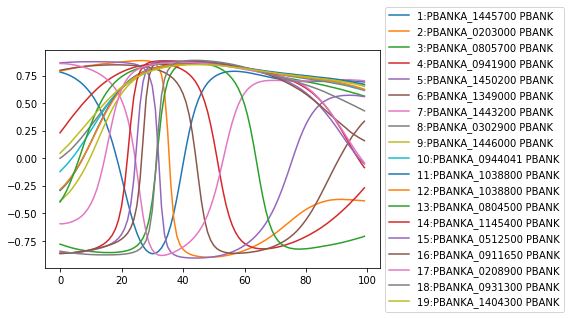

In [46]:
topics = tops
topic_num = 0

#plt.title("Topic {}: {}".format(topic_num, topics[topic_num]))
for t in range(n_topics):
    if t == topic_num:# or t not in [1,8]:
        continue
    plt.plot(corr[:, topic_num, t], label='{}:{}'.format(t, topics[t][:20]))
#plt.xticks(range(test_points.size)[::20], inverse_transform_fn(test_points)[::20], rotation=45);
plt.legend();plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5));

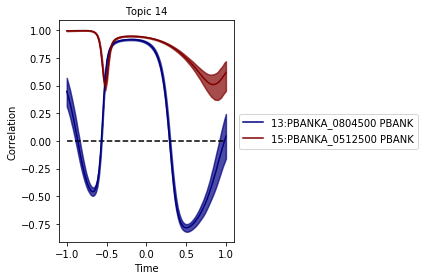

In [47]:
f = plot_sigma(corr_sample,test_points,14,topics,inverse_transform_fn=None,
           restrict_to=[13,15],plot_if_higher_of=0.1)
plt.xlabel("Time")
plt.ylabel("Correlation")
plt.title("Topic 14",fontsize=10)
plt.tight_layout()

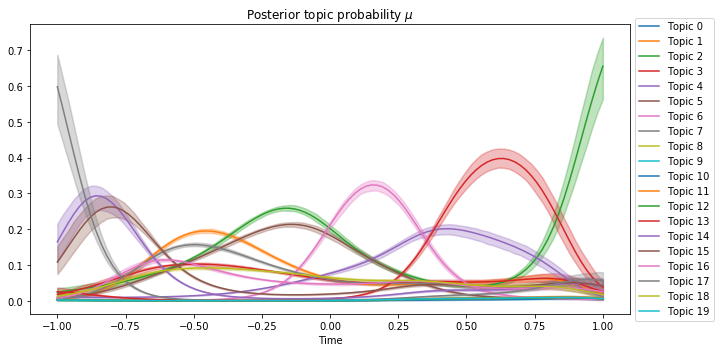

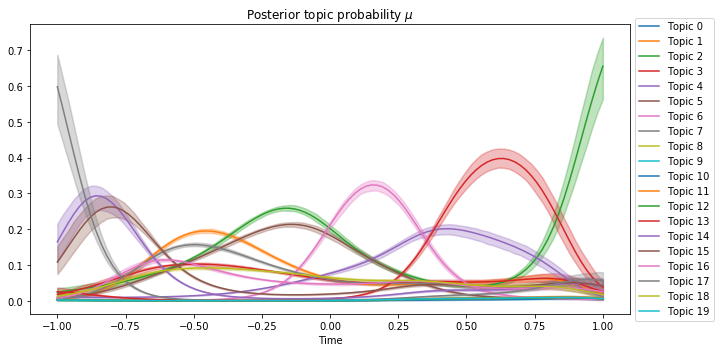

In [48]:
plot_mu(
        mdl, test_points, topics, inverse_transform_fn,
         restrict_to=None, color_fn=lambda x:[None]*len(x), figsize=(9,5), plot_if_higher_of=0)

In [50]:
mdl

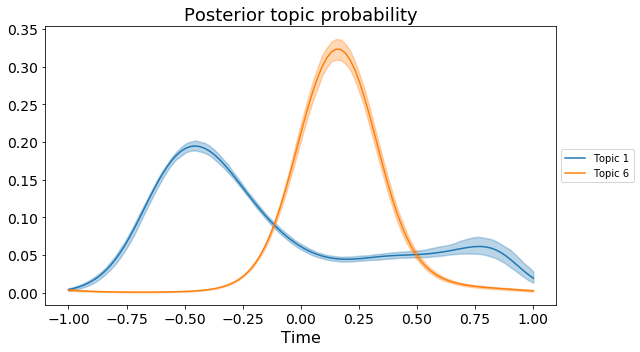

In [41]:
import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault)
f = plot_mu(
        mdl, test_points, topics, inverse_transform_fn,
        restrict_to=[1,6], color_fn=lambda x:[None]*len(x), figsize=(9,5), plot_if_higher_of=0)
#f.ax.set_facecolor("white")
plt.xlabel("Time",size=16)
plt.title("Posterior topic probability",size=18)
plt.xticks(size=14)
plt.yticks(size=14)
#plt.legend(loc=7)
plt.tight_layout()
#plt.savefig("allTopics.png",dpi=300)

In [52]:
genesPlot = topics[17].split(" ")[0:100]+topics[14].split(" ")[0:100]+topics[1].split(" ")[0:100]\
+topics[6].split(" ")[0:100]

[]

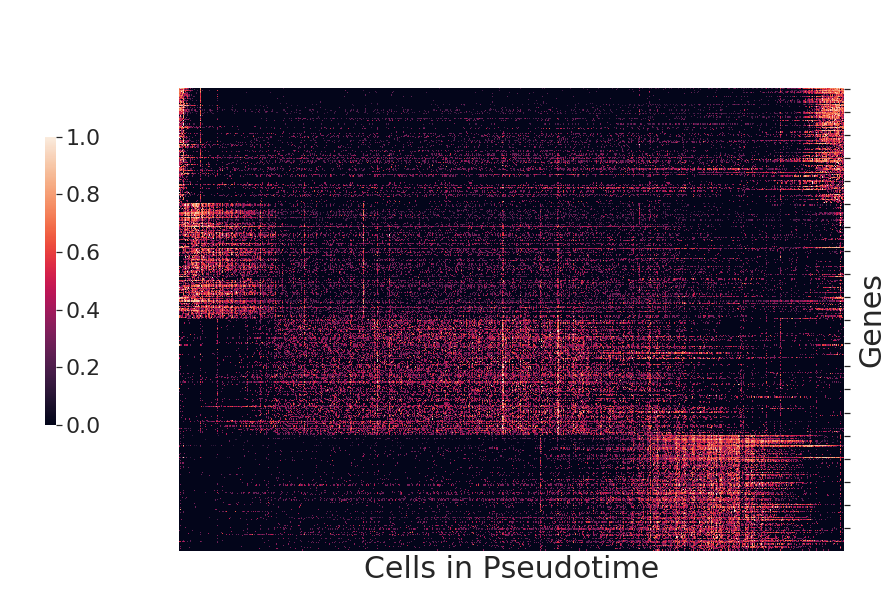

In [53]:
sb.set(font_scale=2)
h1 = sb.clustermap(np.log1p(data[genesPlot].T),row_cluster=False,col_cluster=False,figsize=(15,10),
                   standard_scale=0)
h1.cax.set_position(pos=Bbox(np.array([[0.16,0.3],[0.17,0.7]])))
h1.ax_heatmap.set_xlabel("Cells in Pseudotime",fontsize=30)
h1.ax_heatmap.set_ylabel("Genes", fontsize=30)
h1.ax_heatmap.set_xticks([])
h1.ax_heatmap.set_yticklabels([])
#plt.savefig("HeatmapMalaria2.png",dpi=300)


In [58]:
plt.rcdefaults()

In [60]:
topic = 18
X = np.arange(len(topics_per_time[topic]))
Y = topics_per_time[topic]
X = sm.add_constant(X)
ols_res = OLS(Y,X).fit()
durbin_watson(ols_res.resid)

0.7876951561962325

<Figure size 3000x2100 with 0 Axes>

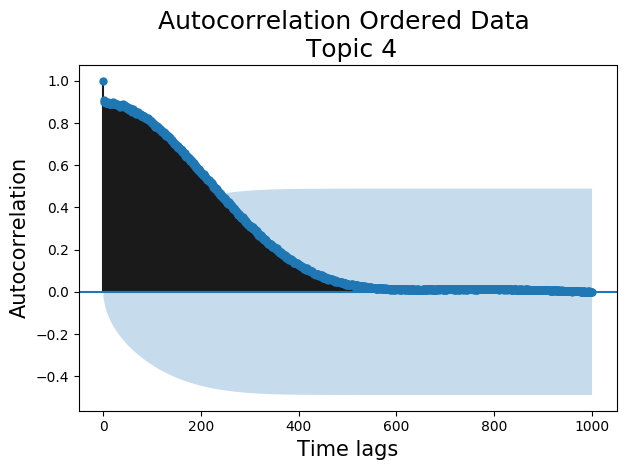

In [72]:
from matplotlib.pyplot import figure
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
figure(figsize=(10,7),dpi=300)
plot_acf(topics_per_time[4],lags=1000)
plt.xlabel("Time lags",size=15)
plt.ylabel("Autocorrelation",size=15)
plt.title("Autocorrelation Ordered Data \n Topic 4",size=18)
plt.tight_layout()
plt.savefig("topic4_ordered.png",dpi=300)

In [67]:
with tf.device('gpu:2'):
    #print (vars(mdl))
    print (mdl.surrogate_posterior_beta.kernel._base_kernel._length_scale)
    print (mdl.surrogate_posterior_beta.kernel._base_kernel._amplitude)
    print (mdl.surrogate_posterior_beta.mean_fn(index_points=np.linspace(-1,1,100)[:,None])[0].shape)

<TransformedVariable: dtype=float64, shape=[], fn="softplus", numpy=22.959221591396624>
<TransformedVariable: dtype=float64, shape=[], fn="softplus", numpy=1.585079189826699>
(20, 100)


In [79]:
with tf.device('cpu'):
    words_topic = mdl.surrogate_posterior_beta.get_marginal_distribution(index_points=index_points).mean()
    words_topic = tf.nn.softmax(words_topic, axis=1)

In [80]:
with tf.device('cpu'): 
    wordTopic = tf.reduce_mean(words_topic[:,:,:],-1).numpy()

In [83]:
wT = pd.DataFrame(wordTopic, index=data.columns)

In [84]:
wT

0         1         2         3         4         5   \
PBANKA_0000301  0.136346  0.002879  0.001600  0.004453  0.004337  0.002116   
PBANKA_0000600  0.132716  0.004001  0.001593  0.012310  0.004234  0.002208   
PBANKA_0001001  0.129347  0.006000  0.001688  0.008708  0.004220  0.002573   
PBANKA_0001101  0.138272  0.003057  0.001627  0.006470  0.004421  0.002152   
PBANKA_0001201  0.138570  0.002942  0.001632  0.004949  0.004426  0.002160   
...                  ...       ...       ...       ...       ...       ...   
PBANKA_MIT0270  0.115527  0.025446  0.005655  0.030490  0.012284  0.014727   
PBANKA_MIT0280  0.119930  0.018953  0.006921  0.016424  0.007573  0.011742   
PBANKA_MIT0310  0.120553  0.015216  0.006009  0.017713  0.009286  0.012181   
PBANKA_MIT0350  0.026571  0.156177  0.023518  0.113001  0.045930  0.121950   
PBANKA_MIT0360  0.085775  0.105223  0.026348  0.041837  0.021951  0.022392   

                      6         7         8         9         10        11  \
PBANKA_0000301  0.003199  0.002665  0.132298  0.132233  0.133880  0.129436   
PBANKA_0000600  0.003108  0.003607  0.129683  0.129564  0.130964  0.126878   
PBANKA_0001001  0.003018  0.005424  0.127015  0.127509  0.128479  0.125131   
PBANKA_0001101  0.003237  0.002738  0.134506  0.134452  0.135719  0.131275   
PBANKA_0001201  0.003248  0.002706  0.135233  0.134680  0.136332  0.131847   
...                  ...       ...       ...       ...       ...       ...   
PBANKA_MIT0270  0.010066  0.025951  0.113690  0.116119  0.115220  0.113161   
PBANKA_MIT0280  0.014001  0.019901  0.117536  0.117930  0.118127  0.115956   
PBANKA_MIT0310  0.014252  0.015231  0.117557  0.118984  0.119052  0.116265   
PBANKA_MIT0350  0.033495  0.189175  0.026531  0.026647  0.026372  0.026573   
PBANKA_MIT0360  0.033678  0.045226  0.084185  0.084755  0.084162  0.082717   

                      12        13        14        15        16        17  \
PBANKA_0000301  0.132425  0.002643  0.023624  0.013999  0.005566  0.013959   
PBANKA_0000600  0.130043  0.002579  0.011436  0.008960  0.020052  0.013577   
PBANKA_0001001  0.127333  0.002492  0.014319  0.014536  0.016044  0.030260   
PBANKA_0001101  0.134416  0.002683  0.010930  0.006299  0.007357  0.014175   
PBANKA_0001201  0.134772  0.002701  0.010942  0.006549  0.006866  0.014179   
...                  ...       ...       ...       ...       ...       ...   
PBANKA_MIT0270  0.113284  0.008094  0.013449  0.006565  0.005066  0.027672   
PBANKA_MIT0280  0.116655  0.006444  0.013320  0.008065  0.008419  0.037510   
PBANKA_MIT0310  0.117281  0.003794  0.014485  0.007383  0.007961  0.042000   
PBANKA_MIT0350  0.026431  0.014596  0.019136  0.012205  0.011192  0.044996   
PBANKA_MIT0360  0.082671  0.009714  0.014107  0.008941  0.009455  0.039028   

                      18        19  
PBANKA_0000301  0.005023  0.117319  
PBANKA_0000600  0.017755  0.114731  
PBANKA_0001001  0.012750  0.113154  
PBANKA_0001101  0.007317  0.118896  
PBANKA_0001201  0.005826  0.119440  
...                  ...       ...  
PBANKA_MIT0270  0.024413  0.103121  
PBANKA_MIT0280  0.020277  0.104315  
PBANKA_MIT0310  0.021238  0.103557  
PBANKA_MIT0350  0.027176  0.028329  
PBANKA_MIT0360  0.043152  0.074683  

[4890 rows x 20 columns]